In [619]:
import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pandas as pd
from copy import deepcopy
sns.set()

In [620]:
df = pd.read_csv('train_space.csv')

In [621]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [622]:
df = df.replace(False, 0)
df = df.replace(True, 1)
df = df.replace('[null]', np.nan)

In [623]:
df.describe()

CryoSleep          Age          VIP   RoomService     FoodCourt  \
count  8476.000000  8514.000000  8490.000000   8512.000000   8510.000000   
mean      0.358306    28.827930     0.023439    224.687617    458.077203   
std       0.479531    14.489021     0.151303    666.717663   1611.489240   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000    19.000000     0.000000      0.000000      0.000000   
50%       0.000000    27.000000     0.000000      0.000000      0.000000   
75%       1.000000    38.000000     0.000000     47.000000     76.000000   
max       1.000000    79.000000     1.000000  14327.000000  29813.000000   

       ShoppingMall           Spa        VRDeck  Transported  
count   8485.000000   8510.000000   8505.000000  8693.000000  
mean     173.729169    311.138778    304.854791     0.503624  
std      604.696458   1136.705535   1145.717189     0.500016  
min        0.000000      0.000000      0.000000     0.000000  
25%        0.000000      0.000000      0.000000     0.000000  
50%        0.000000      0.000000      0.000000     1.000000  
75%       27.000000     59.000000     46.000000     1.000000  
max    23492.000000  22408.000000  24133.000000     1.000000

In [624]:
df_test = pd.read_csv('test_space.csv')

In [625]:
df_test = df_test.replace(False, 0)
df_test = df_test.replace(True, 1)
df_test = df_test.replace('[null]', np.nan)
df_test

PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age  VIP  \
0        0013_01      Earth        1.0     G/3/S    TRAPPIST-1e  27.0  0.0   
1        0018_01      Earth        0.0     F/4/S    TRAPPIST-1e  19.0  0.0   
2        0019_01     Europa        1.0     C/0/S    55 Cancri e  31.0  0.0   
3        0021_01     Europa        0.0     C/1/S    TRAPPIST-1e  38.0  0.0   
4        0023_01      Earth        0.0     F/5/S    TRAPPIST-1e  20.0  0.0   
...          ...        ...        ...       ...            ...   ...  ...   
4272     9266_02      Earth        1.0  G/1496/S    TRAPPIST-1e  34.0  0.0   
4273     9269_01      Earth        0.0       NaN    TRAPPIST-1e  42.0  0.0   
4274     9271_01       Mars        1.0   D/296/P    55 Cancri e   NaN  0.0   
4275     9273_01     Europa        0.0   D/297/P            NaN   NaN  0.0   
4276     9277_01      Earth        1.0  G/1498/S  PSO J318.5-22  43.0  0.0   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [626]:
y = df['Transported']
X = df.drop(['PassengerId', 'Name', 'Transported'], axis=1)
X_test = df_test.drop(['PassengerId', 'Name'], axis=1)

In [627]:
a_list = []
b_list = []
c_list = []

X['Cabin'].fillna('NAN', inplace=True)

for i in range(X.shape[0]):
    if X.loc[i, 'Cabin'] != 'NAN':
        a, b, c = str(X.loc[i, 'Cabin']).split('/')
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
    else:
        a_list.append(np.nan)
        b_list.append(np.nan)
        c_list.append(np.nan)

In [628]:
X_1 = pd.DataFrame({'Cabin_1': a_list, 'Cabin_2': b_list, 'Cabin_3': c_list})
X = X.join(X_1)
X.drop('Cabin', axis=1, inplace=True)

In [629]:
a_list = []
b_list = []
c_list = []

X_test['Cabin'].fillna('NAN', inplace=True)

for i in range(X_test.shape[0]):
    if X_test.loc[i, 'Cabin'] != 'NAN':
        a, b, c = str(X_test.loc[i, 'Cabin']).split('/')
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
    else:
        a_list.append('H')
        b_list.append(10000)
        c_list.append('N')

In [630]:
X_1 = pd.DataFrame({'Cabin_1': a_list, 'Cabin_2': b_list, 'Cabin_3': c_list})
X_test = X_test.join(X_1)
X_test.drop('Cabin', axis=1, inplace=True)
X = pd.concat([X, X_test])

In [631]:
X['Cabin_2'] = X['Cabin_2'].astype(float)
X['Cabin_2'] = pd.qcut(X['Cabin_2'], q=10)

In [632]:
X

HomePlanet  CryoSleep    Destination   Age  VIP  RoomService  FoodCourt  \
0        Europa        0.0    TRAPPIST-1e  39.0  0.0          0.0        0.0   
1         Earth        0.0    TRAPPIST-1e  24.0  0.0        109.0        9.0   
2        Europa        0.0    TRAPPIST-1e  58.0  1.0         43.0     3576.0   
3        Europa        0.0    TRAPPIST-1e  33.0  0.0          0.0     1283.0   
4         Earth        0.0    TRAPPIST-1e  16.0  0.0        303.0       70.0   
...         ...        ...            ...   ...  ...          ...        ...   
4272      Earth        1.0    TRAPPIST-1e  34.0  0.0          0.0        0.0   
4273      Earth        0.0    TRAPPIST-1e  42.0  0.0          0.0      847.0   
4274       Mars        1.0    55 Cancri e   NaN  0.0          0.0        0.0   
4275     Europa        0.0            NaN   NaN  0.0          0.0     2680.0   
4276      Earth        1.0  PSO J318.5-22  43.0  0.0          0.0        0.0   

      ShoppingMall     Spa  VRDeck Cabin_1            Cabin_2 Cabin_3  
0              0.0     0.0     0.0       B     (-0.001, 63.0]       P  
1             25.0   549.0    44.0       F     (-0.001, 63.0]       S  
2              0.0  6715.0    49.0       A     (-0.001, 63.0]       S  
3            371.0  3329.0   193.0       A     (-0.001, 63.0]       S  
4            151.0   565.0     2.0       F     (-0.001, 63.0]       S  
...            ...     ...     ...     ...                ...     ...  
4272           0.0     0.0     0.0       G  (1425.0, 10000.0]       S  
4273          17.0    10.0   144.0       H  (1425.0, 10000.0]       N  
4274           0.0     0.0     0.0       D     (289.0, 439.0]       P  
4275           0.0     0.0   523.0       D     (289.0, 439.0]       P  
4276           0.0     0.0     0.0       G  (1425.0, 10000.0]       S  

[12970 rows x 13 columns]

In [633]:
num_cols = X.columns[X.dtypes == float].tolist()
cat_cols = X.columns[X.dtypes != float].tolist()

X_nn = X[['CryoSleep', 'VIP']]
num_cols.remove('CryoSleep')
num_cols.remove('VIP')

X_cc = pd.get_dummies(X[cat_cols])
X_cc.drop(['HomePlanet_Earth', 'Destination_TRAPPIST-1e', 'Cabin_1_F', 'Cabin_2_(-0.001, 63.0]', 'Cabin_3_S'],
          axis=1, inplace=True)

#sc = MinMaxScaler()
X_nc = X[num_cols]
#sc.fit(X_nc)
#X_nc = sc.transform(X_nc)
#X_nc = pd.DataFrame(X_nc, columns=num_cols)

In [634]:
X_nn.reset_index(drop=True, inplace=True)
X_nc.reset_index(drop=True, inplace=True)
X_cc.reset_index(drop=True, inplace=True)

In [635]:
X = pd.concat([X_nn, X_nc], axis=1)
X = pd.concat([X, X_cc], axis=1)

In [636]:
X

CryoSleep  VIP   Age  RoomService  FoodCourt  ShoppingMall     Spa  \
0            0.0  0.0  39.0          0.0        0.0           0.0     0.0   
1            0.0  0.0  24.0        109.0        9.0          25.0   549.0   
2            0.0  1.0  58.0         43.0     3576.0           0.0  6715.0   
3            0.0  0.0  33.0          0.0     1283.0         371.0  3329.0   
4            0.0  0.0  16.0        303.0       70.0         151.0   565.0   
...          ...  ...   ...          ...        ...           ...     ...   
12965        1.0  0.0  34.0          0.0        0.0           0.0     0.0   
12966        0.0  0.0  42.0          0.0      847.0          17.0    10.0   
12967        1.0  0.0   NaN          0.0        0.0           0.0     0.0   
12968        0.0  0.0   NaN          0.0     2680.0           0.0     0.0   
12969        1.0  0.0  43.0          0.0        0.0           0.0     0.0   

       VRDeck  HomePlanet_Europa  HomePlanet_Mars  ...  \
0         0.0                  1                0  ...   
1        44.0                  0                0  ...   
2        49.0                  1                0  ...   
3       193.0                  1                0  ...   
4         2.0                  0                0  ...   
...       ...                ...              ...  ...   
12965     0.0                  0                0  ...   
12966   144.0                  0                0  ...   
12967     0.0                  0                1  ...   
12968   523.0                  1                0  ...   
12969     0.0                  0                0  ...   

       Cabin_2_(132.0, 210.0]  Cabin_2_(210.0, 289.0]  Cabin_2_(289.0, 439.0]  \
0                           0                       0                       0   
1                           0                       0                       0   
2                           0                       0                       0   
3                           0                       0                       0   
4                           0                       0                       0   
...                       ...                     ...                     ...   
12965                       0                       0                       0   
12966                       0                       0                       0   
12967                       0                       0                       1   
12968                       0                       0                       1   
12969                       0                       0                       0   

       Cabin_2_(439.0, 629.0]  Cabin_2_(629.0, 894.0]  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           0                       0   
...                       ...                     ...   
12965                       0                       0   
12966                       0                       0   
12967                       0                       0   
12968                       0                       0   
12969                       0                       0   

       Cabin_2_(894.0, 1151.0]  Cabin_2_(1151.0, 1425.0]  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
12965                        0                         0   
12966                        0                         0   
12967                        0                         0   
12968                        0                         0   
12969                        0                         0   

      

In [637]:
X['Age'] = X['Age'].fillna(24)

In [638]:
X[['CryoSleep', 'VIP']] = X[['CryoSleep', 'VIP']].fillna(2)
X = X.fillna(0)

In [639]:
X['Sum_pays'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

<AxesSubplot:>

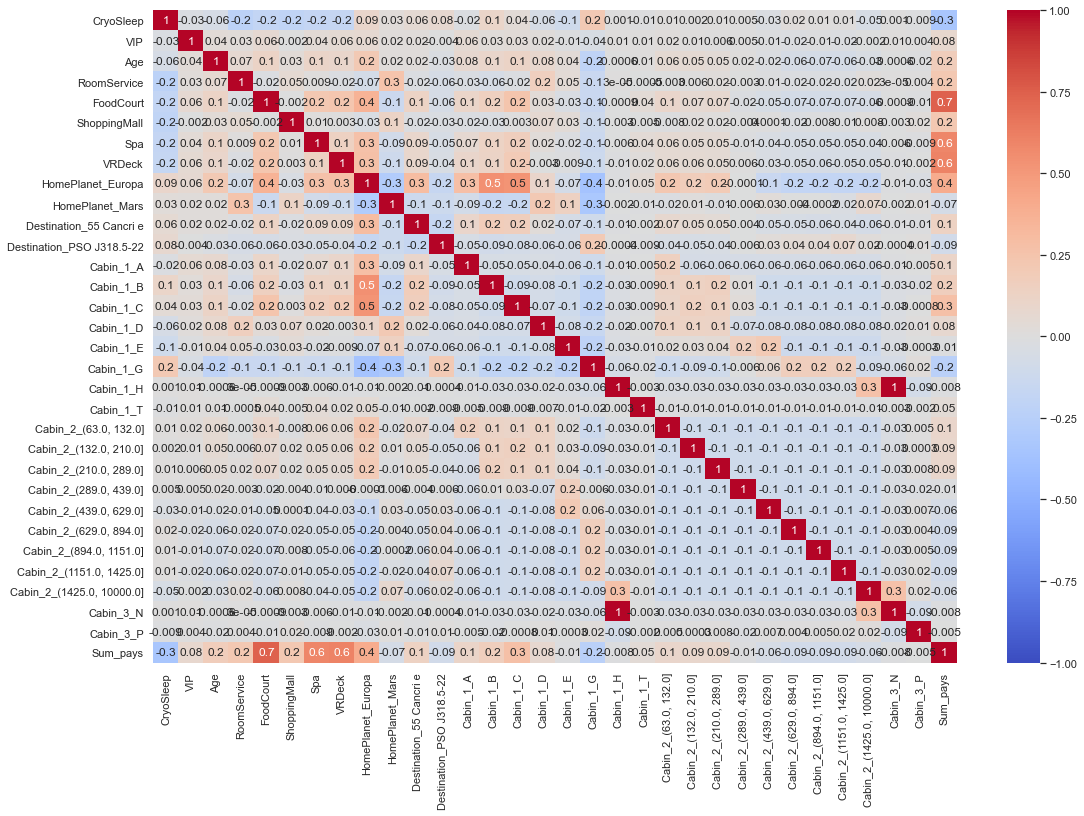

In [587]:
fig = plt.gcf()
fig.set_size_inches(18, 12)
sns.heatmap(X.corr(),annot = True, fmt='.1g', vmax=1, vmin=-1, center=0, cmap='coolwarm')

In [640]:
X.drop('Cabin_3_N', axis=1, inplace=True)

In [641]:
X_test = X.loc[8693:,:]
X = X.loc[:8692,:]
X_test

CryoSleep  VIP   Age  RoomService  FoodCourt  ShoppingMall     Spa  \
8693         1.0  0.0  27.0          0.0        0.0           0.0     0.0   
8694         0.0  0.0  19.0          0.0        9.0           0.0  2823.0   
8695         1.0  0.0  31.0          0.0        0.0           0.0     0.0   
8696         0.0  0.0  38.0          0.0     6652.0           0.0   181.0   
8697         0.0  0.0  20.0         10.0        0.0         635.0     0.0   
...          ...  ...   ...          ...        ...           ...     ...   
12965        1.0  0.0  34.0          0.0        0.0           0.0     0.0   
12966        0.0  0.0  42.0          0.0      847.0          17.0    10.0   
12967        1.0  0.0  24.0          0.0        0.0           0.0     0.0   
12968        0.0  0.0  24.0          0.0     2680.0           0.0     0.0   
12969        1.0  0.0  43.0          0.0        0.0           0.0     0.0   

       VRDeck  HomePlanet_Europa  HomePlanet_Mars  ...  \
8693      0.0                  0                0  ...   
8694      0.0                  0                0  ...   
8695      0.0                  1                0  ...   
8696    585.0                  1                0  ...   
8697      0.0                  0                0  ...   
...       ...                ...              ...  ...   
12965     0.0                  0                0  ...   
12966   144.0                  0                0  ...   
12967     0.0                  0                1  ...   
12968   523.0                  1                0  ...   
12969     0.0                  0                0  ...   

       Cabin_2_(132.0, 210.0]  Cabin_2_(210.0, 289.0]  Cabin_2_(289.0, 439.0]  \
8693                        0                       0                       0   
8694                        0                       0                       0   
8695                        0                       0                       0   
8696                        0                       0                       0   
8697                        0                       0                       0   
...                       ...                     ...                     ...   
12965                       0                       0                       0   
12966                       0                       0                       0   
12967                       0                       0                       1   
12968                       0                       0                       1   
12969                       0                       0                       0   

       Cabin_2_(439.0, 629.0]  Cabin_2_(629.0, 894.0]  \
8693                        0                       0   
8694                        0                       0   
8695                        0                       0   
8696                        0                       0   
8697                        0                       0   
...                       ...                     ...   
12965                       0                       0   
12966                       0                       0   
12967                       0                       0   
12968                       0                       0   
12969                       0                       0   

       Cabin_2_(894.0, 1151.0]  Cabin_2_(1151.0, 1425.0]  \
8693                         0                         0   
8694                         0                         0   
8695                         0                         0   
8696                         0                         0   
8697                         0                         0   
...                        ...                       ...   
12965                        0                         0   
12966                        0                         0   
12967                        0                         0   
12968                        0                         0   
12969                        0                         0   

      

In [642]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)

In [643]:
mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi.head(20)

Sum_pays                     0.135794
CryoSleep                    0.121195
RoomService                  0.074631
Spa                          0.069948
VRDeck                       0.062740
ShoppingMall                 0.055360
FoodCourt                    0.035546
HomePlanet_Europa            0.024242
Age                          0.015042
Cabin_1_B                    0.012556
Cabin_3_P                    0.009781
HomePlanet_Mars              0.007085
Cabin_1_D                    0.006633
Cabin_2_(894.0, 1151.0]      0.006287
Cabin_1_G                    0.006275
Cabin_1_T                    0.006235
Destination_55 Cancri e      0.004939
Cabin_2_(1425.0, 10000.0]    0.001419
Cabin_2_(210.0, 289.0]       0.001008
VIP                          0.000567
dtype: float64

In [644]:
good_cols = mi.head(22).index.tolist()
X = X[good_cols]
X_test = X_test[good_cols]

In [645]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter("ignore")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


LR = LogisticRegression(penalty='l2')

params = {'C': np.arange(0.1,3,0.1)}
grid_0 = GridSearchCV(LR, params, cv=10, scoring='accuracy')
grid_0.fit(X_train, y_train)

print("Best C = %.4f" % grid_0.best_params_["C"])
print("Best Accuracy = %.4f" % grid_0.best_score_)

Best C = 0.2000
Best Accuracy = 0.7886


In [647]:
LR = LogisticRegression(penalty='l2', C=2.9)

LR.fit(X_train, y_train)
pred_train = LR.predict(X_train)
pred_val = LR.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.7858786310037389 0.7901092581943646


Best k = 32.0000
Best Accuracy = 0.7413


<Figure size 1440x1440 with 0 Axes>

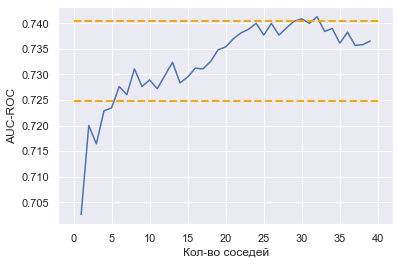

<Figure size 1440x1440 with 0 Axes>

In [190]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 40)}
grid_1 = GridSearchCV(knn, params, cv=5, scoring='accuracy')
grid_1.fit(X_train, y_train)

print("Best k = %.4f" % grid_1.best_params_["n_neighbors"])
print("Best Accuracy = %.4f" % grid_1.best_score_)

a1 = np.mean(grid_1.cv_results_["mean_test_score"]) - np.std(grid_1.cv_results_["mean_test_score"])
a2 = np.mean(grid_1.cv_results_["mean_test_score"]) + np.std(grid_1.cv_results_["mean_test_score"])

plt.plot(list(range(1, 40)), grid_1.cv_results_["mean_test_score"])
plt.plot([0, 40], [a1, a1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 40], [a2, a2], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Кол-во соседей")
plt.ylabel("Accuracy")
plt.figure(figsize=(20, 20))

In [191]:
knn = KNeighborsClassifier(n_neighbors=32)

knn.fit(X_train, y_train)
pred_train = knn.predict(X_train)
pred_val = knn.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.7622950819672131 0.7389304197814837


Best depth = 7.0000
Best Accuracy = 0.7778


<Figure size 1440x1440 with 0 Axes>

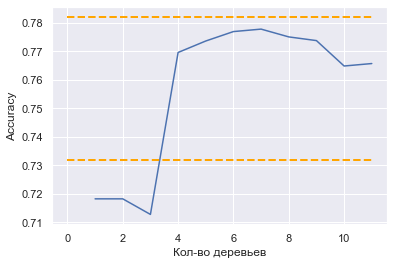

<Figure size 1440x1440 with 0 Axes>

In [193]:
from sklearn.tree import DecisionTreeClassifier

DC = DecisionTreeClassifier()
params_2 = {'max_depth': range(1, 12)}
grid_2 = GridSearchCV(DC, params_2, cv=5, scoring='accuracy')
grid_2.fit(X_train, y_train)

print("Best depth = %.4f" % grid_2.best_params_["max_depth"])
print("Best Accuracy = %.4f" % grid_2.best_score_)

b1 = np.mean(grid_2.cv_results_["mean_test_score"]) - np.std(grid_2.cv_results_["mean_test_score"])
b2 = np.mean(grid_2.cv_results_["mean_test_score"]) + np.std(grid_2.cv_results_["mean_test_score"])

plt.plot(list(range(1, 12)), grid_2.cv_results_["mean_test_score"])
plt.plot([0, 11], [b1, b1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 11], [b2, b2],
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Кол-во деревьев")
plt.ylabel("Accuracy")
plt.figure(figsize=(20, 20))

In [194]:
DC = DecisionTreeClassifier(max_depth=7)

DC.fit(X_train, y_train)
pred_train = DC.predict(X_train)
pred_val = DC.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.7995398331895313 0.753306497987349


Best loss = modified_huber
Best Accuracy = 0.7824
Best loss = modified_huber
Best Accuracy = 0.7758
Best loss = modified_huber
Best Accuracy = 0.7742
Best loss = modified_huber
Best Accuracy = 0.7793
Best loss = modified_huber
Best Accuracy = 0.7774
Best loss = hinge
Best Accuracy = 0.7747
Best loss = log
Best Accuracy = 0.7750


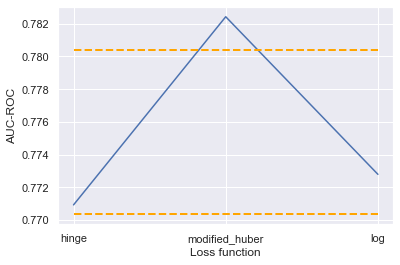

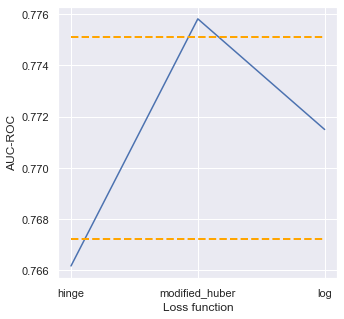

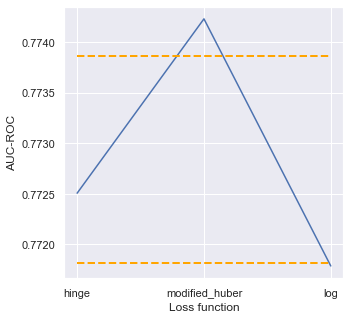

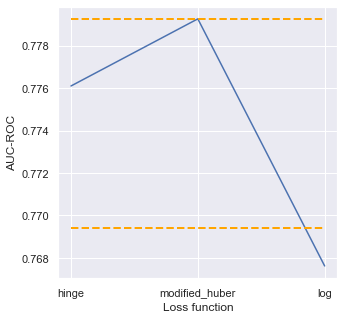

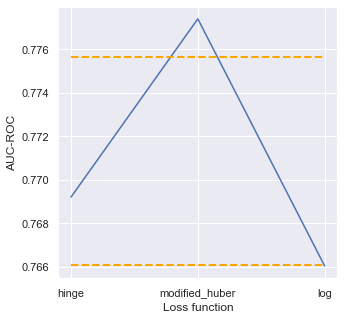

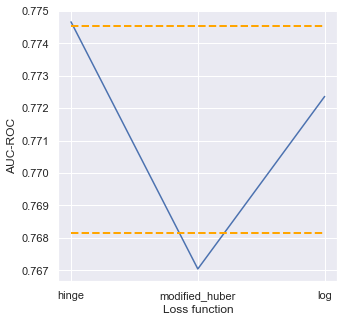

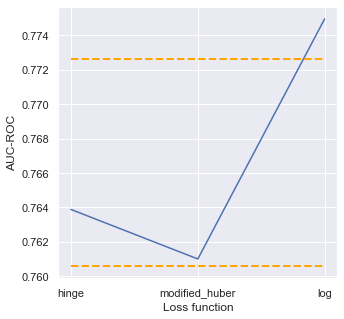

<Figure size 360x360 with 0 Axes>

In [195]:
from sklearn.linear_model import SGDClassifier

SL = SGDClassifier()
params_3 = {'loss': ['hinge', 'modified_huber', 'log']}
for i in range(1, 8):
    grid_3 = GridSearchCV(SL, params_3, cv=5, scoring='accuracy')
    grid_3.fit(X_train, y_train)

    print("Best loss =", grid_3.best_params_["loss"])
    print("Best Accuracy = %.4f" % grid_3.best_score_)
    
    c1 = np.mean(grid_3.cv_results_["mean_test_score"]) - np.std(grid_3.cv_results_["mean_test_score"])
    c2 = np.mean(grid_3.cv_results_["mean_test_score"]) + np.std(grid_3.cv_results_["mean_test_score"])

    plt.plot(['hinge', 'modified_huber', 'log'], grid_3.cv_results_["mean_test_score"])
    plt.plot(['hinge', 'log'], [c1, c1],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.plot(['hinge', 'log'], [c2, c2],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.xlabel("Loss function")
    plt.ylabel("AUC-ROC")
    plt.figure(figsize=(5, 5))

In [196]:
SL = SGDClassifier(loss='modified_huber')
SL.fit(X_train, y_train)
pred_train = SL.predict(X_train)
pred_val = SL.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.7901926948518838 0.7935595169637722


In [200]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
params_4 = {'n_estimators': range(1, 1001, 20)}
grid_4 = GridSearchCV(RFC, params_4, cv=5, scoring='accuracy')
grid_4.fit(X_train, y_train)

print("Best n = %.4f" % grid_4.best_params_["n_estimators"])
print("Best Accuracy = %.4f" % grid_4.best_score_)

#plt.plot(list(range(1, 90)), grid_4.cv_results_["mean_test_score"])
#plt.xlabel("Кол-во деревьев")
#plt.ylabel("Accuracy")

Best n = 501.0000
Best Accuracy = 0.7959


In [201]:
RFC = RandomForestClassifier(n_estimators=700)
RFC.fit(X_train, y_train)
pred_train = RFC.predict(X_train)
pred_val = RFC.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.9807305148116192 0.7987349051178838


Best n = 121
Accuracy = 0.8061549839926766


Text(0, 0.5, 'Accuracy')

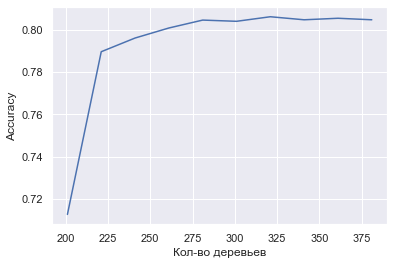

In [204]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
params_5 = {'n_estimators': range(1, 401, 20)}
grid_5 = GridSearchCV(GBC, params_GB, cv=5, scoring='accuracy')
grid_5.fit(X_train, y_train)

print("Best n =", grid_5.best_params_["n_estimators"])
print("Accuracy =", grid_5.best_score_)

plt.plot(list(range(1, 401, 20)), grid_5.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("Accuracy")

In [206]:
GBC = GradientBoostingClassifier(n_estimators=121)
GBC.fit(X_train, y_train)
pred_train = GBC.predict(X_train)
pred_val = GBC.predict(X_val)

print('Accuracy: ', accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val))

Accuracy:  0.8264308311763015 0.8021851638872916


In [218]:
from catboost import CatBoostClassifier

In [219]:
def CV(X_train, y_train, number_folds, model, metrics):

    k = int(np.floor(float(X_train.shape[0]) / number_folds))

    errors = np.zeros(number_folds-1)
 
    for i in range(2, number_folds + 1):

        split = float(i-1)/i

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]

        index = int(np.floor(X.shape[0] * split))
       
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)
    
    return errors.mean()

In [514]:
score = []


for i in tqdm(['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll']):
    for j in range(20, 421, 100):
        ctb = CatBoostClassifier(loss_function = i,
                                 early_stopping_rounds=j)
        CV(X_train, y_train, 5, ctb, accuracy_score)
        score.append(accuracy_score(ctb.predict(X_val), y_val))
        score.append('I/nI')

  0%|          | 0/4 [00:00<?, ?it/s]

Learning rate set to 0.034374
0:	learn: 0.6798442	test: 0.6807645	best: 0.6807645 (0)	total: 2.85ms	remaining: 2.85s
1:	learn: 0.6711553	test: 0.6724039	best: 0.6724039 (1)	total: 4.64ms	remaining: 2.32s
2:	learn: 0.6575538	test: 0.6594409	best: 0.6594409 (2)	total: 7.84ms	remaining: 2.6s
3:	learn: 0.6468009	test: 0.6489226	best: 0.6489226 (3)	total: 10.8ms	remaining: 2.69s
4:	learn: 0.6326442	test: 0.6359836	best: 0.6359836 (4)	total: 13.5ms	remaining: 2.68s
5:	learn: 0.6192271	test: 0.6243724	best: 0.6243724 (5)	total: 16.1ms	remaining: 2.67s
6:	learn: 0.6074314	test: 0.6138424	best: 0.6138424 (6)	total: 19.1ms	remaining: 2.71s
7:	learn: 0.5987040	test: 0.6055442	best: 0.6055442 (7)	total: 21.9ms	remaining: 2.72s
8:	learn: 0.5902114	test: 0.5978969	best: 0.5978969 (8)	total: 25.5ms	remaining: 2.81s
9:	learn: 0.5835943	test: 0.5914867	best: 0.5914867 (9)	total: 28.2ms	remaining: 2.79s
10:	learn: 0.5762902	test: 0.5846611	best: 0.5846611 (10)	total: 30.9ms	remaining: 2.78s
11:	learn: 0

137:	learn: 0.3703620	test: 0.4337337	best: 0.4336008 (130)	total: 328ms	remaining: 2.05s
138:	learn: 0.3695583	test: 0.4330602	best: 0.4330602 (138)	total: 331ms	remaining: 2.05s
139:	learn: 0.3692374	test: 0.4328467	best: 0.4328467 (139)	total: 333ms	remaining: 2.05s
140:	learn: 0.3689617	test: 0.4328939	best: 0.4328467 (139)	total: 336ms	remaining: 2.04s
141:	learn: 0.3681682	test: 0.4326539	best: 0.4326539 (141)	total: 338ms	remaining: 2.04s
142:	learn: 0.3676463	test: 0.4325530	best: 0.4325530 (142)	total: 341ms	remaining: 2.04s
143:	learn: 0.3669286	test: 0.4323335	best: 0.4323335 (143)	total: 343ms	remaining: 2.04s
144:	learn: 0.3664911	test: 0.4320829	best: 0.4320829 (144)	total: 345ms	remaining: 2.04s
145:	learn: 0.3660019	test: 0.4318573	best: 0.4318573 (145)	total: 348ms	remaining: 2.03s
146:	learn: 0.3651158	test: 0.4315290	best: 0.4315290 (146)	total: 350ms	remaining: 2.03s
147:	learn: 0.3644862	test: 0.4315121	best: 0.4315121 (147)	total: 353ms	remaining: 2.03s
148:	learn

0:	learn: 0.6761847	test: 0.6765586	best: 0.6765586 (0)	total: 15ms	remaining: 14.9s
1:	learn: 0.6619614	test: 0.6625969	best: 0.6625969 (1)	total: 17.9ms	remaining: 8.94s
2:	learn: 0.6458613	test: 0.6476225	best: 0.6476225 (2)	total: 21ms	remaining: 6.97s
3:	learn: 0.6339227	test: 0.6352733	best: 0.6352733 (3)	total: 24.3ms	remaining: 6.04s
4:	learn: 0.6209418	test: 0.6221961	best: 0.6221961 (4)	total: 28ms	remaining: 5.57s
5:	learn: 0.6083916	test: 0.6102553	best: 0.6102553 (5)	total: 31.1ms	remaining: 5.15s
6:	learn: 0.5970694	test: 0.5988394	best: 0.5988394 (6)	total: 33.9ms	remaining: 4.81s
7:	learn: 0.5876176	test: 0.5898483	best: 0.5898483 (7)	total: 36.7ms	remaining: 4.56s
8:	learn: 0.5783871	test: 0.5807330	best: 0.5807330 (8)	total: 40ms	remaining: 4.4s
9:	learn: 0.5681085	test: 0.5714093	best: 0.5714093 (9)	total: 42.9ms	remaining: 4.24s
10:	learn: 0.5612182	test: 0.5650722	best: 0.5650722 (10)	total: 46.1ms	remaining: 4.15s
11:	learn: 0.5553692	test: 0.5592433	best: 0.55924

98:	learn: 0.4006193	test: 0.4325729	best: 0.4325729 (98)	total: 325ms	remaining: 2.96s
99:	learn: 0.3999192	test: 0.4319806	best: 0.4319806 (99)	total: 328ms	remaining: 2.95s
100:	learn: 0.3992402	test: 0.4316439	best: 0.4316439 (100)	total: 332ms	remaining: 2.96s
101:	learn: 0.3987036	test: 0.4315598	best: 0.4315598 (101)	total: 336ms	remaining: 2.96s
102:	learn: 0.3980873	test: 0.4313863	best: 0.4313863 (102)	total: 340ms	remaining: 2.96s
103:	learn: 0.3975083	test: 0.4312295	best: 0.4312295 (103)	total: 345ms	remaining: 2.97s
104:	learn: 0.3970576	test: 0.4310206	best: 0.4310206 (104)	total: 349ms	remaining: 2.98s
105:	learn: 0.3967084	test: 0.4307654	best: 0.4307654 (105)	total: 353ms	remaining: 2.97s
106:	learn: 0.3962493	test: 0.4306762	best: 0.4306762 (106)	total: 356ms	remaining: 2.97s
107:	learn: 0.3958168	test: 0.4305132	best: 0.4305132 (107)	total: 360ms	remaining: 2.97s
108:	learn: 0.3953417	test: 0.4303330	best: 0.4303330 (108)	total: 364ms	remaining: 2.97s
109:	learn: 0.

216:	learn: 0.3506692	test: 0.4183481	best: 0.4183481 (216)	total: 816ms	remaining: 2.94s
217:	learn: 0.3501184	test: 0.4183710	best: 0.4183481 (216)	total: 820ms	remaining: 2.94s
218:	learn: 0.3497037	test: 0.4182906	best: 0.4182906 (218)	total: 824ms	remaining: 2.94s
219:	learn: 0.3494097	test: 0.4182463	best: 0.4182463 (219)	total: 828ms	remaining: 2.93s
220:	learn: 0.3490694	test: 0.4183770	best: 0.4182463 (219)	total: 831ms	remaining: 2.93s
221:	learn: 0.3486361	test: 0.4184054	best: 0.4182463 (219)	total: 835ms	remaining: 2.93s
222:	learn: 0.3484282	test: 0.4184354	best: 0.4182463 (219)	total: 839ms	remaining: 2.92s
223:	learn: 0.3481145	test: 0.4183710	best: 0.4182463 (219)	total: 843ms	remaining: 2.92s
224:	learn: 0.3478869	test: 0.4183056	best: 0.4182463 (219)	total: 847ms	remaining: 2.92s
225:	learn: 0.3476026	test: 0.4182411	best: 0.4182411 (225)	total: 850ms	remaining: 2.91s
226:	learn: 0.3472616	test: 0.4182110	best: 0.4182110 (226)	total: 853ms	remaining: 2.9s
227:	learn:

91:	learn: 0.4051392	test: 0.4331369	best: 0.4331369 (91)	total: 333ms	remaining: 3.29s
92:	learn: 0.4047028	test: 0.4327865	best: 0.4327865 (92)	total: 337ms	remaining: 3.28s
93:	learn: 0.4044568	test: 0.4326421	best: 0.4326421 (93)	total: 340ms	remaining: 3.28s
94:	learn: 0.4038515	test: 0.4327367	best: 0.4326421 (93)	total: 344ms	remaining: 3.27s
95:	learn: 0.4035158	test: 0.4327039	best: 0.4326421 (93)	total: 347ms	remaining: 3.27s
96:	learn: 0.4028222	test: 0.4322665	best: 0.4322665 (96)	total: 351ms	remaining: 3.26s
97:	learn: 0.4023699	test: 0.4323872	best: 0.4322665 (96)	total: 354ms	remaining: 3.26s
98:	learn: 0.4017869	test: 0.4324838	best: 0.4322665 (96)	total: 358ms	remaining: 3.26s
99:	learn: 0.4012335	test: 0.4322817	best: 0.4322665 (96)	total: 361ms	remaining: 3.25s
100:	learn: 0.4007692	test: 0.4322772	best: 0.4322665 (96)	total: 365ms	remaining: 3.25s
101:	learn: 0.4004621	test: 0.4322463	best: 0.4322463 (101)	total: 368ms	remaining: 3.24s
102:	learn: 0.3998590	test: 0

190:	learn: 0.3689596	test: 0.4264772	best: 0.4262224 (185)	total: 672ms	remaining: 2.85s
191:	learn: 0.3681229	test: 0.4254380	best: 0.4254380 (191)	total: 677ms	remaining: 2.85s
192:	learn: 0.3678544	test: 0.4252560	best: 0.4252560 (192)	total: 682ms	remaining: 2.85s
193:	learn: 0.3674330	test: 0.4250305	best: 0.4250305 (193)	total: 686ms	remaining: 2.85s
194:	learn: 0.3672811	test: 0.4249194	best: 0.4249194 (194)	total: 690ms	remaining: 2.85s
195:	learn: 0.3668255	test: 0.4249263	best: 0.4249194 (194)	total: 694ms	remaining: 2.85s
196:	learn: 0.3664633	test: 0.4249864	best: 0.4249194 (194)	total: 698ms	remaining: 2.85s
197:	learn: 0.3662325	test: 0.4250244	best: 0.4249194 (194)	total: 702ms	remaining: 2.84s
198:	learn: 0.3659080	test: 0.4250810	best: 0.4249194 (194)	total: 705ms	remaining: 2.84s
199:	learn: 0.3655428	test: 0.4251051	best: 0.4249194 (194)	total: 708ms	remaining: 2.83s
200:	learn: 0.3651101	test: 0.4250868	best: 0.4249194 (194)	total: 712ms	remaining: 2.83s
201:	learn

285:	learn: 0.3395410	test: 0.4240617	best: 0.4237949 (280)	total: 1s	remaining: 2.51s
286:	learn: 0.3389513	test: 0.4236017	best: 0.4236017 (286)	total: 1.01s	remaining: 2.51s
287:	learn: 0.3387736	test: 0.4236004	best: 0.4236004 (287)	total: 1.01s	remaining: 2.5s
288:	learn: 0.3383417	test: 0.4237283	best: 0.4236004 (287)	total: 1.01s	remaining: 2.5s
289:	learn: 0.3380559	test: 0.4236956	best: 0.4236004 (287)	total: 1.02s	remaining: 2.49s
290:	learn: 0.3376243	test: 0.4236775	best: 0.4236004 (287)	total: 1.02s	remaining: 2.49s
291:	learn: 0.3374183	test: 0.4234963	best: 0.4234963 (291)	total: 1.02s	remaining: 2.49s
292:	learn: 0.3369877	test: 0.4234302	best: 0.4234302 (292)	total: 1.03s	remaining: 2.48s
293:	learn: 0.3365978	test: 0.4232374	best: 0.4232374 (293)	total: 1.03s	remaining: 2.48s
294:	learn: 0.3364493	test: 0.4232863	best: 0.4232374 (293)	total: 1.04s	remaining: 2.48s
295:	learn: 0.3360411	test: 0.4233648	best: 0.4232374 (293)	total: 1.04s	remaining: 2.48s
296:	learn: 0.3

88:	learn: 0.4086172	test: 0.4201123	best: 0.4201123 (88)	total: 357ms	remaining: 3.66s
89:	learn: 0.4082224	test: 0.4198088	best: 0.4198088 (89)	total: 361ms	remaining: 3.65s
90:	learn: 0.4077972	test: 0.4193641	best: 0.4193641 (90)	total: 365ms	remaining: 3.65s
91:	learn: 0.4074052	test: 0.4191330	best: 0.4191330 (91)	total: 370ms	remaining: 3.65s
92:	learn: 0.4070077	test: 0.4190397	best: 0.4190397 (92)	total: 374ms	remaining: 3.65s
93:	learn: 0.4067195	test: 0.4188961	best: 0.4188961 (93)	total: 378ms	remaining: 3.64s
94:	learn: 0.4064453	test: 0.4188318	best: 0.4188318 (94)	total: 382ms	remaining: 3.64s
95:	learn: 0.4060132	test: 0.4187338	best: 0.4187338 (95)	total: 387ms	remaining: 3.64s
96:	learn: 0.4054825	test: 0.4180201	best: 0.4180201 (96)	total: 391ms	remaining: 3.64s
97:	learn: 0.4051419	test: 0.4178438	best: 0.4178438 (97)	total: 396ms	remaining: 3.64s
98:	learn: 0.4047651	test: 0.4177281	best: 0.4177281 (98)	total: 400ms	remaining: 3.64s
99:	learn: 0.4043227	test: 0.417

207:	learn: 0.3695975	test: 0.4073351	best: 0.4070913 (205)	total: 867ms	remaining: 3.3s
208:	learn: 0.3693990	test: 0.4072384	best: 0.4070913 (205)	total: 871ms	remaining: 3.3s
209:	learn: 0.3690267	test: 0.4072693	best: 0.4070913 (205)	total: 876ms	remaining: 3.3s
210:	learn: 0.3687973	test: 0.4073445	best: 0.4070913 (205)	total: 882ms	remaining: 3.3s
211:	learn: 0.3685829	test: 0.4071138	best: 0.4070913 (205)	total: 887ms	remaining: 3.3s
212:	learn: 0.3682574	test: 0.4070882	best: 0.4070882 (212)	total: 893ms	remaining: 3.3s
213:	learn: 0.3679439	test: 0.4070873	best: 0.4070873 (213)	total: 898ms	remaining: 3.3s
214:	learn: 0.3677375	test: 0.4071823	best: 0.4070873 (213)	total: 903ms	remaining: 3.3s
215:	learn: 0.3674409	test: 0.4072780	best: 0.4070873 (213)	total: 908ms	remaining: 3.3s
216:	learn: 0.3672976	test: 0.4071502	best: 0.4070873 (213)	total: 913ms	remaining: 3.29s
217:	learn: 0.3669891	test: 0.4072591	best: 0.4070873 (213)	total: 918ms	remaining: 3.29s
218:	learn: 0.36675

14:	learn: 0.5515577	test: 0.5614728	best: 0.5614728 (14)	total: 49.3ms	remaining: 3.23s
15:	learn: 0.5486669	test: 0.5587093	best: 0.5587093 (15)	total: 50.9ms	remaining: 3.13s
16:	learn: 0.5418972	test: 0.5524728	best: 0.5524728 (16)	total: 54.3ms	remaining: 3.14s
17:	learn: 0.5352309	test: 0.5468218	best: 0.5468218 (17)	total: 57.2ms	remaining: 3.12s
18:	learn: 0.5302902	test: 0.5424514	best: 0.5424514 (18)	total: 59.7ms	remaining: 3.08s
19:	learn: 0.5264971	test: 0.5390916	best: 0.5390916 (19)	total: 63.1ms	remaining: 3.09s
20:	learn: 0.5218468	test: 0.5347610	best: 0.5347610 (20)	total: 66.1ms	remaining: 3.08s
21:	learn: 0.5180199	test: 0.5309018	best: 0.5309018 (21)	total: 69.4ms	remaining: 3.09s
22:	learn: 0.5136797	test: 0.5270944	best: 0.5270944 (22)	total: 72.7ms	remaining: 3.09s
23:	learn: 0.5098836	test: 0.5235708	best: 0.5235708 (23)	total: 76ms	remaining: 3.09s
24:	learn: 0.5073011	test: 0.5213428	best: 0.5213428 (24)	total: 80.2ms	remaining: 3.13s
25:	learn: 0.5032464	te

127:	learn: 0.3751654	test: 0.4341084	best: 0.4341084 (127)	total: 374ms	remaining: 2.55s
128:	learn: 0.3743900	test: 0.4340681	best: 0.4340681 (128)	total: 377ms	remaining: 2.54s
129:	learn: 0.3739366	test: 0.4339088	best: 0.4339088 (129)	total: 380ms	remaining: 2.54s
130:	learn: 0.3736197	test: 0.4336008	best: 0.4336008 (130)	total: 383ms	remaining: 2.54s
131:	learn: 0.3731515	test: 0.4336671	best: 0.4336008 (130)	total: 387ms	remaining: 2.54s
132:	learn: 0.3722341	test: 0.4338650	best: 0.4336008 (130)	total: 390ms	remaining: 2.54s
133:	learn: 0.3716868	test: 0.4341239	best: 0.4336008 (130)	total: 394ms	remaining: 2.54s
134:	learn: 0.3712281	test: 0.4338269	best: 0.4336008 (130)	total: 397ms	remaining: 2.54s
135:	learn: 0.3709646	test: 0.4337809	best: 0.4336008 (130)	total: 400ms	remaining: 2.54s
136:	learn: 0.3707821	test: 0.4338126	best: 0.4336008 (130)	total: 404ms	remaining: 2.54s
137:	learn: 0.3703620	test: 0.4337337	best: 0.4336008 (130)	total: 407ms	remaining: 2.54s
138:	learn

237:	learn: 0.3258670	test: 0.4237476	best: 0.4237476 (237)	total: 696ms	remaining: 2.23s
238:	learn: 0.3255319	test: 0.4237659	best: 0.4237476 (237)	total: 699ms	remaining: 2.23s
239:	learn: 0.3250715	test: 0.4236755	best: 0.4236755 (239)	total: 702ms	remaining: 2.22s
240:	learn: 0.3248212	test: 0.4235115	best: 0.4235115 (240)	total: 705ms	remaining: 2.22s
241:	learn: 0.3244077	test: 0.4235239	best: 0.4235115 (240)	total: 708ms	remaining: 2.22s
242:	learn: 0.3240729	test: 0.4234897	best: 0.4234897 (242)	total: 711ms	remaining: 2.21s
243:	learn: 0.3233959	test: 0.4232131	best: 0.4232131 (243)	total: 714ms	remaining: 2.21s
244:	learn: 0.3231502	test: 0.4233164	best: 0.4232131 (243)	total: 717ms	remaining: 2.21s
245:	learn: 0.3226628	test: 0.4234277	best: 0.4232131 (243)	total: 720ms	remaining: 2.21s
246:	learn: 0.3220501	test: 0.4237703	best: 0.4232131 (243)	total: 724ms	remaining: 2.21s
247:	learn: 0.3217086	test: 0.4237124	best: 0.4232131 (243)	total: 727ms	remaining: 2.21s
248:	learn

339:	learn: 0.2875883	test: 0.4216536	best: 0.4214602 (333)	total: 1.02s	remaining: 1.98s
340:	learn: 0.2872626	test: 0.4217400	best: 0.4214602 (333)	total: 1.02s	remaining: 1.98s
341:	learn: 0.2870740	test: 0.4217220	best: 0.4214602 (333)	total: 1.02s	remaining: 1.97s
342:	learn: 0.2870282	test: 0.4216701	best: 0.4214602 (333)	total: 1.03s	remaining: 1.97s
343:	learn: 0.2867554	test: 0.4215395	best: 0.4214602 (333)	total: 1.03s	remaining: 1.97s
344:	learn: 0.2862295	test: 0.4214735	best: 0.4214602 (333)	total: 1.03s	remaining: 1.96s
345:	learn: 0.2856096	test: 0.4217504	best: 0.4214602 (333)	total: 1.04s	remaining: 1.96s
346:	learn: 0.2852672	test: 0.4219529	best: 0.4214602 (333)	total: 1.04s	remaining: 1.96s
347:	learn: 0.2849410	test: 0.4219403	best: 0.4214602 (333)	total: 1.04s	remaining: 1.95s
348:	learn: 0.2845388	test: 0.4219188	best: 0.4214602 (333)	total: 1.04s	remaining: 1.95s
349:	learn: 0.2841552	test: 0.4219291	best: 0.4214602 (333)	total: 1.05s	remaining: 1.95s
350:	learn


bestTest = 0.4214601802
bestIteration = 333

Shrink model to first 334 iterations.
Learning rate set to 0.040793
0:	learn: 0.6761847	test: 0.6765586	best: 0.6765586 (0)	total: 7.42ms	remaining: 7.41s
1:	learn: 0.6619614	test: 0.6625969	best: 0.6625969 (1)	total: 10.2ms	remaining: 5.11s
2:	learn: 0.6458613	test: 0.6476225	best: 0.6476225 (2)	total: 13ms	remaining: 4.32s
3:	learn: 0.6339227	test: 0.6352733	best: 0.6352733 (3)	total: 15.7ms	remaining: 3.92s
4:	learn: 0.6209418	test: 0.6221961	best: 0.6221961 (4)	total: 18.4ms	remaining: 3.67s
5:	learn: 0.6083916	test: 0.6102553	best: 0.6102553 (5)	total: 21.3ms	remaining: 3.53s
6:	learn: 0.5970694	test: 0.5988394	best: 0.5988394 (6)	total: 24ms	remaining: 3.41s
7:	learn: 0.5876176	test: 0.5898483	best: 0.5898483 (7)	total: 26.7ms	remaining: 3.31s
8:	learn: 0.5783871	test: 0.5807330	best: 0.5807330 (8)	total: 29.4ms	remaining: 3.24s
9:	learn: 0.5681085	test: 0.5714093	best: 0.5714093 (9)	total: 32.1ms	remaining: 3.18s
10:	learn: 0.5612182

98:	learn: 0.4006193	test: 0.4325729	best: 0.4325729 (98)	total: 303ms	remaining: 2.75s
99:	learn: 0.3999192	test: 0.4319806	best: 0.4319806 (99)	total: 306ms	remaining: 2.75s
100:	learn: 0.3992402	test: 0.4316439	best: 0.4316439 (100)	total: 310ms	remaining: 2.76s
101:	learn: 0.3987036	test: 0.4315598	best: 0.4315598 (101)	total: 314ms	remaining: 2.76s
102:	learn: 0.3980873	test: 0.4313863	best: 0.4313863 (102)	total: 318ms	remaining: 2.77s
103:	learn: 0.3975083	test: 0.4312295	best: 0.4312295 (103)	total: 322ms	remaining: 2.77s
104:	learn: 0.3970576	test: 0.4310206	best: 0.4310206 (104)	total: 326ms	remaining: 2.77s
105:	learn: 0.3967084	test: 0.4307654	best: 0.4307654 (105)	total: 330ms	remaining: 2.78s
106:	learn: 0.3962493	test: 0.4306762	best: 0.4306762 (106)	total: 334ms	remaining: 2.79s
107:	learn: 0.3958168	test: 0.4305132	best: 0.4305132 (107)	total: 338ms	remaining: 2.79s
108:	learn: 0.3953417	test: 0.4303330	best: 0.4303330 (108)	total: 341ms	remaining: 2.79s
109:	learn: 0.

194:	learn: 0.3586586	test: 0.4202102	best: 0.4201906 (192)	total: 633ms	remaining: 2.61s
195:	learn: 0.3581867	test: 0.4200340	best: 0.4200340 (195)	total: 637ms	remaining: 2.61s
196:	learn: 0.3575209	test: 0.4199934	best: 0.4199934 (196)	total: 640ms	remaining: 2.61s
197:	learn: 0.3572511	test: 0.4199133	best: 0.4199133 (197)	total: 644ms	remaining: 2.61s
198:	learn: 0.3569581	test: 0.4199450	best: 0.4199133 (197)	total: 648ms	remaining: 2.61s
199:	learn: 0.3565122	test: 0.4198276	best: 0.4198276 (199)	total: 651ms	remaining: 2.6s
200:	learn: 0.3560894	test: 0.4196627	best: 0.4196627 (200)	total: 656ms	remaining: 2.6s
201:	learn: 0.3557874	test: 0.4195996	best: 0.4195996 (201)	total: 659ms	remaining: 2.6s
202:	learn: 0.3554769	test: 0.4195348	best: 0.4195348 (202)	total: 662ms	remaining: 2.6s
203:	learn: 0.3551526	test: 0.4196004	best: 0.4195348 (202)	total: 665ms	remaining: 2.59s
204:	learn: 0.3548295	test: 0.4195459	best: 0.4195348 (202)	total: 669ms	remaining: 2.59s
205:	learn: 0.

313:	learn: 0.3192730	test: 0.4173150	best: 0.4172254 (306)	total: 1.13s	remaining: 2.48s
314:	learn: 0.3191265	test: 0.4173678	best: 0.4172254 (306)	total: 1.14s	remaining: 2.48s
315:	learn: 0.3187522	test: 0.4174234	best: 0.4172254 (306)	total: 1.14s	remaining: 2.47s
316:	learn: 0.3185189	test: 0.4173937	best: 0.4172254 (306)	total: 1.15s	remaining: 2.47s
317:	learn: 0.3182349	test: 0.4174059	best: 0.4172254 (306)	total: 1.15s	remaining: 2.47s
318:	learn: 0.3180110	test: 0.4174912	best: 0.4172254 (306)	total: 1.16s	remaining: 2.47s
319:	learn: 0.3176592	test: 0.4175176	best: 0.4172254 (306)	total: 1.16s	remaining: 2.46s
320:	learn: 0.3173851	test: 0.4175562	best: 0.4172254 (306)	total: 1.16s	remaining: 2.46s
321:	learn: 0.3170988	test: 0.4174492	best: 0.4172254 (306)	total: 1.17s	remaining: 2.46s
322:	learn: 0.3166270	test: 0.4173378	best: 0.4172254 (306)	total: 1.17s	remaining: 2.46s
323:	learn: 0.3163642	test: 0.4173370	best: 0.4172254 (306)	total: 1.18s	remaining: 2.45s
324:	learn

Learning rate set to 0.04509
0:	learn: 0.6745332	test: 0.6741862	best: 0.6741862 (0)	total: 14.7ms	remaining: 14.7s
1:	learn: 0.6590031	test: 0.6593955	best: 0.6593955 (1)	total: 18.2ms	remaining: 9.11s
2:	learn: 0.6446158	test: 0.6456960	best: 0.6456960 (2)	total: 21.7ms	remaining: 7.21s
3:	learn: 0.6313879	test: 0.6331244	best: 0.6331244 (3)	total: 25ms	remaining: 6.23s
4:	learn: 0.6176834	test: 0.6196756	best: 0.6196756 (4)	total: 28.4ms	remaining: 5.66s
5:	learn: 0.6032112	test: 0.6054281	best: 0.6054281 (5)	total: 31.8ms	remaining: 5.27s
6:	learn: 0.5934562	test: 0.5958135	best: 0.5958135 (6)	total: 35ms	remaining: 4.96s
7:	learn: 0.5821527	test: 0.5847064	best: 0.5847064 (7)	total: 38.1ms	remaining: 4.73s
8:	learn: 0.5711259	test: 0.5733352	best: 0.5733352 (8)	total: 41.4ms	remaining: 4.56s
9:	learn: 0.5587844	test: 0.5610298	best: 0.5610298 (9)	total: 44.5ms	remaining: 4.41s
10:	learn: 0.5500271	test: 0.5524136	best: 0.5524136 (10)	total: 47.7ms	remaining: 4.29s
11:	learn: 0.544

98:	learn: 0.4017869	test: 0.4324838	best: 0.4322665 (96)	total: 343ms	remaining: 3.12s
99:	learn: 0.4012335	test: 0.4322817	best: 0.4322665 (96)	total: 347ms	remaining: 3.12s
100:	learn: 0.4007692	test: 0.4322772	best: 0.4322665 (96)	total: 350ms	remaining: 3.12s
101:	learn: 0.4004621	test: 0.4322463	best: 0.4322463 (101)	total: 354ms	remaining: 3.12s
102:	learn: 0.3998590	test: 0.4322399	best: 0.4322399 (102)	total: 357ms	remaining: 3.11s
103:	learn: 0.3996522	test: 0.4322217	best: 0.4322217 (103)	total: 361ms	remaining: 3.11s
104:	learn: 0.3993924	test: 0.4321657	best: 0.4321657 (104)	total: 365ms	remaining: 3.11s
105:	learn: 0.3984265	test: 0.4316258	best: 0.4316258 (105)	total: 368ms	remaining: 3.11s
106:	learn: 0.3977791	test: 0.4312705	best: 0.4312705 (106)	total: 372ms	remaining: 3.1s
107:	learn: 0.3974157	test: 0.4312832	best: 0.4312705 (106)	total: 375ms	remaining: 3.1s
108:	learn: 0.3970894	test: 0.4311355	best: 0.4311355 (108)	total: 379ms	remaining: 3.09s
109:	learn: 0.396

201:	learn: 0.3646106	test: 0.4249451	best: 0.4249194 (194)	total: 687ms	remaining: 2.71s
202:	learn: 0.3643419	test: 0.4249532	best: 0.4249194 (194)	total: 691ms	remaining: 2.71s
203:	learn: 0.3640999	test: 0.4248347	best: 0.4248347 (203)	total: 694ms	remaining: 2.71s
204:	learn: 0.3637712	test: 0.4249263	best: 0.4248347 (203)	total: 698ms	remaining: 2.71s
205:	learn: 0.3633749	test: 0.4249549	best: 0.4248347 (203)	total: 702ms	remaining: 2.71s
206:	learn: 0.3631168	test: 0.4248947	best: 0.4248347 (203)	total: 706ms	remaining: 2.7s
207:	learn: 0.3625761	test: 0.4252178	best: 0.4248347 (203)	total: 710ms	remaining: 2.7s
208:	learn: 0.3623964	test: 0.4253047	best: 0.4248347 (203)	total: 714ms	remaining: 2.7s
209:	learn: 0.3621210	test: 0.4251708	best: 0.4248347 (203)	total: 717ms	remaining: 2.7s
210:	learn: 0.3619483	test: 0.4251822	best: 0.4248347 (203)	total: 721ms	remaining: 2.69s
211:	learn: 0.3617949	test: 0.4252494	best: 0.4248347 (203)	total: 725ms	remaining: 2.69s
212:	learn: 0.

301:	learn: 0.3345069	test: 0.4235103	best: 0.4232374 (293)	total: 1.03s	remaining: 2.37s
302:	learn: 0.3341820	test: 0.4235511	best: 0.4232374 (293)	total: 1.03s	remaining: 2.37s
303:	learn: 0.3339675	test: 0.4236539	best: 0.4232374 (293)	total: 1.03s	remaining: 2.37s
304:	learn: 0.3338441	test: 0.4237291	best: 0.4232374 (293)	total: 1.04s	remaining: 2.37s
305:	learn: 0.3336815	test: 0.4236677	best: 0.4232374 (293)	total: 1.04s	remaining: 2.36s
306:	learn: 0.3335147	test: 0.4236634	best: 0.4232374 (293)	total: 1.04s	remaining: 2.36s
307:	learn: 0.3332113	test: 0.4237473	best: 0.4232374 (293)	total: 1.05s	remaining: 2.36s
308:	learn: 0.3326243	test: 0.4239288	best: 0.4232374 (293)	total: 1.05s	remaining: 2.35s
309:	learn: 0.3323288	test: 0.4238007	best: 0.4232374 (293)	total: 1.05s	remaining: 2.35s
310:	learn: 0.3320497	test: 0.4235187	best: 0.4232374 (293)	total: 1.06s	remaining: 2.35s
311:	learn: 0.3318946	test: 0.4235778	best: 0.4232374 (293)	total: 1.06s	remaining: 2.34s
312:	learn

403:	learn: 0.3097446	test: 0.4256605	best: 0.4232374 (293)	total: 1.37s	remaining: 2.02s
404:	learn: 0.3096126	test: 0.4255943	best: 0.4232374 (293)	total: 1.37s	remaining: 2.02s
405:	learn: 0.3093857	test: 0.4256443	best: 0.4232374 (293)	total: 1.38s	remaining: 2.01s
406:	learn: 0.3091184	test: 0.4256854	best: 0.4232374 (293)	total: 1.38s	remaining: 2.01s
407:	learn: 0.3090482	test: 0.4257322	best: 0.4232374 (293)	total: 1.38s	remaining: 2.01s
408:	learn: 0.3088846	test: 0.4256810	best: 0.4232374 (293)	total: 1.39s	remaining: 2s
409:	learn: 0.3087393	test: 0.4256643	best: 0.4232374 (293)	total: 1.39s	remaining: 2s
410:	learn: 0.3084834	test: 0.4256357	best: 0.4232374 (293)	total: 1.4s	remaining: 2s
411:	learn: 0.3082805	test: 0.4256479	best: 0.4232374 (293)	total: 1.4s	remaining: 2s
412:	learn: 0.3080104	test: 0.4255910	best: 0.4232374 (293)	total: 1.4s	remaining: 1.99s
413:	learn: 0.3077315	test: 0.4255945	best: 0.4232374 (293)	total: 1.41s	remaining: 1.99s
Stopped by overfitting de

111:	learn: 0.3997799	test: 0.4158471	best: 0.4156840 (108)	total: 438ms	remaining: 3.47s
112:	learn: 0.3993715	test: 0.4155178	best: 0.4155178 (112)	total: 442ms	remaining: 3.47s
113:	learn: 0.3986543	test: 0.4151921	best: 0.4151921 (113)	total: 447ms	remaining: 3.47s
114:	learn: 0.3984323	test: 0.4151492	best: 0.4151492 (114)	total: 451ms	remaining: 3.47s
115:	learn: 0.3980449	test: 0.4150428	best: 0.4150428 (115)	total: 456ms	remaining: 3.48s
116:	learn: 0.3977073	test: 0.4147868	best: 0.4147868 (116)	total: 461ms	remaining: 3.48s
117:	learn: 0.3974692	test: 0.4147354	best: 0.4147354 (117)	total: 466ms	remaining: 3.48s
118:	learn: 0.3971205	test: 0.4145415	best: 0.4145415 (118)	total: 470ms	remaining: 3.48s
119:	learn: 0.3966262	test: 0.4144468	best: 0.4144468 (119)	total: 475ms	remaining: 3.48s
120:	learn: 0.3962461	test: 0.4145001	best: 0.4144468 (119)	total: 479ms	remaining: 3.48s
121:	learn: 0.3959466	test: 0.4143404	best: 0.4143404 (121)	total: 483ms	remaining: 3.48s
122:	learn

214:	learn: 0.3677375	test: 0.4071823	best: 0.4070873 (213)	total: 948ms	remaining: 3.46s
215:	learn: 0.3674409	test: 0.4072780	best: 0.4070873 (213)	total: 952ms	remaining: 3.46s
216:	learn: 0.3672976	test: 0.4071502	best: 0.4070873 (213)	total: 957ms	remaining: 3.45s
217:	learn: 0.3669891	test: 0.4072591	best: 0.4070873 (213)	total: 962ms	remaining: 3.45s
218:	learn: 0.3667574	test: 0.4071228	best: 0.4070873 (213)	total: 967ms	remaining: 3.45s
219:	learn: 0.3664597	test: 0.4073589	best: 0.4070873 (213)	total: 972ms	remaining: 3.45s
220:	learn: 0.3661762	test: 0.4073043	best: 0.4070873 (213)	total: 977ms	remaining: 3.44s
221:	learn: 0.3657261	test: 0.4071800	best: 0.4070873 (213)	total: 982ms	remaining: 3.44s
222:	learn: 0.3653975	test: 0.4072922	best: 0.4070873 (213)	total: 987ms	remaining: 3.44s
223:	learn: 0.3649587	test: 0.4071418	best: 0.4070873 (213)	total: 992ms	remaining: 3.43s
224:	learn: 0.3647727	test: 0.4070019	best: 0.4070019 (224)	total: 996ms	remaining: 3.43s
225:	learn

330:	learn: 0.3367761	test: 0.4039676	best: 0.4039676 (330)	total: 1.46s	remaining: 2.94s
331:	learn: 0.3364641	test: 0.4039613	best: 0.4039613 (331)	total: 1.46s	remaining: 2.94s
332:	learn: 0.3359969	test: 0.4037959	best: 0.4037959 (332)	total: 1.46s	remaining: 2.93s
333:	learn: 0.3358293	test: 0.4038780	best: 0.4037959 (332)	total: 1.47s	remaining: 2.92s
334:	learn: 0.3354975	test: 0.4038234	best: 0.4037959 (332)	total: 1.47s	remaining: 2.92s
335:	learn: 0.3351842	test: 0.4036156	best: 0.4036156 (335)	total: 1.48s	remaining: 2.92s
336:	learn: 0.3349999	test: 0.4037094	best: 0.4036156 (335)	total: 1.48s	remaining: 2.91s
337:	learn: 0.3347070	test: 0.4035468	best: 0.4035468 (337)	total: 1.48s	remaining: 2.91s
338:	learn: 0.3343935	test: 0.4035330	best: 0.4035330 (338)	total: 1.49s	remaining: 2.9s
339:	learn: 0.3342739	test: 0.4037431	best: 0.4035330 (338)	total: 1.49s	remaining: 2.9s
340:	learn: 0.3340249	test: 0.4037447	best: 0.4035330 (338)	total: 1.5s	remaining: 2.89s
341:	learn: 0

462:	learn: 0.3088112	test: 0.4032855	best: 0.4028801 (453)	total: 1.98s	remaining: 2.29s
463:	learn: 0.3085246	test: 0.4033748	best: 0.4028801 (453)	total: 1.98s	remaining: 2.29s
464:	learn: 0.3083379	test: 0.4033376	best: 0.4028801 (453)	total: 1.98s	remaining: 2.28s
465:	learn: 0.3081818	test: 0.4034370	best: 0.4028801 (453)	total: 1.99s	remaining: 2.28s
466:	learn: 0.3079640	test: 0.4034686	best: 0.4028801 (453)	total: 1.99s	remaining: 2.27s
467:	learn: 0.3078287	test: 0.4034188	best: 0.4028801 (453)	total: 2s	remaining: 2.27s
468:	learn: 0.3077092	test: 0.4032401	best: 0.4028801 (453)	total: 2s	remaining: 2.27s
469:	learn: 0.3075397	test: 0.4032342	best: 0.4028801 (453)	total: 2s	remaining: 2.26s
470:	learn: 0.3073413	test: 0.4032259	best: 0.4028801 (453)	total: 2.01s	remaining: 2.25s
471:	learn: 0.3071931	test: 0.4030696	best: 0.4028801 (453)	total: 2.01s	remaining: 2.25s
472:	learn: 0.3070545	test: 0.4031019	best: 0.4028801 (453)	total: 2.02s	remaining: 2.25s
473:	learn: 0.30687

10:	learn: 0.5762902	test: 0.5846611	best: 0.5846611 (10)	total: 24.5ms	remaining: 2.2s
11:	learn: 0.5694414	test: 0.5783342	best: 0.5783342 (11)	total: 27.3ms	remaining: 2.25s
12:	learn: 0.5632509	test: 0.5721508	best: 0.5721508 (12)	total: 29.8ms	remaining: 2.26s
13:	learn: 0.5567825	test: 0.5663439	best: 0.5663439 (13)	total: 32.1ms	remaining: 2.26s
14:	learn: 0.5515577	test: 0.5614728	best: 0.5614728 (14)	total: 34.5ms	remaining: 2.27s
15:	learn: 0.5486669	test: 0.5587093	best: 0.5587093 (15)	total: 35.9ms	remaining: 2.21s
16:	learn: 0.5418972	test: 0.5524728	best: 0.5524728 (16)	total: 38.3ms	remaining: 2.21s
17:	learn: 0.5352309	test: 0.5468218	best: 0.5468218 (17)	total: 40.9ms	remaining: 2.23s
18:	learn: 0.5302902	test: 0.5424514	best: 0.5424514 (18)	total: 42.9ms	remaining: 2.21s
19:	learn: 0.5264971	test: 0.5390916	best: 0.5390916 (19)	total: 45.8ms	remaining: 2.24s
20:	learn: 0.5218468	test: 0.5347610	best: 0.5347610 (20)	total: 48.5ms	remaining: 2.26s
21:	learn: 0.5180199	t

147:	learn: 0.3644862	test: 0.4315121	best: 0.4315121 (147)	total: 357ms	remaining: 2.06s
148:	learn: 0.3638315	test: 0.4313667	best: 0.4313667 (148)	total: 360ms	remaining: 2.06s
149:	learn: 0.3634362	test: 0.4313000	best: 0.4313000 (149)	total: 363ms	remaining: 2.06s
150:	learn: 0.3627434	test: 0.4310511	best: 0.4310511 (150)	total: 365ms	remaining: 2.05s
151:	learn: 0.3623406	test: 0.4306480	best: 0.4306480 (151)	total: 368ms	remaining: 2.05s
152:	learn: 0.3619355	test: 0.4304114	best: 0.4304114 (152)	total: 371ms	remaining: 2.05s
153:	learn: 0.3613785	test: 0.4303387	best: 0.4303387 (153)	total: 374ms	remaining: 2.05s
154:	learn: 0.3610225	test: 0.4301132	best: 0.4301132 (154)	total: 377ms	remaining: 2.05s
155:	learn: 0.3601038	test: 0.4301913	best: 0.4301132 (154)	total: 380ms	remaining: 2.05s
156:	learn: 0.3594818	test: 0.4302682	best: 0.4301132 (154)	total: 383ms	remaining: 2.06s
157:	learn: 0.3593257	test: 0.4300224	best: 0.4300224 (157)	total: 385ms	remaining: 2.05s
158:	learn

279:	learn: 0.3086581	test: 0.4231190	best: 0.4229605 (271)	total: 689ms	remaining: 1.77s
280:	learn: 0.3084974	test: 0.4231532	best: 0.4229605 (271)	total: 692ms	remaining: 1.77s
281:	learn: 0.3081698	test: 0.4231132	best: 0.4229605 (271)	total: 694ms	remaining: 1.77s
282:	learn: 0.3077505	test: 0.4230813	best: 0.4229605 (271)	total: 696ms	remaining: 1.76s
283:	learn: 0.3074387	test: 0.4229961	best: 0.4229605 (271)	total: 699ms	remaining: 1.76s
284:	learn: 0.3072368	test: 0.4230171	best: 0.4229605 (271)	total: 702ms	remaining: 1.76s
285:	learn: 0.3068412	test: 0.4231009	best: 0.4229605 (271)	total: 704ms	remaining: 1.76s
286:	learn: 0.3063827	test: 0.4230796	best: 0.4229605 (271)	total: 707ms	remaining: 1.76s
287:	learn: 0.3060886	test: 0.4230472	best: 0.4229605 (271)	total: 709ms	remaining: 1.75s
288:	learn: 0.3058281	test: 0.4230895	best: 0.4229605 (271)	total: 712ms	remaining: 1.75s
289:	learn: 0.3056146	test: 0.4229601	best: 0.4229601 (289)	total: 715ms	remaining: 1.75s
290:	learn

382:	learn: 0.2739483	test: 0.4228244	best: 0.4214602 (333)	total: 1.02s	remaining: 1.64s
383:	learn: 0.2735684	test: 0.4230317	best: 0.4214602 (333)	total: 1.02s	remaining: 1.64s
384:	learn: 0.2734256	test: 0.4230135	best: 0.4214602 (333)	total: 1.02s	remaining: 1.64s
385:	learn: 0.2730722	test: 0.4231734	best: 0.4214602 (333)	total: 1.03s	remaining: 1.64s
386:	learn: 0.2727742	test: 0.4231767	best: 0.4214602 (333)	total: 1.03s	remaining: 1.64s
387:	learn: 0.2726307	test: 0.4232352	best: 0.4214602 (333)	total: 1.04s	remaining: 1.63s
388:	learn: 0.2725002	test: 0.4231899	best: 0.4214602 (333)	total: 1.04s	remaining: 1.63s
389:	learn: 0.2722998	test: 0.4231450	best: 0.4214602 (333)	total: 1.04s	remaining: 1.63s
390:	learn: 0.2721993	test: 0.4230609	best: 0.4214602 (333)	total: 1.05s	remaining: 1.63s
391:	learn: 0.2718903	test: 0.4231542	best: 0.4214602 (333)	total: 1.05s	remaining: 1.63s
392:	learn: 0.2716010	test: 0.4231083	best: 0.4214602 (333)	total: 1.05s	remaining: 1.63s
393:	learn

488:	learn: 0.2449193	test: 0.4275796	best: 0.4214602 (333)	total: 1.34s	remaining: 1.4s
489:	learn: 0.2446136	test: 0.4275932	best: 0.4214602 (333)	total: 1.35s	remaining: 1.4s
490:	learn: 0.2441717	test: 0.4278963	best: 0.4214602 (333)	total: 1.35s	remaining: 1.4s
491:	learn: 0.2439651	test: 0.4279906	best: 0.4214602 (333)	total: 1.35s	remaining: 1.4s
492:	learn: 0.2435881	test: 0.4277723	best: 0.4214602 (333)	total: 1.35s	remaining: 1.39s
493:	learn: 0.2433564	test: 0.4276848	best: 0.4214602 (333)	total: 1.36s	remaining: 1.39s
494:	learn: 0.2431823	test: 0.4277559	best: 0.4214602 (333)	total: 1.36s	remaining: 1.39s
495:	learn: 0.2428616	test: 0.4278759	best: 0.4214602 (333)	total: 1.36s	remaining: 1.39s
496:	learn: 0.2426375	test: 0.4280420	best: 0.4214602 (333)	total: 1.37s	remaining: 1.39s
497:	learn: 0.2422248	test: 0.4281901	best: 0.4214602 (333)	total: 1.37s	remaining: 1.38s
498:	learn: 0.2420100	test: 0.4282338	best: 0.4214602 (333)	total: 1.38s	remaining: 1.38s
499:	learn: 0.

29:	learn: 0.4781537	test: 0.4871823	best: 0.4871823 (29)	total: 88.4ms	remaining: 2.86s
30:	learn: 0.4750628	test: 0.4845198	best: 0.4845198 (30)	total: 91.4ms	remaining: 2.86s
31:	learn: 0.4729331	test: 0.4823912	best: 0.4823912 (31)	total: 94.8ms	remaining: 2.87s
32:	learn: 0.4709546	test: 0.4806526	best: 0.4806526 (32)	total: 97.9ms	remaining: 2.87s
33:	learn: 0.4681900	test: 0.4782486	best: 0.4782486 (33)	total: 101ms	remaining: 2.88s
34:	learn: 0.4659421	test: 0.4761379	best: 0.4761379 (34)	total: 105ms	remaining: 2.88s
35:	learn: 0.4635440	test: 0.4741794	best: 0.4741794 (35)	total: 108ms	remaining: 2.9s
36:	learn: 0.4608356	test: 0.4719271	best: 0.4719271 (36)	total: 112ms	remaining: 2.9s
37:	learn: 0.4590181	test: 0.4707606	best: 0.4707606 (37)	total: 115ms	remaining: 2.9s
38:	learn: 0.4573117	test: 0.4696088	best: 0.4696088 (38)	total: 118ms	remaining: 2.9s
39:	learn: 0.4561106	test: 0.4685644	best: 0.4685644 (39)	total: 121ms	remaining: 2.89s
40:	learn: 0.4548544	test: 0.467

140:	learn: 0.3803330	test: 0.4256714	best: 0.4256224 (139)	total: 428ms	remaining: 2.6s
141:	learn: 0.3795680	test: 0.4256503	best: 0.4256224 (139)	total: 431ms	remaining: 2.6s
142:	learn: 0.3792206	test: 0.4253971	best: 0.4253971 (142)	total: 434ms	remaining: 2.6s
143:	learn: 0.3788046	test: 0.4254270	best: 0.4253971 (142)	total: 438ms	remaining: 2.6s
144:	learn: 0.3785603	test: 0.4253331	best: 0.4253331 (144)	total: 441ms	remaining: 2.6s
145:	learn: 0.3781785	test: 0.4252331	best: 0.4252331 (145)	total: 445ms	remaining: 2.6s
146:	learn: 0.3776985	test: 0.4247886	best: 0.4247886 (146)	total: 448ms	remaining: 2.6s
147:	learn: 0.3771955	test: 0.4243632	best: 0.4243632 (147)	total: 452ms	remaining: 2.6s
148:	learn: 0.3767978	test: 0.4241486	best: 0.4241486 (148)	total: 455ms	remaining: 2.6s
149:	learn: 0.3763725	test: 0.4240080	best: 0.4240080 (149)	total: 458ms	remaining: 2.6s
150:	learn: 0.3759128	test: 0.4237696	best: 0.4237696 (150)	total: 461ms	remaining: 2.59s
151:	learn: 0.375514

251:	learn: 0.3388797	test: 0.4179880	best: 0.4176298 (239)	total: 765ms	remaining: 2.27s
252:	learn: 0.3384895	test: 0.4179481	best: 0.4176298 (239)	total: 769ms	remaining: 2.27s
253:	learn: 0.3382139	test: 0.4178923	best: 0.4176298 (239)	total: 772ms	remaining: 2.27s
254:	learn: 0.3377658	test: 0.4176626	best: 0.4176298 (239)	total: 775ms	remaining: 2.26s
255:	learn: 0.3375598	test: 0.4177321	best: 0.4176298 (239)	total: 779ms	remaining: 2.26s
256:	learn: 0.3370112	test: 0.4178460	best: 0.4176298 (239)	total: 782ms	remaining: 2.26s
257:	learn: 0.3368304	test: 0.4177805	best: 0.4176298 (239)	total: 786ms	remaining: 2.26s
258:	learn: 0.3365187	test: 0.4176611	best: 0.4176298 (239)	total: 790ms	remaining: 2.26s
259:	learn: 0.3362612	test: 0.4176631	best: 0.4176298 (239)	total: 794ms	remaining: 2.26s
260:	learn: 0.3359557	test: 0.4175719	best: 0.4175719 (260)	total: 797ms	remaining: 2.26s
261:	learn: 0.3355932	test: 0.4176792	best: 0.4175719 (260)	total: 801ms	remaining: 2.25s
262:	learn

363:	learn: 0.3041286	test: 0.4180961	best: 0.4172254 (306)	total: 1.1s	remaining: 1.93s
364:	learn: 0.3039495	test: 0.4181912	best: 0.4172254 (306)	total: 1.1s	remaining: 1.92s
365:	learn: 0.3037976	test: 0.4181765	best: 0.4172254 (306)	total: 1.11s	remaining: 1.92s
366:	learn: 0.3035677	test: 0.4180693	best: 0.4172254 (306)	total: 1.11s	remaining: 1.92s
367:	learn: 0.3033298	test: 0.4182120	best: 0.4172254 (306)	total: 1.12s	remaining: 1.92s
368:	learn: 0.3027807	test: 0.4183569	best: 0.4172254 (306)	total: 1.12s	remaining: 1.91s
369:	learn: 0.3025588	test: 0.4182646	best: 0.4172254 (306)	total: 1.12s	remaining: 1.91s
370:	learn: 0.3023988	test: 0.4183092	best: 0.4172254 (306)	total: 1.13s	remaining: 1.91s
371:	learn: 0.3021705	test: 0.4182997	best: 0.4172254 (306)	total: 1.13s	remaining: 1.91s
372:	learn: 0.3019775	test: 0.4182437	best: 0.4172254 (306)	total: 1.13s	remaining: 1.91s
373:	learn: 0.3014184	test: 0.4180724	best: 0.4172254 (306)	total: 1.14s	remaining: 1.9s
374:	learn: 0

476:	learn: 0.2764776	test: 0.4184565	best: 0.4172254 (306)	total: 1.44s	remaining: 1.58s
477:	learn: 0.2761970	test: 0.4183776	best: 0.4172254 (306)	total: 1.44s	remaining: 1.58s
478:	learn: 0.2760491	test: 0.4183929	best: 0.4172254 (306)	total: 1.45s	remaining: 1.57s
479:	learn: 0.2759322	test: 0.4184098	best: 0.4172254 (306)	total: 1.45s	remaining: 1.57s
480:	learn: 0.2758032	test: 0.4183847	best: 0.4172254 (306)	total: 1.46s	remaining: 1.57s
481:	learn: 0.2754606	test: 0.4184786	best: 0.4172254 (306)	total: 1.46s	remaining: 1.57s
482:	learn: 0.2752473	test: 0.4185677	best: 0.4172254 (306)	total: 1.46s	remaining: 1.56s
483:	learn: 0.2749310	test: 0.4185544	best: 0.4172254 (306)	total: 1.47s	remaining: 1.56s
484:	learn: 0.2747175	test: 0.4182870	best: 0.4172254 (306)	total: 1.47s	remaining: 1.56s
485:	learn: 0.2745513	test: 0.4183407	best: 0.4172254 (306)	total: 1.47s	remaining: 1.56s
486:	learn: 0.2741649	test: 0.4183762	best: 0.4172254 (306)	total: 1.48s	remaining: 1.55s
487:	learn

50:	learn: 0.4331919	test: 0.4481469	best: 0.4481469 (50)	total: 175ms	remaining: 3.25s
51:	learn: 0.4321834	test: 0.4476564	best: 0.4476564 (51)	total: 178ms	remaining: 3.25s
52:	learn: 0.4312030	test: 0.4469775	best: 0.4469775 (52)	total: 182ms	remaining: 3.25s
53:	learn: 0.4302101	test: 0.4464394	best: 0.4464394 (53)	total: 186ms	remaining: 3.25s
54:	learn: 0.4293118	test: 0.4458693	best: 0.4458693 (54)	total: 189ms	remaining: 3.25s
55:	learn: 0.4284580	test: 0.4453255	best: 0.4453255 (55)	total: 194ms	remaining: 3.26s
56:	learn: 0.4276136	test: 0.4446337	best: 0.4446337 (56)	total: 198ms	remaining: 3.28s
57:	learn: 0.4264401	test: 0.4438168	best: 0.4438168 (57)	total: 202ms	remaining: 3.29s
58:	learn: 0.4254007	test: 0.4429492	best: 0.4429492 (58)	total: 206ms	remaining: 3.29s
59:	learn: 0.4247294	test: 0.4425751	best: 0.4425751 (59)	total: 210ms	remaining: 3.29s
60:	learn: 0.4242107	test: 0.4422874	best: 0.4422874 (60)	total: 214ms	remaining: 3.29s
61:	learn: 0.4235606	test: 0.442

170:	learn: 0.3755770	test: 0.4271584	best: 0.4270677 (169)	total: 685ms	remaining: 3.32s
171:	learn: 0.3752682	test: 0.4273168	best: 0.4270677 (169)	total: 689ms	remaining: 3.32s
172:	learn: 0.3748419	test: 0.4269516	best: 0.4269516 (172)	total: 694ms	remaining: 3.31s
173:	learn: 0.3744031	test: 0.4268640	best: 0.4268640 (173)	total: 699ms	remaining: 3.32s
174:	learn: 0.3739327	test: 0.4268951	best: 0.4268640 (173)	total: 705ms	remaining: 3.32s
175:	learn: 0.3736946	test: 0.4267381	best: 0.4267381 (175)	total: 710ms	remaining: 3.32s
176:	learn: 0.3734563	test: 0.4269187	best: 0.4267381 (175)	total: 715ms	remaining: 3.33s
177:	learn: 0.3730194	test: 0.4268960	best: 0.4267381 (175)	total: 720ms	remaining: 3.32s
178:	learn: 0.3727560	test: 0.4268604	best: 0.4267381 (175)	total: 725ms	remaining: 3.32s
179:	learn: 0.3722728	test: 0.4267791	best: 0.4267381 (175)	total: 729ms	remaining: 3.32s
180:	learn: 0.3719418	test: 0.4266554	best: 0.4266554 (180)	total: 733ms	remaining: 3.32s
181:	learn

293:	learn: 0.3365978	test: 0.4232374	best: 0.4232374 (293)	total: 1.19s	remaining: 2.85s
294:	learn: 0.3364493	test: 0.4232863	best: 0.4232374 (293)	total: 1.19s	remaining: 2.84s
295:	learn: 0.3360411	test: 0.4233648	best: 0.4232374 (293)	total: 1.19s	remaining: 2.84s
296:	learn: 0.3358122	test: 0.4234054	best: 0.4232374 (293)	total: 1.2s	remaining: 2.83s
297:	learn: 0.3355701	test: 0.4235375	best: 0.4232374 (293)	total: 1.2s	remaining: 2.83s
298:	learn: 0.3352921	test: 0.4236210	best: 0.4232374 (293)	total: 1.2s	remaining: 2.82s
299:	learn: 0.3350986	test: 0.4236651	best: 0.4232374 (293)	total: 1.21s	remaining: 2.82s
300:	learn: 0.3347615	test: 0.4235667	best: 0.4232374 (293)	total: 1.21s	remaining: 2.81s
301:	learn: 0.3345069	test: 0.4235103	best: 0.4232374 (293)	total: 1.22s	remaining: 2.81s
302:	learn: 0.3341820	test: 0.4235511	best: 0.4232374 (293)	total: 1.22s	remaining: 2.8s
303:	learn: 0.3339675	test: 0.4236539	best: 0.4232374 (293)	total: 1.22s	remaining: 2.8s
304:	learn: 0.3

394:	learn: 0.3115824	test: 0.4249962	best: 0.4232374 (293)	total: 1.53s	remaining: 2.34s
395:	learn: 0.3112855	test: 0.4249042	best: 0.4232374 (293)	total: 1.53s	remaining: 2.34s
396:	learn: 0.3110622	test: 0.4250670	best: 0.4232374 (293)	total: 1.53s	remaining: 2.33s
397:	learn: 0.3108427	test: 0.4252387	best: 0.4232374 (293)	total: 1.54s	remaining: 2.33s
398:	learn: 0.3107205	test: 0.4252309	best: 0.4232374 (293)	total: 1.54s	remaining: 2.32s
399:	learn: 0.3104824	test: 0.4253971	best: 0.4232374 (293)	total: 1.55s	remaining: 2.32s
400:	learn: 0.3103035	test: 0.4253232	best: 0.4232374 (293)	total: 1.55s	remaining: 2.32s
401:	learn: 0.3101391	test: 0.4253735	best: 0.4232374 (293)	total: 1.55s	remaining: 2.31s
402:	learn: 0.3098675	test: 0.4255978	best: 0.4232374 (293)	total: 1.56s	remaining: 2.31s
403:	learn: 0.3097446	test: 0.4256605	best: 0.4232374 (293)	total: 1.56s	remaining: 2.3s
404:	learn: 0.3096126	test: 0.4255943	best: 0.4232374 (293)	total: 1.56s	remaining: 2.3s
405:	learn: 

494:	learn: 0.2903350	test: 0.4272158	best: 0.4232374 (293)	total: 1.87s	remaining: 1.91s
495:	learn: 0.2900971	test: 0.4273018	best: 0.4232374 (293)	total: 1.87s	remaining: 1.9s
496:	learn: 0.2899337	test: 0.4273918	best: 0.4232374 (293)	total: 1.88s	remaining: 1.9s
497:	learn: 0.2898088	test: 0.4274593	best: 0.4232374 (293)	total: 1.88s	remaining: 1.9s
498:	learn: 0.2896557	test: 0.4273451	best: 0.4232374 (293)	total: 1.89s	remaining: 1.89s
499:	learn: 0.2894566	test: 0.4273300	best: 0.4232374 (293)	total: 1.89s	remaining: 1.89s
500:	learn: 0.2892894	test: 0.4273979	best: 0.4232374 (293)	total: 1.89s	remaining: 1.89s
501:	learn: 0.2890981	test: 0.4274521	best: 0.4232374 (293)	total: 1.9s	remaining: 1.88s
502:	learn: 0.2889987	test: 0.4273921	best: 0.4232374 (293)	total: 1.9s	remaining: 1.88s
503:	learn: 0.2887654	test: 0.4273967	best: 0.4232374 (293)	total: 1.9s	remaining: 1.87s
504:	learn: 0.2885349	test: 0.4273957	best: 0.4232374 (293)	total: 1.91s	remaining: 1.87s
505:	learn: 0.28

100:	learn: 0.4038667	test: 0.4174177	best: 0.4173655 (99)	total: 406ms	remaining: 3.62s
101:	learn: 0.4034081	test: 0.4172801	best: 0.4172801 (101)	total: 411ms	remaining: 3.61s
102:	learn: 0.4031102	test: 0.4171816	best: 0.4171816 (102)	total: 415ms	remaining: 3.61s
103:	learn: 0.4027088	test: 0.4171838	best: 0.4171816 (102)	total: 419ms	remaining: 3.61s
104:	learn: 0.4023343	test: 0.4171378	best: 0.4171378 (104)	total: 424ms	remaining: 3.61s
105:	learn: 0.4015286	test: 0.4161999	best: 0.4161999 (105)	total: 428ms	remaining: 3.61s
106:	learn: 0.4010441	test: 0.4158253	best: 0.4158253 (106)	total: 433ms	remaining: 3.61s
107:	learn: 0.4006671	test: 0.4158271	best: 0.4158253 (106)	total: 438ms	remaining: 3.62s
108:	learn: 0.4003924	test: 0.4156840	best: 0.4156840 (108)	total: 442ms	remaining: 3.61s
109:	learn: 0.4001793	test: 0.4157976	best: 0.4156840 (108)	total: 446ms	remaining: 3.61s
110:	learn: 0.4000361	test: 0.4157678	best: 0.4156840 (108)	total: 451ms	remaining: 3.61s
111:	learn:

224:	learn: 0.3647727	test: 0.4070019	best: 0.4070019 (224)	total: 927ms	remaining: 3.19s
225:	learn: 0.3644742	test: 0.4069733	best: 0.4069733 (225)	total: 931ms	remaining: 3.19s
226:	learn: 0.3642372	test: 0.4070245	best: 0.4069733 (225)	total: 935ms	remaining: 3.18s
227:	learn: 0.3638698	test: 0.4072680	best: 0.4069733 (225)	total: 939ms	remaining: 3.18s
228:	learn: 0.3635269	test: 0.4074730	best: 0.4069733 (225)	total: 943ms	remaining: 3.17s
229:	learn: 0.3632821	test: 0.4075050	best: 0.4069733 (225)	total: 947ms	remaining: 3.17s
230:	learn: 0.3628047	test: 0.4076537	best: 0.4069733 (225)	total: 951ms	remaining: 3.17s
231:	learn: 0.3623169	test: 0.4074859	best: 0.4069733 (225)	total: 956ms	remaining: 3.16s
232:	learn: 0.3620259	test: 0.4075391	best: 0.4069733 (225)	total: 960ms	remaining: 3.16s
233:	learn: 0.3615727	test: 0.4072996	best: 0.4069733 (225)	total: 965ms	remaining: 3.16s
234:	learn: 0.3612380	test: 0.4073614	best: 0.4069733 (225)	total: 969ms	remaining: 3.15s
235:	learn

327:	learn: 0.3375855	test: 0.4043277	best: 0.4040575 (323)	total: 1.44s	remaining: 2.95s
328:	learn: 0.3372752	test: 0.4040815	best: 0.4040575 (323)	total: 1.45s	remaining: 2.95s
329:	learn: 0.3370019	test: 0.4039895	best: 0.4039895 (329)	total: 1.45s	remaining: 2.95s
330:	learn: 0.3367761	test: 0.4039676	best: 0.4039676 (330)	total: 1.46s	remaining: 2.94s
331:	learn: 0.3364641	test: 0.4039613	best: 0.4039613 (331)	total: 1.46s	remaining: 2.94s
332:	learn: 0.3359969	test: 0.4037959	best: 0.4037959 (332)	total: 1.47s	remaining: 2.94s
333:	learn: 0.3358293	test: 0.4038780	best: 0.4037959 (332)	total: 1.47s	remaining: 2.94s
334:	learn: 0.3354975	test: 0.4038234	best: 0.4037959 (332)	total: 1.48s	remaining: 2.94s
335:	learn: 0.3351842	test: 0.4036156	best: 0.4036156 (335)	total: 1.49s	remaining: 2.94s
336:	learn: 0.3349999	test: 0.4037094	best: 0.4036156 (335)	total: 1.49s	remaining: 2.93s
337:	learn: 0.3347070	test: 0.4035468	best: 0.4035468 (337)	total: 1.5s	remaining: 2.93s
338:	learn:

427:	learn: 0.3153762	test: 0.4035662	best: 0.4033562 (351)	total: 1.94s	remaining: 2.59s
428:	learn: 0.3150815	test: 0.4034727	best: 0.4033562 (351)	total: 1.95s	remaining: 2.59s
429:	learn: 0.3149103	test: 0.4034281	best: 0.4033562 (351)	total: 1.95s	remaining: 2.58s
430:	learn: 0.3146631	test: 0.4032650	best: 0.4032650 (430)	total: 1.96s	remaining: 2.58s
431:	learn: 0.3145250	test: 0.4032777	best: 0.4032650 (430)	total: 1.96s	remaining: 2.58s
432:	learn: 0.3144095	test: 0.4033227	best: 0.4032650 (430)	total: 1.96s	remaining: 2.57s
433:	learn: 0.3142231	test: 0.4033040	best: 0.4032650 (430)	total: 1.97s	remaining: 2.57s
434:	learn: 0.3138733	test: 0.4031382	best: 0.4031382 (434)	total: 1.97s	remaining: 2.56s
435:	learn: 0.3137528	test: 0.4031796	best: 0.4031382 (434)	total: 1.98s	remaining: 2.56s
436:	learn: 0.3135319	test: 0.4030480	best: 0.4030480 (436)	total: 1.98s	remaining: 2.55s
437:	learn: 0.3132808	test: 0.4032145	best: 0.4030480 (436)	total: 1.99s	remaining: 2.55s
438:	learn

550:	learn: 0.2942215	test: 0.4040348	best: 0.4028801 (453)	total: 2.46s	remaining: 2s
551:	learn: 0.2939989	test: 0.4039734	best: 0.4028801 (453)	total: 2.46s	remaining: 2s
552:	learn: 0.2938537	test: 0.4040221	best: 0.4028801 (453)	total: 2.46s	remaining: 1.99s
553:	learn: 0.2936519	test: 0.4039418	best: 0.4028801 (453)	total: 2.47s	remaining: 1.99s
554:	learn: 0.2935471	test: 0.4039475	best: 0.4028801 (453)	total: 2.47s	remaining: 1.98s
555:	learn: 0.2933901	test: 0.4038711	best: 0.4028801 (453)	total: 2.48s	remaining: 1.98s
556:	learn: 0.2932517	test: 0.4038644	best: 0.4028801 (453)	total: 2.48s	remaining: 1.97s
557:	learn: 0.2930928	test: 0.4038935	best: 0.4028801 (453)	total: 2.49s	remaining: 1.97s
558:	learn: 0.2930281	test: 0.4038774	best: 0.4028801 (453)	total: 2.49s	remaining: 1.97s
559:	learn: 0.2929479	test: 0.4038909	best: 0.4028801 (453)	total: 2.5s	remaining: 1.96s
560:	learn: 0.2927908	test: 0.4038394	best: 0.4028801 (453)	total: 2.5s	remaining: 1.96s
561:	learn: 0.2927

661:	learn: 0.2786397	test: 0.4056599	best: 0.4028801 (453)	total: 2.96s	remaining: 1.51s
662:	learn: 0.2785140	test: 0.4056716	best: 0.4028801 (453)	total: 2.96s	remaining: 1.5s
663:	learn: 0.2784159	test: 0.4057249	best: 0.4028801 (453)	total: 2.97s	remaining: 1.5s
664:	learn: 0.2782416	test: 0.4057404	best: 0.4028801 (453)	total: 2.97s	remaining: 1.5s
665:	learn: 0.2781492	test: 0.4058491	best: 0.4028801 (453)	total: 2.98s	remaining: 1.49s
666:	learn: 0.2779755	test: 0.4057088	best: 0.4028801 (453)	total: 2.98s	remaining: 1.49s
667:	learn: 0.2778750	test: 0.4058760	best: 0.4028801 (453)	total: 2.98s	remaining: 1.48s
668:	learn: 0.2777334	test: 0.4059214	best: 0.4028801 (453)	total: 2.99s	remaining: 1.48s
669:	learn: 0.2775809	test: 0.4059807	best: 0.4028801 (453)	total: 2.99s	remaining: 1.47s
670:	learn: 0.2774146	test: 0.4060331	best: 0.4028801 (453)	total: 3s	remaining: 1.47s
671:	learn: 0.2773274	test: 0.4060073	best: 0.4028801 (453)	total: 3s	remaining: 1.47s
672:	learn: 0.27722

130:	learn: 0.3736197	test: 0.4336008	best: 0.4336008 (130)	total: 378ms	remaining: 2.51s
131:	learn: 0.3731515	test: 0.4336671	best: 0.4336008 (130)	total: 381ms	remaining: 2.5s
132:	learn: 0.3722341	test: 0.4338650	best: 0.4336008 (130)	total: 384ms	remaining: 2.5s
133:	learn: 0.3716868	test: 0.4341239	best: 0.4336008 (130)	total: 387ms	remaining: 2.5s
134:	learn: 0.3712281	test: 0.4338269	best: 0.4336008 (130)	total: 389ms	remaining: 2.49s
135:	learn: 0.3709646	test: 0.4337809	best: 0.4336008 (130)	total: 392ms	remaining: 2.49s
136:	learn: 0.3707821	test: 0.4338126	best: 0.4336008 (130)	total: 395ms	remaining: 2.49s
137:	learn: 0.3703620	test: 0.4337337	best: 0.4336008 (130)	total: 399ms	remaining: 2.49s
138:	learn: 0.3695583	test: 0.4330602	best: 0.4330602 (138)	total: 402ms	remaining: 2.49s
139:	learn: 0.3692374	test: 0.4328467	best: 0.4328467 (139)	total: 406ms	remaining: 2.49s
140:	learn: 0.3689617	test: 0.4328939	best: 0.4328467 (139)	total: 409ms	remaining: 2.49s
141:	learn: 0

242:	learn: 0.3240729	test: 0.4234897	best: 0.4234897 (242)	total: 698ms	remaining: 2.17s
243:	learn: 0.3233959	test: 0.4232131	best: 0.4232131 (243)	total: 702ms	remaining: 2.17s
244:	learn: 0.3231502	test: 0.4233164	best: 0.4232131 (243)	total: 705ms	remaining: 2.17s
245:	learn: 0.3226628	test: 0.4234277	best: 0.4232131 (243)	total: 708ms	remaining: 2.17s
246:	learn: 0.3220501	test: 0.4237703	best: 0.4232131 (243)	total: 711ms	remaining: 2.17s
247:	learn: 0.3217086	test: 0.4237124	best: 0.4232131 (243)	total: 715ms	remaining: 2.17s
248:	learn: 0.3210139	test: 0.4236538	best: 0.4232131 (243)	total: 718ms	remaining: 2.17s
249:	learn: 0.3207983	test: 0.4236443	best: 0.4232131 (243)	total: 721ms	remaining: 2.16s
250:	learn: 0.3204452	test: 0.4236677	best: 0.4232131 (243)	total: 725ms	remaining: 2.16s
251:	learn: 0.3201132	test: 0.4234907	best: 0.4232131 (243)	total: 728ms	remaining: 2.16s
252:	learn: 0.3198779	test: 0.4234616	best: 0.4232131 (243)	total: 731ms	remaining: 2.16s
253:	learn

355:	learn: 0.2823166	test: 0.4221070	best: 0.4214602 (333)	total: 1.19s	remaining: 2.15s
356:	learn: 0.2821210	test: 0.4220206	best: 0.4214602 (333)	total: 1.19s	remaining: 2.15s
357:	learn: 0.2817162	test: 0.4221142	best: 0.4214602 (333)	total: 1.2s	remaining: 2.15s
358:	learn: 0.2815844	test: 0.4222016	best: 0.4214602 (333)	total: 1.2s	remaining: 2.14s
359:	learn: 0.2812359	test: 0.4223537	best: 0.4214602 (333)	total: 1.2s	remaining: 2.14s
360:	learn: 0.2804234	test: 0.4226110	best: 0.4214602 (333)	total: 1.21s	remaining: 2.14s
361:	learn: 0.2801824	test: 0.4226811	best: 0.4214602 (333)	total: 1.21s	remaining: 2.13s
362:	learn: 0.2797541	test: 0.4226347	best: 0.4214602 (333)	total: 1.22s	remaining: 2.13s
363:	learn: 0.2790622	test: 0.4227929	best: 0.4214602 (333)	total: 1.22s	remaining: 2.13s
364:	learn: 0.2787913	test: 0.4227413	best: 0.4214602 (333)	total: 1.22s	remaining: 2.13s
365:	learn: 0.2787477	test: 0.4227743	best: 0.4214602 (333)	total: 1.23s	remaining: 2.12s
366:	learn: 0

483:	learn: 0.2462343	test: 0.4274041	best: 0.4214602 (333)	total: 1.67s	remaining: 1.78s
484:	learn: 0.2461201	test: 0.4274747	best: 0.4214602 (333)	total: 1.67s	remaining: 1.77s
485:	learn: 0.2459264	test: 0.4273936	best: 0.4214602 (333)	total: 1.67s	remaining: 1.77s
486:	learn: 0.2457389	test: 0.4273734	best: 0.4214602 (333)	total: 1.68s	remaining: 1.77s
487:	learn: 0.2451877	test: 0.4275695	best: 0.4214602 (333)	total: 1.68s	remaining: 1.76s
488:	learn: 0.2449193	test: 0.4275796	best: 0.4214602 (333)	total: 1.68s	remaining: 1.76s
489:	learn: 0.2446136	test: 0.4275932	best: 0.4214602 (333)	total: 1.69s	remaining: 1.75s
490:	learn: 0.2441717	test: 0.4278963	best: 0.4214602 (333)	total: 1.69s	remaining: 1.75s
491:	learn: 0.2439651	test: 0.4279906	best: 0.4214602 (333)	total: 1.69s	remaining: 1.75s
492:	learn: 0.2435881	test: 0.4277723	best: 0.4214602 (333)	total: 1.7s	remaining: 1.74s
493:	learn: 0.2433564	test: 0.4276848	best: 0.4214602 (333)	total: 1.7s	remaining: 1.74s
494:	learn: 

581:	learn: 0.2245684	test: 0.4321085	best: 0.4214602 (333)	total: 1.99s	remaining: 1.43s
582:	learn: 0.2244253	test: 0.4320972	best: 0.4214602 (333)	total: 2s	remaining: 1.43s
583:	learn: 0.2243284	test: 0.4320262	best: 0.4214602 (333)	total: 2s	remaining: 1.42s
584:	learn: 0.2241267	test: 0.4320527	best: 0.4214602 (333)	total: 2s	remaining: 1.42s
585:	learn: 0.2240292	test: 0.4321234	best: 0.4214602 (333)	total: 2s	remaining: 1.42s
586:	learn: 0.2238708	test: 0.4322232	best: 0.4214602 (333)	total: 2.01s	remaining: 1.41s
587:	learn: 0.2237340	test: 0.4323797	best: 0.4214602 (333)	total: 2.01s	remaining: 1.41s
588:	learn: 0.2235850	test: 0.4324798	best: 0.4214602 (333)	total: 2.02s	remaining: 1.41s
589:	learn: 0.2232977	test: 0.4325003	best: 0.4214602 (333)	total: 2.02s	remaining: 1.4s
590:	learn: 0.2231896	test: 0.4326210	best: 0.4214602 (333)	total: 2.02s	remaining: 1.4s
591:	learn: 0.2231031	test: 0.4326669	best: 0.4214602 (333)	total: 2.02s	remaining: 1.4s
592:	learn: 0.2228854	tes

63:	learn: 0.4261276	test: 0.4461800	best: 0.4461800 (63)	total: 210ms	remaining: 3.07s
64:	learn: 0.4251806	test: 0.4452757	best: 0.4452757 (64)	total: 213ms	remaining: 3.07s
65:	learn: 0.4245403	test: 0.4447686	best: 0.4447686 (65)	total: 216ms	remaining: 3.06s
66:	learn: 0.4238299	test: 0.4443026	best: 0.4443026 (66)	total: 220ms	remaining: 3.06s
67:	learn: 0.4230403	test: 0.4438528	best: 0.4438528 (67)	total: 223ms	remaining: 3.05s
68:	learn: 0.4221068	test: 0.4431907	best: 0.4431907 (68)	total: 226ms	remaining: 3.05s
69:	learn: 0.4213544	test: 0.4425674	best: 0.4425674 (69)	total: 230ms	remaining: 3.05s
70:	learn: 0.4201584	test: 0.4425506	best: 0.4425506 (70)	total: 233ms	remaining: 3.05s
71:	learn: 0.4194779	test: 0.4421793	best: 0.4421793 (71)	total: 236ms	remaining: 3.04s
72:	learn: 0.4187475	test: 0.4421413	best: 0.4421413 (72)	total: 240ms	remaining: 3.05s
73:	learn: 0.4180887	test: 0.4416126	best: 0.4416126 (73)	total: 243ms	remaining: 3.04s
74:	learn: 0.4173627	test: 0.441

162:	learn: 0.3713578	test: 0.4235868	best: 0.4233831 (154)	total: 540ms	remaining: 2.77s
163:	learn: 0.3710449	test: 0.4233767	best: 0.4233767 (163)	total: 543ms	remaining: 2.77s
164:	learn: 0.3706178	test: 0.4231278	best: 0.4231278 (164)	total: 546ms	remaining: 2.76s
165:	learn: 0.3703445	test: 0.4233076	best: 0.4231278 (164)	total: 550ms	remaining: 2.76s
166:	learn: 0.3700283	test: 0.4230428	best: 0.4230428 (166)	total: 553ms	remaining: 2.76s
167:	learn: 0.3696797	test: 0.4228056	best: 0.4228056 (167)	total: 556ms	remaining: 2.75s
168:	learn: 0.3693813	test: 0.4227458	best: 0.4227458 (168)	total: 560ms	remaining: 2.75s
169:	learn: 0.3689577	test: 0.4224681	best: 0.4224681 (169)	total: 563ms	remaining: 2.75s
170:	learn: 0.3687550	test: 0.4223917	best: 0.4223917 (170)	total: 567ms	remaining: 2.75s
171:	learn: 0.3678140	test: 0.4218923	best: 0.4218923 (171)	total: 571ms	remaining: 2.75s
172:	learn: 0.3671419	test: 0.4218551	best: 0.4218551 (172)	total: 575ms	remaining: 2.75s
173:	learn

261:	learn: 0.3355932	test: 0.4176792	best: 0.4175719 (260)	total: 884ms	remaining: 2.49s
262:	learn: 0.3352548	test: 0.4179278	best: 0.4175719 (260)	total: 888ms	remaining: 2.49s
263:	learn: 0.3350466	test: 0.4177543	best: 0.4175719 (260)	total: 891ms	remaining: 2.48s
264:	learn: 0.3349130	test: 0.4175626	best: 0.4175626 (264)	total: 894ms	remaining: 2.48s
265:	learn: 0.3346314	test: 0.4176104	best: 0.4175626 (264)	total: 897ms	remaining: 2.47s
266:	learn: 0.3341577	test: 0.4175907	best: 0.4175626 (264)	total: 900ms	remaining: 2.47s
267:	learn: 0.3338970	test: 0.4176158	best: 0.4175626 (264)	total: 903ms	remaining: 2.47s
268:	learn: 0.3334145	test: 0.4176594	best: 0.4175626 (264)	total: 906ms	remaining: 2.46s
269:	learn: 0.3329756	test: 0.4177586	best: 0.4175626 (264)	total: 909ms	remaining: 2.46s
270:	learn: 0.3327096	test: 0.4178145	best: 0.4175626 (264)	total: 913ms	remaining: 2.46s
271:	learn: 0.3320273	test: 0.4182804	best: 0.4175626 (264)	total: 916ms	remaining: 2.45s
272:	learn

353:	learn: 0.3066248	test: 0.4178647	best: 0.4172254 (306)	total: 1.21s	remaining: 2.21s
354:	learn: 0.3063405	test: 0.4179204	best: 0.4172254 (306)	total: 1.22s	remaining: 2.21s
355:	learn: 0.3060550	test: 0.4176807	best: 0.4172254 (306)	total: 1.23s	remaining: 2.22s
356:	learn: 0.3057808	test: 0.4177015	best: 0.4172254 (306)	total: 1.23s	remaining: 2.22s
357:	learn: 0.3053541	test: 0.4175904	best: 0.4172254 (306)	total: 1.24s	remaining: 2.23s
358:	learn: 0.3051106	test: 0.4176287	best: 0.4172254 (306)	total: 1.25s	remaining: 2.23s
359:	learn: 0.3049719	test: 0.4177198	best: 0.4172254 (306)	total: 1.26s	remaining: 2.23s
360:	learn: 0.3047556	test: 0.4178495	best: 0.4172254 (306)	total: 1.26s	remaining: 2.24s
361:	learn: 0.3045214	test: 0.4178721	best: 0.4172254 (306)	total: 1.27s	remaining: 2.24s
362:	learn: 0.3042800	test: 0.4180703	best: 0.4172254 (306)	total: 1.28s	remaining: 2.24s
363:	learn: 0.3041286	test: 0.4180961	best: 0.4172254 (306)	total: 1.28s	remaining: 2.24s
364:	learn

467:	learn: 0.2784460	test: 0.4189885	best: 0.4172254 (306)	total: 1.71s	remaining: 1.94s
468:	learn: 0.2782410	test: 0.4187852	best: 0.4172254 (306)	total: 1.71s	remaining: 1.94s
469:	learn: 0.2780673	test: 0.4186821	best: 0.4172254 (306)	total: 1.71s	remaining: 1.93s
470:	learn: 0.2776102	test: 0.4186711	best: 0.4172254 (306)	total: 1.72s	remaining: 1.93s
471:	learn: 0.2773448	test: 0.4185974	best: 0.4172254 (306)	total: 1.72s	remaining: 1.93s
472:	learn: 0.2770522	test: 0.4185200	best: 0.4172254 (306)	total: 1.73s	remaining: 1.92s
473:	learn: 0.2768527	test: 0.4184702	best: 0.4172254 (306)	total: 1.73s	remaining: 1.92s
474:	learn: 0.2767891	test: 0.4184588	best: 0.4172254 (306)	total: 1.73s	remaining: 1.92s
475:	learn: 0.2766909	test: 0.4184440	best: 0.4172254 (306)	total: 1.74s	remaining: 1.91s
476:	learn: 0.2764776	test: 0.4184565	best: 0.4172254 (306)	total: 1.74s	remaining: 1.91s
477:	learn: 0.2761970	test: 0.4183776	best: 0.4172254 (306)	total: 1.75s	remaining: 1.91s
478:	learn

605:	learn: 0.2504047	test: 0.4221836	best: 0.4172254 (306)	total: 2.2s	remaining: 1.43s
606:	learn: 0.2501534	test: 0.4221758	best: 0.4172254 (306)	total: 2.2s	remaining: 1.43s
607:	learn: 0.2499498	test: 0.4222710	best: 0.4172254 (306)	total: 2.21s	remaining: 1.42s
608:	learn: 0.2498317	test: 0.4222494	best: 0.4172254 (306)	total: 2.21s	remaining: 1.42s
609:	learn: 0.2496352	test: 0.4221833	best: 0.4172254 (306)	total: 2.21s	remaining: 1.41s
610:	learn: 0.2494048	test: 0.4223600	best: 0.4172254 (306)	total: 2.21s	remaining: 1.41s
611:	learn: 0.2492415	test: 0.4225350	best: 0.4172254 (306)	total: 2.22s	remaining: 1.41s
612:	learn: 0.2490952	test: 0.4223646	best: 0.4172254 (306)	total: 2.22s	remaining: 1.4s
613:	learn: 0.2487614	test: 0.4225100	best: 0.4172254 (306)	total: 2.23s	remaining: 1.4s
614:	learn: 0.2484939	test: 0.4224659	best: 0.4172254 (306)	total: 2.23s	remaining: 1.4s
615:	learn: 0.2482442	test: 0.4224456	best: 0.4172254 (306)	total: 2.23s	remaining: 1.39s
616:	learn: 0.2

103:	learn: 0.3996522	test: 0.4322217	best: 0.4322217 (103)	total: 384ms	remaining: 3.31s
104:	learn: 0.3993924	test: 0.4321657	best: 0.4321657 (104)	total: 387ms	remaining: 3.3s
105:	learn: 0.3984265	test: 0.4316258	best: 0.4316258 (105)	total: 391ms	remaining: 3.3s
106:	learn: 0.3977791	test: 0.4312705	best: 0.4312705 (106)	total: 395ms	remaining: 3.29s
107:	learn: 0.3974157	test: 0.4312832	best: 0.4312705 (106)	total: 399ms	remaining: 3.29s
108:	learn: 0.3970894	test: 0.4311355	best: 0.4311355 (108)	total: 402ms	remaining: 3.29s
109:	learn: 0.3968024	test: 0.4311898	best: 0.4311355 (108)	total: 406ms	remaining: 3.29s
110:	learn: 0.3963299	test: 0.4312182	best: 0.4311355 (108)	total: 410ms	remaining: 3.29s
111:	learn: 0.3958527	test: 0.4310801	best: 0.4310801 (111)	total: 414ms	remaining: 3.29s
112:	learn: 0.3954597	test: 0.4307685	best: 0.4307685 (112)	total: 418ms	remaining: 3.28s
113:	learn: 0.3947773	test: 0.4304081	best: 0.4304081 (113)	total: 422ms	remaining: 3.28s
114:	learn: 

237:	learn: 0.3532801	test: 0.4244737	best: 0.4244737 (237)	total: 886ms	remaining: 2.84s
238:	learn: 0.3528571	test: 0.4245296	best: 0.4244737 (237)	total: 890ms	remaining: 2.83s
239:	learn: 0.3527645	test: 0.4245963	best: 0.4244737 (237)	total: 893ms	remaining: 2.83s
240:	learn: 0.3525222	test: 0.4245913	best: 0.4244737 (237)	total: 897ms	remaining: 2.83s
241:	learn: 0.3522365	test: 0.4245734	best: 0.4244737 (237)	total: 901ms	remaining: 2.82s
242:	learn: 0.3520703	test: 0.4244548	best: 0.4244548 (242)	total: 904ms	remaining: 2.82s
243:	learn: 0.3518738	test: 0.4244494	best: 0.4244494 (243)	total: 908ms	remaining: 2.81s
244:	learn: 0.3515592	test: 0.4242943	best: 0.4242943 (244)	total: 912ms	remaining: 2.81s
245:	learn: 0.3512197	test: 0.4244197	best: 0.4242943 (244)	total: 916ms	remaining: 2.81s
246:	learn: 0.3508550	test: 0.4244485	best: 0.4242943 (244)	total: 920ms	remaining: 2.81s
247:	learn: 0.3505185	test: 0.4244886	best: 0.4242943 (244)	total: 925ms	remaining: 2.8s
248:	learn:

368:	learn: 0.3176614	test: 0.4251196	best: 0.4232374 (293)	total: 1.38s	remaining: 2.37s
369:	learn: 0.3174926	test: 0.4252646	best: 0.4232374 (293)	total: 1.39s	remaining: 2.36s
370:	learn: 0.3173577	test: 0.4252635	best: 0.4232374 (293)	total: 1.39s	remaining: 2.36s
371:	learn: 0.3169975	test: 0.4253218	best: 0.4232374 (293)	total: 1.4s	remaining: 2.36s
372:	learn: 0.3166476	test: 0.4252050	best: 0.4232374 (293)	total: 1.4s	remaining: 2.35s
373:	learn: 0.3165370	test: 0.4252700	best: 0.4232374 (293)	total: 1.4s	remaining: 2.35s
374:	learn: 0.3163219	test: 0.4252692	best: 0.4232374 (293)	total: 1.41s	remaining: 2.35s
375:	learn: 0.3161459	test: 0.4252807	best: 0.4232374 (293)	total: 1.41s	remaining: 2.35s
376:	learn: 0.3159659	test: 0.4253016	best: 0.4232374 (293)	total: 1.42s	remaining: 2.34s
377:	learn: 0.3158302	test: 0.4253845	best: 0.4232374 (293)	total: 1.42s	remaining: 2.34s
378:	learn: 0.3154574	test: 0.4250546	best: 0.4232374 (293)	total: 1.43s	remaining: 2.34s
379:	learn: 0

467:	learn: 0.2961948	test: 0.4265811	best: 0.4232374 (293)	total: 1.89s	remaining: 2.15s
468:	learn: 0.2960641	test: 0.4265949	best: 0.4232374 (293)	total: 1.9s	remaining: 2.15s
469:	learn: 0.2958808	test: 0.4265565	best: 0.4232374 (293)	total: 1.9s	remaining: 2.14s
470:	learn: 0.2954945	test: 0.4265149	best: 0.4232374 (293)	total: 1.9s	remaining: 2.14s
471:	learn: 0.2953457	test: 0.4265796	best: 0.4232374 (293)	total: 1.91s	remaining: 2.13s
472:	learn: 0.2950397	test: 0.4265293	best: 0.4232374 (293)	total: 1.91s	remaining: 2.13s
473:	learn: 0.2947782	test: 0.4265652	best: 0.4232374 (293)	total: 1.92s	remaining: 2.13s
474:	learn: 0.2946138	test: 0.4265685	best: 0.4232374 (293)	total: 1.92s	remaining: 2.13s
475:	learn: 0.2943571	test: 0.4267134	best: 0.4232374 (293)	total: 1.93s	remaining: 2.12s
476:	learn: 0.2940452	test: 0.4267759	best: 0.4232374 (293)	total: 1.93s	remaining: 2.12s
477:	learn: 0.2937546	test: 0.4268051	best: 0.4232374 (293)	total: 1.94s	remaining: 2.12s
478:	learn: 0

584:	learn: 0.2750064	test: 0.4295736	best: 0.4232374 (293)	total: 2.39s	remaining: 1.69s
585:	learn: 0.2748347	test: 0.4296724	best: 0.4232374 (293)	total: 2.39s	remaining: 1.69s
586:	learn: 0.2747073	test: 0.4297325	best: 0.4232374 (293)	total: 2.39s	remaining: 1.68s
587:	learn: 0.2745408	test: 0.4297552	best: 0.4232374 (293)	total: 2.4s	remaining: 1.68s
588:	learn: 0.2743755	test: 0.4297639	best: 0.4232374 (293)	total: 2.4s	remaining: 1.68s
589:	learn: 0.2741785	test: 0.4297359	best: 0.4232374 (293)	total: 2.4s	remaining: 1.67s
590:	learn: 0.2740419	test: 0.4298581	best: 0.4232374 (293)	total: 2.41s	remaining: 1.67s
591:	learn: 0.2739269	test: 0.4298319	best: 0.4232374 (293)	total: 2.41s	remaining: 1.66s
592:	learn: 0.2737647	test: 0.4299639	best: 0.4232374 (293)	total: 2.42s	remaining: 1.66s
593:	learn: 0.2735876	test: 0.4299141	best: 0.4232374 (293)	total: 2.42s	remaining: 1.66s
594:	learn: 0.2733221	test: 0.4300651	best: 0.4232374 (293)	total: 2.43s	remaining: 1.65s
595:	learn: 0

70:	learn: 0.4178396	test: 0.4260591	best: 0.4260591 (70)	total: 341ms	remaining: 4.46s
71:	learn: 0.4170439	test: 0.4255137	best: 0.4255137 (71)	total: 345ms	remaining: 4.44s
72:	learn: 0.4166009	test: 0.4251867	best: 0.4251867 (72)	total: 349ms	remaining: 4.43s
73:	learn: 0.4160808	test: 0.4251751	best: 0.4251751 (73)	total: 354ms	remaining: 4.42s
74:	learn: 0.4155436	test: 0.4244786	best: 0.4244786 (74)	total: 358ms	remaining: 4.42s
75:	learn: 0.4151286	test: 0.4245264	best: 0.4244786 (74)	total: 363ms	remaining: 4.41s
76:	learn: 0.4146232	test: 0.4241684	best: 0.4241684 (76)	total: 367ms	remaining: 4.4s
77:	learn: 0.4140146	test: 0.4238680	best: 0.4238680 (77)	total: 372ms	remaining: 4.4s
78:	learn: 0.4129617	test: 0.4229495	best: 0.4229495 (78)	total: 376ms	remaining: 4.39s
79:	learn: 0.4123605	test: 0.4222552	best: 0.4222552 (79)	total: 381ms	remaining: 4.38s
80:	learn: 0.4118544	test: 0.4220105	best: 0.4220105 (80)	total: 385ms	remaining: 4.37s
81:	learn: 0.4114887	test: 0.42200

186:	learn: 0.3758029	test: 0.4087558	best: 0.4085958 (181)	total: 852ms	remaining: 3.7s
187:	learn: 0.3756261	test: 0.4086981	best: 0.4085958 (181)	total: 857ms	remaining: 3.7s
188:	learn: 0.3753663	test: 0.4085870	best: 0.4085870 (188)	total: 861ms	remaining: 3.69s
189:	learn: 0.3749312	test: 0.4082805	best: 0.4082805 (189)	total: 866ms	remaining: 3.69s
190:	learn: 0.3745621	test: 0.4083570	best: 0.4082805 (189)	total: 870ms	remaining: 3.68s
191:	learn: 0.3741744	test: 0.4082813	best: 0.4082805 (189)	total: 874ms	remaining: 3.68s
192:	learn: 0.3739481	test: 0.4082069	best: 0.4082069 (192)	total: 879ms	remaining: 3.67s
193:	learn: 0.3736903	test: 0.4081932	best: 0.4081932 (193)	total: 883ms	remaining: 3.67s
194:	learn: 0.3734474	test: 0.4079210	best: 0.4079210 (194)	total: 887ms	remaining: 3.66s
195:	learn: 0.3731086	test: 0.4078413	best: 0.4078413 (195)	total: 892ms	remaining: 3.66s
196:	learn: 0.3727262	test: 0.4078323	best: 0.4078323 (196)	total: 896ms	remaining: 3.65s
197:	learn: 

303:	learn: 0.3434452	test: 0.4055386	best: 0.4053595 (265)	total: 1.36s	remaining: 3.11s
304:	learn: 0.3431618	test: 0.4056184	best: 0.4053595 (265)	total: 1.36s	remaining: 3.1s
305:	learn: 0.3429783	test: 0.4055077	best: 0.4053595 (265)	total: 1.37s	remaining: 3.1s
306:	learn: 0.3426407	test: 0.4055646	best: 0.4053595 (265)	total: 1.37s	remaining: 3.1s
307:	learn: 0.3425105	test: 0.4054915	best: 0.4053595 (265)	total: 1.38s	remaining: 3.09s
308:	learn: 0.3422183	test: 0.4053521	best: 0.4053521 (308)	total: 1.38s	remaining: 3.09s
309:	learn: 0.3419340	test: 0.4052151	best: 0.4052151 (309)	total: 1.39s	remaining: 3.08s
310:	learn: 0.3415813	test: 0.4051104	best: 0.4051104 (310)	total: 1.39s	remaining: 3.08s
311:	learn: 0.3414390	test: 0.4051497	best: 0.4051104 (310)	total: 1.4s	remaining: 3.08s
312:	learn: 0.3413189	test: 0.4050995	best: 0.4050995 (312)	total: 1.4s	remaining: 3.07s
313:	learn: 0.3410967	test: 0.4051265	best: 0.4050995 (312)	total: 1.4s	remaining: 3.07s
314:	learn: 0.34

402:	learn: 0.3210710	test: 0.4039272	best: 0.4033562 (351)	total: 1.87s	remaining: 2.77s
403:	learn: 0.3207513	test: 0.4040213	best: 0.4033562 (351)	total: 1.87s	remaining: 2.77s
404:	learn: 0.3206205	test: 0.4040748	best: 0.4033562 (351)	total: 1.88s	remaining: 2.76s
405:	learn: 0.3204888	test: 0.4040471	best: 0.4033562 (351)	total: 1.89s	remaining: 2.76s
406:	learn: 0.3202628	test: 0.4041732	best: 0.4033562 (351)	total: 1.89s	remaining: 2.75s
407:	learn: 0.3201350	test: 0.4041436	best: 0.4033562 (351)	total: 1.9s	remaining: 2.75s
408:	learn: 0.3196675	test: 0.4041120	best: 0.4033562 (351)	total: 1.9s	remaining: 2.75s
409:	learn: 0.3195284	test: 0.4041588	best: 0.4033562 (351)	total: 1.91s	remaining: 2.75s
410:	learn: 0.3192641	test: 0.4039959	best: 0.4033562 (351)	total: 1.91s	remaining: 2.74s
411:	learn: 0.3190637	test: 0.4040193	best: 0.4033562 (351)	total: 1.92s	remaining: 2.74s
412:	learn: 0.3186730	test: 0.4038276	best: 0.4033562 (351)	total: 1.92s	remaining: 2.73s
413:	learn: 

497:	learn: 0.3026170	test: 0.4031822	best: 0.4028801 (453)	total: 2.37s	remaining: 2.39s
498:	learn: 0.3025036	test: 0.4032542	best: 0.4028801 (453)	total: 2.38s	remaining: 2.39s
499:	learn: 0.3022935	test: 0.4032208	best: 0.4028801 (453)	total: 2.38s	remaining: 2.38s
500:	learn: 0.3021456	test: 0.4032274	best: 0.4028801 (453)	total: 2.39s	remaining: 2.38s
501:	learn: 0.3019841	test: 0.4034128	best: 0.4028801 (453)	total: 2.39s	remaining: 2.37s
502:	learn: 0.3018856	test: 0.4034542	best: 0.4028801 (453)	total: 2.4s	remaining: 2.37s
503:	learn: 0.3017882	test: 0.4034700	best: 0.4028801 (453)	total: 2.4s	remaining: 2.36s
504:	learn: 0.3017020	test: 0.4034909	best: 0.4028801 (453)	total: 2.41s	remaining: 2.36s
505:	learn: 0.3015885	test: 0.4035074	best: 0.4028801 (453)	total: 2.41s	remaining: 2.36s
506:	learn: 0.3013288	test: 0.4034816	best: 0.4028801 (453)	total: 2.42s	remaining: 2.35s
507:	learn: 0.3012196	test: 0.4035384	best: 0.4028801 (453)	total: 2.43s	remaining: 2.35s
508:	learn: 

607:	learn: 0.2857838	test: 0.4038919	best: 0.4028801 (453)	total: 2.88s	remaining: 1.85s
608:	learn: 0.2856073	test: 0.4039570	best: 0.4028801 (453)	total: 2.88s	remaining: 1.85s
609:	learn: 0.2854580	test: 0.4040677	best: 0.4028801 (453)	total: 2.88s	remaining: 1.84s
610:	learn: 0.2852599	test: 0.4040596	best: 0.4028801 (453)	total: 2.89s	remaining: 1.84s
611:	learn: 0.2851456	test: 0.4039951	best: 0.4028801 (453)	total: 2.9s	remaining: 1.83s
612:	learn: 0.2849933	test: 0.4042410	best: 0.4028801 (453)	total: 2.9s	remaining: 1.83s
613:	learn: 0.2849310	test: 0.4043374	best: 0.4028801 (453)	total: 2.9s	remaining: 1.83s
614:	learn: 0.2847139	test: 0.4044625	best: 0.4028801 (453)	total: 2.91s	remaining: 1.82s
615:	learn: 0.2845666	test: 0.4043566	best: 0.4028801 (453)	total: 2.91s	remaining: 1.82s
616:	learn: 0.2845047	test: 0.4043186	best: 0.4028801 (453)	total: 2.92s	remaining: 1.81s
617:	learn: 0.2843342	test: 0.4042253	best: 0.4028801 (453)	total: 2.92s	remaining: 1.81s
618:	learn: 0

721:	learn: 0.2710343	test: 0.4068216	best: 0.4028801 (453)	total: 3.38s	remaining: 1.3s
722:	learn: 0.2708193	test: 0.4067601	best: 0.4028801 (453)	total: 3.39s	remaining: 1.3s
723:	learn: 0.2705801	test: 0.4069118	best: 0.4028801 (453)	total: 3.39s	remaining: 1.29s
724:	learn: 0.2705043	test: 0.4069310	best: 0.4028801 (453)	total: 3.4s	remaining: 1.29s
725:	learn: 0.2703429	test: 0.4069091	best: 0.4028801 (453)	total: 3.4s	remaining: 1.28s
726:	learn: 0.2702288	test: 0.4068429	best: 0.4028801 (453)	total: 3.4s	remaining: 1.28s
727:	learn: 0.2701447	test: 0.4068418	best: 0.4028801 (453)	total: 3.41s	remaining: 1.27s
728:	learn: 0.2700505	test: 0.4068745	best: 0.4028801 (453)	total: 3.41s	remaining: 1.27s
729:	learn: 0.2699391	test: 0.4070479	best: 0.4028801 (453)	total: 3.42s	remaining: 1.26s
730:	learn: 0.2697957	test: 0.4071136	best: 0.4028801 (453)	total: 3.42s	remaining: 1.26s
731:	learn: 0.2696988	test: 0.4070406	best: 0.4028801 (453)	total: 3.43s	remaining: 1.25s
732:	learn: 0.2

85:	learn: 0.4060297	test: 0.4478385	best: 0.4478385 (85)	total: 231ms	remaining: 2.45s
86:	learn: 0.4052811	test: 0.4476771	best: 0.4476771 (86)	total: 234ms	remaining: 2.46s
87:	learn: 0.4043392	test: 0.4471421	best: 0.4471421 (87)	total: 237ms	remaining: 2.46s
88:	learn: 0.4032369	test: 0.4465410	best: 0.4465410 (88)	total: 240ms	remaining: 2.46s
89:	learn: 0.4020275	test: 0.4458094	best: 0.4458094 (89)	total: 242ms	remaining: 2.45s
90:	learn: 0.4009340	test: 0.4453952	best: 0.4453952 (90)	total: 245ms	remaining: 2.45s
91:	learn: 0.4006881	test: 0.4451385	best: 0.4451385 (91)	total: 247ms	remaining: 2.44s
92:	learn: 0.4001335	test: 0.4448262	best: 0.4448262 (92)	total: 250ms	remaining: 2.44s
93:	learn: 0.3995978	test: 0.4445896	best: 0.4445896 (93)	total: 253ms	remaining: 2.44s
94:	learn: 0.3989872	test: 0.4441350	best: 0.4441350 (94)	total: 256ms	remaining: 2.44s
95:	learn: 0.3979835	test: 0.4438162	best: 0.4438162 (95)	total: 259ms	remaining: 2.44s
96:	learn: 0.3973005	test: 0.443

208:	learn: 0.3366068	test: 0.4249868	best: 0.4249868 (208)	total: 559ms	remaining: 2.12s
209:	learn: 0.3360162	test: 0.4248386	best: 0.4248386 (209)	total: 562ms	remaining: 2.11s
210:	learn: 0.3358365	test: 0.4247681	best: 0.4247681 (210)	total: 565ms	remaining: 2.11s
211:	learn: 0.3353118	test: 0.4246664	best: 0.4246664 (211)	total: 568ms	remaining: 2.11s
212:	learn: 0.3348416	test: 0.4246627	best: 0.4246627 (212)	total: 571ms	remaining: 2.11s
213:	learn: 0.3345195	test: 0.4245875	best: 0.4245875 (213)	total: 573ms	remaining: 2.1s
214:	learn: 0.3342007	test: 0.4244832	best: 0.4244832 (214)	total: 576ms	remaining: 2.1s
215:	learn: 0.3338904	test: 0.4245579	best: 0.4244832 (214)	total: 579ms	remaining: 2.1s
216:	learn: 0.3337137	test: 0.4244702	best: 0.4244702 (216)	total: 582ms	remaining: 2.1s
217:	learn: 0.3334948	test: 0.4244232	best: 0.4244232 (217)	total: 585ms	remaining: 2.1s
218:	learn: 0.3330779	test: 0.4244922	best: 0.4244232 (217)	total: 588ms	remaining: 2.1s
219:	learn: 0.33

303:	learn: 0.2998792	test: 0.4221402	best: 0.4221402 (303)	total: 891ms	remaining: 2.04s
304:	learn: 0.2992207	test: 0.4221720	best: 0.4221402 (303)	total: 898ms	remaining: 2.04s
305:	learn: 0.2991670	test: 0.4221380	best: 0.4221380 (305)	total: 905ms	remaining: 2.05s
306:	learn: 0.2988627	test: 0.4221361	best: 0.4221361 (306)	total: 914ms	remaining: 2.06s
307:	learn: 0.2984662	test: 0.4223088	best: 0.4221361 (306)	total: 918ms	remaining: 2.06s
308:	learn: 0.2983783	test: 0.4222395	best: 0.4221361 (306)	total: 922ms	remaining: 2.06s
309:	learn: 0.2980942	test: 0.4222770	best: 0.4221361 (306)	total: 926ms	remaining: 2.06s
310:	learn: 0.2975818	test: 0.4223898	best: 0.4221361 (306)	total: 930ms	remaining: 2.06s
311:	learn: 0.2971991	test: 0.4222804	best: 0.4221361 (306)	total: 934ms	remaining: 2.06s
312:	learn: 0.2967501	test: 0.4222637	best: 0.4221361 (306)	total: 938ms	remaining: 2.06s
313:	learn: 0.2963105	test: 0.4222807	best: 0.4221361 (306)	total: 941ms	remaining: 2.06s
314:	learn

396:	learn: 0.2704444	test: 0.4234859	best: 0.4214602 (333)	total: 1.21s	remaining: 1.83s
397:	learn: 0.2700057	test: 0.4234266	best: 0.4214602 (333)	total: 1.21s	remaining: 1.83s
398:	learn: 0.2697443	test: 0.4233539	best: 0.4214602 (333)	total: 1.21s	remaining: 1.83s
399:	learn: 0.2695687	test: 0.4234014	best: 0.4214602 (333)	total: 1.22s	remaining: 1.83s
400:	learn: 0.2694738	test: 0.4234344	best: 0.4214602 (333)	total: 1.22s	remaining: 1.82s
401:	learn: 0.2691536	test: 0.4234654	best: 0.4214602 (333)	total: 1.22s	remaining: 1.82s
402:	learn: 0.2690167	test: 0.4235231	best: 0.4214602 (333)	total: 1.23s	remaining: 1.82s
403:	learn: 0.2687141	test: 0.4234884	best: 0.4214602 (333)	total: 1.23s	remaining: 1.82s
404:	learn: 0.2684475	test: 0.4234226	best: 0.4214602 (333)	total: 1.24s	remaining: 1.81s
405:	learn: 0.2680973	test: 0.4235760	best: 0.4214602 (333)	total: 1.24s	remaining: 1.81s
406:	learn: 0.2675468	test: 0.4235655	best: 0.4214602 (333)	total: 1.24s	remaining: 1.81s
407:	learn

504:	learn: 0.2404646	test: 0.4284134	best: 0.4214602 (333)	total: 1.53s	remaining: 1.5s
505:	learn: 0.2401794	test: 0.4286003	best: 0.4214602 (333)	total: 1.54s	remaining: 1.5s
506:	learn: 0.2399007	test: 0.4286495	best: 0.4214602 (333)	total: 1.54s	remaining: 1.5s
507:	learn: 0.2398167	test: 0.4285817	best: 0.4214602 (333)	total: 1.54s	remaining: 1.49s
508:	learn: 0.2395378	test: 0.4287605	best: 0.4214602 (333)	total: 1.54s	remaining: 1.49s
509:	learn: 0.2392667	test: 0.4288939	best: 0.4214602 (333)	total: 1.55s	remaining: 1.49s
510:	learn: 0.2390504	test: 0.4289797	best: 0.4214602 (333)	total: 1.55s	remaining: 1.48s
511:	learn: 0.2388794	test: 0.4289077	best: 0.4214602 (333)	total: 1.55s	remaining: 1.48s
512:	learn: 0.2387170	test: 0.4289830	best: 0.4214602 (333)	total: 1.56s	remaining: 1.48s
513:	learn: 0.2386794	test: 0.4289741	best: 0.4214602 (333)	total: 1.56s	remaining: 1.47s
514:	learn: 0.2384836	test: 0.4289137	best: 0.4214602 (333)	total: 1.56s	remaining: 1.47s
515:	learn: 0

628:	learn: 0.2151777	test: 0.4342894	best: 0.4214602 (333)	total: 1.86s	remaining: 1.1s
629:	learn: 0.2151340	test: 0.4342793	best: 0.4214602 (333)	total: 1.87s	remaining: 1.1s
630:	learn: 0.2149841	test: 0.4343645	best: 0.4214602 (333)	total: 1.87s	remaining: 1.09s
631:	learn: 0.2147839	test: 0.4343519	best: 0.4214602 (333)	total: 1.87s	remaining: 1.09s
632:	learn: 0.2144284	test: 0.4345338	best: 0.4214602 (333)	total: 1.88s	remaining: 1.09s
633:	learn: 0.2142060	test: 0.4347070	best: 0.4214602 (333)	total: 1.88s	remaining: 1.08s
634:	learn: 0.2140476	test: 0.4346810	best: 0.4214602 (333)	total: 1.88s	remaining: 1.08s
635:	learn: 0.2138504	test: 0.4348391	best: 0.4214602 (333)	total: 1.89s	remaining: 1.08s
636:	learn: 0.2136271	test: 0.4348990	best: 0.4214602 (333)	total: 1.89s	remaining: 1.08s
637:	learn: 0.2134034	test: 0.4349147	best: 0.4214602 (333)	total: 1.89s	remaining: 1.07s
638:	learn: 0.2133002	test: 0.4350575	best: 0.4214602 (333)	total: 1.9s	remaining: 1.07s
639:	learn: 0

748:	learn: 0.1961143	test: 0.4432776	best: 0.4214602 (333)	total: 2.19s	remaining: 735ms
749:	learn: 0.1960266	test: 0.4432999	best: 0.4214602 (333)	total: 2.2s	remaining: 733ms
750:	learn: 0.1956399	test: 0.4433305	best: 0.4214602 (333)	total: 2.2s	remaining: 730ms
751:	learn: 0.1954932	test: 0.4433282	best: 0.4214602 (333)	total: 2.2s	remaining: 727ms
752:	learn: 0.1954182	test: 0.4433814	best: 0.4214602 (333)	total: 2.21s	remaining: 724ms
753:	learn: 0.1952125	test: 0.4434195	best: 0.4214602 (333)	total: 2.21s	remaining: 721ms
Stopped by overfitting detector  (420 iterations wait)

bestTest = 0.4214601802
bestIteration = 333

Shrink model to first 334 iterations.
Learning rate set to 0.040793
0:	learn: 0.6761847	test: 0.6765586	best: 0.6765586 (0)	total: 16.8ms	remaining: 16.8s
1:	learn: 0.6619614	test: 0.6625969	best: 0.6625969 (1)	total: 20.1ms	remaining: 10s
2:	learn: 0.6458613	test: 0.6476225	best: 0.6476225 (2)	total: 23.4ms	remaining: 7.78s
3:	learn: 0.6339227	test: 0.6352733

137:	learn: 0.3817206	test: 0.4257014	best: 0.4257014 (137)	total: 445ms	remaining: 2.78s
138:	learn: 0.3811945	test: 0.4257166	best: 0.4257014 (137)	total: 448ms	remaining: 2.78s
139:	learn: 0.3807782	test: 0.4256224	best: 0.4256224 (139)	total: 452ms	remaining: 2.77s
140:	learn: 0.3803330	test: 0.4256714	best: 0.4256224 (139)	total: 455ms	remaining: 2.77s
141:	learn: 0.3795680	test: 0.4256503	best: 0.4256224 (139)	total: 460ms	remaining: 2.78s
142:	learn: 0.3792206	test: 0.4253971	best: 0.4253971 (142)	total: 464ms	remaining: 2.78s
143:	learn: 0.3788046	test: 0.4254270	best: 0.4253971 (142)	total: 468ms	remaining: 2.78s
144:	learn: 0.3785603	test: 0.4253331	best: 0.4253331 (144)	total: 472ms	remaining: 2.78s
145:	learn: 0.3781785	test: 0.4252331	best: 0.4252331 (145)	total: 476ms	remaining: 2.78s
146:	learn: 0.3776985	test: 0.4247886	best: 0.4247886 (146)	total: 480ms	remaining: 2.78s
147:	learn: 0.3771955	test: 0.4243632	best: 0.4243632 (147)	total: 484ms	remaining: 2.79s
148:	learn

238:	learn: 0.3436051	test: 0.4177002	best: 0.4176935 (236)	total: 781ms	remaining: 2.48s
239:	learn: 0.3432465	test: 0.4176298	best: 0.4176298 (239)	total: 784ms	remaining: 2.48s
240:	learn: 0.3429926	test: 0.4177245	best: 0.4176298 (239)	total: 787ms	remaining: 2.48s
241:	learn: 0.3426734	test: 0.4176635	best: 0.4176298 (239)	total: 791ms	remaining: 2.48s
242:	learn: 0.3423210	test: 0.4177647	best: 0.4176298 (239)	total: 794ms	remaining: 2.47s
243:	learn: 0.3419564	test: 0.4178704	best: 0.4176298 (239)	total: 798ms	remaining: 2.47s
244:	learn: 0.3416357	test: 0.4177873	best: 0.4176298 (239)	total: 801ms	remaining: 2.47s
245:	learn: 0.3412367	test: 0.4177254	best: 0.4176298 (239)	total: 805ms	remaining: 2.47s
246:	learn: 0.3409497	test: 0.4176702	best: 0.4176298 (239)	total: 809ms	remaining: 2.47s
247:	learn: 0.3405860	test: 0.4177556	best: 0.4176298 (239)	total: 812ms	remaining: 2.46s
248:	learn: 0.3400148	test: 0.4177879	best: 0.4176298 (239)	total: 816ms	remaining: 2.46s
249:	learn

344:	learn: 0.3093947	test: 0.4175504	best: 0.4172254 (306)	total: 1.11s	remaining: 2.12s
345:	learn: 0.3088061	test: 0.4172933	best: 0.4172254 (306)	total: 1.12s	remaining: 2.12s
346:	learn: 0.3087006	test: 0.4172774	best: 0.4172254 (306)	total: 1.12s	remaining: 2.11s
347:	learn: 0.3084435	test: 0.4173369	best: 0.4172254 (306)	total: 1.13s	remaining: 2.11s
348:	learn: 0.3081523	test: 0.4174828	best: 0.4172254 (306)	total: 1.13s	remaining: 2.11s
349:	learn: 0.3077201	test: 0.4175619	best: 0.4172254 (306)	total: 1.13s	remaining: 2.11s
350:	learn: 0.3075032	test: 0.4176521	best: 0.4172254 (306)	total: 1.14s	remaining: 2.1s
351:	learn: 0.3071012	test: 0.4178283	best: 0.4172254 (306)	total: 1.14s	remaining: 2.1s
352:	learn: 0.3068949	test: 0.4178782	best: 0.4172254 (306)	total: 1.15s	remaining: 2.1s
353:	learn: 0.3066248	test: 0.4178647	best: 0.4172254 (306)	total: 1.15s	remaining: 2.1s
354:	learn: 0.3063405	test: 0.4179204	best: 0.4172254 (306)	total: 1.15s	remaining: 2.1s
355:	learn: 0.3

456:	learn: 0.2807364	test: 0.4190140	best: 0.4172254 (306)	total: 1.61s	remaining: 1.92s
457:	learn: 0.2802770	test: 0.4191781	best: 0.4172254 (306)	total: 1.62s	remaining: 1.91s
458:	learn: 0.2800481	test: 0.4191553	best: 0.4172254 (306)	total: 1.62s	remaining: 1.91s
459:	learn: 0.2796997	test: 0.4191581	best: 0.4172254 (306)	total: 1.63s	remaining: 1.91s
460:	learn: 0.2795497	test: 0.4191733	best: 0.4172254 (306)	total: 1.63s	remaining: 1.9s
461:	learn: 0.2791838	test: 0.4190930	best: 0.4172254 (306)	total: 1.63s	remaining: 1.9s
462:	learn: 0.2791206	test: 0.4191153	best: 0.4172254 (306)	total: 1.64s	remaining: 1.9s
463:	learn: 0.2790707	test: 0.4191004	best: 0.4172254 (306)	total: 1.64s	remaining: 1.9s
464:	learn: 0.2788368	test: 0.4189379	best: 0.4172254 (306)	total: 1.65s	remaining: 1.89s
465:	learn: 0.2787915	test: 0.4189161	best: 0.4172254 (306)	total: 1.65s	remaining: 1.89s
466:	learn: 0.2786517	test: 0.4189035	best: 0.4172254 (306)	total: 1.65s	remaining: 1.89s
467:	learn: 0.

589:	learn: 0.2538059	test: 0.4218630	best: 0.4172254 (306)	total: 2.11s	remaining: 1.47s
590:	learn: 0.2536767	test: 0.4218934	best: 0.4172254 (306)	total: 2.11s	remaining: 1.46s
591:	learn: 0.2535841	test: 0.4219201	best: 0.4172254 (306)	total: 2.12s	remaining: 1.46s
592:	learn: 0.2533553	test: 0.4220092	best: 0.4172254 (306)	total: 2.12s	remaining: 1.46s
593:	learn: 0.2530422	test: 0.4220542	best: 0.4172254 (306)	total: 2.13s	remaining: 1.45s
594:	learn: 0.2526478	test: 0.4221038	best: 0.4172254 (306)	total: 2.13s	remaining: 1.45s
595:	learn: 0.2524686	test: 0.4220286	best: 0.4172254 (306)	total: 2.13s	remaining: 1.45s
596:	learn: 0.2523628	test: 0.4221221	best: 0.4172254 (306)	total: 2.14s	remaining: 1.44s
597:	learn: 0.2522184	test: 0.4220850	best: 0.4172254 (306)	total: 2.14s	remaining: 1.44s
598:	learn: 0.2520341	test: 0.4220146	best: 0.4172254 (306)	total: 2.15s	remaining: 1.44s
599:	learn: 0.2518325	test: 0.4219653	best: 0.4172254 (306)	total: 2.15s	remaining: 1.43s
600:	learn

711:	learn: 0.2333298	test: 0.4258257	best: 0.4172254 (306)	total: 2.6s	remaining: 1.05s
712:	learn: 0.2332019	test: 0.4258065	best: 0.4172254 (306)	total: 2.6s	remaining: 1.05s
713:	learn: 0.2329497	test: 0.4256917	best: 0.4172254 (306)	total: 2.61s	remaining: 1.04s
714:	learn: 0.2326692	test: 0.4256221	best: 0.4172254 (306)	total: 2.61s	remaining: 1.04s
715:	learn: 0.2326274	test: 0.4256372	best: 0.4172254 (306)	total: 2.62s	remaining: 1.04s
716:	learn: 0.2325756	test: 0.4256045	best: 0.4172254 (306)	total: 2.62s	remaining: 1.03s
717:	learn: 0.2324353	test: 0.4257072	best: 0.4172254 (306)	total: 2.63s	remaining: 1.03s
718:	learn: 0.2322890	test: 0.4257176	best: 0.4172254 (306)	total: 2.63s	remaining: 1.03s
719:	learn: 0.2322619	test: 0.4257354	best: 0.4172254 (306)	total: 2.63s	remaining: 1.02s
720:	learn: 0.2321716	test: 0.4257318	best: 0.4172254 (306)	total: 2.64s	remaining: 1.02s
721:	learn: 0.2321363	test: 0.4257398	best: 0.4172254 (306)	total: 2.64s	remaining: 1.02s
722:	learn: 

84:	learn: 0.4089096	test: 0.4346582	best: 0.4346582 (84)	total: 394ms	remaining: 4.24s
85:	learn: 0.4085601	test: 0.4346895	best: 0.4346582 (84)	total: 399ms	remaining: 4.24s
86:	learn: 0.4079321	test: 0.4344431	best: 0.4344431 (86)	total: 403ms	remaining: 4.23s
87:	learn: 0.4073911	test: 0.4341986	best: 0.4341986 (87)	total: 408ms	remaining: 4.23s
88:	learn: 0.4068623	test: 0.4339158	best: 0.4339158 (88)	total: 413ms	remaining: 4.23s
89:	learn: 0.4064457	test: 0.4336558	best: 0.4336558 (89)	total: 418ms	remaining: 4.22s
90:	learn: 0.4056914	test: 0.4332277	best: 0.4332277 (90)	total: 423ms	remaining: 4.22s
91:	learn: 0.4051392	test: 0.4331369	best: 0.4331369 (91)	total: 428ms	remaining: 4.22s
92:	learn: 0.4047028	test: 0.4327865	best: 0.4327865 (92)	total: 432ms	remaining: 4.21s
93:	learn: 0.4044568	test: 0.4326421	best: 0.4326421 (93)	total: 436ms	remaining: 4.2s
94:	learn: 0.4038515	test: 0.4327367	best: 0.4326421 (93)	total: 440ms	remaining: 4.19s
95:	learn: 0.4035158	test: 0.4327

204:	learn: 0.3637712	test: 0.4249263	best: 0.4248347 (203)	total: 894ms	remaining: 3.47s
205:	learn: 0.3633749	test: 0.4249549	best: 0.4248347 (203)	total: 899ms	remaining: 3.46s
206:	learn: 0.3631168	test: 0.4248947	best: 0.4248347 (203)	total: 903ms	remaining: 3.46s
207:	learn: 0.3625761	test: 0.4252178	best: 0.4248347 (203)	total: 907ms	remaining: 3.45s
208:	learn: 0.3623964	test: 0.4253047	best: 0.4248347 (203)	total: 911ms	remaining: 3.45s
209:	learn: 0.3621210	test: 0.4251708	best: 0.4248347 (203)	total: 915ms	remaining: 3.44s
210:	learn: 0.3619483	test: 0.4251822	best: 0.4248347 (203)	total: 918ms	remaining: 3.43s
211:	learn: 0.3617949	test: 0.4252494	best: 0.4248347 (203)	total: 923ms	remaining: 3.43s
212:	learn: 0.3616284	test: 0.4252152	best: 0.4248347 (203)	total: 927ms	remaining: 3.42s
213:	learn: 0.3610036	test: 0.4250459	best: 0.4248347 (203)	total: 931ms	remaining: 3.42s
214:	learn: 0.3607680	test: 0.4248628	best: 0.4248347 (203)	total: 936ms	remaining: 3.42s
215:	learn

305:	learn: 0.3336815	test: 0.4236677	best: 0.4232374 (293)	total: 1.4s	remaining: 3.18s
306:	learn: 0.3335147	test: 0.4236634	best: 0.4232374 (293)	total: 1.41s	remaining: 3.18s
307:	learn: 0.3332113	test: 0.4237473	best: 0.4232374 (293)	total: 1.41s	remaining: 3.17s
308:	learn: 0.3326243	test: 0.4239288	best: 0.4232374 (293)	total: 1.42s	remaining: 3.17s
309:	learn: 0.3323288	test: 0.4238007	best: 0.4232374 (293)	total: 1.42s	remaining: 3.17s
310:	learn: 0.3320497	test: 0.4235187	best: 0.4232374 (293)	total: 1.43s	remaining: 3.16s
311:	learn: 0.3318946	test: 0.4235778	best: 0.4232374 (293)	total: 1.43s	remaining: 3.16s
312:	learn: 0.3317066	test: 0.4234798	best: 0.4232374 (293)	total: 1.44s	remaining: 3.16s
313:	learn: 0.3313163	test: 0.4236882	best: 0.4232374 (293)	total: 1.44s	remaining: 3.15s
314:	learn: 0.3309773	test: 0.4236324	best: 0.4232374 (293)	total: 1.45s	remaining: 3.15s
315:	learn: 0.3306687	test: 0.4237697	best: 0.4232374 (293)	total: 1.45s	remaining: 3.15s
316:	learn:

409:	learn: 0.3087393	test: 0.4256643	best: 0.4232374 (293)	total: 1.9s	remaining: 2.73s
410:	learn: 0.3084834	test: 0.4256357	best: 0.4232374 (293)	total: 1.91s	remaining: 2.73s
411:	learn: 0.3082805	test: 0.4256479	best: 0.4232374 (293)	total: 1.91s	remaining: 2.73s
412:	learn: 0.3080104	test: 0.4255910	best: 0.4232374 (293)	total: 1.92s	remaining: 2.73s
413:	learn: 0.3077315	test: 0.4255945	best: 0.4232374 (293)	total: 1.92s	remaining: 2.72s
414:	learn: 0.3075063	test: 0.4256382	best: 0.4232374 (293)	total: 1.93s	remaining: 2.72s
415:	learn: 0.3072926	test: 0.4257984	best: 0.4232374 (293)	total: 1.93s	remaining: 2.71s
416:	learn: 0.3070571	test: 0.4257498	best: 0.4232374 (293)	total: 1.94s	remaining: 2.71s
417:	learn: 0.3066959	test: 0.4259228	best: 0.4232374 (293)	total: 1.94s	remaining: 2.71s
418:	learn: 0.3063940	test: 0.4260230	best: 0.4232374 (293)	total: 1.95s	remaining: 2.7s
419:	learn: 0.3061933	test: 0.4260135	best: 0.4232374 (293)	total: 1.95s	remaining: 2.7s
420:	learn: 0

528:	learn: 0.2848352	test: 0.4283333	best: 0.4232374 (293)	total: 2.4s	remaining: 2.14s
529:	learn: 0.2847561	test: 0.4284103	best: 0.4232374 (293)	total: 2.4s	remaining: 2.13s
530:	learn: 0.2845315	test: 0.4283201	best: 0.4232374 (293)	total: 2.41s	remaining: 2.13s
531:	learn: 0.2843739	test: 0.4282880	best: 0.4232374 (293)	total: 2.41s	remaining: 2.12s
532:	learn: 0.2842290	test: 0.4283214	best: 0.4232374 (293)	total: 2.42s	remaining: 2.12s
533:	learn: 0.2841207	test: 0.4283980	best: 0.4232374 (293)	total: 2.42s	remaining: 2.11s
534:	learn: 0.2840557	test: 0.4284713	best: 0.4232374 (293)	total: 2.42s	remaining: 2.11s
535:	learn: 0.2838908	test: 0.4286420	best: 0.4232374 (293)	total: 2.43s	remaining: 2.1s
536:	learn: 0.2836057	test: 0.4285318	best: 0.4232374 (293)	total: 2.43s	remaining: 2.1s
537:	learn: 0.2834745	test: 0.4286108	best: 0.4232374 (293)	total: 2.44s	remaining: 2.09s
538:	learn: 0.2833579	test: 0.4286373	best: 0.4232374 (293)	total: 2.44s	remaining: 2.09s
539:	learn: 0.

655:	learn: 0.2634266	test: 0.4321595	best: 0.4232374 (293)	total: 2.9s	remaining: 1.52s
656:	learn: 0.2632466	test: 0.4321583	best: 0.4232374 (293)	total: 2.91s	remaining: 1.52s
657:	learn: 0.2631055	test: 0.4321869	best: 0.4232374 (293)	total: 2.91s	remaining: 1.51s
658:	learn: 0.2630310	test: 0.4322295	best: 0.4232374 (293)	total: 2.92s	remaining: 1.51s
659:	learn: 0.2628543	test: 0.4323644	best: 0.4232374 (293)	total: 2.92s	remaining: 1.5s
660:	learn: 0.2627135	test: 0.4323540	best: 0.4232374 (293)	total: 2.93s	remaining: 1.5s
661:	learn: 0.2624706	test: 0.4323730	best: 0.4232374 (293)	total: 2.93s	remaining: 1.5s
662:	learn: 0.2623075	test: 0.4323961	best: 0.4232374 (293)	total: 2.94s	remaining: 1.49s
663:	learn: 0.2621238	test: 0.4324194	best: 0.4232374 (293)	total: 2.94s	remaining: 1.49s
664:	learn: 0.2620570	test: 0.4324618	best: 0.4232374 (293)	total: 2.94s	remaining: 1.48s
665:	learn: 0.2619159	test: 0.4325127	best: 0.4232374 (293)	total: 2.95s	remaining: 1.48s
666:	learn: 0.

55:	learn: 0.4281323	test: 0.4316660	best: 0.4316660 (55)	total: 247ms	remaining: 4.16s
56:	learn: 0.4273394	test: 0.4310437	best: 0.4310437 (56)	total: 251ms	remaining: 4.15s
57:	learn: 0.4263805	test: 0.4303826	best: 0.4303826 (57)	total: 255ms	remaining: 4.14s
58:	learn: 0.4256748	test: 0.4301149	best: 0.4301149 (58)	total: 260ms	remaining: 4.14s
59:	learn: 0.4251630	test: 0.4296274	best: 0.4296274 (59)	total: 264ms	remaining: 4.14s
60:	learn: 0.4247303	test: 0.4293566	best: 0.4293566 (60)	total: 269ms	remaining: 4.15s
61:	learn: 0.4242607	test: 0.4291902	best: 0.4291902 (61)	total: 274ms	remaining: 4.15s
62:	learn: 0.4232778	test: 0.4282981	best: 0.4282981 (62)	total: 279ms	remaining: 4.15s
63:	learn: 0.4227345	test: 0.4279372	best: 0.4279372 (63)	total: 285ms	remaining: 4.16s
64:	learn: 0.4221691	test: 0.4278929	best: 0.4278929 (64)	total: 290ms	remaining: 4.17s
65:	learn: 0.4216111	test: 0.4277923	best: 0.4277923 (65)	total: 295ms	remaining: 4.17s
66:	learn: 0.4206909	test: 0.427

172:	learn: 0.3797931	test: 0.4091635	best: 0.4091635 (172)	total: 759ms	remaining: 3.63s
173:	learn: 0.3795257	test: 0.4092682	best: 0.4091635 (172)	total: 764ms	remaining: 3.63s
174:	learn: 0.3791810	test: 0.4093023	best: 0.4091635 (172)	total: 768ms	remaining: 3.62s
175:	learn: 0.3790003	test: 0.4092372	best: 0.4091635 (172)	total: 773ms	remaining: 3.62s
176:	learn: 0.3787117	test: 0.4093881	best: 0.4091635 (172)	total: 779ms	remaining: 3.62s
177:	learn: 0.3784225	test: 0.4094304	best: 0.4091635 (172)	total: 785ms	remaining: 3.62s
178:	learn: 0.3781166	test: 0.4094284	best: 0.4091635 (172)	total: 791ms	remaining: 3.63s
179:	learn: 0.3777555	test: 0.4093375	best: 0.4091635 (172)	total: 799ms	remaining: 3.64s
180:	learn: 0.3775571	test: 0.4092200	best: 0.4091635 (172)	total: 806ms	remaining: 3.65s
181:	learn: 0.3770527	test: 0.4085958	best: 0.4085958 (181)	total: 811ms	remaining: 3.65s
182:	learn: 0.3768378	test: 0.4086108	best: 0.4085958 (181)	total: 817ms	remaining: 3.65s
183:	learn

294:	learn: 0.3454978	test: 0.4060073	best: 0.4053595 (265)	total: 1.44s	remaining: 3.44s
295:	learn: 0.3452632	test: 0.4059429	best: 0.4053595 (265)	total: 1.44s	remaining: 3.44s
296:	learn: 0.3450741	test: 0.4060320	best: 0.4053595 (265)	total: 1.45s	remaining: 3.43s
297:	learn: 0.3449359	test: 0.4060214	best: 0.4053595 (265)	total: 1.46s	remaining: 3.43s
298:	learn: 0.3447061	test: 0.4060777	best: 0.4053595 (265)	total: 1.46s	remaining: 3.43s
299:	learn: 0.3445831	test: 0.4061698	best: 0.4053595 (265)	total: 1.47s	remaining: 3.42s
300:	learn: 0.3442677	test: 0.4057432	best: 0.4053595 (265)	total: 1.47s	remaining: 3.42s
301:	learn: 0.3440917	test: 0.4057242	best: 0.4053595 (265)	total: 1.48s	remaining: 3.42s
302:	learn: 0.3437226	test: 0.4055017	best: 0.4053595 (265)	total: 1.48s	remaining: 3.41s
303:	learn: 0.3434452	test: 0.4055386	best: 0.4053595 (265)	total: 1.49s	remaining: 3.41s
304:	learn: 0.3431618	test: 0.4056184	best: 0.4053595 (265)	total: 1.5s	remaining: 3.41s
305:	learn:

404:	learn: 0.3206205	test: 0.4040748	best: 0.4033562 (351)	total: 1.94s	remaining: 2.85s
405:	learn: 0.3204888	test: 0.4040471	best: 0.4033562 (351)	total: 1.95s	remaining: 2.85s
406:	learn: 0.3202628	test: 0.4041732	best: 0.4033562 (351)	total: 1.95s	remaining: 2.84s
407:	learn: 0.3201350	test: 0.4041436	best: 0.4033562 (351)	total: 1.95s	remaining: 2.84s
408:	learn: 0.3196675	test: 0.4041120	best: 0.4033562 (351)	total: 1.96s	remaining: 2.83s
409:	learn: 0.3195284	test: 0.4041588	best: 0.4033562 (351)	total: 1.96s	remaining: 2.83s
410:	learn: 0.3192641	test: 0.4039959	best: 0.4033562 (351)	total: 1.97s	remaining: 2.82s
411:	learn: 0.3190637	test: 0.4040193	best: 0.4033562 (351)	total: 1.97s	remaining: 2.82s
412:	learn: 0.3186730	test: 0.4038276	best: 0.4033562 (351)	total: 1.98s	remaining: 2.81s
413:	learn: 0.3185848	test: 0.4038260	best: 0.4033562 (351)	total: 1.98s	remaining: 2.81s
414:	learn: 0.3183860	test: 0.4038576	best: 0.4033562 (351)	total: 1.99s	remaining: 2.8s
415:	learn:

515:	learn: 0.2999372	test: 0.4036209	best: 0.4028801 (453)	total: 2.45s	remaining: 2.3s
516:	learn: 0.2997754	test: 0.4036275	best: 0.4028801 (453)	total: 2.46s	remaining: 2.3s
517:	learn: 0.2996645	test: 0.4036135	best: 0.4028801 (453)	total: 2.46s	remaining: 2.29s
518:	learn: 0.2995273	test: 0.4034669	best: 0.4028801 (453)	total: 2.47s	remaining: 2.29s
519:	learn: 0.2993204	test: 0.4033125	best: 0.4028801 (453)	total: 2.47s	remaining: 2.28s
520:	learn: 0.2990478	test: 0.4032887	best: 0.4028801 (453)	total: 2.48s	remaining: 2.28s
521:	learn: 0.2989573	test: 0.4033818	best: 0.4028801 (453)	total: 2.48s	remaining: 2.27s
522:	learn: 0.2988496	test: 0.4033559	best: 0.4028801 (453)	total: 2.49s	remaining: 2.27s
523:	learn: 0.2987046	test: 0.4034030	best: 0.4028801 (453)	total: 2.49s	remaining: 2.26s
524:	learn: 0.2985071	test: 0.4034386	best: 0.4028801 (453)	total: 2.5s	remaining: 2.26s
525:	learn: 0.2983735	test: 0.4034604	best: 0.4028801 (453)	total: 2.5s	remaining: 2.25s
526:	learn: 0.

626:	learn: 0.2833747	test: 0.4046442	best: 0.4028801 (453)	total: 2.96s	remaining: 1.76s
627:	learn: 0.2832188	test: 0.4047041	best: 0.4028801 (453)	total: 2.96s	remaining: 1.75s
628:	learn: 0.2830791	test: 0.4046381	best: 0.4028801 (453)	total: 2.97s	remaining: 1.75s
629:	learn: 0.2829209	test: 0.4047171	best: 0.4028801 (453)	total: 2.97s	remaining: 1.75s
630:	learn: 0.2827756	test: 0.4047377	best: 0.4028801 (453)	total: 2.98s	remaining: 1.74s
631:	learn: 0.2825853	test: 0.4047550	best: 0.4028801 (453)	total: 2.98s	remaining: 1.74s
632:	learn: 0.2824811	test: 0.4047239	best: 0.4028801 (453)	total: 2.99s	remaining: 1.73s
633:	learn: 0.2822969	test: 0.4047300	best: 0.4028801 (453)	total: 2.99s	remaining: 1.73s
634:	learn: 0.2821759	test: 0.4046903	best: 0.4028801 (453)	total: 3s	remaining: 1.72s
635:	learn: 0.2819891	test: 0.4045989	best: 0.4028801 (453)	total: 3s	remaining: 1.72s
636:	learn: 0.2818275	test: 0.4048075	best: 0.4028801 (453)	total: 3.01s	remaining: 1.71s
637:	learn: 0.28

741:	learn: 0.2683263	test: 0.4073962	best: 0.4028801 (453)	total: 3.47s	remaining: 1.21s
742:	learn: 0.2682425	test: 0.4073706	best: 0.4028801 (453)	total: 3.47s	remaining: 1.2s
743:	learn: 0.2680852	test: 0.4072870	best: 0.4028801 (453)	total: 3.48s	remaining: 1.2s
744:	learn: 0.2680191	test: 0.4073851	best: 0.4028801 (453)	total: 3.48s	remaining: 1.19s
745:	learn: 0.2678833	test: 0.4074628	best: 0.4028801 (453)	total: 3.48s	remaining: 1.19s
746:	learn: 0.2678058	test: 0.4075141	best: 0.4028801 (453)	total: 3.49s	remaining: 1.18s
747:	learn: 0.2675356	test: 0.4075312	best: 0.4028801 (453)	total: 3.49s	remaining: 1.18s
748:	learn: 0.2674233	test: 0.4074478	best: 0.4028801 (453)	total: 3.5s	remaining: 1.17s
749:	learn: 0.2672833	test: 0.4074582	best: 0.4028801 (453)	total: 3.5s	remaining: 1.17s
750:	learn: 0.2671217	test: 0.4075821	best: 0.4028801 (453)	total: 3.51s	remaining: 1.16s
751:	learn: 0.2669929	test: 0.4075676	best: 0.4028801 (453)	total: 3.51s	remaining: 1.16s
752:	learn: 0.

 25%|██▌       | 1/4 [00:47<02:22, 47.48s/it]

858:	learn: 0.2553926	test: 0.4087229	best: 0.4028801 (453)	total: 3.98s	remaining: 653ms
859:	learn: 0.2553107	test: 0.4086156	best: 0.4028801 (453)	total: 3.98s	remaining: 649ms
860:	learn: 0.2552098	test: 0.4085590	best: 0.4028801 (453)	total: 3.99s	remaining: 644ms
861:	learn: 0.2551236	test: 0.4086099	best: 0.4028801 (453)	total: 3.99s	remaining: 639ms
862:	learn: 0.2549628	test: 0.4085951	best: 0.4028801 (453)	total: 4s	remaining: 635ms
863:	learn: 0.2549341	test: 0.4085924	best: 0.4028801 (453)	total: 4s	remaining: 630ms
864:	learn: 0.2548468	test: 0.4086170	best: 0.4028801 (453)	total: 4.01s	remaining: 625ms
865:	learn: 0.2546873	test: 0.4085743	best: 0.4028801 (453)	total: 4.01s	remaining: 621ms
866:	learn: 0.2546190	test: 0.4086420	best: 0.4028801 (453)	total: 4.01s	remaining: 616ms
867:	learn: 0.2545832	test: 0.4087573	best: 0.4028801 (453)	total: 4.02s	remaining: 611ms
868:	learn: 0.2544434	test: 0.4087835	best: 0.4028801 (453)	total: 4.02s	remaining: 607ms
869:	learn: 0.25

85:	learn: 0.4134628	test: 0.4530177	best: 0.4530177 (85)	total: 220ms	remaining: 2.34s
86:	learn: 0.4127069	test: 0.4526522	best: 0.4526522 (86)	total: 223ms	remaining: 2.34s
87:	learn: 0.4118952	test: 0.4521651	best: 0.4521651 (87)	total: 226ms	remaining: 2.34s
88:	learn: 0.4109447	test: 0.4517559	best: 0.4517559 (88)	total: 228ms	remaining: 2.34s
89:	learn: 0.4100451	test: 0.4513307	best: 0.4513307 (89)	total: 231ms	remaining: 2.34s
90:	learn: 0.4092576	test: 0.4508726	best: 0.4508726 (90)	total: 234ms	remaining: 2.34s
91:	learn: 0.4085209	test: 0.4503424	best: 0.4503424 (91)	total: 237ms	remaining: 2.34s
92:	learn: 0.4072497	test: 0.4496871	best: 0.4496871 (92)	total: 240ms	remaining: 2.34s
93:	learn: 0.4068857	test: 0.4493615	best: 0.4493615 (93)	total: 242ms	remaining: 2.33s
94:	learn: 0.4059919	test: 0.4487533	best: 0.4487533 (94)	total: 246ms	remaining: 2.34s
95:	learn: 0.4053486	test: 0.4485498	best: 0.4485498 (95)	total: 249ms	remaining: 2.34s
96:	learn: 0.4046682	test: 0.448

210:	learn: 0.3465908	test: 0.4250359	best: 0.4249538 (208)	total: 553ms	remaining: 2.07s
211:	learn: 0.3462715	test: 0.4248491	best: 0.4248491 (211)	total: 556ms	remaining: 2.07s
212:	learn: 0.3460551	test: 0.4247199	best: 0.4247199 (212)	total: 559ms	remaining: 2.07s
213:	learn: 0.3457744	test: 0.4244447	best: 0.4244447 (213)	total: 562ms	remaining: 2.06s
214:	learn: 0.3455598	test: 0.4243191	best: 0.4243191 (214)	total: 565ms	remaining: 2.06s
215:	learn: 0.3451428	test: 0.4242937	best: 0.4242937 (215)	total: 568ms	remaining: 2.06s
216:	learn: 0.3446895	test: 0.4242877	best: 0.4242877 (216)	total: 571ms	remaining: 2.06s
217:	learn: 0.3443662	test: 0.4241470	best: 0.4241470 (217)	total: 574ms	remaining: 2.06s
218:	learn: 0.3441531	test: 0.4240873	best: 0.4240873 (218)	total: 576ms	remaining: 2.06s
219:	learn: 0.3437769	test: 0.4240798	best: 0.4240798 (219)	total: 579ms	remaining: 2.05s
220:	learn: 0.3435731	test: 0.4240646	best: 0.4240646 (220)	total: 582ms	remaining: 2.05s
221:	learn

1:	learn: 0.6698045	test: 0.6702751	best: 0.6702751 (1)	total: 8.9ms	remaining: 4.44s
2:	learn: 0.6593686	test: 0.6600945	best: 0.6600945 (2)	total: 13.2ms	remaining: 4.4s
3:	learn: 0.6498805	test: 0.6503183	best: 0.6503183 (3)	total: 17.6ms	remaining: 4.37s
4:	learn: 0.6401322	test: 0.6408217	best: 0.6408217 (4)	total: 21.8ms	remaining: 4.33s
5:	learn: 0.6296161	test: 0.6307822	best: 0.6307822 (5)	total: 26.1ms	remaining: 4.32s
6:	learn: 0.6199241	test: 0.6210276	best: 0.6210276 (6)	total: 30.4ms	remaining: 4.31s
7:	learn: 0.6096450	test: 0.6116039	best: 0.6116039 (7)	total: 34.8ms	remaining: 4.32s
8:	learn: 0.6016705	test: 0.6037080	best: 0.6037080 (8)	total: 39ms	remaining: 4.29s
9:	learn: 0.5937655	test: 0.5963400	best: 0.5963400 (9)	total: 42.7ms	remaining: 4.23s
10:	learn: 0.5864402	test: 0.5892216	best: 0.5892216 (10)	total: 46.7ms	remaining: 4.2s
11:	learn: 0.5809899	test: 0.5837735	best: 0.5837735 (11)	total: 50.8ms	remaining: 4.18s
12:	learn: 0.5751687	test: 0.5782743	best: 0

113:	learn: 0.4103863	test: 0.4378811	best: 0.4378811 (113)	total: 503ms	remaining: 3.9s
114:	learn: 0.4097589	test: 0.4377894	best: 0.4377894 (114)	total: 506ms	remaining: 3.9s
115:	learn: 0.4092303	test: 0.4375411	best: 0.4375411 (115)	total: 510ms	remaining: 3.89s
116:	learn: 0.4089121	test: 0.4373980	best: 0.4373980 (116)	total: 515ms	remaining: 3.89s
117:	learn: 0.4085930	test: 0.4372619	best: 0.4372619 (117)	total: 519ms	remaining: 3.88s
118:	learn: 0.4082616	test: 0.4371728	best: 0.4371728 (118)	total: 523ms	remaining: 3.87s
119:	learn: 0.4078093	test: 0.4369557	best: 0.4369557 (119)	total: 527ms	remaining: 3.86s
120:	learn: 0.4073524	test: 0.4365389	best: 0.4365389 (120)	total: 531ms	remaining: 3.86s
121:	learn: 0.4069397	test: 0.4362343	best: 0.4362343 (121)	total: 535ms	remaining: 3.85s
122:	learn: 0.4067224	test: 0.4360510	best: 0.4360510 (122)	total: 539ms	remaining: 3.85s
123:	learn: 0.4061456	test: 0.4360485	best: 0.4360485 (123)	total: 543ms	remaining: 3.84s
124:	learn: 

206:	learn: 0.3798511	test: 0.4245524	best: 0.4245425 (205)	total: 834ms	remaining: 3.2s
207:	learn: 0.3792606	test: 0.4243408	best: 0.4243408 (207)	total: 838ms	remaining: 3.19s
208:	learn: 0.3789579	test: 0.4241115	best: 0.4241115 (208)	total: 841ms	remaining: 3.18s
209:	learn: 0.3788543	test: 0.4240346	best: 0.4240346 (209)	total: 845ms	remaining: 3.18s
210:	learn: 0.3785637	test: 0.4240417	best: 0.4240346 (209)	total: 849ms	remaining: 3.17s
211:	learn: 0.3781503	test: 0.4240336	best: 0.4240336 (211)	total: 853ms	remaining: 3.17s
212:	learn: 0.3777539	test: 0.4239721	best: 0.4239721 (212)	total: 856ms	remaining: 3.16s
213:	learn: 0.3775161	test: 0.4239158	best: 0.4239158 (213)	total: 860ms	remaining: 3.16s
214:	learn: 0.3770460	test: 0.4236675	best: 0.4236675 (214)	total: 864ms	remaining: 3.15s
215:	learn: 0.3764960	test: 0.4235065	best: 0.4235065 (215)	total: 868ms	remaining: 3.15s
216:	learn: 0.3762961	test: 0.4234899	best: 0.4234899 (216)	total: 871ms	remaining: 3.14s
217:	learn:

311:	learn: 0.3502547	test: 0.4177777	best: 0.4177627 (310)	total: 1.17s	remaining: 2.59s
312:	learn: 0.3499051	test: 0.4178157	best: 0.4177627 (310)	total: 1.18s	remaining: 2.58s
313:	learn: 0.3495237	test: 0.4177317	best: 0.4177317 (313)	total: 1.18s	remaining: 2.58s
314:	learn: 0.3493271	test: 0.4176118	best: 0.4176118 (314)	total: 1.18s	remaining: 2.57s
315:	learn: 0.3491429	test: 0.4175669	best: 0.4175669 (315)	total: 1.19s	remaining: 2.57s
316:	learn: 0.3487461	test: 0.4177221	best: 0.4175669 (315)	total: 1.19s	remaining: 2.56s
317:	learn: 0.3483922	test: 0.4178587	best: 0.4175669 (315)	total: 1.19s	remaining: 2.56s
318:	learn: 0.3481284	test: 0.4179573	best: 0.4175669 (315)	total: 1.2s	remaining: 2.56s
319:	learn: 0.3479400	test: 0.4178869	best: 0.4175669 (315)	total: 1.2s	remaining: 2.56s
320:	learn: 0.3475448	test: 0.4178256	best: 0.4175669 (315)	total: 1.21s	remaining: 2.55s
321:	learn: 0.3472028	test: 0.4178060	best: 0.4175669 (315)	total: 1.21s	remaining: 2.55s
322:	learn: 

51:	learn: 0.4561630	test: 0.4647771	best: 0.4647771 (51)	total: 195ms	remaining: 3.56s
52:	learn: 0.4549982	test: 0.4637435	best: 0.4637435 (52)	total: 200ms	remaining: 3.57s
53:	learn: 0.4536651	test: 0.4626822	best: 0.4626822 (53)	total: 204ms	remaining: 3.57s
54:	learn: 0.4523454	test: 0.4615666	best: 0.4615666 (54)	total: 208ms	remaining: 3.57s
55:	learn: 0.4511850	test: 0.4607841	best: 0.4607841 (55)	total: 213ms	remaining: 3.58s
56:	learn: 0.4498638	test: 0.4595782	best: 0.4595782 (56)	total: 217ms	remaining: 3.59s
57:	learn: 0.4482973	test: 0.4583725	best: 0.4583725 (57)	total: 222ms	remaining: 3.6s
58:	learn: 0.4473341	test: 0.4576758	best: 0.4576758 (58)	total: 227ms	remaining: 3.62s
59:	learn: 0.4462543	test: 0.4569522	best: 0.4569522 (59)	total: 231ms	remaining: 3.62s
60:	learn: 0.4451995	test: 0.4561147	best: 0.4561147 (60)	total: 235ms	remaining: 3.62s
61:	learn: 0.4443911	test: 0.4555629	best: 0.4555629 (61)	total: 239ms	remaining: 3.61s
62:	learn: 0.4432903	test: 0.4547

144:	learn: 0.4010883	test: 0.4312538	best: 0.4311839 (142)	total: 536ms	remaining: 3.16s
145:	learn: 0.4005436	test: 0.4310670	best: 0.4310670 (145)	total: 540ms	remaining: 3.16s
146:	learn: 0.4002742	test: 0.4309921	best: 0.4309921 (146)	total: 544ms	remaining: 3.16s
147:	learn: 0.3999441	test: 0.4309130	best: 0.4309130 (147)	total: 548ms	remaining: 3.15s
148:	learn: 0.3996253	test: 0.4307616	best: 0.4307616 (148)	total: 552ms	remaining: 3.15s
149:	learn: 0.3994376	test: 0.4307084	best: 0.4307084 (149)	total: 557ms	remaining: 3.15s
150:	learn: 0.3992557	test: 0.4307044	best: 0.4307044 (150)	total: 561ms	remaining: 3.15s
151:	learn: 0.3989390	test: 0.4307456	best: 0.4307044 (150)	total: 565ms	remaining: 3.15s
152:	learn: 0.3986975	test: 0.4305937	best: 0.4305937 (152)	total: 570ms	remaining: 3.15s
153:	learn: 0.3984526	test: 0.4305146	best: 0.4305146 (153)	total: 574ms	remaining: 3.15s
154:	learn: 0.3983224	test: 0.4304793	best: 0.4304793 (154)	total: 577ms	remaining: 3.15s
155:	learn

236:	learn: 0.3783338	test: 0.4238540	best: 0.4237226 (231)	total: 874ms	remaining: 2.81s
237:	learn: 0.3781542	test: 0.4237710	best: 0.4237226 (231)	total: 878ms	remaining: 2.81s
238:	learn: 0.3778856	test: 0.4235809	best: 0.4235809 (238)	total: 882ms	remaining: 2.81s
239:	learn: 0.3777571	test: 0.4235838	best: 0.4235809 (238)	total: 886ms	remaining: 2.81s
240:	learn: 0.3775579	test: 0.4235832	best: 0.4235809 (238)	total: 890ms	remaining: 2.8s
241:	learn: 0.3773652	test: 0.4235497	best: 0.4235497 (241)	total: 894ms	remaining: 2.8s
242:	learn: 0.3770920	test: 0.4236170	best: 0.4235497 (241)	total: 898ms	remaining: 2.8s
243:	learn: 0.3769354	test: 0.4236471	best: 0.4235497 (241)	total: 902ms	remaining: 2.79s
244:	learn: 0.3767142	test: 0.4236473	best: 0.4235497 (241)	total: 906ms	remaining: 2.79s
245:	learn: 0.3764093	test: 0.4234412	best: 0.4234412 (245)	total: 910ms	remaining: 2.79s
246:	learn: 0.3763213	test: 0.4235139	best: 0.4234412 (245)	total: 913ms	remaining: 2.78s
247:	learn: 0

33:	learn: 0.4882942	test: 0.4840973	best: 0.4840973 (33)	total: 194ms	remaining: 5.53s
34:	learn: 0.4858910	test: 0.4814402	best: 0.4814402 (34)	total: 216ms	remaining: 5.96s
35:	learn: 0.4843338	test: 0.4798397	best: 0.4798397 (35)	total: 229ms	remaining: 6.14s
36:	learn: 0.4817488	test: 0.4771089	best: 0.4771089 (36)	total: 246ms	remaining: 6.41s
37:	learn: 0.4798760	test: 0.4753830	best: 0.4753830 (37)	total: 255ms	remaining: 6.46s
38:	learn: 0.4779711	test: 0.4736725	best: 0.4736725 (38)	total: 263ms	remaining: 6.49s
39:	learn: 0.4762620	test: 0.4718658	best: 0.4718658 (39)	total: 269ms	remaining: 6.46s
40:	learn: 0.4742308	test: 0.4699201	best: 0.4699201 (40)	total: 275ms	remaining: 6.43s
41:	learn: 0.4719993	test: 0.4678250	best: 0.4678250 (41)	total: 280ms	remaining: 6.4s
42:	learn: 0.4697804	test: 0.4654379	best: 0.4654379 (42)	total: 286ms	remaining: 6.36s
43:	learn: 0.4677957	test: 0.4635804	best: 0.4635804 (43)	total: 292ms	remaining: 6.35s
44:	learn: 0.4660846	test: 0.4620

149:	learn: 0.4061905	test: 0.4180423	best: 0.4180423 (149)	total: 860ms	remaining: 4.88s
150:	learn: 0.4059663	test: 0.4179221	best: 0.4179221 (150)	total: 864ms	remaining: 4.86s
151:	learn: 0.4056554	test: 0.4179570	best: 0.4179221 (150)	total: 869ms	remaining: 4.85s
152:	learn: 0.4050848	test: 0.4174203	best: 0.4174203 (152)	total: 874ms	remaining: 4.84s
153:	learn: 0.4048675	test: 0.4173236	best: 0.4173236 (153)	total: 879ms	remaining: 4.83s
154:	learn: 0.4045905	test: 0.4171746	best: 0.4171746 (154)	total: 884ms	remaining: 4.82s
155:	learn: 0.4043585	test: 0.4172308	best: 0.4171746 (154)	total: 889ms	remaining: 4.81s
156:	learn: 0.4040936	test: 0.4171248	best: 0.4171248 (156)	total: 894ms	remaining: 4.8s
157:	learn: 0.4038428	test: 0.4169983	best: 0.4169983 (157)	total: 899ms	remaining: 4.79s
158:	learn: 0.4035449	test: 0.4169261	best: 0.4169261 (158)	total: 905ms	remaining: 4.79s
159:	learn: 0.4033325	test: 0.4168635	best: 0.4168635 (159)	total: 910ms	remaining: 4.78s
160:	learn:

263:	learn: 0.3809674	test: 0.4075902	best: 0.4075902 (263)	total: 1.37s	remaining: 3.81s
264:	learn: 0.3808140	test: 0.4076542	best: 0.4075902 (263)	total: 1.37s	remaining: 3.8s
265:	learn: 0.3807364	test: 0.4076338	best: 0.4075902 (263)	total: 1.38s	remaining: 3.8s
266:	learn: 0.3805488	test: 0.4075574	best: 0.4075574 (266)	total: 1.38s	remaining: 3.79s
267:	learn: 0.3804346	test: 0.4075908	best: 0.4075574 (266)	total: 1.39s	remaining: 3.79s
268:	learn: 0.3802452	test: 0.4076126	best: 0.4075574 (266)	total: 1.39s	remaining: 3.78s
269:	learn: 0.3800695	test: 0.4075484	best: 0.4075484 (269)	total: 1.41s	remaining: 3.82s
270:	learn: 0.3800041	test: 0.4075667	best: 0.4075484 (269)	total: 1.42s	remaining: 3.81s
271:	learn: 0.3798005	test: 0.4075689	best: 0.4075484 (269)	total: 1.42s	remaining: 3.8s
272:	learn: 0.3796265	test: 0.4074768	best: 0.4074768 (272)	total: 1.43s	remaining: 3.8s
273:	learn: 0.3795228	test: 0.4074239	best: 0.4074239 (273)	total: 1.43s	remaining: 3.79s
274:	learn: 0.

372:	learn: 0.3618699	test: 0.4055865	best: 0.4053959 (352)	total: 1.88s	remaining: 3.16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4053958897
bestIteration = 352

Shrink model to first 353 iterations.
0:	learn: 0.6815036	test: 0.6823074	best: 0.6823074 (0)	total: 12.7ms	remaining: 12.7s
1:	learn: 0.6738302	test: 0.6749243	best: 0.6749243 (1)	total: 14.7ms	remaining: 7.35s
2:	learn: 0.6617629	test: 0.6634204	best: 0.6634204 (2)	total: 17.4ms	remaining: 5.77s
3:	learn: 0.6521336	test: 0.6540026	best: 0.6540026 (3)	total: 19.9ms	remaining: 4.94s
4:	learn: 0.6393798	test: 0.6423423	best: 0.6423423 (4)	total: 22.2ms	remaining: 4.41s
5:	learn: 0.6271830	test: 0.6317782	best: 0.6317782 (5)	total: 24.6ms	remaining: 4.08s
6:	learn: 0.6163239	test: 0.6220585	best: 0.6220585 (6)	total: 27.2ms	remaining: 3.86s
7:	learn: 0.6080362	test: 0.6142148	best: 0.6142148 (7)	total: 29.6ms	remaining: 3.67s
8:	learn: 0.5997991	test: 0.6066039	best: 0.6066039 (8)	total: 32.4ms	remain

99:	learn: 0.4025494	test: 0.4466360	best: 0.4466360 (99)	total: 291ms	remaining: 2.62s
100:	learn: 0.4018283	test: 0.4463635	best: 0.4463635 (100)	total: 294ms	remaining: 2.61s
101:	learn: 0.4012961	test: 0.4461351	best: 0.4461351 (101)	total: 296ms	remaining: 2.61s
102:	learn: 0.4008869	test: 0.4457836	best: 0.4457836 (102)	total: 299ms	remaining: 2.6s
103:	learn: 0.4002206	test: 0.4454529	best: 0.4454529 (103)	total: 302ms	remaining: 2.6s
104:	learn: 0.3989658	test: 0.4443332	best: 0.4443332 (104)	total: 304ms	remaining: 2.6s
105:	learn: 0.3983168	test: 0.4438667	best: 0.4438667 (105)	total: 307ms	remaining: 2.59s
106:	learn: 0.3976039	test: 0.4437895	best: 0.4437895 (106)	total: 310ms	remaining: 2.59s
107:	learn: 0.3970537	test: 0.4433283	best: 0.4433283 (107)	total: 313ms	remaining: 2.58s
108:	learn: 0.3964493	test: 0.4429794	best: 0.4429794 (108)	total: 316ms	remaining: 2.58s
109:	learn: 0.3960009	test: 0.4425940	best: 0.4425940 (109)	total: 319ms	remaining: 2.58s
110:	learn: 0.3

215:	learn: 0.3451428	test: 0.4242937	best: 0.4242937 (215)	total: 769ms	remaining: 2.79s
216:	learn: 0.3446895	test: 0.4242877	best: 0.4242877 (216)	total: 773ms	remaining: 2.79s
217:	learn: 0.3443662	test: 0.4241470	best: 0.4241470 (217)	total: 777ms	remaining: 2.79s
218:	learn: 0.3441531	test: 0.4240873	best: 0.4240873 (218)	total: 780ms	remaining: 2.78s
219:	learn: 0.3437769	test: 0.4240798	best: 0.4240798 (219)	total: 783ms	remaining: 2.78s
220:	learn: 0.3435731	test: 0.4240646	best: 0.4240646 (220)	total: 788ms	remaining: 2.78s
221:	learn: 0.3432731	test: 0.4240456	best: 0.4240456 (221)	total: 791ms	remaining: 2.77s
222:	learn: 0.3430145	test: 0.4239727	best: 0.4239727 (222)	total: 795ms	remaining: 2.77s
223:	learn: 0.3427506	test: 0.4239432	best: 0.4239432 (223)	total: 799ms	remaining: 2.77s
224:	learn: 0.3425589	test: 0.4239048	best: 0.4239048 (224)	total: 803ms	remaining: 2.77s
225:	learn: 0.3422518	test: 0.4237985	best: 0.4237985 (225)	total: 807ms	remaining: 2.76s
226:	learn

348:	learn: 0.2999560	test: 0.4200332	best: 0.4199129 (345)	total: 1.25s	remaining: 2.33s
349:	learn: 0.2996638	test: 0.4202105	best: 0.4199129 (345)	total: 1.25s	remaining: 2.33s
350:	learn: 0.2994025	test: 0.4201314	best: 0.4199129 (345)	total: 1.26s	remaining: 2.33s
351:	learn: 0.2984221	test: 0.4203657	best: 0.4199129 (345)	total: 1.26s	remaining: 2.32s
352:	learn: 0.2981512	test: 0.4203015	best: 0.4199129 (345)	total: 1.26s	remaining: 2.32s
353:	learn: 0.2978691	test: 0.4204008	best: 0.4199129 (345)	total: 1.27s	remaining: 2.31s
354:	learn: 0.2974629	test: 0.4205270	best: 0.4199129 (345)	total: 1.27s	remaining: 2.31s
355:	learn: 0.2971542	test: 0.4205203	best: 0.4199129 (345)	total: 1.27s	remaining: 2.31s
356:	learn: 0.2967389	test: 0.4204897	best: 0.4199129 (345)	total: 1.28s	remaining: 2.3s
357:	learn: 0.2961706	test: 0.4204895	best: 0.4199129 (345)	total: 1.28s	remaining: 2.3s
358:	learn: 0.2956313	test: 0.4204735	best: 0.4199129 (345)	total: 1.29s	remaining: 2.3s
359:	learn: 0

447:	learn: 0.2689243	test: 0.4230321	best: 0.4199129 (345)	total: 1.58s	remaining: 1.94s
448:	learn: 0.2685656	test: 0.4229007	best: 0.4199129 (345)	total: 1.58s	remaining: 1.94s
449:	learn: 0.2683384	test: 0.4229111	best: 0.4199129 (345)	total: 1.58s	remaining: 1.94s
450:	learn: 0.2680714	test: 0.4230579	best: 0.4199129 (345)	total: 1.59s	remaining: 1.93s
451:	learn: 0.2677703	test: 0.4231115	best: 0.4199129 (345)	total: 1.59s	remaining: 1.93s
452:	learn: 0.2675385	test: 0.4231273	best: 0.4199129 (345)	total: 1.59s	remaining: 1.92s
453:	learn: 0.2672469	test: 0.4232264	best: 0.4199129 (345)	total: 1.6s	remaining: 1.92s
454:	learn: 0.2671858	test: 0.4231884	best: 0.4199129 (345)	total: 1.6s	remaining: 1.92s
455:	learn: 0.2669326	test: 0.4231670	best: 0.4199129 (345)	total: 1.6s	remaining: 1.91s
456:	learn: 0.2665279	test: 0.4230965	best: 0.4199129 (345)	total: 1.61s	remaining: 1.91s
457:	learn: 0.2658108	test: 0.4232665	best: 0.4199129 (345)	total: 1.61s	remaining: 1.91s
458:	learn: 0

108:	learn: 0.4128036	test: 0.4388914	best: 0.4388914 (108)	total: 399ms	remaining: 3.26s
109:	learn: 0.4124081	test: 0.4389364	best: 0.4388914 (108)	total: 403ms	remaining: 3.26s
110:	learn: 0.4119675	test: 0.4388381	best: 0.4388381 (110)	total: 408ms	remaining: 3.27s
111:	learn: 0.4114642	test: 0.4385382	best: 0.4385382 (111)	total: 412ms	remaining: 3.27s
112:	learn: 0.4108932	test: 0.4381285	best: 0.4381285 (112)	total: 415ms	remaining: 3.25s
113:	learn: 0.4103863	test: 0.4378811	best: 0.4378811 (113)	total: 419ms	remaining: 3.26s
114:	learn: 0.4097589	test: 0.4377894	best: 0.4377894 (114)	total: 424ms	remaining: 3.26s
115:	learn: 0.4092303	test: 0.4375411	best: 0.4375411 (115)	total: 429ms	remaining: 3.27s
116:	learn: 0.4089121	test: 0.4373980	best: 0.4373980 (116)	total: 433ms	remaining: 3.27s
117:	learn: 0.4085930	test: 0.4372619	best: 0.4372619 (117)	total: 437ms	remaining: 3.27s
118:	learn: 0.4082616	test: 0.4371728	best: 0.4371728 (118)	total: 441ms	remaining: 3.27s
119:	learn

243:	learn: 0.3687160	test: 0.4215071	best: 0.4215071 (243)	total: 893ms	remaining: 2.77s
244:	learn: 0.3683254	test: 0.4215045	best: 0.4215045 (244)	total: 897ms	remaining: 2.76s
245:	learn: 0.3680705	test: 0.4213709	best: 0.4213709 (245)	total: 900ms	remaining: 2.76s
246:	learn: 0.3678489	test: 0.4213697	best: 0.4213697 (246)	total: 904ms	remaining: 2.75s
247:	learn: 0.3672685	test: 0.4213742	best: 0.4213697 (246)	total: 907ms	remaining: 2.75s
248:	learn: 0.3670253	test: 0.4212065	best: 0.4212065 (248)	total: 911ms	remaining: 2.75s
249:	learn: 0.3667821	test: 0.4209937	best: 0.4209937 (249)	total: 915ms	remaining: 2.74s
250:	learn: 0.3665776	test: 0.4208863	best: 0.4208863 (250)	total: 918ms	remaining: 2.74s
251:	learn: 0.3663989	test: 0.4207985	best: 0.4207985 (251)	total: 921ms	remaining: 2.73s
252:	learn: 0.3659461	test: 0.4207359	best: 0.4207359 (252)	total: 925ms	remaining: 2.73s
253:	learn: 0.3656923	test: 0.4207400	best: 0.4207359 (252)	total: 929ms	remaining: 2.73s
254:	learn

341:	learn: 0.3418232	test: 0.4171519	best: 0.4169026 (340)	total: 1.23s	remaining: 2.36s
342:	learn: 0.3415620	test: 0.4171520	best: 0.4169026 (340)	total: 1.23s	remaining: 2.36s
343:	learn: 0.3412855	test: 0.4171151	best: 0.4169026 (340)	total: 1.24s	remaining: 2.36s
344:	learn: 0.3408988	test: 0.4171257	best: 0.4169026 (340)	total: 1.24s	remaining: 2.35s
345:	learn: 0.3407076	test: 0.4171638	best: 0.4169026 (340)	total: 1.24s	remaining: 2.35s
346:	learn: 0.3405700	test: 0.4171898	best: 0.4169026 (340)	total: 1.25s	remaining: 2.35s
347:	learn: 0.3402929	test: 0.4171309	best: 0.4169026 (340)	total: 1.25s	remaining: 2.34s
348:	learn: 0.3400893	test: 0.4171334	best: 0.4169026 (340)	total: 1.25s	remaining: 2.34s
349:	learn: 0.3399394	test: 0.4170857	best: 0.4169026 (340)	total: 1.26s	remaining: 2.34s
350:	learn: 0.3396459	test: 0.4171590	best: 0.4169026 (340)	total: 1.26s	remaining: 2.33s
351:	learn: 0.3394583	test: 0.4172270	best: 0.4169026 (340)	total: 1.27s	remaining: 2.33s
352:	learn

453:	learn: 0.3156487	test: 0.4164216	best: 0.4158010 (439)	total: 1.72s	remaining: 2.07s
454:	learn: 0.3152805	test: 0.4164191	best: 0.4158010 (439)	total: 1.73s	remaining: 2.07s
455:	learn: 0.3151852	test: 0.4162932	best: 0.4158010 (439)	total: 1.73s	remaining: 2.07s
456:	learn: 0.3148652	test: 0.4161799	best: 0.4158010 (439)	total: 1.74s	remaining: 2.06s
457:	learn: 0.3143760	test: 0.4162134	best: 0.4158010 (439)	total: 1.74s	remaining: 2.06s
458:	learn: 0.3139649	test: 0.4162206	best: 0.4158010 (439)	total: 1.75s	remaining: 2.06s
459:	learn: 0.3137499	test: 0.4163323	best: 0.4158010 (439)	total: 1.75s	remaining: 2.05s
460:	learn: 0.3133973	test: 0.4161763	best: 0.4158010 (439)	total: 1.75s	remaining: 2.05s
461:	learn: 0.3129954	test: 0.4160341	best: 0.4158010 (439)	total: 1.76s	remaining: 2.05s
462:	learn: 0.3126594	test: 0.4160721	best: 0.4158010 (439)	total: 1.76s	remaining: 2.04s
463:	learn: 0.3124290	test: 0.4158859	best: 0.4158010 (439)	total: 1.77s	remaining: 2.04s
464:	learn

2:	learn: 0.6568023	test: 0.6567415	best: 0.6567415 (2)	total: 20ms	remaining: 6.65s
3:	learn: 0.6471680	test: 0.6475519	best: 0.6475519 (3)	total: 23.5ms	remaining: 5.86s
4:	learn: 0.6363142	test: 0.6371022	best: 0.6371022 (4)	total: 27.3ms	remaining: 5.44s
5:	learn: 0.6254877	test: 0.6264505	best: 0.6264505 (5)	total: 30.9ms	remaining: 5.11s
6:	learn: 0.6176514	test: 0.6186917	best: 0.6186917 (6)	total: 34.8ms	remaining: 4.94s
7:	learn: 0.6078298	test: 0.6092726	best: 0.6092726 (7)	total: 38.7ms	remaining: 4.8s
8:	learn: 0.5993024	test: 0.6005427	best: 0.6005427 (8)	total: 42.9ms	remaining: 4.72s
9:	learn: 0.5908848	test: 0.5919034	best: 0.5919034 (9)	total: 47.5ms	remaining: 4.7s
10:	learn: 0.5835017	test: 0.5849214	best: 0.5849214 (10)	total: 51.8ms	remaining: 4.66s
11:	learn: 0.5779417	test: 0.5797293	best: 0.5797293 (11)	total: 56.3ms	remaining: 4.63s
12:	learn: 0.5716249	test: 0.5738268	best: 0.5738268 (12)	total: 60.6ms	remaining: 4.6s
13:	learn: 0.5656611	test: 0.5681254	best:

133:	learn: 0.4045239	test: 0.4322360	best: 0.4322360 (133)	total: 525ms	remaining: 3.4s
134:	learn: 0.4041851	test: 0.4322484	best: 0.4322360 (133)	total: 529ms	remaining: 3.39s
135:	learn: 0.4038127	test: 0.4322937	best: 0.4322360 (133)	total: 533ms	remaining: 3.39s
136:	learn: 0.4035973	test: 0.4322042	best: 0.4322042 (136)	total: 537ms	remaining: 3.38s
137:	learn: 0.4033814	test: 0.4320805	best: 0.4320805 (137)	total: 541ms	remaining: 3.38s
138:	learn: 0.4031542	test: 0.4319656	best: 0.4319656 (138)	total: 545ms	remaining: 3.38s
139:	learn: 0.4027734	test: 0.4317709	best: 0.4317709 (139)	total: 549ms	remaining: 3.37s
140:	learn: 0.4023837	test: 0.4316700	best: 0.4316700 (140)	total: 553ms	remaining: 3.37s
141:	learn: 0.4020701	test: 0.4315649	best: 0.4315649 (141)	total: 557ms	remaining: 3.37s
142:	learn: 0.4015746	test: 0.4311839	best: 0.4311839 (142)	total: 562ms	remaining: 3.37s
143:	learn: 0.4013380	test: 0.4312423	best: 0.4311839 (142)	total: 566ms	remaining: 3.36s
144:	learn:

260:	learn: 0.3736654	test: 0.4229900	best: 0.4229900 (260)	total: 1.03s	remaining: 2.9s
261:	learn: 0.3734632	test: 0.4230124	best: 0.4229900 (260)	total: 1.03s	remaining: 2.9s
262:	learn: 0.3733638	test: 0.4229376	best: 0.4229376 (262)	total: 1.03s	remaining: 2.9s
263:	learn: 0.3732442	test: 0.4229495	best: 0.4229376 (262)	total: 1.04s	remaining: 2.89s
264:	learn: 0.3729227	test: 0.4229050	best: 0.4229050 (264)	total: 1.04s	remaining: 2.89s
265:	learn: 0.3726395	test: 0.4227546	best: 0.4227546 (265)	total: 1.04s	remaining: 2.88s
266:	learn: 0.3724104	test: 0.4226506	best: 0.4226506 (266)	total: 1.05s	remaining: 2.88s
267:	learn: 0.3721733	test: 0.4227167	best: 0.4226506 (266)	total: 1.05s	remaining: 2.88s
268:	learn: 0.3719538	test: 0.4227996	best: 0.4226506 (266)	total: 1.06s	remaining: 2.87s
269:	learn: 0.3718070	test: 0.4227954	best: 0.4226506 (266)	total: 1.06s	remaining: 2.87s
270:	learn: 0.3716203	test: 0.4228272	best: 0.4226506 (266)	total: 1.06s	remaining: 2.87s
271:	learn: 0

390:	learn: 0.3473861	test: 0.4207071	best: 0.4201230 (367)	total: 1.53s	remaining: 2.38s
391:	learn: 0.3472392	test: 0.4207289	best: 0.4201230 (367)	total: 1.53s	remaining: 2.37s
392:	learn: 0.3469424	test: 0.4208012	best: 0.4201230 (367)	total: 1.53s	remaining: 2.37s
393:	learn: 0.3466954	test: 0.4208551	best: 0.4201230 (367)	total: 1.54s	remaining: 2.37s
394:	learn: 0.3466274	test: 0.4208428	best: 0.4201230 (367)	total: 1.54s	remaining: 2.36s
395:	learn: 0.3464685	test: 0.4208192	best: 0.4201230 (367)	total: 1.55s	remaining: 2.36s
396:	learn: 0.3463253	test: 0.4208190	best: 0.4201230 (367)	total: 1.55s	remaining: 2.35s
397:	learn: 0.3461869	test: 0.4208457	best: 0.4201230 (367)	total: 1.55s	remaining: 2.35s
398:	learn: 0.3460073	test: 0.4208003	best: 0.4201230 (367)	total: 1.56s	remaining: 2.35s
399:	learn: 0.3457494	test: 0.4208821	best: 0.4201230 (367)	total: 1.56s	remaining: 2.35s
400:	learn: 0.3455724	test: 0.4208074	best: 0.4201230 (367)	total: 1.57s	remaining: 2.34s
401:	learn

505:	learn: 0.3266271	test: 0.4200705	best: 0.4200378 (501)	total: 2.04s	remaining: 1.99s
506:	learn: 0.3265408	test: 0.4201511	best: 0.4200378 (501)	total: 2.05s	remaining: 1.99s
507:	learn: 0.3264795	test: 0.4201161	best: 0.4200378 (501)	total: 2.05s	remaining: 1.99s
508:	learn: 0.3264021	test: 0.4201533	best: 0.4200378 (501)	total: 2.06s	remaining: 1.99s
509:	learn: 0.3262381	test: 0.4200815	best: 0.4200378 (501)	total: 2.06s	remaining: 1.98s
510:	learn: 0.3258652	test: 0.4202204	best: 0.4200378 (501)	total: 2.07s	remaining: 1.98s
511:	learn: 0.3258629	test: 0.4202170	best: 0.4200378 (501)	total: 2.07s	remaining: 1.98s
512:	learn: 0.3255842	test: 0.4202069	best: 0.4200378 (501)	total: 2.08s	remaining: 1.97s
513:	learn: 0.3254029	test: 0.4204287	best: 0.4200378 (501)	total: 2.08s	remaining: 1.97s
514:	learn: 0.3252890	test: 0.4203432	best: 0.4200378 (501)	total: 2.09s	remaining: 1.97s
515:	learn: 0.3252034	test: 0.4203782	best: 0.4200378 (501)	total: 2.09s	remaining: 1.96s
516:	learn

611:	learn: 0.3094394	test: 0.4214220	best: 0.4200378 (501)	total: 2.54s	remaining: 1.61s
612:	learn: 0.3093009	test: 0.4213723	best: 0.4200378 (501)	total: 2.54s	remaining: 1.6s
613:	learn: 0.3091981	test: 0.4213375	best: 0.4200378 (501)	total: 2.54s	remaining: 1.6s
614:	learn: 0.3090254	test: 0.4212883	best: 0.4200378 (501)	total: 2.55s	remaining: 1.6s
615:	learn: 0.3088826	test: 0.4212444	best: 0.4200378 (501)	total: 2.56s	remaining: 1.59s
616:	learn: 0.3087137	test: 0.4211848	best: 0.4200378 (501)	total: 2.56s	remaining: 1.59s
617:	learn: 0.3086626	test: 0.4211902	best: 0.4200378 (501)	total: 2.56s	remaining: 1.58s
618:	learn: 0.3084317	test: 0.4212938	best: 0.4200378 (501)	total: 2.57s	remaining: 1.58s
619:	learn: 0.3083288	test: 0.4213238	best: 0.4200378 (501)	total: 2.58s	remaining: 1.58s
620:	learn: 0.3082987	test: 0.4213138	best: 0.4200378 (501)	total: 2.58s	remaining: 1.57s
621:	learn: 0.3079787	test: 0.4214575	best: 0.4200378 (501)	total: 2.58s	remaining: 1.57s
Stopped by ov

86:	learn: 0.4282904	test: 0.4303854	best: 0.4303854 (86)	total: 408ms	remaining: 4.28s
87:	learn: 0.4278053	test: 0.4300998	best: 0.4300998 (87)	total: 413ms	remaining: 4.28s
88:	learn: 0.4272540	test: 0.4299198	best: 0.4299198 (88)	total: 417ms	remaining: 4.27s
89:	learn: 0.4267002	test: 0.4294702	best: 0.4294702 (89)	total: 422ms	remaining: 4.26s
90:	learn: 0.4261010	test: 0.4290463	best: 0.4290463 (90)	total: 427ms	remaining: 4.26s
91:	learn: 0.4255895	test: 0.4284451	best: 0.4284451 (91)	total: 432ms	remaining: 4.26s
92:	learn: 0.4250972	test: 0.4279760	best: 0.4279760 (92)	total: 437ms	remaining: 4.26s
93:	learn: 0.4246350	test: 0.4277296	best: 0.4277296 (93)	total: 442ms	remaining: 4.26s
94:	learn: 0.4243398	test: 0.4276821	best: 0.4276821 (94)	total: 447ms	remaining: 4.26s
95:	learn: 0.4239116	test: 0.4275157	best: 0.4275157 (95)	total: 452ms	remaining: 4.25s
96:	learn: 0.4233568	test: 0.4269796	best: 0.4269796 (96)	total: 456ms	remaining: 4.25s
97:	learn: 0.4230554	test: 0.426

196:	learn: 0.3949822	test: 0.4132037	best: 0.4132037 (196)	total: 914ms	remaining: 3.73s
197:	learn: 0.3947835	test: 0.4131191	best: 0.4131191 (197)	total: 919ms	remaining: 3.72s
198:	learn: 0.3944548	test: 0.4128622	best: 0.4128622 (198)	total: 924ms	remaining: 3.72s
199:	learn: 0.3942313	test: 0.4127563	best: 0.4127563 (199)	total: 929ms	remaining: 3.72s
200:	learn: 0.3940688	test: 0.4126817	best: 0.4126817 (200)	total: 934ms	remaining: 3.71s
201:	learn: 0.3939432	test: 0.4126138	best: 0.4126138 (201)	total: 940ms	remaining: 3.71s
202:	learn: 0.3936794	test: 0.4126308	best: 0.4126138 (201)	total: 945ms	remaining: 3.71s
203:	learn: 0.3933510	test: 0.4124649	best: 0.4124649 (203)	total: 950ms	remaining: 3.71s
204:	learn: 0.3932748	test: 0.4124081	best: 0.4124081 (204)	total: 956ms	remaining: 3.71s
205:	learn: 0.3928131	test: 0.4121676	best: 0.4121676 (205)	total: 961ms	remaining: 3.7s
206:	learn: 0.3926979	test: 0.4122481	best: 0.4121676 (205)	total: 965ms	remaining: 3.7s
207:	learn: 

307:	learn: 0.3732190	test: 0.4061346	best: 0.4061346 (307)	total: 1.42s	remaining: 3.19s
308:	learn: 0.3730568	test: 0.4062198	best: 0.4061346 (307)	total: 1.43s	remaining: 3.19s
309:	learn: 0.3729479	test: 0.4062754	best: 0.4061346 (307)	total: 1.43s	remaining: 3.18s
310:	learn: 0.3728383	test: 0.4061528	best: 0.4061346 (307)	total: 1.44s	remaining: 3.18s
311:	learn: 0.3726353	test: 0.4061710	best: 0.4061346 (307)	total: 1.44s	remaining: 3.18s
312:	learn: 0.3723585	test: 0.4059762	best: 0.4059762 (312)	total: 1.45s	remaining: 3.17s
313:	learn: 0.3722533	test: 0.4059545	best: 0.4059545 (313)	total: 1.45s	remaining: 3.17s
314:	learn: 0.3720753	test: 0.4059849	best: 0.4059545 (313)	total: 1.46s	remaining: 3.17s
315:	learn: 0.3718654	test: 0.4060239	best: 0.4059545 (313)	total: 1.46s	remaining: 3.16s
316:	learn: 0.3717544	test: 0.4060333	best: 0.4059545 (313)	total: 1.47s	remaining: 3.16s
317:	learn: 0.3716505	test: 0.4060106	best: 0.4059545 (313)	total: 1.47s	remaining: 3.15s
318:	learn

420:	learn: 0.3545093	test: 0.4058601	best: 0.4051507 (385)	total: 1.93s	remaining: 2.65s
421:	learn: 0.3543923	test: 0.4059415	best: 0.4051507 (385)	total: 1.94s	remaining: 2.65s
422:	learn: 0.3541853	test: 0.4059216	best: 0.4051507 (385)	total: 1.94s	remaining: 2.65s
423:	learn: 0.3540104	test: 0.4058200	best: 0.4051507 (385)	total: 1.95s	remaining: 2.65s
424:	learn: 0.3538349	test: 0.4059165	best: 0.4051507 (385)	total: 1.95s	remaining: 2.64s
425:	learn: 0.3537334	test: 0.4059303	best: 0.4051507 (385)	total: 1.96s	remaining: 2.64s
426:	learn: 0.3535448	test: 0.4058770	best: 0.4051507 (385)	total: 1.97s	remaining: 2.64s
427:	learn: 0.3534375	test: 0.4059097	best: 0.4051507 (385)	total: 1.97s	remaining: 2.63s
428:	learn: 0.3533183	test: 0.4058659	best: 0.4051507 (385)	total: 1.98s	remaining: 2.63s
429:	learn: 0.3530958	test: 0.4058797	best: 0.4051507 (385)	total: 1.98s	remaining: 2.63s
430:	learn: 0.3529204	test: 0.4059764	best: 0.4051507 (385)	total: 1.99s	remaining: 2.62s
431:	learn

30:	learn: 0.4966482	test: 0.5135912	best: 0.5135912 (30)	total: 112ms	remaining: 3.5s
31:	learn: 0.4938754	test: 0.5115059	best: 0.5115059 (31)	total: 116ms	remaining: 3.5s
32:	learn: 0.4917805	test: 0.5096429	best: 0.5096429 (32)	total: 119ms	remaining: 3.49s
33:	learn: 0.4883369	test: 0.5067496	best: 0.5067496 (33)	total: 122ms	remaining: 3.47s
34:	learn: 0.4855338	test: 0.5043649	best: 0.5043649 (34)	total: 125ms	remaining: 3.46s
35:	learn: 0.4824924	test: 0.5020859	best: 0.5020859 (35)	total: 128ms	remaining: 3.44s
36:	learn: 0.4803947	test: 0.5001579	best: 0.5001579 (36)	total: 132ms	remaining: 3.44s
37:	learn: 0.4773946	test: 0.4978870	best: 0.4978870 (37)	total: 136ms	remaining: 3.44s
38:	learn: 0.4756199	test: 0.4964430	best: 0.4964430 (38)	total: 139ms	remaining: 3.44s
39:	learn: 0.4729846	test: 0.4943221	best: 0.4943221 (39)	total: 143ms	remaining: 3.42s
40:	learn: 0.4710709	test: 0.4927705	best: 0.4927705 (40)	total: 147ms	remaining: 3.43s
41:	learn: 0.4692779	test: 0.49164

126:	learn: 0.3857376	test: 0.4386433	best: 0.4386433 (126)	total: 433ms	remaining: 2.98s
127:	learn: 0.3851518	test: 0.4385454	best: 0.4385454 (127)	total: 436ms	remaining: 2.97s
128:	learn: 0.3844834	test: 0.4382599	best: 0.4382599 (128)	total: 440ms	remaining: 2.97s
129:	learn: 0.3839799	test: 0.4378333	best: 0.4378333 (129)	total: 444ms	remaining: 2.97s
130:	learn: 0.3835470	test: 0.4377299	best: 0.4377299 (130)	total: 447ms	remaining: 2.97s
131:	learn: 0.3829960	test: 0.4375268	best: 0.4375268 (131)	total: 451ms	remaining: 2.97s
132:	learn: 0.3826302	test: 0.4374209	best: 0.4374209 (132)	total: 455ms	remaining: 2.96s
133:	learn: 0.3822794	test: 0.4372479	best: 0.4372479 (133)	total: 459ms	remaining: 2.96s
134:	learn: 0.3816639	test: 0.4369647	best: 0.4369647 (134)	total: 462ms	remaining: 2.96s
135:	learn: 0.3812616	test: 0.4367667	best: 0.4367667 (135)	total: 466ms	remaining: 2.96s
136:	learn: 0.3808962	test: 0.4363612	best: 0.4363612 (136)	total: 470ms	remaining: 2.96s
137:	learn

228:	learn: 0.3409114	test: 0.4233875	best: 0.4233859 (227)	total: 755ms	remaining: 2.54s
229:	learn: 0.3406009	test: 0.4233511	best: 0.4233511 (229)	total: 758ms	remaining: 2.54s
230:	learn: 0.3402228	test: 0.4232854	best: 0.4232854 (230)	total: 760ms	remaining: 2.53s
231:	learn: 0.3399150	test: 0.4231672	best: 0.4231672 (231)	total: 763ms	remaining: 2.53s
232:	learn: 0.3395824	test: 0.4230810	best: 0.4230810 (232)	total: 767ms	remaining: 2.52s
233:	learn: 0.3390189	test: 0.4229735	best: 0.4229735 (233)	total: 770ms	remaining: 2.52s
234:	learn: 0.3386893	test: 0.4230476	best: 0.4229735 (233)	total: 773ms	remaining: 2.52s
235:	learn: 0.3382159	test: 0.4229548	best: 0.4229548 (235)	total: 775ms	remaining: 2.51s
236:	learn: 0.3379161	test: 0.4229220	best: 0.4229220 (236)	total: 778ms	remaining: 2.51s
237:	learn: 0.3375694	test: 0.4227836	best: 0.4227836 (237)	total: 781ms	remaining: 2.5s
238:	learn: 0.3372119	test: 0.4226679	best: 0.4226679 (238)	total: 785ms	remaining: 2.5s
239:	learn: 

332:	learn: 0.3040690	test: 0.4205413	best: 0.4200047 (318)	total: 1.07s	remaining: 2.15s
333:	learn: 0.3038138	test: 0.4204867	best: 0.4200047 (318)	total: 1.08s	remaining: 2.15s
334:	learn: 0.3036863	test: 0.4204283	best: 0.4200047 (318)	total: 1.08s	remaining: 2.15s
335:	learn: 0.3033402	test: 0.4203954	best: 0.4200047 (318)	total: 1.08s	remaining: 2.14s
336:	learn: 0.3030130	test: 0.4203580	best: 0.4200047 (318)	total: 1.09s	remaining: 2.14s
337:	learn: 0.3027923	test: 0.4202780	best: 0.4200047 (318)	total: 1.09s	remaining: 2.14s
338:	learn: 0.3024209	test: 0.4203600	best: 0.4200047 (318)	total: 1.09s	remaining: 2.13s
339:	learn: 0.3021405	test: 0.4203837	best: 0.4200047 (318)	total: 1.1s	remaining: 2.13s
340:	learn: 0.3019265	test: 0.4202236	best: 0.4200047 (318)	total: 1.1s	remaining: 2.13s
341:	learn: 0.3016730	test: 0.4202183	best: 0.4200047 (318)	total: 1.1s	remaining: 2.12s
342:	learn: 0.3014535	test: 0.4203077	best: 0.4200047 (318)	total: 1.11s	remaining: 2.12s
343:	learn: 0

429:	learn: 0.2740343	test: 0.4228414	best: 0.4199129 (345)	total: 1.4s	remaining: 1.85s
430:	learn: 0.2736386	test: 0.4227516	best: 0.4199129 (345)	total: 1.4s	remaining: 1.85s
431:	learn: 0.2730483	test: 0.4226278	best: 0.4199129 (345)	total: 1.4s	remaining: 1.84s
432:	learn: 0.2728760	test: 0.4226642	best: 0.4199129 (345)	total: 1.41s	remaining: 1.84s
433:	learn: 0.2726979	test: 0.4227076	best: 0.4199129 (345)	total: 1.41s	remaining: 1.84s
434:	learn: 0.2724327	test: 0.4225803	best: 0.4199129 (345)	total: 1.41s	remaining: 1.83s
435:	learn: 0.2721717	test: 0.4226984	best: 0.4199129 (345)	total: 1.42s	remaining: 1.83s
436:	learn: 0.2719616	test: 0.4226726	best: 0.4199129 (345)	total: 1.42s	remaining: 1.83s
437:	learn: 0.2717208	test: 0.4226103	best: 0.4199129 (345)	total: 1.42s	remaining: 1.82s
438:	learn: 0.2713932	test: 0.4225889	best: 0.4199129 (345)	total: 1.43s	remaining: 1.82s
439:	learn: 0.2710980	test: 0.4227392	best: 0.4199129 (345)	total: 1.43s	remaining: 1.82s
440:	learn: 0

535:	learn: 0.2463063	test: 0.4256479	best: 0.4199129 (345)	total: 1.72s	remaining: 1.49s
536:	learn: 0.2459420	test: 0.4257553	best: 0.4199129 (345)	total: 1.73s	remaining: 1.49s
537:	learn: 0.2458952	test: 0.4257477	best: 0.4199129 (345)	total: 1.73s	remaining: 1.48s
538:	learn: 0.2458523	test: 0.4257414	best: 0.4199129 (345)	total: 1.73s	remaining: 1.48s
539:	learn: 0.2454527	test: 0.4259085	best: 0.4199129 (345)	total: 1.73s	remaining: 1.48s
540:	learn: 0.2452080	test: 0.4260522	best: 0.4199129 (345)	total: 1.74s	remaining: 1.47s
541:	learn: 0.2450463	test: 0.4260827	best: 0.4199129 (345)	total: 1.74s	remaining: 1.47s
542:	learn: 0.2447947	test: 0.4262046	best: 0.4199129 (345)	total: 1.74s	remaining: 1.47s
543:	learn: 0.2445602	test: 0.4261929	best: 0.4199129 (345)	total: 1.75s	remaining: 1.46s
544:	learn: 0.2441841	test: 0.4263116	best: 0.4199129 (345)	total: 1.75s	remaining: 1.46s
545:	learn: 0.2438667	test: 0.4263465	best: 0.4199129 (345)	total: 1.75s	remaining: 1.46s
546:	learn

83:	learn: 0.4269355	test: 0.4475971	best: 0.4475971 (83)	total: 355ms	remaining: 3.88s
84:	learn: 0.4262136	test: 0.4469564	best: 0.4469564 (84)	total: 360ms	remaining: 3.87s
85:	learn: 0.4254386	test: 0.4464995	best: 0.4464995 (85)	total: 365ms	remaining: 3.87s
86:	learn: 0.4249733	test: 0.4461893	best: 0.4461893 (86)	total: 371ms	remaining: 3.89s
87:	learn: 0.4243106	test: 0.4457881	best: 0.4457881 (87)	total: 376ms	remaining: 3.89s
88:	learn: 0.4237229	test: 0.4455859	best: 0.4455859 (88)	total: 380ms	remaining: 3.89s
89:	learn: 0.4233391	test: 0.4454537	best: 0.4454537 (89)	total: 384ms	remaining: 3.88s
90:	learn: 0.4226675	test: 0.4449379	best: 0.4449379 (90)	total: 388ms	remaining: 3.88s
91:	learn: 0.4217989	test: 0.4445545	best: 0.4445545 (91)	total: 393ms	remaining: 3.88s
92:	learn: 0.4212984	test: 0.4441162	best: 0.4441162 (92)	total: 398ms	remaining: 3.88s
93:	learn: 0.4206467	test: 0.4438946	best: 0.4438946 (93)	total: 403ms	remaining: 3.88s
94:	learn: 0.4201240	test: 0.443

194:	learn: 0.3828116	test: 0.4256201	best: 0.4256201 (194)	total: 854ms	remaining: 3.53s
195:	learn: 0.3824836	test: 0.4256024	best: 0.4256024 (195)	total: 859ms	remaining: 3.52s
196:	learn: 0.3823125	test: 0.4255415	best: 0.4255415 (196)	total: 863ms	remaining: 3.52s
197:	learn: 0.3821530	test: 0.4255612	best: 0.4255415 (196)	total: 867ms	remaining: 3.51s
198:	learn: 0.3819845	test: 0.4254663	best: 0.4254663 (198)	total: 871ms	remaining: 3.51s
199:	learn: 0.3817555	test: 0.4252231	best: 0.4252231 (199)	total: 876ms	remaining: 3.5s
200:	learn: 0.3813121	test: 0.4250954	best: 0.4250954 (200)	total: 881ms	remaining: 3.5s
201:	learn: 0.3810653	test: 0.4248690	best: 0.4248690 (201)	total: 886ms	remaining: 3.5s
202:	learn: 0.3808215	test: 0.4247911	best: 0.4247911 (202)	total: 891ms	remaining: 3.5s
203:	learn: 0.3805945	test: 0.4247058	best: 0.4247058 (203)	total: 896ms	remaining: 3.49s
204:	learn: 0.3803811	test: 0.4247182	best: 0.4247058 (203)	total: 900ms	remaining: 3.49s
205:	learn: 0.

330:	learn: 0.3449343	test: 0.4173491	best: 0.4173491 (330)	total: 1.35s	remaining: 2.73s
331:	learn: 0.3447497	test: 0.4173707	best: 0.4173491 (330)	total: 1.35s	remaining: 2.72s
332:	learn: 0.3446331	test: 0.4173668	best: 0.4173491 (330)	total: 1.36s	remaining: 2.72s
333:	learn: 0.3442723	test: 0.4171938	best: 0.4171938 (333)	total: 1.36s	remaining: 2.71s
334:	learn: 0.3440072	test: 0.4172349	best: 0.4171938 (333)	total: 1.36s	remaining: 2.71s
335:	learn: 0.3439039	test: 0.4171774	best: 0.4171774 (335)	total: 1.37s	remaining: 2.71s
336:	learn: 0.3433371	test: 0.4169411	best: 0.4169411 (336)	total: 1.37s	remaining: 2.7s
337:	learn: 0.3430668	test: 0.4169211	best: 0.4169211 (337)	total: 1.38s	remaining: 2.7s
338:	learn: 0.3428645	test: 0.4169116	best: 0.4169116 (338)	total: 1.38s	remaining: 2.69s
339:	learn: 0.3424709	test: 0.4169787	best: 0.4169116 (338)	total: 1.39s	remaining: 2.69s
340:	learn: 0.3423562	test: 0.4169026	best: 0.4169026 (340)	total: 1.39s	remaining: 2.68s
341:	learn: 

431:	learn: 0.3205367	test: 0.4161101	best: 0.4161090 (430)	total: 1.68s	remaining: 2.21s
432:	learn: 0.3204227	test: 0.4161238	best: 0.4161090 (430)	total: 1.69s	remaining: 2.21s
433:	learn: 0.3202854	test: 0.4159918	best: 0.4159918 (433)	total: 1.69s	remaining: 2.2s
434:	learn: 0.3201623	test: 0.4160158	best: 0.4159918 (433)	total: 1.69s	remaining: 2.2s
435:	learn: 0.3199348	test: 0.4160357	best: 0.4159918 (433)	total: 1.7s	remaining: 2.19s
436:	learn: 0.3197691	test: 0.4160813	best: 0.4159918 (433)	total: 1.7s	remaining: 2.19s
437:	learn: 0.3195873	test: 0.4159961	best: 0.4159918 (433)	total: 1.7s	remaining: 2.19s
438:	learn: 0.3191359	test: 0.4158224	best: 0.4158224 (438)	total: 1.71s	remaining: 2.18s
439:	learn: 0.3190379	test: 0.4158010	best: 0.4158010 (439)	total: 1.71s	remaining: 2.18s
440:	learn: 0.3188330	test: 0.4158729	best: 0.4158010 (439)	total: 1.72s	remaining: 2.17s
441:	learn: 0.3186119	test: 0.4159099	best: 0.4158010 (439)	total: 1.72s	remaining: 2.17s
442:	learn: 0.3

532:	learn: 0.2990542	test: 0.4175677	best: 0.4158010 (439)	total: 2.02s	remaining: 1.77s
533:	learn: 0.2989347	test: 0.4175680	best: 0.4158010 (439)	total: 2.02s	remaining: 1.76s
534:	learn: 0.2986914	test: 0.4174222	best: 0.4158010 (439)	total: 2.03s	remaining: 1.76s
535:	learn: 0.2985599	test: 0.4174589	best: 0.4158010 (439)	total: 2.03s	remaining: 1.76s
536:	learn: 0.2984717	test: 0.4174193	best: 0.4158010 (439)	total: 2.03s	remaining: 1.75s
537:	learn: 0.2983705	test: 0.4173540	best: 0.4158010 (439)	total: 2.04s	remaining: 1.75s
538:	learn: 0.2981722	test: 0.4173368	best: 0.4158010 (439)	total: 2.04s	remaining: 1.74s
539:	learn: 0.2980558	test: 0.4173703	best: 0.4158010 (439)	total: 2.04s	remaining: 1.74s
540:	learn: 0.2978056	test: 0.4173245	best: 0.4158010 (439)	total: 2.05s	remaining: 1.74s
541:	learn: 0.2976398	test: 0.4172236	best: 0.4158010 (439)	total: 2.05s	remaining: 1.73s
542:	learn: 0.2975085	test: 0.4172498	best: 0.4158010 (439)	total: 2.05s	remaining: 1.73s
543:	learn

634:	learn: 0.2820596	test: 0.4170067	best: 0.4158010 (439)	total: 2.36s	remaining: 1.35s
635:	learn: 0.2819530	test: 0.4169681	best: 0.4158010 (439)	total: 2.36s	remaining: 1.35s
636:	learn: 0.2817504	test: 0.4169159	best: 0.4158010 (439)	total: 2.36s	remaining: 1.35s
637:	learn: 0.2816003	test: 0.4169263	best: 0.4158010 (439)	total: 2.37s	remaining: 1.34s
638:	learn: 0.2814410	test: 0.4168849	best: 0.4158010 (439)	total: 2.37s	remaining: 1.34s
639:	learn: 0.2813469	test: 0.4168409	best: 0.4158010 (439)	total: 2.37s	remaining: 1.33s
640:	learn: 0.2812541	test: 0.4169036	best: 0.4158010 (439)	total: 2.38s	remaining: 1.33s
641:	learn: 0.2810130	test: 0.4171227	best: 0.4158010 (439)	total: 2.38s	remaining: 1.33s
642:	learn: 0.2808246	test: 0.4171691	best: 0.4158010 (439)	total: 2.38s	remaining: 1.32s
643:	learn: 0.2805741	test: 0.4169509	best: 0.4158010 (439)	total: 2.39s	remaining: 1.32s
644:	learn: 0.2802834	test: 0.4170139	best: 0.4158010 (439)	total: 2.39s	remaining: 1.32s
645:	learn

96:	learn: 0.4205942	test: 0.4391252	best: 0.4391252 (96)	total: 380ms	remaining: 3.54s
97:	learn: 0.4202888	test: 0.4389339	best: 0.4389339 (97)	total: 384ms	remaining: 3.53s
98:	learn: 0.4198263	test: 0.4386487	best: 0.4386487 (98)	total: 388ms	remaining: 3.53s
99:	learn: 0.4194515	test: 0.4383951	best: 0.4383951 (99)	total: 391ms	remaining: 3.52s
100:	learn: 0.4187800	test: 0.4380945	best: 0.4380945 (100)	total: 395ms	remaining: 3.52s
101:	learn: 0.4183513	test: 0.4379060	best: 0.4379060 (101)	total: 399ms	remaining: 3.51s
102:	learn: 0.4177431	test: 0.4376628	best: 0.4376628 (102)	total: 403ms	remaining: 3.51s
103:	learn: 0.4172120	test: 0.4374828	best: 0.4374828 (103)	total: 406ms	remaining: 3.5s
104:	learn: 0.4168748	test: 0.4373503	best: 0.4373503 (104)	total: 411ms	remaining: 3.5s
105:	learn: 0.4160683	test: 0.4368329	best: 0.4368329 (105)	total: 415ms	remaining: 3.5s
106:	learn: 0.4153360	test: 0.4363818	best: 0.4363818 (106)	total: 420ms	remaining: 3.5s
107:	learn: 0.4148590	

204:	learn: 0.3853711	test: 0.4254931	best: 0.4254702 (203)	total: 893ms	remaining: 3.46s
205:	learn: 0.3852336	test: 0.4254561	best: 0.4254561 (205)	total: 898ms	remaining: 3.46s
206:	learn: 0.3850143	test: 0.4254179	best: 0.4254179 (206)	total: 904ms	remaining: 3.46s
207:	learn: 0.3848321	test: 0.4253796	best: 0.4253796 (207)	total: 909ms	remaining: 3.46s
208:	learn: 0.3846230	test: 0.4254516	best: 0.4253796 (207)	total: 915ms	remaining: 3.46s
209:	learn: 0.3843059	test: 0.4253191	best: 0.4253191 (209)	total: 920ms	remaining: 3.46s
210:	learn: 0.3840935	test: 0.4252237	best: 0.4252237 (210)	total: 925ms	remaining: 3.46s
211:	learn: 0.3838655	test: 0.4251596	best: 0.4251596 (211)	total: 930ms	remaining: 3.46s
212:	learn: 0.3836470	test: 0.4250754	best: 0.4250754 (212)	total: 935ms	remaining: 3.45s
213:	learn: 0.3834324	test: 0.4250048	best: 0.4250048 (213)	total: 939ms	remaining: 3.45s
214:	learn: 0.3832191	test: 0.4248785	best: 0.4248785 (214)	total: 944ms	remaining: 3.45s
215:	learn

317:	learn: 0.3624121	test: 0.4214187	best: 0.4212906 (297)	total: 1.39s	remaining: 2.98s
318:	learn: 0.3623031	test: 0.4214310	best: 0.4212906 (297)	total: 1.39s	remaining: 2.97s
319:	learn: 0.3621217	test: 0.4213623	best: 0.4212906 (297)	total: 1.4s	remaining: 2.97s
320:	learn: 0.3619274	test: 0.4211464	best: 0.4211464 (320)	total: 1.4s	remaining: 2.96s
321:	learn: 0.3615871	test: 0.4209785	best: 0.4209785 (321)	total: 1.4s	remaining: 2.96s
322:	learn: 0.3613305	test: 0.4210090	best: 0.4209785 (321)	total: 1.41s	remaining: 2.95s
323:	learn: 0.3610226	test: 0.4208355	best: 0.4208355 (323)	total: 1.41s	remaining: 2.95s
324:	learn: 0.3607992	test: 0.4206987	best: 0.4206987 (324)	total: 1.42s	remaining: 2.94s
325:	learn: 0.3605723	test: 0.4208057	best: 0.4206987 (324)	total: 1.42s	remaining: 2.94s
326:	learn: 0.3604743	test: 0.4208591	best: 0.4206987 (324)	total: 1.43s	remaining: 2.94s
327:	learn: 0.3602603	test: 0.4209117	best: 0.4206987 (324)	total: 1.43s	remaining: 2.93s
328:	learn: 0

444:	learn: 0.3373265	test: 0.4206514	best: 0.4201230 (367)	total: 1.9s	remaining: 2.37s
445:	learn: 0.3370981	test: 0.4205786	best: 0.4201230 (367)	total: 1.9s	remaining: 2.36s
446:	learn: 0.3369094	test: 0.4206089	best: 0.4201230 (367)	total: 1.91s	remaining: 2.36s
447:	learn: 0.3365953	test: 0.4206189	best: 0.4201230 (367)	total: 1.91s	remaining: 2.35s
448:	learn: 0.3365505	test: 0.4206224	best: 0.4201230 (367)	total: 1.92s	remaining: 2.35s
449:	learn: 0.3364364	test: 0.4206271	best: 0.4201230 (367)	total: 1.92s	remaining: 2.35s
450:	learn: 0.3362526	test: 0.4206659	best: 0.4201230 (367)	total: 1.93s	remaining: 2.34s
451:	learn: 0.3361043	test: 0.4205864	best: 0.4201230 (367)	total: 1.93s	remaining: 2.34s
452:	learn: 0.3359856	test: 0.4206233	best: 0.4201230 (367)	total: 1.94s	remaining: 2.34s
453:	learn: 0.3357953	test: 0.4206029	best: 0.4201230 (367)	total: 1.94s	remaining: 2.33s
454:	learn: 0.3354626	test: 0.4206512	best: 0.4201230 (367)	total: 1.95s	remaining: 2.33s
455:	learn: 

561:	learn: 0.3170845	test: 0.4210539	best: 0.4200378 (501)	total: 2.4s	remaining: 1.87s
562:	learn: 0.3168747	test: 0.4211236	best: 0.4200378 (501)	total: 2.41s	remaining: 1.87s
563:	learn: 0.3167414	test: 0.4210995	best: 0.4200378 (501)	total: 2.41s	remaining: 1.86s
564:	learn: 0.3164145	test: 0.4212072	best: 0.4200378 (501)	total: 2.42s	remaining: 1.86s
565:	learn: 0.3162435	test: 0.4211529	best: 0.4200378 (501)	total: 2.42s	remaining: 1.86s
566:	learn: 0.3161113	test: 0.4211779	best: 0.4200378 (501)	total: 2.43s	remaining: 1.85s
567:	learn: 0.3159283	test: 0.4211365	best: 0.4200378 (501)	total: 2.43s	remaining: 1.85s
568:	learn: 0.3157109	test: 0.4210878	best: 0.4200378 (501)	total: 2.44s	remaining: 1.85s
569:	learn: 0.3156409	test: 0.4211282	best: 0.4200378 (501)	total: 2.44s	remaining: 1.84s
570:	learn: 0.3154256	test: 0.4211228	best: 0.4200378 (501)	total: 2.45s	remaining: 1.84s
571:	learn: 0.3153247	test: 0.4210814	best: 0.4200378 (501)	total: 2.45s	remaining: 1.83s
572:	learn:

680:	learn: 0.3004347	test: 0.4231507	best: 0.4200378 (501)	total: 2.91s	remaining: 1.36s
681:	learn: 0.3002687	test: 0.4231135	best: 0.4200378 (501)	total: 2.92s	remaining: 1.36s
682:	learn: 0.3001058	test: 0.4231282	best: 0.4200378 (501)	total: 2.92s	remaining: 1.35s
683:	learn: 0.3000010	test: 0.4231602	best: 0.4200378 (501)	total: 2.92s	remaining: 1.35s
684:	learn: 0.2998874	test: 0.4231700	best: 0.4200378 (501)	total: 2.93s	remaining: 1.35s
685:	learn: 0.2997480	test: 0.4231718	best: 0.4200378 (501)	total: 2.93s	remaining: 1.34s
686:	learn: 0.2996863	test: 0.4232408	best: 0.4200378 (501)	total: 2.94s	remaining: 1.34s
687:	learn: 0.2995343	test: 0.4234041	best: 0.4200378 (501)	total: 2.94s	remaining: 1.33s
688:	learn: 0.2993281	test: 0.4233965	best: 0.4200378 (501)	total: 2.95s	remaining: 1.33s
689:	learn: 0.2992019	test: 0.4233517	best: 0.4200378 (501)	total: 2.95s	remaining: 1.33s
690:	learn: 0.2990669	test: 0.4233323	best: 0.4200378 (501)	total: 2.96s	remaining: 1.32s
691:	learn

50:	learn: 0.4582516	test: 0.4547324	best: 0.4547324 (50)	total: 291ms	remaining: 5.42s
51:	learn: 0.4573722	test: 0.4540492	best: 0.4540492 (51)	total: 301ms	remaining: 5.49s
52:	learn: 0.4558550	test: 0.4523473	best: 0.4523473 (52)	total: 309ms	remaining: 5.52s
53:	learn: 0.4547782	test: 0.4514842	best: 0.4514842 (53)	total: 318ms	remaining: 5.57s
54:	learn: 0.4540246	test: 0.4507879	best: 0.4507879 (54)	total: 328ms	remaining: 5.64s
55:	learn: 0.4528569	test: 0.4497869	best: 0.4497869 (55)	total: 337ms	remaining: 5.68s
56:	learn: 0.4515834	test: 0.4488109	best: 0.4488109 (56)	total: 342ms	remaining: 5.66s
57:	learn: 0.4501022	test: 0.4472945	best: 0.4472945 (57)	total: 348ms	remaining: 5.65s
58:	learn: 0.4485757	test: 0.4459407	best: 0.4459407 (58)	total: 353ms	remaining: 5.63s
59:	learn: 0.4477116	test: 0.4451931	best: 0.4451931 (59)	total: 358ms	remaining: 5.61s
60:	learn: 0.4469737	test: 0.4446453	best: 0.4446453 (60)	total: 364ms	remaining: 5.6s
61:	learn: 0.4462462	test: 0.4441

173:	learn: 0.3998193	test: 0.4146889	best: 0.4146889 (173)	total: 965ms	remaining: 4.58s
174:	learn: 0.3996160	test: 0.4145885	best: 0.4145885 (174)	total: 970ms	remaining: 4.57s
175:	learn: 0.3993801	test: 0.4143502	best: 0.4143502 (175)	total: 974ms	remaining: 4.56s
176:	learn: 0.3992180	test: 0.4142209	best: 0.4142209 (176)	total: 978ms	remaining: 4.55s
177:	learn: 0.3988405	test: 0.4138829	best: 0.4138829 (177)	total: 982ms	remaining: 4.54s
178:	learn: 0.3985280	test: 0.4139012	best: 0.4138829 (177)	total: 986ms	remaining: 4.52s
179:	learn: 0.3983562	test: 0.4139470	best: 0.4138829 (177)	total: 991ms	remaining: 4.51s
180:	learn: 0.3982142	test: 0.4139613	best: 0.4138829 (177)	total: 995ms	remaining: 4.5s
181:	learn: 0.3980090	test: 0.4140533	best: 0.4138829 (177)	total: 1s	remaining: 4.49s
182:	learn: 0.3978607	test: 0.4139535	best: 0.4138829 (177)	total: 1s	remaining: 4.49s
183:	learn: 0.3977089	test: 0.4138428	best: 0.4138428 (183)	total: 1.01s	remaining: 4.48s
184:	learn: 0.397

289:	learn: 0.3763158	test: 0.4068202	best: 0.4067846 (286)	total: 1.48s	remaining: 3.61s
290:	learn: 0.3761241	test: 0.4067647	best: 0.4067647 (290)	total: 1.48s	remaining: 3.61s
291:	learn: 0.3759949	test: 0.4066518	best: 0.4066518 (291)	total: 1.48s	remaining: 3.6s
292:	learn: 0.3758224	test: 0.4067395	best: 0.4066518 (291)	total: 1.49s	remaining: 3.59s
293:	learn: 0.3756499	test: 0.4066324	best: 0.4066324 (293)	total: 1.49s	remaining: 3.59s
294:	learn: 0.3754527	test: 0.4063786	best: 0.4063786 (294)	total: 1.5s	remaining: 3.58s
295:	learn: 0.3752859	test: 0.4065122	best: 0.4063786 (294)	total: 1.5s	remaining: 3.58s
296:	learn: 0.3751156	test: 0.4065504	best: 0.4063786 (294)	total: 1.51s	remaining: 3.57s
297:	learn: 0.3749355	test: 0.4064754	best: 0.4063786 (294)	total: 1.51s	remaining: 3.56s
298:	learn: 0.3747296	test: 0.4064221	best: 0.4063786 (294)	total: 1.52s	remaining: 3.56s
299:	learn: 0.3745726	test: 0.4063900	best: 0.4063786 (294)	total: 1.52s	remaining: 3.55s
300:	learn: 0

402:	learn: 0.3574913	test: 0.4054760	best: 0.4051507 (385)	total: 1.98s	remaining: 2.94s
403:	learn: 0.3573596	test: 0.4054646	best: 0.4051507 (385)	total: 1.99s	remaining: 2.93s
404:	learn: 0.3572691	test: 0.4054350	best: 0.4051507 (385)	total: 1.99s	remaining: 2.93s
405:	learn: 0.3571119	test: 0.4054552	best: 0.4051507 (385)	total: 2s	remaining: 2.92s
406:	learn: 0.3569663	test: 0.4055070	best: 0.4051507 (385)	total: 2s	remaining: 2.92s
407:	learn: 0.3568076	test: 0.4055899	best: 0.4051507 (385)	total: 2.01s	remaining: 2.91s
408:	learn: 0.3566307	test: 0.4055091	best: 0.4051507 (385)	total: 2.01s	remaining: 2.9s
409:	learn: 0.3564266	test: 0.4056005	best: 0.4051507 (385)	total: 2.02s	remaining: 2.9s
410:	learn: 0.3562945	test: 0.4056078	best: 0.4051507 (385)	total: 2.02s	remaining: 2.9s
411:	learn: 0.3560835	test: 0.4056225	best: 0.4051507 (385)	total: 2.02s	remaining: 2.89s
412:	learn: 0.3558481	test: 0.4057326	best: 0.4051507 (385)	total: 2.03s	remaining: 2.88s
413:	learn: 0.35566

518:	learn: 0.3395122	test: 0.4059842	best: 0.4051507 (385)	total: 2.5s	remaining: 2.31s
519:	learn: 0.3393316	test: 0.4060164	best: 0.4051507 (385)	total: 2.5s	remaining: 2.31s
520:	learn: 0.3391281	test: 0.4059790	best: 0.4051507 (385)	total: 2.5s	remaining: 2.3s
521:	learn: 0.3389884	test: 0.4058945	best: 0.4051507 (385)	total: 2.51s	remaining: 2.3s
522:	learn: 0.3386988	test: 0.4056370	best: 0.4051507 (385)	total: 2.51s	remaining: 2.29s
523:	learn: 0.3385980	test: 0.4055994	best: 0.4051507 (385)	total: 2.52s	remaining: 2.29s
524:	learn: 0.3384831	test: 0.4055840	best: 0.4051507 (385)	total: 2.52s	remaining: 2.28s
525:	learn: 0.3382779	test: 0.4055581	best: 0.4051507 (385)	total: 2.53s	remaining: 2.28s
526:	learn: 0.3381334	test: 0.4055600	best: 0.4051507 (385)	total: 2.53s	remaining: 2.27s
527:	learn: 0.3380453	test: 0.4055862	best: 0.4051507 (385)	total: 2.54s	remaining: 2.27s
528:	learn: 0.3378536	test: 0.4054828	best: 0.4051507 (385)	total: 2.54s	remaining: 2.26s
529:	learn: 0.3

635:	learn: 0.3237212	test: 0.4053036	best: 0.4047036 (583)	total: 3.01s	remaining: 1.72s
636:	learn: 0.3235173	test: 0.4052209	best: 0.4047036 (583)	total: 3.01s	remaining: 1.72s
637:	learn: 0.3233275	test: 0.4052263	best: 0.4047036 (583)	total: 3.02s	remaining: 1.71s
638:	learn: 0.3232009	test: 0.4052016	best: 0.4047036 (583)	total: 3.02s	remaining: 1.71s
639:	learn: 0.3231284	test: 0.4051648	best: 0.4047036 (583)	total: 3.03s	remaining: 1.7s
640:	learn: 0.3229516	test: 0.4050698	best: 0.4047036 (583)	total: 3.03s	remaining: 1.7s
641:	learn: 0.3227210	test: 0.4050031	best: 0.4047036 (583)	total: 3.04s	remaining: 1.69s
642:	learn: 0.3225481	test: 0.4050464	best: 0.4047036 (583)	total: 3.04s	remaining: 1.69s
643:	learn: 0.3224507	test: 0.4050306	best: 0.4047036 (583)	total: 3.05s	remaining: 1.68s
644:	learn: 0.3223813	test: 0.4049888	best: 0.4047036 (583)	total: 3.05s	remaining: 1.68s
645:	learn: 0.3222512	test: 0.4049250	best: 0.4047036 (583)	total: 3.06s	remaining: 1.68s
646:	learn: 

753:	learn: 0.3092426	test: 0.4055200	best: 0.4045866 (661)	total: 3.52s	remaining: 1.15s
754:	learn: 0.3091334	test: 0.4055726	best: 0.4045866 (661)	total: 3.53s	remaining: 1.14s
755:	learn: 0.3090386	test: 0.4054723	best: 0.4045866 (661)	total: 3.53s	remaining: 1.14s
756:	learn: 0.3089056	test: 0.4055022	best: 0.4045866 (661)	total: 3.54s	remaining: 1.14s
757:	learn: 0.3087731	test: 0.4055388	best: 0.4045866 (661)	total: 3.54s	remaining: 1.13s
758:	learn: 0.3086004	test: 0.4054808	best: 0.4045866 (661)	total: 3.55s	remaining: 1.13s
759:	learn: 0.3084899	test: 0.4054865	best: 0.4045866 (661)	total: 3.55s	remaining: 1.12s
760:	learn: 0.3083862	test: 0.4054809	best: 0.4045866 (661)	total: 3.56s	remaining: 1.12s
761:	learn: 0.3082564	test: 0.4055061	best: 0.4045866 (661)	total: 3.56s	remaining: 1.11s
762:	learn: 0.3081613	test: 0.4055192	best: 0.4045866 (661)	total: 3.57s	remaining: 1.11s
763:	learn: 0.3080438	test: 0.4055354	best: 0.4045866 (661)	total: 3.57s	remaining: 1.1s
764:	learn:

871:	learn: 0.2965824	test: 0.4077458	best: 0.4045866 (661)	total: 4.04s	remaining: 593ms
872:	learn: 0.2964615	test: 0.4077981	best: 0.4045866 (661)	total: 4.04s	remaining: 588ms
873:	learn: 0.2963630	test: 0.4077555	best: 0.4045866 (661)	total: 4.05s	remaining: 584ms
874:	learn: 0.2962922	test: 0.4076852	best: 0.4045866 (661)	total: 4.05s	remaining: 579ms
875:	learn: 0.2962266	test: 0.4076652	best: 0.4045866 (661)	total: 4.06s	remaining: 574ms
876:	learn: 0.2961280	test: 0.4076441	best: 0.4045866 (661)	total: 4.06s	remaining: 570ms
877:	learn: 0.2960669	test: 0.4076170	best: 0.4045866 (661)	total: 4.07s	remaining: 565ms
878:	learn: 0.2959508	test: 0.4076723	best: 0.4045866 (661)	total: 4.09s	remaining: 563ms
879:	learn: 0.2958393	test: 0.4077376	best: 0.4045866 (661)	total: 4.09s	remaining: 558ms
880:	learn: 0.2957671	test: 0.4077185	best: 0.4045866 (661)	total: 4.1s	remaining: 554ms
881:	learn: 0.2957071	test: 0.4076887	best: 0.4045866 (661)	total: 4.11s	remaining: 549ms
Stopped by 

136:	learn: 0.3808962	test: 0.4363612	best: 0.4363612 (136)	total: 378ms	remaining: 2.38s
137:	learn: 0.3799519	test: 0.4357748	best: 0.4357748 (137)	total: 381ms	remaining: 2.38s
138:	learn: 0.3796637	test: 0.4357149	best: 0.4357149 (138)	total: 384ms	remaining: 2.38s
139:	learn: 0.3792330	test: 0.4353601	best: 0.4353601 (139)	total: 387ms	remaining: 2.37s
140:	learn: 0.3787783	test: 0.4350089	best: 0.4350089 (140)	total: 390ms	remaining: 2.37s
141:	learn: 0.3783698	test: 0.4345772	best: 0.4345772 (141)	total: 392ms	remaining: 2.37s
142:	learn: 0.3779254	test: 0.4344159	best: 0.4344159 (142)	total: 395ms	remaining: 2.37s
143:	learn: 0.3775300	test: 0.4345494	best: 0.4344159 (142)	total: 398ms	remaining: 2.36s
144:	learn: 0.3769276	test: 0.4343797	best: 0.4343797 (144)	total: 401ms	remaining: 2.36s
145:	learn: 0.3764019	test: 0.4342451	best: 0.4342451 (145)	total: 404ms	remaining: 2.36s
146:	learn: 0.3761068	test: 0.4339911	best: 0.4339911 (146)	total: 406ms	remaining: 2.36s
147:	learn

255:	learn: 0.3309482	test: 0.4220824	best: 0.4220824 (255)	total: 707ms	remaining: 2.05s
256:	learn: 0.3307128	test: 0.4220288	best: 0.4220288 (256)	total: 709ms	remaining: 2.05s
257:	learn: 0.3303625	test: 0.4220230	best: 0.4220230 (257)	total: 712ms	remaining: 2.05s
258:	learn: 0.3297570	test: 0.4220217	best: 0.4220217 (258)	total: 715ms	remaining: 2.04s
259:	learn: 0.3294052	test: 0.4220039	best: 0.4220039 (259)	total: 718ms	remaining: 2.04s
260:	learn: 0.3291237	test: 0.4221394	best: 0.4220039 (259)	total: 721ms	remaining: 2.04s
261:	learn: 0.3287165	test: 0.4222000	best: 0.4220039 (259)	total: 724ms	remaining: 2.04s
262:	learn: 0.3283344	test: 0.4220777	best: 0.4220039 (259)	total: 728ms	remaining: 2.04s
263:	learn: 0.3276967	test: 0.4219565	best: 0.4219565 (263)	total: 731ms	remaining: 2.04s
264:	learn: 0.3272757	test: 0.4218447	best: 0.4218447 (264)	total: 734ms	remaining: 2.04s
265:	learn: 0.3267224	test: 0.4218390	best: 0.4218390 (265)	total: 737ms	remaining: 2.03s
266:	learn

357:	learn: 0.2961706	test: 0.4204895	best: 0.4199129 (345)	total: 1.04s	remaining: 1.86s
358:	learn: 0.2956313	test: 0.4204735	best: 0.4199129 (345)	total: 1.05s	remaining: 1.87s
359:	learn: 0.2951579	test: 0.4207115	best: 0.4199129 (345)	total: 1.05s	remaining: 1.87s
360:	learn: 0.2948819	test: 0.4207330	best: 0.4199129 (345)	total: 1.06s	remaining: 1.87s
361:	learn: 0.2945395	test: 0.4207505	best: 0.4199129 (345)	total: 1.06s	remaining: 1.88s
362:	learn: 0.2941613	test: 0.4208846	best: 0.4199129 (345)	total: 1.07s	remaining: 1.88s
363:	learn: 0.2935735	test: 0.4208366	best: 0.4199129 (345)	total: 1.08s	remaining: 1.89s
364:	learn: 0.2931008	test: 0.4206865	best: 0.4199129 (345)	total: 1.09s	remaining: 1.89s
365:	learn: 0.2927472	test: 0.4207574	best: 0.4199129 (345)	total: 1.09s	remaining: 1.89s
366:	learn: 0.2923704	test: 0.4207378	best: 0.4199129 (345)	total: 1.09s	remaining: 1.89s
367:	learn: 0.2922783	test: 0.4207221	best: 0.4199129 (345)	total: 1.1s	remaining: 1.89s
368:	learn:

494:	learn: 0.2565236	test: 0.4244565	best: 0.4199129 (345)	total: 1.53s	remaining: 1.56s
495:	learn: 0.2563980	test: 0.4243995	best: 0.4199129 (345)	total: 1.53s	remaining: 1.55s
496:	learn: 0.2559643	test: 0.4244406	best: 0.4199129 (345)	total: 1.53s	remaining: 1.55s
497:	learn: 0.2557689	test: 0.4245273	best: 0.4199129 (345)	total: 1.54s	remaining: 1.55s
498:	learn: 0.2556269	test: 0.4244198	best: 0.4199129 (345)	total: 1.54s	remaining: 1.55s
499:	learn: 0.2551803	test: 0.4246065	best: 0.4199129 (345)	total: 1.54s	remaining: 1.54s
500:	learn: 0.2549459	test: 0.4245100	best: 0.4199129 (345)	total: 1.55s	remaining: 1.54s
501:	learn: 0.2545702	test: 0.4244787	best: 0.4199129 (345)	total: 1.55s	remaining: 1.54s
502:	learn: 0.2542177	test: 0.4247232	best: 0.4199129 (345)	total: 1.55s	remaining: 1.54s
503:	learn: 0.2539937	test: 0.4248758	best: 0.4199129 (345)	total: 1.56s	remaining: 1.53s
504:	learn: 0.2538446	test: 0.4249283	best: 0.4199129 (345)	total: 1.56s	remaining: 1.53s
505:	learn

605:	learn: 0.2305522	test: 0.4290248	best: 0.4199129 (345)	total: 1.85s	remaining: 1.2s
606:	learn: 0.2305039	test: 0.4289735	best: 0.4199129 (345)	total: 1.85s	remaining: 1.2s
607:	learn: 0.2304779	test: 0.4289655	best: 0.4199129 (345)	total: 1.86s	remaining: 1.2s
608:	learn: 0.2303283	test: 0.4289963	best: 0.4199129 (345)	total: 1.86s	remaining: 1.19s
609:	learn: 0.2302212	test: 0.4289197	best: 0.4199129 (345)	total: 1.86s	remaining: 1.19s
610:	learn: 0.2300200	test: 0.4288514	best: 0.4199129 (345)	total: 1.87s	remaining: 1.19s
611:	learn: 0.2297832	test: 0.4288734	best: 0.4199129 (345)	total: 1.87s	remaining: 1.19s
612:	learn: 0.2294920	test: 0.4287163	best: 0.4199129 (345)	total: 1.87s	remaining: 1.18s
613:	learn: 0.2292089	test: 0.4288398	best: 0.4199129 (345)	total: 1.88s	remaining: 1.18s
614:	learn: 0.2291710	test: 0.4288354	best: 0.4199129 (345)	total: 1.88s	remaining: 1.18s
615:	learn: 0.2288966	test: 0.4288506	best: 0.4199129 (345)	total: 1.88s	remaining: 1.17s
616:	learn: 0

35:	learn: 0.4857557	test: 0.4959977	best: 0.4959977 (35)	total: 125ms	remaining: 3.36s
36:	learn: 0.4830654	test: 0.4935044	best: 0.4935044 (36)	total: 129ms	remaining: 3.35s
37:	learn: 0.4813152	test: 0.4919807	best: 0.4919807 (37)	total: 132ms	remaining: 3.34s
38:	learn: 0.4792856	test: 0.4901602	best: 0.4901602 (38)	total: 135ms	remaining: 3.33s
39:	learn: 0.4772301	test: 0.4881161	best: 0.4881161 (39)	total: 139ms	remaining: 3.33s
40:	learn: 0.4749560	test: 0.4861414	best: 0.4861414 (40)	total: 142ms	remaining: 3.33s
41:	learn: 0.4738960	test: 0.4851551	best: 0.4851551 (41)	total: 145ms	remaining: 3.31s
42:	learn: 0.4721918	test: 0.4834335	best: 0.4834335 (42)	total: 149ms	remaining: 3.31s
43:	learn: 0.4703839	test: 0.4817905	best: 0.4817905 (43)	total: 152ms	remaining: 3.31s
44:	learn: 0.4682082	test: 0.4800189	best: 0.4800189 (44)	total: 157ms	remaining: 3.33s
45:	learn: 0.4667146	test: 0.4786442	best: 0.4786442 (45)	total: 161ms	remaining: 3.33s
46:	learn: 0.4647485	test: 0.477

137:	learn: 0.3994287	test: 0.4328075	best: 0.4328075 (137)	total: 462ms	remaining: 2.88s
138:	learn: 0.3990310	test: 0.4324847	best: 0.4324847 (138)	total: 465ms	remaining: 2.88s
139:	learn: 0.3984762	test: 0.4324169	best: 0.4324169 (139)	total: 468ms	remaining: 2.88s
140:	learn: 0.3978236	test: 0.4318430	best: 0.4318430 (140)	total: 472ms	remaining: 2.87s
141:	learn: 0.3976248	test: 0.4317883	best: 0.4317883 (141)	total: 475ms	remaining: 2.87s
142:	learn: 0.3971861	test: 0.4314687	best: 0.4314687 (142)	total: 479ms	remaining: 2.87s
143:	learn: 0.3967183	test: 0.4311979	best: 0.4311979 (143)	total: 483ms	remaining: 2.87s
144:	learn: 0.3965774	test: 0.4310644	best: 0.4310644 (144)	total: 487ms	remaining: 2.87s
145:	learn: 0.3960458	test: 0.4310045	best: 0.4310045 (145)	total: 491ms	remaining: 2.87s
146:	learn: 0.3957107	test: 0.4308017	best: 0.4308017 (146)	total: 496ms	remaining: 2.88s
147:	learn: 0.3955574	test: 0.4306776	best: 0.4306776 (147)	total: 500ms	remaining: 2.88s
148:	learn

234:	learn: 0.3713033	test: 0.4220332	best: 0.4220332 (234)	total: 795ms	remaining: 2.59s
235:	learn: 0.3711625	test: 0.4219100	best: 0.4219100 (235)	total: 798ms	remaining: 2.58s
236:	learn: 0.3709201	test: 0.4218508	best: 0.4218508 (236)	total: 802ms	remaining: 2.58s
237:	learn: 0.3705636	test: 0.4217736	best: 0.4217736 (237)	total: 805ms	remaining: 2.58s
238:	learn: 0.3703277	test: 0.4217580	best: 0.4217580 (238)	total: 808ms	remaining: 2.57s
239:	learn: 0.3701381	test: 0.4217436	best: 0.4217436 (239)	total: 812ms	remaining: 2.57s
240:	learn: 0.3695994	test: 0.4218008	best: 0.4217436 (239)	total: 815ms	remaining: 2.57s
241:	learn: 0.3693875	test: 0.4217068	best: 0.4217068 (241)	total: 819ms	remaining: 2.56s
242:	learn: 0.3691815	test: 0.4216736	best: 0.4216736 (242)	total: 822ms	remaining: 2.56s
243:	learn: 0.3687160	test: 0.4215071	best: 0.4215071 (243)	total: 826ms	remaining: 2.56s
244:	learn: 0.3683254	test: 0.4215045	best: 0.4215045 (244)	total: 830ms	remaining: 2.56s
245:	learn

335:	learn: 0.3439039	test: 0.4171774	best: 0.4171774 (335)	total: 1.13s	remaining: 2.23s
336:	learn: 0.3433371	test: 0.4169411	best: 0.4169411 (336)	total: 1.13s	remaining: 2.23s
337:	learn: 0.3430668	test: 0.4169211	best: 0.4169211 (337)	total: 1.14s	remaining: 2.23s
338:	learn: 0.3428645	test: 0.4169116	best: 0.4169116 (338)	total: 1.14s	remaining: 2.23s
339:	learn: 0.3424709	test: 0.4169787	best: 0.4169116 (338)	total: 1.15s	remaining: 2.22s
340:	learn: 0.3423562	test: 0.4169026	best: 0.4169026 (340)	total: 1.15s	remaining: 2.22s
341:	learn: 0.3418232	test: 0.4171519	best: 0.4169026 (340)	total: 1.15s	remaining: 2.22s
342:	learn: 0.3415620	test: 0.4171520	best: 0.4169026 (340)	total: 1.16s	remaining: 2.21s
343:	learn: 0.3412855	test: 0.4171151	best: 0.4169026 (340)	total: 1.16s	remaining: 2.21s
344:	learn: 0.3408988	test: 0.4171257	best: 0.4169026 (340)	total: 1.16s	remaining: 2.21s
345:	learn: 0.3407076	test: 0.4171638	best: 0.4169026 (340)	total: 1.17s	remaining: 2.21s
346:	learn

438:	learn: 0.3191359	test: 0.4158224	best: 0.4158224 (438)	total: 1.47s	remaining: 1.88s
439:	learn: 0.3190379	test: 0.4158010	best: 0.4158010 (439)	total: 1.47s	remaining: 1.87s
440:	learn: 0.3188330	test: 0.4158729	best: 0.4158010 (439)	total: 1.48s	remaining: 1.87s
441:	learn: 0.3186119	test: 0.4159099	best: 0.4158010 (439)	total: 1.48s	remaining: 1.87s
442:	learn: 0.3184796	test: 0.4159721	best: 0.4158010 (439)	total: 1.48s	remaining: 1.87s
443:	learn: 0.3180501	test: 0.4161534	best: 0.4158010 (439)	total: 1.49s	remaining: 1.86s
444:	learn: 0.3177001	test: 0.4162068	best: 0.4158010 (439)	total: 1.49s	remaining: 1.86s
445:	learn: 0.3174846	test: 0.4161148	best: 0.4158010 (439)	total: 1.5s	remaining: 1.86s
446:	learn: 0.3172951	test: 0.4162287	best: 0.4158010 (439)	total: 1.5s	remaining: 1.86s
447:	learn: 0.3170992	test: 0.4163968	best: 0.4158010 (439)	total: 1.51s	remaining: 1.85s
448:	learn: 0.3168683	test: 0.4164546	best: 0.4158010 (439)	total: 1.51s	remaining: 1.85s
449:	learn: 

549:	learn: 0.2961270	test: 0.4171603	best: 0.4158010 (439)	total: 1.97s	remaining: 1.61s
550:	learn: 0.2959180	test: 0.4170783	best: 0.4158010 (439)	total: 1.98s	remaining: 1.61s
551:	learn: 0.2958013	test: 0.4170900	best: 0.4158010 (439)	total: 1.98s	remaining: 1.61s
552:	learn: 0.2956716	test: 0.4170667	best: 0.4158010 (439)	total: 1.99s	remaining: 1.6s
553:	learn: 0.2954866	test: 0.4170653	best: 0.4158010 (439)	total: 1.99s	remaining: 1.6s
554:	learn: 0.2953431	test: 0.4170469	best: 0.4158010 (439)	total: 1.99s	remaining: 1.6s
555:	learn: 0.2951067	test: 0.4170622	best: 0.4158010 (439)	total: 2s	remaining: 1.6s
556:	learn: 0.2949842	test: 0.4170405	best: 0.4158010 (439)	total: 2s	remaining: 1.59s
557:	learn: 0.2946802	test: 0.4170547	best: 0.4158010 (439)	total: 2.01s	remaining: 1.59s
558:	learn: 0.2945267	test: 0.4169872	best: 0.4158010 (439)	total: 2.01s	remaining: 1.59s
559:	learn: 0.2943919	test: 0.4169439	best: 0.4158010 (439)	total: 2.02s	remaining: 1.58s
560:	learn: 0.294338

685:	learn: 0.2738407	test: 0.4180239	best: 0.4158010 (439)	total: 2.47s	remaining: 1.13s
686:	learn: 0.2736718	test: 0.4179550	best: 0.4158010 (439)	total: 2.47s	remaining: 1.13s
687:	learn: 0.2734941	test: 0.4179244	best: 0.4158010 (439)	total: 2.48s	remaining: 1.12s
688:	learn: 0.2733730	test: 0.4178471	best: 0.4158010 (439)	total: 2.48s	remaining: 1.12s
689:	learn: 0.2732729	test: 0.4178807	best: 0.4158010 (439)	total: 2.48s	remaining: 1.11s
690:	learn: 0.2729937	test: 0.4179646	best: 0.4158010 (439)	total: 2.49s	remaining: 1.11s
691:	learn: 0.2729062	test: 0.4180699	best: 0.4158010 (439)	total: 2.49s	remaining: 1.11s
692:	learn: 0.2728026	test: 0.4181562	best: 0.4158010 (439)	total: 2.49s	remaining: 1.1s
693:	learn: 0.2726916	test: 0.4182133	best: 0.4158010 (439)	total: 2.5s	remaining: 1.1s
694:	learn: 0.2726381	test: 0.4182425	best: 0.4158010 (439)	total: 2.5s	remaining: 1.1s
695:	learn: 0.2725157	test: 0.4183571	best: 0.4158010 (439)	total: 2.5s	remaining: 1.09s
696:	learn: 0.27

33:	learn: 0.4908174	test: 0.4963222	best: 0.4963222 (33)	total: 175ms	remaining: 4.97s
34:	learn: 0.4878465	test: 0.4938098	best: 0.4938098 (34)	total: 179ms	remaining: 4.94s
35:	learn: 0.4853666	test: 0.4915202	best: 0.4915202 (35)	total: 183ms	remaining: 4.91s
36:	learn: 0.4829001	test: 0.4892494	best: 0.4892494 (36)	total: 187ms	remaining: 4.88s
37:	learn: 0.4807654	test: 0.4873706	best: 0.4873706 (37)	total: 191ms	remaining: 4.84s
38:	learn: 0.4791821	test: 0.4858742	best: 0.4858742 (38)	total: 195ms	remaining: 4.81s
39:	learn: 0.4774345	test: 0.4842587	best: 0.4842587 (39)	total: 199ms	remaining: 4.78s
40:	learn: 0.4752672	test: 0.4821969	best: 0.4821969 (40)	total: 203ms	remaining: 4.75s
41:	learn: 0.4731768	test: 0.4801881	best: 0.4801881 (41)	total: 207ms	remaining: 4.72s
42:	learn: 0.4708326	test: 0.4779787	best: 0.4779787 (42)	total: 211ms	remaining: 4.69s
43:	learn: 0.4687672	test: 0.4759948	best: 0.4759948 (43)	total: 214ms	remaining: 4.65s
44:	learn: 0.4668051	test: 0.474

168:	learn: 0.3941052	test: 0.4290341	best: 0.4290341 (168)	total: 684ms	remaining: 3.37s
169:	learn: 0.3938347	test: 0.4288686	best: 0.4288686 (169)	total: 689ms	remaining: 3.36s
170:	learn: 0.3936745	test: 0.4288484	best: 0.4288484 (170)	total: 694ms	remaining: 3.36s
171:	learn: 0.3932497	test: 0.4285960	best: 0.4285960 (171)	total: 698ms	remaining: 3.36s
172:	learn: 0.3928612	test: 0.4282743	best: 0.4282743 (172)	total: 703ms	remaining: 3.36s
173:	learn: 0.3925989	test: 0.4281455	best: 0.4281455 (173)	total: 708ms	remaining: 3.36s
174:	learn: 0.3921730	test: 0.4281456	best: 0.4281455 (173)	total: 712ms	remaining: 3.36s
175:	learn: 0.3919946	test: 0.4280184	best: 0.4280184 (175)	total: 716ms	remaining: 3.35s
176:	learn: 0.3917925	test: 0.4279896	best: 0.4279896 (176)	total: 721ms	remaining: 3.35s
177:	learn: 0.3915472	test: 0.4279080	best: 0.4279080 (177)	total: 726ms	remaining: 3.35s
178:	learn: 0.3913460	test: 0.4278162	best: 0.4278162 (178)	total: 730ms	remaining: 3.35s
179:	learn

302:	learn: 0.3653603	test: 0.4215396	best: 0.4212906 (297)	total: 1.19s	remaining: 2.74s
303:	learn: 0.3651425	test: 0.4215768	best: 0.4212906 (297)	total: 1.2s	remaining: 2.74s
304:	learn: 0.3650100	test: 0.4216158	best: 0.4212906 (297)	total: 1.2s	remaining: 2.73s
305:	learn: 0.3648460	test: 0.4216975	best: 0.4212906 (297)	total: 1.2s	remaining: 2.73s
306:	learn: 0.3646622	test: 0.4215772	best: 0.4212906 (297)	total: 1.21s	remaining: 2.73s
307:	learn: 0.3645257	test: 0.4216388	best: 0.4212906 (297)	total: 1.21s	remaining: 2.72s
308:	learn: 0.3640729	test: 0.4216434	best: 0.4212906 (297)	total: 1.22s	remaining: 2.72s
309:	learn: 0.3638315	test: 0.4216550	best: 0.4212906 (297)	total: 1.22s	remaining: 2.72s
310:	learn: 0.3636306	test: 0.4216535	best: 0.4212906 (297)	total: 1.23s	remaining: 2.72s
311:	learn: 0.3634740	test: 0.4216124	best: 0.4212906 (297)	total: 1.23s	remaining: 2.72s
312:	learn: 0.3633338	test: 0.4215621	best: 0.4212906 (297)	total: 1.24s	remaining: 2.71s
313:	learn: 0

416:	learn: 0.3423736	test: 0.4209050	best: 0.4201230 (367)	total: 1.7s	remaining: 2.38s
417:	learn: 0.3421412	test: 0.4208787	best: 0.4201230 (367)	total: 1.71s	remaining: 2.38s
418:	learn: 0.3419654	test: 0.4209242	best: 0.4201230 (367)	total: 1.71s	remaining: 2.37s
419:	learn: 0.3418039	test: 0.4209735	best: 0.4201230 (367)	total: 1.72s	remaining: 2.37s
420:	learn: 0.3415901	test: 0.4208789	best: 0.4201230 (367)	total: 1.72s	remaining: 2.37s
421:	learn: 0.3414669	test: 0.4208591	best: 0.4201230 (367)	total: 1.73s	remaining: 2.37s
422:	learn: 0.3412704	test: 0.4208062	best: 0.4201230 (367)	total: 1.73s	remaining: 2.36s
423:	learn: 0.3410964	test: 0.4208614	best: 0.4201230 (367)	total: 1.74s	remaining: 2.36s
424:	learn: 0.3409580	test: 0.4209346	best: 0.4201230 (367)	total: 1.74s	remaining: 2.36s
425:	learn: 0.3407927	test: 0.4209265	best: 0.4201230 (367)	total: 1.75s	remaining: 2.36s
426:	learn: 0.3406371	test: 0.4209573	best: 0.4201230 (367)	total: 1.75s	remaining: 2.35s
427:	learn:

525:	learn: 0.3235882	test: 0.4205582	best: 0.4200378 (501)	total: 2.21s	remaining: 1.99s
526:	learn: 0.3233559	test: 0.4206639	best: 0.4200378 (501)	total: 2.21s	remaining: 1.98s
527:	learn: 0.3231668	test: 0.4208246	best: 0.4200378 (501)	total: 2.21s	remaining: 1.98s
528:	learn: 0.3229349	test: 0.4208345	best: 0.4200378 (501)	total: 2.22s	remaining: 1.98s
529:	learn: 0.3228257	test: 0.4208556	best: 0.4200378 (501)	total: 2.23s	remaining: 1.97s
530:	learn: 0.3227421	test: 0.4208345	best: 0.4200378 (501)	total: 2.23s	remaining: 1.97s
531:	learn: 0.3226513	test: 0.4208839	best: 0.4200378 (501)	total: 2.23s	remaining: 1.97s
532:	learn: 0.3225512	test: 0.4208897	best: 0.4200378 (501)	total: 2.24s	remaining: 1.96s
533:	learn: 0.3223039	test: 0.4208530	best: 0.4200378 (501)	total: 2.24s	remaining: 1.96s
534:	learn: 0.3222432	test: 0.4208308	best: 0.4200378 (501)	total: 2.25s	remaining: 1.95s
535:	learn: 0.3220653	test: 0.4208751	best: 0.4200378 (501)	total: 2.25s	remaining: 1.95s
536:	learn

659:	learn: 0.3029760	test: 0.4222640	best: 0.4200378 (501)	total: 2.71s	remaining: 1.4s
660:	learn: 0.3027879	test: 0.4222106	best: 0.4200378 (501)	total: 2.72s	remaining: 1.39s
661:	learn: 0.3026909	test: 0.4222401	best: 0.4200378 (501)	total: 2.72s	remaining: 1.39s
662:	learn: 0.3025208	test: 0.4222398	best: 0.4200378 (501)	total: 2.72s	remaining: 1.39s
663:	learn: 0.3023547	test: 0.4223610	best: 0.4200378 (501)	total: 2.73s	remaining: 1.38s
664:	learn: 0.3022297	test: 0.4224144	best: 0.4200378 (501)	total: 2.73s	remaining: 1.38s
665:	learn: 0.3021764	test: 0.4224775	best: 0.4200378 (501)	total: 2.74s	remaining: 1.37s
666:	learn: 0.3020580	test: 0.4225338	best: 0.4200378 (501)	total: 2.74s	remaining: 1.37s
667:	learn: 0.3019759	test: 0.4226404	best: 0.4200378 (501)	total: 2.75s	remaining: 1.36s
668:	learn: 0.3018729	test: 0.4226685	best: 0.4200378 (501)	total: 2.75s	remaining: 1.36s
669:	learn: 0.3018113	test: 0.4227213	best: 0.4200378 (501)	total: 2.75s	remaining: 1.36s
670:	learn:

795:	learn: 0.2858690	test: 0.4239178	best: 0.4200378 (501)	total: 3.22s	remaining: 826ms
796:	learn: 0.2857031	test: 0.4239563	best: 0.4200378 (501)	total: 3.23s	remaining: 822ms
797:	learn: 0.2855772	test: 0.4239864	best: 0.4200378 (501)	total: 3.23s	remaining: 818ms
798:	learn: 0.2854905	test: 0.4240004	best: 0.4200378 (501)	total: 3.24s	remaining: 814ms
799:	learn: 0.2854200	test: 0.4239948	best: 0.4200378 (501)	total: 3.24s	remaining: 810ms
800:	learn: 0.2853523	test: 0.4240014	best: 0.4200378 (501)	total: 3.24s	remaining: 806ms
801:	learn: 0.2852854	test: 0.4240333	best: 0.4200378 (501)	total: 3.25s	remaining: 802ms
802:	learn: 0.2851294	test: 0.4239969	best: 0.4200378 (501)	total: 3.25s	remaining: 798ms
803:	learn: 0.2850083	test: 0.4240658	best: 0.4200378 (501)	total: 3.26s	remaining: 794ms
804:	learn: 0.2848711	test: 0.4240675	best: 0.4200378 (501)	total: 3.26s	remaining: 790ms
805:	learn: 0.2847775	test: 0.4241483	best: 0.4200378 (501)	total: 3.27s	remaining: 786ms
806:	learn

79:	learn: 0.4322822	test: 0.4331418	best: 0.4331418 (79)	total: 365ms	remaining: 4.19s
80:	learn: 0.4317248	test: 0.4327297	best: 0.4327297 (80)	total: 369ms	remaining: 4.19s
81:	learn: 0.4310304	test: 0.4325000	best: 0.4325000 (81)	total: 374ms	remaining: 4.18s
82:	learn: 0.4304949	test: 0.4322558	best: 0.4322558 (82)	total: 378ms	remaining: 4.17s
83:	learn: 0.4300635	test: 0.4317629	best: 0.4317629 (83)	total: 382ms	remaining: 4.17s
84:	learn: 0.4292892	test: 0.4311540	best: 0.4311540 (84)	total: 387ms	remaining: 4.16s
85:	learn: 0.4288522	test: 0.4307966	best: 0.4307966 (85)	total: 391ms	remaining: 4.16s
86:	learn: 0.4282904	test: 0.4303854	best: 0.4303854 (86)	total: 397ms	remaining: 4.16s
87:	learn: 0.4278053	test: 0.4300998	best: 0.4300998 (87)	total: 402ms	remaining: 4.16s
88:	learn: 0.4272540	test: 0.4299198	best: 0.4299198 (88)	total: 406ms	remaining: 4.16s
89:	learn: 0.4267002	test: 0.4294702	best: 0.4294702 (89)	total: 411ms	remaining: 4.15s
90:	learn: 0.4261010	test: 0.429

189:	learn: 0.3966712	test: 0.4136905	best: 0.4135655 (187)	total: 883ms	remaining: 3.76s
190:	learn: 0.3963941	test: 0.4137347	best: 0.4135655 (187)	total: 891ms	remaining: 3.77s
191:	learn: 0.3962232	test: 0.4137374	best: 0.4135655 (187)	total: 899ms	remaining: 3.78s
192:	learn: 0.3959358	test: 0.4134372	best: 0.4134372 (192)	total: 906ms	remaining: 3.79s
193:	learn: 0.3956893	test: 0.4135072	best: 0.4134372 (192)	total: 912ms	remaining: 3.79s
194:	learn: 0.3953382	test: 0.4132507	best: 0.4132507 (194)	total: 918ms	remaining: 3.79s
195:	learn: 0.3951284	test: 0.4132085	best: 0.4132085 (195)	total: 925ms	remaining: 3.79s
196:	learn: 0.3949822	test: 0.4132037	best: 0.4132037 (196)	total: 931ms	remaining: 3.79s
197:	learn: 0.3947835	test: 0.4131191	best: 0.4131191 (197)	total: 937ms	remaining: 3.79s
198:	learn: 0.3944548	test: 0.4128622	best: 0.4128622 (198)	total: 943ms	remaining: 3.79s
199:	learn: 0.3942313	test: 0.4127563	best: 0.4127563 (199)	total: 949ms	remaining: 3.79s
200:	learn

301:	learn: 0.3743003	test: 0.4064314	best: 0.4063786 (294)	total: 1.56s	remaining: 3.61s
302:	learn: 0.3742020	test: 0.4064286	best: 0.4063786 (294)	total: 1.57s	remaining: 3.6s
303:	learn: 0.3739138	test: 0.4063457	best: 0.4063457 (303)	total: 1.57s	remaining: 3.6s
304:	learn: 0.3737842	test: 0.4063536	best: 0.4063457 (303)	total: 1.58s	remaining: 3.6s
305:	learn: 0.3735792	test: 0.4063086	best: 0.4063086 (305)	total: 1.58s	remaining: 3.59s
306:	learn: 0.3733963	test: 0.4061888	best: 0.4061888 (306)	total: 1.59s	remaining: 3.59s
307:	learn: 0.3732190	test: 0.4061346	best: 0.4061346 (307)	total: 1.6s	remaining: 3.59s
308:	learn: 0.3730568	test: 0.4062198	best: 0.4061346 (307)	total: 1.6s	remaining: 3.58s
309:	learn: 0.3729479	test: 0.4062754	best: 0.4061346 (307)	total: 1.61s	remaining: 3.58s
310:	learn: 0.3728383	test: 0.4061528	best: 0.4061346 (307)	total: 1.61s	remaining: 3.58s
311:	learn: 0.3726353	test: 0.4061710	best: 0.4061346 (307)	total: 1.62s	remaining: 3.57s
312:	learn: 0.3

398:	learn: 0.3580812	test: 0.4054888	best: 0.4051507 (385)	total: 2.07s	remaining: 3.12s
399:	learn: 0.3579590	test: 0.4055300	best: 0.4051507 (385)	total: 2.08s	remaining: 3.12s
400:	learn: 0.3577607	test: 0.4054485	best: 0.4051507 (385)	total: 2.08s	remaining: 3.11s
401:	learn: 0.3576200	test: 0.4054963	best: 0.4051507 (385)	total: 2.09s	remaining: 3.1s
402:	learn: 0.3574913	test: 0.4054760	best: 0.4051507 (385)	total: 2.09s	remaining: 3.1s
403:	learn: 0.3573596	test: 0.4054646	best: 0.4051507 (385)	total: 2.1s	remaining: 3.1s
404:	learn: 0.3572691	test: 0.4054350	best: 0.4051507 (385)	total: 2.1s	remaining: 3.09s
405:	learn: 0.3571119	test: 0.4054552	best: 0.4051507 (385)	total: 2.11s	remaining: 3.09s
406:	learn: 0.3569663	test: 0.4055070	best: 0.4051507 (385)	total: 2.12s	remaining: 3.09s
407:	learn: 0.3568076	test: 0.4055899	best: 0.4051507 (385)	total: 2.12s	remaining: 3.08s
408:	learn: 0.3566307	test: 0.4055091	best: 0.4051507 (385)	total: 2.13s	remaining: 3.08s
409:	learn: 0.3

511:	learn: 0.3404556	test: 0.4059482	best: 0.4051507 (385)	total: 2.58s	remaining: 2.46s
512:	learn: 0.3403929	test: 0.4059217	best: 0.4051507 (385)	total: 2.59s	remaining: 2.46s
513:	learn: 0.3401632	test: 0.4060683	best: 0.4051507 (385)	total: 2.59s	remaining: 2.45s
514:	learn: 0.3400436	test: 0.4061237	best: 0.4051507 (385)	total: 2.6s	remaining: 2.45s
515:	learn: 0.3399160	test: 0.4061721	best: 0.4051507 (385)	total: 2.6s	remaining: 2.44s
516:	learn: 0.3398027	test: 0.4061177	best: 0.4051507 (385)	total: 2.61s	remaining: 2.44s
517:	learn: 0.3397064	test: 0.4060847	best: 0.4051507 (385)	total: 2.61s	remaining: 2.43s
518:	learn: 0.3395122	test: 0.4059842	best: 0.4051507 (385)	total: 2.62s	remaining: 2.42s
519:	learn: 0.3393316	test: 0.4060164	best: 0.4051507 (385)	total: 2.62s	remaining: 2.42s
520:	learn: 0.3391281	test: 0.4059790	best: 0.4051507 (385)	total: 2.63s	remaining: 2.42s
521:	learn: 0.3389884	test: 0.4058945	best: 0.4051507 (385)	total: 2.63s	remaining: 2.41s
522:	learn: 

627:	learn: 0.3248242	test: 0.4049686	best: 0.4047036 (583)	total: 3.1s	remaining: 1.84s
628:	learn: 0.3246636	test: 0.4050473	best: 0.4047036 (583)	total: 3.11s	remaining: 1.83s
629:	learn: 0.3245315	test: 0.4051063	best: 0.4047036 (583)	total: 3.11s	remaining: 1.83s
630:	learn: 0.3243125	test: 0.4051294	best: 0.4047036 (583)	total: 3.12s	remaining: 1.82s
631:	learn: 0.3242236	test: 0.4052143	best: 0.4047036 (583)	total: 3.12s	remaining: 1.82s
632:	learn: 0.3240238	test: 0.4053006	best: 0.4047036 (583)	total: 3.13s	remaining: 1.81s
633:	learn: 0.3239134	test: 0.4052737	best: 0.4047036 (583)	total: 3.13s	remaining: 1.81s
634:	learn: 0.3238162	test: 0.4053640	best: 0.4047036 (583)	total: 3.14s	remaining: 1.8s
635:	learn: 0.3237212	test: 0.4053036	best: 0.4047036 (583)	total: 3.14s	remaining: 1.8s
636:	learn: 0.3235173	test: 0.4052209	best: 0.4047036 (583)	total: 3.15s	remaining: 1.79s
637:	learn: 0.3233275	test: 0.4052263	best: 0.4047036 (583)	total: 3.15s	remaining: 1.79s
638:	learn: 0

741:	learn: 0.3108565	test: 0.4057146	best: 0.4045866 (661)	total: 3.62s	remaining: 1.26s
742:	learn: 0.3107830	test: 0.4057543	best: 0.4045866 (661)	total: 3.62s	remaining: 1.25s
743:	learn: 0.3106520	test: 0.4057276	best: 0.4045866 (661)	total: 3.62s	remaining: 1.25s
744:	learn: 0.3104926	test: 0.4055260	best: 0.4045866 (661)	total: 3.63s	remaining: 1.24s
745:	learn: 0.3103654	test: 0.4056414	best: 0.4045866 (661)	total: 3.63s	remaining: 1.24s
746:	learn: 0.3102516	test: 0.4054860	best: 0.4045866 (661)	total: 3.64s	remaining: 1.23s
747:	learn: 0.3100389	test: 0.4053990	best: 0.4045866 (661)	total: 3.64s	remaining: 1.23s
748:	learn: 0.3098376	test: 0.4055915	best: 0.4045866 (661)	total: 3.65s	remaining: 1.22s
749:	learn: 0.3096338	test: 0.4054155	best: 0.4045866 (661)	total: 3.65s	remaining: 1.22s
750:	learn: 0.3095408	test: 0.4053956	best: 0.4045866 (661)	total: 3.66s	remaining: 1.21s
751:	learn: 0.3094955	test: 0.4054183	best: 0.4045866 (661)	total: 3.66s	remaining: 1.21s
752:	learn

857:	learn: 0.2980117	test: 0.4077373	best: 0.4045866 (661)	total: 4.13s	remaining: 683ms
858:	learn: 0.2979581	test: 0.4077281	best: 0.4045866 (661)	total: 4.13s	remaining: 678ms
859:	learn: 0.2978943	test: 0.4077625	best: 0.4045866 (661)	total: 4.14s	remaining: 673ms
860:	learn: 0.2977874	test: 0.4077496	best: 0.4045866 (661)	total: 4.14s	remaining: 669ms
861:	learn: 0.2976474	test: 0.4077404	best: 0.4045866 (661)	total: 4.15s	remaining: 664ms
862:	learn: 0.2974677	test: 0.4077612	best: 0.4045866 (661)	total: 4.15s	remaining: 659ms
863:	learn: 0.2973029	test: 0.4077942	best: 0.4045866 (661)	total: 4.16s	remaining: 654ms
864:	learn: 0.2971244	test: 0.4077365	best: 0.4045866 (661)	total: 4.16s	remaining: 650ms
865:	learn: 0.2970464	test: 0.4076580	best: 0.4045866 (661)	total: 4.17s	remaining: 645ms
866:	learn: 0.2969687	test: 0.4076954	best: 0.4045866 (661)	total: 4.17s	remaining: 640ms
867:	learn: 0.2968640	test: 0.4077172	best: 0.4045866 (661)	total: 4.18s	remaining: 635ms
868:	learn

973:	learn: 0.2866542	test: 0.4076149	best: 0.4045866 (661)	total: 4.64s	remaining: 124ms
974:	learn: 0.2865862	test: 0.4075489	best: 0.4045866 (661)	total: 4.65s	remaining: 119ms
975:	learn: 0.2864487	test: 0.4076213	best: 0.4045866 (661)	total: 4.65s	remaining: 114ms
976:	learn: 0.2863568	test: 0.4075686	best: 0.4045866 (661)	total: 4.66s	remaining: 110ms
977:	learn: 0.2862938	test: 0.4076074	best: 0.4045866 (661)	total: 4.66s	remaining: 105ms
978:	learn: 0.2862284	test: 0.4075912	best: 0.4045866 (661)	total: 4.67s	remaining: 100ms
979:	learn: 0.2861589	test: 0.4076287	best: 0.4045866 (661)	total: 4.67s	remaining: 95.4ms
980:	learn: 0.2860718	test: 0.4077751	best: 0.4045866 (661)	total: 4.68s	remaining: 90.6ms
981:	learn: 0.2859616	test: 0.4077928	best: 0.4045866 (661)	total: 4.68s	remaining: 85.9ms
Stopped by overfitting detector  (320 iterations wait)

bestTest = 0.4045865618
bestIteration = 661

Shrink model to first 662 iterations.
0:	learn: 0.6815036	test: 0.6823074	best: 0.6823

88:	learn: 0.4109447	test: 0.4517559	best: 0.4517559 (88)	total: 235ms	remaining: 2.41s
89:	learn: 0.4100451	test: 0.4513307	best: 0.4513307 (89)	total: 238ms	remaining: 2.41s
90:	learn: 0.4092576	test: 0.4508726	best: 0.4508726 (90)	total: 241ms	remaining: 2.41s
91:	learn: 0.4085209	test: 0.4503424	best: 0.4503424 (91)	total: 244ms	remaining: 2.41s
92:	learn: 0.4072497	test: 0.4496871	best: 0.4496871 (92)	total: 247ms	remaining: 2.4s
93:	learn: 0.4068857	test: 0.4493615	best: 0.4493615 (93)	total: 249ms	remaining: 2.4s
94:	learn: 0.4059919	test: 0.4487533	best: 0.4487533 (94)	total: 251ms	remaining: 2.4s
95:	learn: 0.4053486	test: 0.4485498	best: 0.4485498 (95)	total: 254ms	remaining: 2.39s
96:	learn: 0.4046682	test: 0.4480523	best: 0.4480523 (96)	total: 257ms	remaining: 2.39s
97:	learn: 0.4038939	test: 0.4474604	best: 0.4474604 (97)	total: 260ms	remaining: 2.39s
98:	learn: 0.4030763	test: 0.4468382	best: 0.4468382 (98)	total: 263ms	remaining: 2.39s
99:	learn: 0.4025494	test: 0.446636

207:	learn: 0.3479331	test: 0.4250834	best: 0.4250834 (207)	total: 567ms	remaining: 2.16s
208:	learn: 0.3476802	test: 0.4249538	best: 0.4249538 (208)	total: 570ms	remaining: 2.16s
209:	learn: 0.3470930	test: 0.4250298	best: 0.4249538 (208)	total: 573ms	remaining: 2.15s
210:	learn: 0.3465908	test: 0.4250359	best: 0.4249538 (208)	total: 576ms	remaining: 2.15s
211:	learn: 0.3462715	test: 0.4248491	best: 0.4248491 (211)	total: 579ms	remaining: 2.15s
212:	learn: 0.3460551	test: 0.4247199	best: 0.4247199 (212)	total: 581ms	remaining: 2.15s
213:	learn: 0.3457744	test: 0.4244447	best: 0.4244447 (213)	total: 584ms	remaining: 2.15s
214:	learn: 0.3455598	test: 0.4243191	best: 0.4243191 (214)	total: 587ms	remaining: 2.14s
215:	learn: 0.3451428	test: 0.4242937	best: 0.4242937 (215)	total: 590ms	remaining: 2.14s
216:	learn: 0.3446895	test: 0.4242877	best: 0.4242877 (216)	total: 594ms	remaining: 2.14s
217:	learn: 0.3443662	test: 0.4241470	best: 0.4241470 (217)	total: 596ms	remaining: 2.14s
218:	learn

321:	learn: 0.3072565	test: 0.4201874	best: 0.4200047 (318)	total: 897ms	remaining: 1.89s
322:	learn: 0.3069892	test: 0.4200790	best: 0.4200047 (318)	total: 901ms	remaining: 1.89s
323:	learn: 0.3066971	test: 0.4200712	best: 0.4200047 (318)	total: 904ms	remaining: 1.89s
324:	learn: 0.3062546	test: 0.4201830	best: 0.4200047 (318)	total: 908ms	remaining: 1.89s
325:	learn: 0.3060023	test: 0.4201722	best: 0.4200047 (318)	total: 911ms	remaining: 1.88s
326:	learn: 0.3057126	test: 0.4203069	best: 0.4200047 (318)	total: 914ms	remaining: 1.88s
327:	learn: 0.3054650	test: 0.4204142	best: 0.4200047 (318)	total: 917ms	remaining: 1.88s
328:	learn: 0.3051505	test: 0.4204295	best: 0.4200047 (318)	total: 921ms	remaining: 1.88s
329:	learn: 0.3049780	test: 0.4204690	best: 0.4200047 (318)	total: 924ms	remaining: 1.88s
330:	learn: 0.3047736	test: 0.4203458	best: 0.4200047 (318)	total: 927ms	remaining: 1.87s
331:	learn: 0.3043775	test: 0.4203986	best: 0.4200047 (318)	total: 931ms	remaining: 1.87s
332:	learn

444:	learn: 0.2698334	test: 0.4228629	best: 0.4199129 (345)	total: 1.38s	remaining: 1.73s
445:	learn: 0.2693706	test: 0.4231176	best: 0.4199129 (345)	total: 1.39s	remaining: 1.72s
446:	learn: 0.2693031	test: 0.4230989	best: 0.4199129 (345)	total: 1.39s	remaining: 1.72s
447:	learn: 0.2689243	test: 0.4230321	best: 0.4199129 (345)	total: 1.4s	remaining: 1.72s
448:	learn: 0.2685656	test: 0.4229007	best: 0.4199129 (345)	total: 1.4s	remaining: 1.72s
449:	learn: 0.2683384	test: 0.4229111	best: 0.4199129 (345)	total: 1.4s	remaining: 1.71s
450:	learn: 0.2680714	test: 0.4230579	best: 0.4199129 (345)	total: 1.41s	remaining: 1.71s
451:	learn: 0.2677703	test: 0.4231115	best: 0.4199129 (345)	total: 1.41s	remaining: 1.71s
452:	learn: 0.2675385	test: 0.4231273	best: 0.4199129 (345)	total: 1.41s	remaining: 1.71s
453:	learn: 0.2672469	test: 0.4232264	best: 0.4199129 (345)	total: 1.42s	remaining: 1.7s
454:	learn: 0.2671858	test: 0.4231884	best: 0.4199129 (345)	total: 1.42s	remaining: 1.7s
455:	learn: 0.2

545:	learn: 0.2438667	test: 0.4263465	best: 0.4199129 (345)	total: 1.71s	remaining: 1.42s
546:	learn: 0.2436892	test: 0.4264169	best: 0.4199129 (345)	total: 1.72s	remaining: 1.42s
547:	learn: 0.2433090	test: 0.4263648	best: 0.4199129 (345)	total: 1.72s	remaining: 1.42s
548:	learn: 0.2430249	test: 0.4263898	best: 0.4199129 (345)	total: 1.72s	remaining: 1.41s
549:	learn: 0.2427329	test: 0.4264233	best: 0.4199129 (345)	total: 1.72s	remaining: 1.41s
550:	learn: 0.2424961	test: 0.4265395	best: 0.4199129 (345)	total: 1.73s	remaining: 1.41s
551:	learn: 0.2421673	test: 0.4267238	best: 0.4199129 (345)	total: 1.73s	remaining: 1.4s
552:	learn: 0.2418539	test: 0.4267151	best: 0.4199129 (345)	total: 1.73s	remaining: 1.4s
553:	learn: 0.2417396	test: 0.4267773	best: 0.4199129 (345)	total: 1.74s	remaining: 1.4s
554:	learn: 0.2414913	test: 0.4266849	best: 0.4199129 (345)	total: 1.74s	remaining: 1.4s
555:	learn: 0.2413267	test: 0.4266902	best: 0.4199129 (345)	total: 1.74s	remaining: 1.39s
556:	learn: 0.

662:	learn: 0.2205381	test: 0.4307740	best: 0.4199129 (345)	total: 2.04s	remaining: 1.04s
663:	learn: 0.2202954	test: 0.4309121	best: 0.4199129 (345)	total: 2.05s	remaining: 1.04s
664:	learn: 0.2201312	test: 0.4308910	best: 0.4199129 (345)	total: 2.05s	remaining: 1.03s
665:	learn: 0.2199345	test: 0.4308908	best: 0.4199129 (345)	total: 2.05s	remaining: 1.03s
666:	learn: 0.2198371	test: 0.4310125	best: 0.4199129 (345)	total: 2.06s	remaining: 1.03s
667:	learn: 0.2196404	test: 0.4310644	best: 0.4199129 (345)	total: 2.06s	remaining: 1.02s
668:	learn: 0.2194059	test: 0.4310928	best: 0.4199129 (345)	total: 2.06s	remaining: 1.02s
669:	learn: 0.2191023	test: 0.4310274	best: 0.4199129 (345)	total: 2.07s	remaining: 1.02s
670:	learn: 0.2190129	test: 0.4310267	best: 0.4199129 (345)	total: 2.07s	remaining: 1.01s
671:	learn: 0.2188043	test: 0.4310071	best: 0.4199129 (345)	total: 2.07s	remaining: 1.01s
672:	learn: 0.2186375	test: 0.4310697	best: 0.4199129 (345)	total: 2.08s	remaining: 1.01s
673:	learn

0:	learn: 0.6805802	test: 0.6808540	best: 0.6808540 (0)	total: 50.9ms	remaining: 50.8s
1:	learn: 0.6698045	test: 0.6702751	best: 0.6702751 (1)	total: 53.8ms	remaining: 26.8s
2:	learn: 0.6593686	test: 0.6600945	best: 0.6600945 (2)	total: 56.9ms	remaining: 18.9s
3:	learn: 0.6498805	test: 0.6503183	best: 0.6503183 (3)	total: 59.8ms	remaining: 14.9s
4:	learn: 0.6401322	test: 0.6408217	best: 0.6408217 (4)	total: 62.7ms	remaining: 12.5s
5:	learn: 0.6296161	test: 0.6307822	best: 0.6307822 (5)	total: 65.6ms	remaining: 10.9s
6:	learn: 0.6199241	test: 0.6210276	best: 0.6210276 (6)	total: 68.4ms	remaining: 9.7s
7:	learn: 0.6096450	test: 0.6116039	best: 0.6116039 (7)	total: 71.3ms	remaining: 8.84s
8:	learn: 0.6016705	test: 0.6037080	best: 0.6037080 (8)	total: 74.1ms	remaining: 8.16s
9:	learn: 0.5937655	test: 0.5963400	best: 0.5963400 (9)	total: 77.1ms	remaining: 7.63s
10:	learn: 0.5864402	test: 0.5892216	best: 0.5892216 (10)	total: 80ms	remaining: 7.19s
11:	learn: 0.5809899	test: 0.5837735	best: 0

101:	learn: 0.4160965	test: 0.4410144	best: 0.4410144 (101)	total: 384ms	remaining: 3.38s
102:	learn: 0.4153602	test: 0.4408184	best: 0.4408184 (102)	total: 388ms	remaining: 3.38s
103:	learn: 0.4148358	test: 0.4404157	best: 0.4404157 (103)	total: 392ms	remaining: 3.38s
104:	learn: 0.4142572	test: 0.4400723	best: 0.4400723 (104)	total: 396ms	remaining: 3.37s
105:	learn: 0.4139905	test: 0.4398489	best: 0.4398489 (105)	total: 399ms	remaining: 3.37s
106:	learn: 0.4134811	test: 0.4393418	best: 0.4393418 (106)	total: 403ms	remaining: 3.36s
107:	learn: 0.4132196	test: 0.4391990	best: 0.4391990 (107)	total: 407ms	remaining: 3.36s
108:	learn: 0.4128036	test: 0.4388914	best: 0.4388914 (108)	total: 410ms	remaining: 3.35s
109:	learn: 0.4124081	test: 0.4389364	best: 0.4388914 (108)	total: 413ms	remaining: 3.34s
110:	learn: 0.4119675	test: 0.4388381	best: 0.4388381 (110)	total: 417ms	remaining: 3.34s
111:	learn: 0.4114642	test: 0.4385382	best: 0.4385382 (111)	total: 421ms	remaining: 3.34s
112:	learn

197:	learn: 0.3821530	test: 0.4255612	best: 0.4255415 (196)	total: 716ms	remaining: 2.9s
198:	learn: 0.3819845	test: 0.4254663	best: 0.4254663 (198)	total: 719ms	remaining: 2.89s
199:	learn: 0.3817555	test: 0.4252231	best: 0.4252231 (199)	total: 723ms	remaining: 2.89s
200:	learn: 0.3813121	test: 0.4250954	best: 0.4250954 (200)	total: 727ms	remaining: 2.89s
201:	learn: 0.3810653	test: 0.4248690	best: 0.4248690 (201)	total: 730ms	remaining: 2.88s
202:	learn: 0.3808215	test: 0.4247911	best: 0.4247911 (202)	total: 734ms	remaining: 2.88s
203:	learn: 0.3805945	test: 0.4247058	best: 0.4247058 (203)	total: 738ms	remaining: 2.88s
204:	learn: 0.3803811	test: 0.4247182	best: 0.4247058 (203)	total: 742ms	remaining: 2.88s
205:	learn: 0.3801638	test: 0.4245425	best: 0.4245425 (205)	total: 745ms	remaining: 2.87s
206:	learn: 0.3798511	test: 0.4245524	best: 0.4245425 (205)	total: 749ms	remaining: 2.87s
207:	learn: 0.3792606	test: 0.4243408	best: 0.4243408 (207)	total: 753ms	remaining: 2.87s
208:	learn:

297:	learn: 0.3541650	test: 0.4180612	best: 0.4180612 (297)	total: 1.05s	remaining: 2.48s
298:	learn: 0.3538838	test: 0.4180151	best: 0.4180151 (298)	total: 1.06s	remaining: 2.48s
299:	learn: 0.3535850	test: 0.4180357	best: 0.4180151 (298)	total: 1.06s	remaining: 2.47s
300:	learn: 0.3533390	test: 0.4179669	best: 0.4179669 (300)	total: 1.06s	remaining: 2.47s
301:	learn: 0.3530472	test: 0.4178994	best: 0.4178994 (301)	total: 1.07s	remaining: 2.46s
302:	learn: 0.3527716	test: 0.4180044	best: 0.4178994 (301)	total: 1.07s	remaining: 2.46s
303:	learn: 0.3526077	test: 0.4179587	best: 0.4178994 (301)	total: 1.07s	remaining: 2.46s
304:	learn: 0.3522700	test: 0.4180156	best: 0.4178994 (301)	total: 1.08s	remaining: 2.45s
305:	learn: 0.3520990	test: 0.4179921	best: 0.4178994 (301)	total: 1.08s	remaining: 2.45s
306:	learn: 0.3516754	test: 0.4179907	best: 0.4178994 (301)	total: 1.08s	remaining: 2.45s
307:	learn: 0.3512513	test: 0.4180307	best: 0.4178994 (301)	total: 1.09s	remaining: 2.45s
308:	learn

414:	learn: 0.3241042	test: 0.4167533	best: 0.4167032 (412)	total: 1.55s	remaining: 2.19s
415:	learn: 0.3238257	test: 0.4167533	best: 0.4167032 (412)	total: 1.56s	remaining: 2.19s
416:	learn: 0.3235494	test: 0.4166124	best: 0.4166124 (416)	total: 1.57s	remaining: 2.19s
417:	learn: 0.3233842	test: 0.4165799	best: 0.4165799 (417)	total: 1.57s	remaining: 2.19s
418:	learn: 0.3231805	test: 0.4166050	best: 0.4165799 (417)	total: 1.57s	remaining: 2.18s
419:	learn: 0.3229398	test: 0.4166312	best: 0.4165799 (417)	total: 1.58s	remaining: 2.18s
420:	learn: 0.3228817	test: 0.4166008	best: 0.4165799 (417)	total: 1.58s	remaining: 2.18s
421:	learn: 0.3226606	test: 0.4165525	best: 0.4165525 (421)	total: 1.59s	remaining: 2.18s
422:	learn: 0.3223413	test: 0.4165543	best: 0.4165525 (421)	total: 1.59s	remaining: 2.18s
423:	learn: 0.3219889	test: 0.4165255	best: 0.4165255 (423)	total: 1.6s	remaining: 2.17s
424:	learn: 0.3217046	test: 0.4164985	best: 0.4164985 (424)	total: 1.6s	remaining: 2.17s
425:	learn: 

538:	learn: 0.2981722	test: 0.4173368	best: 0.4158010 (439)	total: 2.05s	remaining: 1.75s
539:	learn: 0.2980558	test: 0.4173703	best: 0.4158010 (439)	total: 2.05s	remaining: 1.75s
540:	learn: 0.2978056	test: 0.4173245	best: 0.4158010 (439)	total: 2.05s	remaining: 1.74s
541:	learn: 0.2976398	test: 0.4172236	best: 0.4158010 (439)	total: 2.06s	remaining: 1.74s
542:	learn: 0.2975085	test: 0.4172498	best: 0.4158010 (439)	total: 2.06s	remaining: 1.74s
543:	learn: 0.2972447	test: 0.4172577	best: 0.4158010 (439)	total: 2.06s	remaining: 1.73s
544:	learn: 0.2970679	test: 0.4170835	best: 0.4158010 (439)	total: 2.07s	remaining: 1.73s
545:	learn: 0.2969656	test: 0.4171771	best: 0.4158010 (439)	total: 2.07s	remaining: 1.72s
546:	learn: 0.2967566	test: 0.4170874	best: 0.4158010 (439)	total: 2.08s	remaining: 1.72s
547:	learn: 0.2964051	test: 0.4171739	best: 0.4158010 (439)	total: 2.08s	remaining: 1.72s
548:	learn: 0.2962574	test: 0.4171605	best: 0.4158010 (439)	total: 2.08s	remaining: 1.71s
549:	learn

639:	learn: 0.2813469	test: 0.4168409	best: 0.4158010 (439)	total: 2.38s	remaining: 1.34s
640:	learn: 0.2812541	test: 0.4169036	best: 0.4158010 (439)	total: 2.39s	remaining: 1.34s
641:	learn: 0.2810130	test: 0.4171227	best: 0.4158010 (439)	total: 2.39s	remaining: 1.33s
642:	learn: 0.2808246	test: 0.4171691	best: 0.4158010 (439)	total: 2.39s	remaining: 1.33s
643:	learn: 0.2805741	test: 0.4169509	best: 0.4158010 (439)	total: 2.4s	remaining: 1.32s
644:	learn: 0.2802834	test: 0.4170139	best: 0.4158010 (439)	total: 2.4s	remaining: 1.32s
645:	learn: 0.2802359	test: 0.4171022	best: 0.4158010 (439)	total: 2.4s	remaining: 1.32s
646:	learn: 0.2800774	test: 0.4171141	best: 0.4158010 (439)	total: 2.41s	remaining: 1.31s
647:	learn: 0.2799371	test: 0.4171865	best: 0.4158010 (439)	total: 2.41s	remaining: 1.31s
648:	learn: 0.2798365	test: 0.4171945	best: 0.4158010 (439)	total: 2.42s	remaining: 1.31s
649:	learn: 0.2797151	test: 0.4173828	best: 0.4158010 (439)	total: 2.42s	remaining: 1.3s
650:	learn: 0.

740:	learn: 0.2664612	test: 0.4189943	best: 0.4158010 (439)	total: 2.72s	remaining: 951ms
741:	learn: 0.2662964	test: 0.4190001	best: 0.4158010 (439)	total: 2.72s	remaining: 947ms
742:	learn: 0.2659879	test: 0.4191484	best: 0.4158010 (439)	total: 2.73s	remaining: 944ms
743:	learn: 0.2658871	test: 0.4192346	best: 0.4158010 (439)	total: 2.73s	remaining: 940ms
744:	learn: 0.2656761	test: 0.4193447	best: 0.4158010 (439)	total: 2.73s	remaining: 936ms
745:	learn: 0.2654411	test: 0.4194230	best: 0.4158010 (439)	total: 2.74s	remaining: 933ms
746:	learn: 0.2653119	test: 0.4193510	best: 0.4158010 (439)	total: 2.74s	remaining: 929ms
747:	learn: 0.2651141	test: 0.4194145	best: 0.4158010 (439)	total: 2.75s	remaining: 926ms
748:	learn: 0.2649438	test: 0.4194492	best: 0.4158010 (439)	total: 2.75s	remaining: 922ms
749:	learn: 0.2646955	test: 0.4194808	best: 0.4158010 (439)	total: 2.76s	remaining: 919ms
750:	learn: 0.2646010	test: 0.4194804	best: 0.4158010 (439)	total: 2.76s	remaining: 915ms
751:	learn

835:	learn: 0.2528685	test: 0.4202598	best: 0.4158010 (439)	total: 3.06s	remaining: 600ms
836:	learn: 0.2526821	test: 0.4201956	best: 0.4158010 (439)	total: 3.06s	remaining: 596ms
837:	learn: 0.2526028	test: 0.4201894	best: 0.4158010 (439)	total: 3.06s	remaining: 593ms
838:	learn: 0.2525394	test: 0.4201863	best: 0.4158010 (439)	total: 3.07s	remaining: 589ms
839:	learn: 0.2523175	test: 0.4202249	best: 0.4158010 (439)	total: 3.07s	remaining: 585ms
840:	learn: 0.2521652	test: 0.4202949	best: 0.4158010 (439)	total: 3.08s	remaining: 582ms
841:	learn: 0.2520125	test: 0.4203141	best: 0.4158010 (439)	total: 3.08s	remaining: 578ms
842:	learn: 0.2519729	test: 0.4203736	best: 0.4158010 (439)	total: 3.08s	remaining: 574ms
843:	learn: 0.2518885	test: 0.4205147	best: 0.4158010 (439)	total: 3.09s	remaining: 570ms
844:	learn: 0.2517116	test: 0.4206209	best: 0.4158010 (439)	total: 3.09s	remaining: 567ms
845:	learn: 0.2516202	test: 0.4205962	best: 0.4158010 (439)	total: 3.09s	remaining: 563ms
846:	learn

98:	learn: 0.4198263	test: 0.4386487	best: 0.4386487 (98)	total: 384ms	remaining: 3.49s
99:	learn: 0.4194515	test: 0.4383951	best: 0.4383951 (99)	total: 388ms	remaining: 3.49s
100:	learn: 0.4187800	test: 0.4380945	best: 0.4380945 (100)	total: 392ms	remaining: 3.48s
101:	learn: 0.4183513	test: 0.4379060	best: 0.4379060 (101)	total: 395ms	remaining: 3.48s
102:	learn: 0.4177431	test: 0.4376628	best: 0.4376628 (102)	total: 399ms	remaining: 3.48s
103:	learn: 0.4172120	test: 0.4374828	best: 0.4374828 (103)	total: 403ms	remaining: 3.47s
104:	learn: 0.4168748	test: 0.4373503	best: 0.4373503 (104)	total: 407ms	remaining: 3.47s
105:	learn: 0.4160683	test: 0.4368329	best: 0.4368329 (105)	total: 411ms	remaining: 3.47s
106:	learn: 0.4153360	test: 0.4363818	best: 0.4363818 (106)	total: 415ms	remaining: 3.46s
107:	learn: 0.4148590	test: 0.4361551	best: 0.4361551 (107)	total: 420ms	remaining: 3.47s
108:	learn: 0.4144819	test: 0.4359337	best: 0.4359337 (108)	total: 424ms	remaining: 3.46s
109:	learn: 0.

223:	learn: 0.3811887	test: 0.4239659	best: 0.4239035 (222)	total: 899ms	remaining: 3.11s
224:	learn: 0.3808955	test: 0.4240650	best: 0.4239035 (222)	total: 907ms	remaining: 3.12s
225:	learn: 0.3807193	test: 0.4239939	best: 0.4239035 (222)	total: 914ms	remaining: 3.13s
226:	learn: 0.3805725	test: 0.4238571	best: 0.4238571 (226)	total: 922ms	remaining: 3.14s
227:	learn: 0.3804096	test: 0.4238095	best: 0.4238095 (227)	total: 929ms	remaining: 3.15s
228:	learn: 0.3801050	test: 0.4237505	best: 0.4237505 (228)	total: 938ms	remaining: 3.16s
229:	learn: 0.3800013	test: 0.4237659	best: 0.4237505 (228)	total: 947ms	remaining: 3.17s
230:	learn: 0.3798111	test: 0.4238542	best: 0.4237505 (228)	total: 952ms	remaining: 3.17s
231:	learn: 0.3794895	test: 0.4237226	best: 0.4237226 (231)	total: 957ms	remaining: 3.17s
232:	learn: 0.3790764	test: 0.4238363	best: 0.4237226 (231)	total: 962ms	remaining: 3.17s
233:	learn: 0.3789938	test: 0.4238007	best: 0.4237226 (231)	total: 967ms	remaining: 3.16s
234:	learn

322:	learn: 0.3613305	test: 0.4210090	best: 0.4209785 (321)	total: 1.4s	remaining: 2.92s
323:	learn: 0.3610226	test: 0.4208355	best: 0.4208355 (323)	total: 1.4s	remaining: 2.92s
324:	learn: 0.3607992	test: 0.4206987	best: 0.4206987 (324)	total: 1.4s	remaining: 2.92s
325:	learn: 0.3605723	test: 0.4208057	best: 0.4206987 (324)	total: 1.41s	remaining: 2.91s
326:	learn: 0.3604743	test: 0.4208591	best: 0.4206987 (324)	total: 1.41s	remaining: 2.91s
327:	learn: 0.3602603	test: 0.4209117	best: 0.4206987 (324)	total: 1.42s	remaining: 2.91s
328:	learn: 0.3599694	test: 0.4206589	best: 0.4206589 (328)	total: 1.42s	remaining: 2.9s
329:	learn: 0.3598192	test: 0.4206314	best: 0.4206314 (329)	total: 1.43s	remaining: 2.9s
330:	learn: 0.3596826	test: 0.4205963	best: 0.4205963 (330)	total: 1.44s	remaining: 2.9s
331:	learn: 0.3594954	test: 0.4206399	best: 0.4205963 (330)	total: 1.44s	remaining: 2.9s
332:	learn: 0.3592307	test: 0.4206951	best: 0.4205963 (330)	total: 1.45s	remaining: 2.9s
333:	learn: 0.3591

442:	learn: 0.3376144	test: 0.4206453	best: 0.4201230 (367)	total: 1.9s	remaining: 2.39s
443:	learn: 0.3374395	test: 0.4207010	best: 0.4201230 (367)	total: 1.91s	remaining: 2.39s
444:	learn: 0.3373265	test: 0.4206514	best: 0.4201230 (367)	total: 1.91s	remaining: 2.38s
445:	learn: 0.3370981	test: 0.4205786	best: 0.4201230 (367)	total: 1.91s	remaining: 2.38s
446:	learn: 0.3369094	test: 0.4206089	best: 0.4201230 (367)	total: 1.92s	remaining: 2.37s
447:	learn: 0.3365953	test: 0.4206189	best: 0.4201230 (367)	total: 1.92s	remaining: 2.37s
448:	learn: 0.3365505	test: 0.4206224	best: 0.4201230 (367)	total: 1.93s	remaining: 2.36s
449:	learn: 0.3364364	test: 0.4206271	best: 0.4201230 (367)	total: 1.93s	remaining: 2.36s
450:	learn: 0.3362526	test: 0.4206659	best: 0.4201230 (367)	total: 1.94s	remaining: 2.35s
451:	learn: 0.3361043	test: 0.4205864	best: 0.4201230 (367)	total: 1.94s	remaining: 2.35s
452:	learn: 0.3359856	test: 0.4206233	best: 0.4201230 (367)	total: 1.94s	remaining: 2.35s
453:	learn:

576:	learn: 0.3143946	test: 0.4212778	best: 0.4200378 (501)	total: 2.41s	remaining: 1.77s
577:	learn: 0.3142761	test: 0.4211575	best: 0.4200378 (501)	total: 2.42s	remaining: 1.76s
578:	learn: 0.3142145	test: 0.4212032	best: 0.4200378 (501)	total: 2.42s	remaining: 1.76s
579:	learn: 0.3140902	test: 0.4211090	best: 0.4200378 (501)	total: 2.42s	remaining: 1.75s
580:	learn: 0.3139708	test: 0.4211079	best: 0.4200378 (501)	total: 2.43s	remaining: 1.75s
581:	learn: 0.3137834	test: 0.4211495	best: 0.4200378 (501)	total: 2.43s	remaining: 1.75s
582:	learn: 0.3136876	test: 0.4211489	best: 0.4200378 (501)	total: 2.44s	remaining: 1.74s
583:	learn: 0.3135610	test: 0.4211879	best: 0.4200378 (501)	total: 2.44s	remaining: 1.74s
584:	learn: 0.3134353	test: 0.4211559	best: 0.4200378 (501)	total: 2.44s	remaining: 1.73s
585:	learn: 0.3132949	test: 0.4211989	best: 0.4200378 (501)	total: 2.45s	remaining: 1.73s
586:	learn: 0.3130708	test: 0.4212680	best: 0.4200378 (501)	total: 2.46s	remaining: 1.73s
587:	learn

705:	learn: 0.2971045	test: 0.4231011	best: 0.4200378 (501)	total: 2.92s	remaining: 1.22s
706:	learn: 0.2969341	test: 0.4231501	best: 0.4200378 (501)	total: 2.92s	remaining: 1.21s
707:	learn: 0.2968093	test: 0.4232275	best: 0.4200378 (501)	total: 2.92s	remaining: 1.21s
708:	learn: 0.2967971	test: 0.4232326	best: 0.4200378 (501)	total: 2.93s	remaining: 1.2s
709:	learn: 0.2965245	test: 0.4233846	best: 0.4200378 (501)	total: 2.93s	remaining: 1.2s
710:	learn: 0.2964398	test: 0.4233718	best: 0.4200378 (501)	total: 2.94s	remaining: 1.19s
711:	learn: 0.2962572	test: 0.4234102	best: 0.4200378 (501)	total: 2.94s	remaining: 1.19s
712:	learn: 0.2961780	test: 0.4234199	best: 0.4200378 (501)	total: 2.95s	remaining: 1.19s
713:	learn: 0.2959087	test: 0.4233697	best: 0.4200378 (501)	total: 2.95s	remaining: 1.18s
714:	learn: 0.2957199	test: 0.4234647	best: 0.4200378 (501)	total: 2.95s	remaining: 1.18s
715:	learn: 0.2954148	test: 0.4233261	best: 0.4200378 (501)	total: 2.96s	remaining: 1.17s
716:	learn: 

797:	learn: 0.2855772	test: 0.4239864	best: 0.4200378 (501)	total: 3.26s	remaining: 825ms
798:	learn: 0.2854905	test: 0.4240004	best: 0.4200378 (501)	total: 3.26s	remaining: 821ms
799:	learn: 0.2854200	test: 0.4239948	best: 0.4200378 (501)	total: 3.27s	remaining: 817ms
800:	learn: 0.2853523	test: 0.4240014	best: 0.4200378 (501)	total: 3.27s	remaining: 813ms
801:	learn: 0.2852854	test: 0.4240333	best: 0.4200378 (501)	total: 3.27s	remaining: 809ms
802:	learn: 0.2851294	test: 0.4239969	best: 0.4200378 (501)	total: 3.28s	remaining: 805ms
803:	learn: 0.2850083	test: 0.4240658	best: 0.4200378 (501)	total: 3.29s	remaining: 801ms
804:	learn: 0.2848711	test: 0.4240675	best: 0.4200378 (501)	total: 3.29s	remaining: 797ms
805:	learn: 0.2847775	test: 0.4241483	best: 0.4200378 (501)	total: 3.29s	remaining: 793ms
806:	learn: 0.2847014	test: 0.4240562	best: 0.4200378 (501)	total: 3.3s	remaining: 789ms
807:	learn: 0.2846194	test: 0.4240907	best: 0.4200378 (501)	total: 3.3s	remaining: 785ms
808:	learn: 

1:	learn: 0.6702671	test: 0.6694355	best: 0.6694355 (1)	total: 10.9ms	remaining: 5.43s
2:	learn: 0.6587387	test: 0.6577932	best: 0.6577932 (2)	total: 14.8ms	remaining: 4.9s
3:	learn: 0.6492217	test: 0.6480922	best: 0.6480922 (3)	total: 18.3ms	remaining: 4.55s
4:	learn: 0.6395733	test: 0.6384112	best: 0.6384112 (4)	total: 22ms	remaining: 4.37s
5:	learn: 0.6281988	test: 0.6268364	best: 0.6268364 (5)	total: 25.8ms	remaining: 4.28s
6:	learn: 0.6185079	test: 0.6168066	best: 0.6168066 (6)	total: 29.7ms	remaining: 4.22s
7:	learn: 0.6095148	test: 0.6070858	best: 0.6070858 (7)	total: 34ms	remaining: 4.21s
8:	learn: 0.6004292	test: 0.5979885	best: 0.5979885 (8)	total: 38.5ms	remaining: 4.24s
9:	learn: 0.5917612	test: 0.5889380	best: 0.5889380 (9)	total: 43.2ms	remaining: 4.27s
10:	learn: 0.5835727	test: 0.5800534	best: 0.5800534 (10)	total: 47.5ms	remaining: 4.27s
11:	learn: 0.5782501	test: 0.5749964	best: 0.5749964 (11)	total: 51.7ms	remaining: 4.26s
12:	learn: 0.5711484	test: 0.5677882	best: 0

117:	learn: 0.4161306	test: 0.4226808	best: 0.4226808 (117)	total: 528ms	remaining: 3.94s
118:	learn: 0.4157290	test: 0.4225932	best: 0.4225932 (118)	total: 533ms	remaining: 3.94s
119:	learn: 0.4153331	test: 0.4222734	best: 0.4222734 (119)	total: 537ms	remaining: 3.94s
120:	learn: 0.4150601	test: 0.4220368	best: 0.4220368 (120)	total: 542ms	remaining: 3.94s
121:	learn: 0.4147642	test: 0.4219152	best: 0.4219152 (121)	total: 547ms	remaining: 3.93s
122:	learn: 0.4145472	test: 0.4218015	best: 0.4218015 (122)	total: 552ms	remaining: 3.93s
123:	learn: 0.4142371	test: 0.4217849	best: 0.4217849 (123)	total: 557ms	remaining: 3.93s
124:	learn: 0.4137391	test: 0.4215998	best: 0.4215998 (124)	total: 562ms	remaining: 3.93s
125:	learn: 0.4134107	test: 0.4213710	best: 0.4213710 (125)	total: 567ms	remaining: 3.93s
126:	learn: 0.4131189	test: 0.4213478	best: 0.4213478 (126)	total: 572ms	remaining: 3.93s
127:	learn: 0.4127159	test: 0.4215479	best: 0.4213478 (126)	total: 577ms	remaining: 3.93s
128:	learn

227:	learn: 0.3883545	test: 0.4103213	best: 0.4103213 (227)	total: 1.05s	remaining: 3.54s
228:	learn: 0.3880244	test: 0.4103334	best: 0.4103213 (227)	total: 1.06s	remaining: 3.56s
229:	learn: 0.3877333	test: 0.4102499	best: 0.4102499 (229)	total: 1.07s	remaining: 3.6s
230:	learn: 0.3875950	test: 0.4102262	best: 0.4102262 (230)	total: 1.08s	remaining: 3.61s
231:	learn: 0.3873687	test: 0.4102397	best: 0.4102262 (230)	total: 1.1s	remaining: 3.64s
232:	learn: 0.3872115	test: 0.4102728	best: 0.4102262 (230)	total: 1.11s	remaining: 3.67s
233:	learn: 0.3871137	test: 0.4102439	best: 0.4102262 (230)	total: 1.13s	remaining: 3.7s
234:	learn: 0.3870010	test: 0.4102730	best: 0.4102262 (230)	total: 1.14s	remaining: 3.7s
235:	learn: 0.3868725	test: 0.4102237	best: 0.4102237 (235)	total: 1.14s	remaining: 3.69s
236:	learn: 0.3867715	test: 0.4102117	best: 0.4102117 (236)	total: 1.15s	remaining: 3.69s
237:	learn: 0.3865811	test: 0.4101926	best: 0.4101926 (237)	total: 1.15s	remaining: 3.69s
238:	learn: 0.

338:	learn: 0.3681392	test: 0.4057390	best: 0.4057390 (338)	total: 1.73s	remaining: 3.37s
339:	learn: 0.3679210	test: 0.4057397	best: 0.4057390 (338)	total: 1.73s	remaining: 3.36s
340:	learn: 0.3678334	test: 0.4057394	best: 0.4057390 (338)	total: 1.74s	remaining: 3.36s
341:	learn: 0.3676255	test: 0.4057699	best: 0.4057390 (338)	total: 1.74s	remaining: 3.36s
342:	learn: 0.3673984	test: 0.4057048	best: 0.4057048 (342)	total: 1.75s	remaining: 3.35s
343:	learn: 0.3672444	test: 0.4057429	best: 0.4057048 (342)	total: 1.76s	remaining: 3.35s
344:	learn: 0.3669633	test: 0.4055479	best: 0.4055479 (344)	total: 1.76s	remaining: 3.35s
345:	learn: 0.3668525	test: 0.4055778	best: 0.4055479 (344)	total: 1.77s	remaining: 3.34s
346:	learn: 0.3667127	test: 0.4056792	best: 0.4055479 (344)	total: 1.77s	remaining: 3.34s
347:	learn: 0.3663853	test: 0.4054484	best: 0.4054484 (347)	total: 1.78s	remaining: 3.33s
348:	learn: 0.3661289	test: 0.4054591	best: 0.4054484 (347)	total: 1.78s	remaining: 3.33s
349:	learn

440:	learn: 0.3513455	test: 0.4054662	best: 0.4051507 (385)	total: 2.24s	remaining: 2.84s
441:	learn: 0.3512056	test: 0.4054901	best: 0.4051507 (385)	total: 2.24s	remaining: 2.83s
442:	learn: 0.3509849	test: 0.4054543	best: 0.4051507 (385)	total: 2.25s	remaining: 2.83s
443:	learn: 0.3507557	test: 0.4054976	best: 0.4051507 (385)	total: 2.26s	remaining: 2.83s
444:	learn: 0.3506825	test: 0.4054943	best: 0.4051507 (385)	total: 2.26s	remaining: 2.82s
445:	learn: 0.3505406	test: 0.4055892	best: 0.4051507 (385)	total: 2.27s	remaining: 2.82s
446:	learn: 0.3504723	test: 0.4055699	best: 0.4051507 (385)	total: 2.27s	remaining: 2.81s
447:	learn: 0.3502758	test: 0.4056405	best: 0.4051507 (385)	total: 2.28s	remaining: 2.81s
448:	learn: 0.3500833	test: 0.4056333	best: 0.4051507 (385)	total: 2.29s	remaining: 2.8s
449:	learn: 0.3499223	test: 0.4055793	best: 0.4051507 (385)	total: 2.29s	remaining: 2.8s
450:	learn: 0.3497357	test: 0.4054020	best: 0.4051507 (385)	total: 2.29s	remaining: 2.79s
451:	learn: 

550:	learn: 0.3344291	test: 0.4058591	best: 0.4051507 (385)	total: 2.75s	remaining: 2.24s
551:	learn: 0.3343289	test: 0.4058720	best: 0.4051507 (385)	total: 2.76s	remaining: 2.24s
552:	learn: 0.3341832	test: 0.4058343	best: 0.4051507 (385)	total: 2.76s	remaining: 2.23s
553:	learn: 0.3340288	test: 0.4058921	best: 0.4051507 (385)	total: 2.77s	remaining: 2.23s
554:	learn: 0.3339282	test: 0.4058402	best: 0.4051507 (385)	total: 2.77s	remaining: 2.22s
555:	learn: 0.3338538	test: 0.4058258	best: 0.4051507 (385)	total: 2.78s	remaining: 2.22s
556:	learn: 0.3337191	test: 0.4058719	best: 0.4051507 (385)	total: 2.78s	remaining: 2.21s
557:	learn: 0.3336089	test: 0.4058384	best: 0.4051507 (385)	total: 2.79s	remaining: 2.21s
558:	learn: 0.3334707	test: 0.4056875	best: 0.4051507 (385)	total: 2.79s	remaining: 2.2s
559:	learn: 0.3333893	test: 0.4056838	best: 0.4051507 (385)	total: 2.79s	remaining: 2.2s
560:	learn: 0.3332989	test: 0.4056370	best: 0.4051507 (385)	total: 2.8s	remaining: 2.19s
561:	learn: 0

663:	learn: 0.3198191	test: 0.4046910	best: 0.4045866 (661)	total: 3.27s	remaining: 1.65s
664:	learn: 0.3196787	test: 0.4046242	best: 0.4045866 (661)	total: 3.27s	remaining: 1.65s
665:	learn: 0.3195500	test: 0.4046687	best: 0.4045866 (661)	total: 3.28s	remaining: 1.64s
666:	learn: 0.3194361	test: 0.4046749	best: 0.4045866 (661)	total: 3.28s	remaining: 1.64s
667:	learn: 0.3192976	test: 0.4048150	best: 0.4045866 (661)	total: 3.29s	remaining: 1.63s
668:	learn: 0.3191906	test: 0.4048379	best: 0.4045866 (661)	total: 3.29s	remaining: 1.63s
669:	learn: 0.3191085	test: 0.4048625	best: 0.4045866 (661)	total: 3.3s	remaining: 1.62s
670:	learn: 0.3189894	test: 0.4049408	best: 0.4045866 (661)	total: 3.3s	remaining: 1.62s
671:	learn: 0.3188619	test: 0.4049536	best: 0.4045866 (661)	total: 3.31s	remaining: 1.61s
672:	learn: 0.3187390	test: 0.4049728	best: 0.4045866 (661)	total: 3.31s	remaining: 1.61s
673:	learn: 0.3185780	test: 0.4049931	best: 0.4045866 (661)	total: 3.32s	remaining: 1.6s
674:	learn: 0

781:	learn: 0.3058525	test: 0.4061830	best: 0.4045866 (661)	total: 3.79s	remaining: 1.05s
782:	learn: 0.3058258	test: 0.4061472	best: 0.4045866 (661)	total: 3.79s	remaining: 1.05s
783:	learn: 0.3057266	test: 0.4061683	best: 0.4045866 (661)	total: 3.79s	remaining: 1.04s
784:	learn: 0.3056825	test: 0.4062085	best: 0.4045866 (661)	total: 3.8s	remaining: 1.04s
785:	learn: 0.3056134	test: 0.4061958	best: 0.4045866 (661)	total: 3.8s	remaining: 1.03s
786:	learn: 0.3055566	test: 0.4062045	best: 0.4045866 (661)	total: 3.81s	remaining: 1.03s
787:	learn: 0.3054517	test: 0.4061900	best: 0.4045866 (661)	total: 3.81s	remaining: 1.02s
788:	learn: 0.3053115	test: 0.4062612	best: 0.4045866 (661)	total: 3.82s	remaining: 1.02s
789:	learn: 0.3052283	test: 0.4063666	best: 0.4045866 (661)	total: 3.82s	remaining: 1.01s
790:	learn: 0.3051363	test: 0.4063437	best: 0.4045866 (661)	total: 3.83s	remaining: 1.01s
791:	learn: 0.3050316	test: 0.4063854	best: 0.4045866 (661)	total: 3.83s	remaining: 1.01s
792:	learn: 

900:	learn: 0.2936491	test: 0.4078442	best: 0.4045866 (661)	total: 4.3s	remaining: 473ms
901:	learn: 0.2935664	test: 0.4078110	best: 0.4045866 (661)	total: 4.31s	remaining: 468ms
902:	learn: 0.2934115	test: 0.4078369	best: 0.4045866 (661)	total: 4.31s	remaining: 463ms
903:	learn: 0.2932190	test: 0.4079228	best: 0.4045866 (661)	total: 4.32s	remaining: 458ms
904:	learn: 0.2931817	test: 0.4079084	best: 0.4045866 (661)	total: 4.32s	remaining: 453ms
905:	learn: 0.2931110	test: 0.4079140	best: 0.4045866 (661)	total: 4.32s	remaining: 449ms
906:	learn: 0.2930392	test: 0.4079269	best: 0.4045866 (661)	total: 4.33s	remaining: 444ms
907:	learn: 0.2929008	test: 0.4079756	best: 0.4045866 (661)	total: 4.33s	remaining: 439ms
908:	learn: 0.2928142	test: 0.4080496	best: 0.4045866 (661)	total: 4.34s	remaining: 435ms
909:	learn: 0.2926870	test: 0.4080179	best: 0.4045866 (661)	total: 4.34s	remaining: 430ms
910:	learn: 0.2925782	test: 0.4079334	best: 0.4045866 (661)	total: 4.35s	remaining: 425ms
911:	learn:

 50%|█████     | 2/4 [01:46<01:42, 51.01s/it]

978:	learn: 0.2862284	test: 0.4075912	best: 0.4045866 (661)	total: 4.65s	remaining: 99.7ms
979:	learn: 0.2861589	test: 0.4076287	best: 0.4045866 (661)	total: 4.65s	remaining: 95ms
980:	learn: 0.2860718	test: 0.4077751	best: 0.4045866 (661)	total: 4.66s	remaining: 90.2ms
981:	learn: 0.2859616	test: 0.4077928	best: 0.4045866 (661)	total: 4.66s	remaining: 85.5ms
982:	learn: 0.2858152	test: 0.4077430	best: 0.4045866 (661)	total: 4.67s	remaining: 80.7ms
983:	learn: 0.2856946	test: 0.4077879	best: 0.4045866 (661)	total: 4.67s	remaining: 76ms
984:	learn: 0.2855883	test: 0.4077726	best: 0.4045866 (661)	total: 4.68s	remaining: 71.2ms
985:	learn: 0.2855349	test: 0.4077178	best: 0.4045866 (661)	total: 4.68s	remaining: 66.5ms
986:	learn: 0.2854806	test: 0.4077132	best: 0.4045866 (661)	total: 4.69s	remaining: 61.7ms
987:	learn: 0.2853950	test: 0.4075793	best: 0.4045866 (661)	total: 4.69s	remaining: 57ms
988:	learn: 0.2853231	test: 0.4076166	best: 0.4045866 (661)	total: 4.7s	remaining: 52.2ms
989:	l

120:	learn: 0.3421274	test: 0.4291852	best: 0.4291670 (119)	total: 349ms	remaining: 2.54s
121:	learn: 0.3416741	test: 0.4294047	best: 0.4291670 (119)	total: 353ms	remaining: 2.54s
122:	learn: 0.3408340	test: 0.4288092	best: 0.4288092 (122)	total: 356ms	remaining: 2.54s
123:	learn: 0.3403342	test: 0.4287254	best: 0.4287254 (123)	total: 359ms	remaining: 2.54s
124:	learn: 0.3397891	test: 0.4286189	best: 0.4286189 (124)	total: 362ms	remaining: 2.53s
125:	learn: 0.3387506	test: 0.4290912	best: 0.4286189 (124)	total: 365ms	remaining: 2.53s
126:	learn: 0.3379190	test: 0.4292715	best: 0.4286189 (124)	total: 369ms	remaining: 2.53s
127:	learn: 0.3373191	test: 0.4295759	best: 0.4286189 (124)	total: 372ms	remaining: 2.53s
128:	learn: 0.3366641	test: 0.4295705	best: 0.4286189 (124)	total: 375ms	remaining: 2.53s
129:	learn: 0.3361664	test: 0.4294918	best: 0.4286189 (124)	total: 378ms	remaining: 2.53s
130:	learn: 0.3359791	test: 0.4293331	best: 0.4286189 (124)	total: 381ms	remaining: 2.52s
131:	learn

113:	learn: 0.3699201	test: 0.4223693	best: 0.4223693 (113)	total: 384ms	remaining: 2.98s
114:	learn: 0.3696426	test: 0.4219654	best: 0.4219654 (114)	total: 388ms	remaining: 2.99s
115:	learn: 0.3690990	test: 0.4217530	best: 0.4217530 (115)	total: 392ms	remaining: 2.99s
116:	learn: 0.3684212	test: 0.4215532	best: 0.4215532 (116)	total: 397ms	remaining: 3s
117:	learn: 0.3677578	test: 0.4216976	best: 0.4215532 (116)	total: 402ms	remaining: 3s
118:	learn: 0.3672128	test: 0.4215397	best: 0.4215397 (118)	total: 406ms	remaining: 3.01s
119:	learn: 0.3663595	test: 0.4215111	best: 0.4215111 (119)	total: 411ms	remaining: 3.02s
120:	learn: 0.3657641	test: 0.4212827	best: 0.4212827 (120)	total: 416ms	remaining: 3.02s
121:	learn: 0.3654648	test: 0.4213363	best: 0.4212827 (120)	total: 420ms	remaining: 3.02s
122:	learn: 0.3648784	test: 0.4212156	best: 0.4212156 (122)	total: 425ms	remaining: 3.03s
123:	learn: 0.3642895	test: 0.4207843	best: 0.4207843 (123)	total: 429ms	remaining: 3.03s
124:	learn: 0.36

0:	learn: 0.6608957	test: 0.6604328	best: 0.6604328 (0)	total: 5.36ms	remaining: 5.36s
1:	learn: 0.6326766	test: 0.6319727	best: 0.6319727 (1)	total: 10.1ms	remaining: 5.04s
2:	learn: 0.6106914	test: 0.6102447	best: 0.6102447 (2)	total: 14.3ms	remaining: 4.77s
3:	learn: 0.5938949	test: 0.5924848	best: 0.5924848 (3)	total: 19.3ms	remaining: 4.8s
4:	learn: 0.5761731	test: 0.5759469	best: 0.5759469 (4)	total: 23.3ms	remaining: 4.63s
5:	learn: 0.5617061	test: 0.5623808	best: 0.5623808 (5)	total: 27.6ms	remaining: 4.57s
6:	learn: 0.5485648	test: 0.5507037	best: 0.5507037 (6)	total: 32.8ms	remaining: 4.66s
7:	learn: 0.5366222	test: 0.5397162	best: 0.5397162 (7)	total: 38ms	remaining: 4.71s
8:	learn: 0.5256585	test: 0.5290600	best: 0.5290600 (8)	total: 42.6ms	remaining: 4.69s
9:	learn: 0.5166847	test: 0.5214554	best: 0.5214554 (9)	total: 47.9ms	remaining: 4.74s
10:	learn: 0.5073499	test: 0.5127120	best: 0.5127120 (10)	total: 53ms	remaining: 4.76s
11:	learn: 0.4997311	test: 0.5057886	best: 0.5

114:	learn: 0.3736842	test: 0.4245603	best: 0.4243719 (109)	total: 494ms	remaining: 3.8s
115:	learn: 0.3730476	test: 0.4242768	best: 0.4242768 (115)	total: 498ms	remaining: 3.79s
116:	learn: 0.3725615	test: 0.4241310	best: 0.4241310 (116)	total: 502ms	remaining: 3.79s
117:	learn: 0.3720829	test: 0.4239186	best: 0.4239186 (117)	total: 507ms	remaining: 3.79s
118:	learn: 0.3717689	test: 0.4238423	best: 0.4238423 (118)	total: 511ms	remaining: 3.79s
119:	learn: 0.3713107	test: 0.4234859	best: 0.4234859 (119)	total: 516ms	remaining: 3.79s
120:	learn: 0.3708966	test: 0.4234628	best: 0.4234628 (120)	total: 521ms	remaining: 3.78s
121:	learn: 0.3702996	test: 0.4232445	best: 0.4232445 (121)	total: 525ms	remaining: 3.78s
122:	learn: 0.3700310	test: 0.4233338	best: 0.4232445 (121)	total: 530ms	remaining: 3.78s
123:	learn: 0.3697930	test: 0.4229418	best: 0.4229418 (123)	total: 535ms	remaining: 3.78s
124:	learn: 0.3693992	test: 0.4227340	best: 0.4227340 (124)	total: 539ms	remaining: 3.77s
125:	learn:

17:	learn: 0.4695006	test: 0.4660493	best: 0.4660493 (17)	total: 86.7ms	remaining: 4.73s
18:	learn: 0.4665577	test: 0.4629996	best: 0.4629996 (18)	total: 91.1ms	remaining: 4.7s
19:	learn: 0.4630198	test: 0.4597213	best: 0.4597213 (19)	total: 95.5ms	remaining: 4.68s
20:	learn: 0.4599015	test: 0.4566085	best: 0.4566085 (20)	total: 100ms	remaining: 4.68s
21:	learn: 0.4570349	test: 0.4535812	best: 0.4535812 (21)	total: 105ms	remaining: 4.67s
22:	learn: 0.4553310	test: 0.4519291	best: 0.4519291 (22)	total: 110ms	remaining: 4.66s
23:	learn: 0.4533992	test: 0.4502740	best: 0.4502740 (23)	total: 114ms	remaining: 4.64s
24:	learn: 0.4509450	test: 0.4476258	best: 0.4476258 (24)	total: 118ms	remaining: 4.61s
25:	learn: 0.4495923	test: 0.4469151	best: 0.4469151 (25)	total: 122ms	remaining: 4.59s
26:	learn: 0.4475212	test: 0.4453279	best: 0.4453279 (26)	total: 127ms	remaining: 4.57s
27:	learn: 0.4455567	test: 0.4433321	best: 0.4433321 (27)	total: 131ms	remaining: 4.55s
28:	learn: 0.4440823	test: 0.4

132:	learn: 0.3755921	test: 0.4133240	best: 0.4133240 (132)	total: 592ms	remaining: 3.86s
133:	learn: 0.3750776	test: 0.4132483	best: 0.4132483 (133)	total: 597ms	remaining: 3.86s
134:	learn: 0.3745631	test: 0.4130657	best: 0.4130657 (134)	total: 601ms	remaining: 3.85s
135:	learn: 0.3742876	test: 0.4132318	best: 0.4130657 (134)	total: 605ms	remaining: 3.85s
136:	learn: 0.3739676	test: 0.4132306	best: 0.4130657 (134)	total: 610ms	remaining: 3.84s
137:	learn: 0.3737418	test: 0.4132420	best: 0.4130657 (134)	total: 614ms	remaining: 3.83s
138:	learn: 0.3734139	test: 0.4130220	best: 0.4130220 (138)	total: 618ms	remaining: 3.83s
139:	learn: 0.3730475	test: 0.4128668	best: 0.4128668 (139)	total: 622ms	remaining: 3.82s
140:	learn: 0.3726541	test: 0.4123665	best: 0.4123665 (140)	total: 627ms	remaining: 3.82s
141:	learn: 0.3723022	test: 0.4124731	best: 0.4123665 (140)	total: 632ms	remaining: 3.82s
142:	learn: 0.3721098	test: 0.4125290	best: 0.4123665 (140)	total: 636ms	remaining: 3.81s
143:	learn

256:	learn: 0.3373812	test: 0.4091733	best: 0.4085790 (243)	total: 1.1s	remaining: 3.18s
257:	learn: 0.3370809	test: 0.4091171	best: 0.4085790 (243)	total: 1.1s	remaining: 3.17s
258:	learn: 0.3369852	test: 0.4091563	best: 0.4085790 (243)	total: 1.11s	remaining: 3.17s
259:	learn: 0.3366169	test: 0.4092247	best: 0.4085790 (243)	total: 1.11s	remaining: 3.16s
260:	learn: 0.3364454	test: 0.4092997	best: 0.4085790 (243)	total: 1.12s	remaining: 3.16s
261:	learn: 0.3362718	test: 0.4092564	best: 0.4085790 (243)	total: 1.12s	remaining: 3.16s
262:	learn: 0.3359504	test: 0.4092487	best: 0.4085790 (243)	total: 1.13s	remaining: 3.16s
263:	learn: 0.3357963	test: 0.4092471	best: 0.4085790 (243)	total: 1.13s	remaining: 3.15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4085790085
bestIteration = 243

Shrink model to first 244 iterations.
Learning rate set to 0.10869
0:	learn: 0.6622082	test: 0.6649033	best: 0.6649033 (0)	total: 3.35ms	remaining: 3.35s
1:	learn: 0.6386010	test: 0.

104:	learn: 0.3552638	test: 0.4310845	best: 0.4310396 (100)	total: 413ms	remaining: 3.52s
105:	learn: 0.3547463	test: 0.4309959	best: 0.4309959 (105)	total: 418ms	remaining: 3.52s
106:	learn: 0.3532373	test: 0.4307331	best: 0.4307331 (106)	total: 422ms	remaining: 3.52s
107:	learn: 0.3523657	test: 0.4306145	best: 0.4306145 (107)	total: 427ms	remaining: 3.53s
108:	learn: 0.3514400	test: 0.4305535	best: 0.4305535 (108)	total: 432ms	remaining: 3.53s
109:	learn: 0.3509538	test: 0.4307852	best: 0.4305535 (108)	total: 437ms	remaining: 3.53s
110:	learn: 0.3505113	test: 0.4306223	best: 0.4305535 (108)	total: 442ms	remaining: 3.54s
111:	learn: 0.3493265	test: 0.4300419	best: 0.4300419 (111)	total: 447ms	remaining: 3.54s
112:	learn: 0.3485288	test: 0.4298872	best: 0.4298872 (112)	total: 452ms	remaining: 3.54s
113:	learn: 0.3480210	test: 0.4300486	best: 0.4298872 (112)	total: 456ms	remaining: 3.55s
114:	learn: 0.3474276	test: 0.4300574	best: 0.4298872 (112)	total: 462ms	remaining: 3.55s
115:	learn

228:	learn: 0.2850578	test: 0.4256869	best: 0.4243405 (203)	total: 903ms	remaining: 3.04s
229:	learn: 0.2847016	test: 0.4255683	best: 0.4243405 (203)	total: 907ms	remaining: 3.04s
230:	learn: 0.2842689	test: 0.4255967	best: 0.4243405 (203)	total: 910ms	remaining: 3.03s
231:	learn: 0.2835545	test: 0.4256105	best: 0.4243405 (203)	total: 914ms	remaining: 3.02s
232:	learn: 0.2831357	test: 0.4255901	best: 0.4243405 (203)	total: 917ms	remaining: 3.02s
233:	learn: 0.2827862	test: 0.4256648	best: 0.4243405 (203)	total: 920ms	remaining: 3.01s
234:	learn: 0.2823707	test: 0.4254509	best: 0.4243405 (203)	total: 924ms	remaining: 3.01s
235:	learn: 0.2819140	test: 0.4253400	best: 0.4243405 (203)	total: 927ms	remaining: 3s
236:	learn: 0.2812623	test: 0.4253009	best: 0.4243405 (203)	total: 930ms	remaining: 3s
237:	learn: 0.2808022	test: 0.4251725	best: 0.4243405 (203)	total: 934ms	remaining: 2.99s
238:	learn: 0.2804516	test: 0.4253009	best: 0.4243405 (203)	total: 937ms	remaining: 2.98s
239:	learn: 0.27

0:	learn: 0.6611601	test: 0.6616240	best: 0.6616240 (0)	total: 4.27ms	remaining: 4.27s
1:	learn: 0.6348204	test: 0.6355790	best: 0.6355790 (1)	total: 7.36ms	remaining: 3.67s
2:	learn: 0.6126924	test: 0.6134173	best: 0.6134173 (2)	total: 10.5ms	remaining: 3.49s
3:	learn: 0.5951617	test: 0.5963851	best: 0.5963851 (3)	total: 13.6ms	remaining: 3.38s
4:	learn: 0.5796013	test: 0.5822021	best: 0.5822021 (4)	total: 17ms	remaining: 3.38s
5:	learn: 0.5678579	test: 0.5713092	best: 0.5713092 (5)	total: 20.1ms	remaining: 3.33s
6:	learn: 0.5542478	test: 0.5586533	best: 0.5586533 (6)	total: 23.3ms	remaining: 3.31s
7:	learn: 0.5424114	test: 0.5476666	best: 0.5476666 (7)	total: 26.7ms	remaining: 3.31s
8:	learn: 0.5292682	test: 0.5352757	best: 0.5352757 (8)	total: 30ms	remaining: 3.31s
9:	learn: 0.5191556	test: 0.5255754	best: 0.5255754 (9)	total: 33.3ms	remaining: 3.3s
10:	learn: 0.5117220	test: 0.5180783	best: 0.5180783 (10)	total: 36.5ms	remaining: 3.28s
11:	learn: 0.5048940	test: 0.5116673	best: 0.5

97:	learn: 0.3796593	test: 0.4253478	best: 0.4253478 (97)	total: 324ms	remaining: 2.98s
98:	learn: 0.3790054	test: 0.4251490	best: 0.4251490 (98)	total: 327ms	remaining: 2.98s
99:	learn: 0.3785312	test: 0.4250700	best: 0.4250700 (99)	total: 331ms	remaining: 2.98s
100:	learn: 0.3780678	test: 0.4246296	best: 0.4246296 (100)	total: 335ms	remaining: 2.98s
101:	learn: 0.3775183	test: 0.4244747	best: 0.4244747 (101)	total: 338ms	remaining: 2.98s
102:	learn: 0.3766217	test: 0.4238804	best: 0.4238804 (102)	total: 342ms	remaining: 2.98s
103:	learn: 0.3758692	test: 0.4238599	best: 0.4238599 (103)	total: 346ms	remaining: 2.98s
104:	learn: 0.3751547	test: 0.4239786	best: 0.4238599 (103)	total: 350ms	remaining: 2.98s
105:	learn: 0.3745859	test: 0.4238583	best: 0.4238583 (105)	total: 354ms	remaining: 2.98s
106:	learn: 0.3738701	test: 0.4239623	best: 0.4238583 (105)	total: 358ms	remaining: 2.99s
107:	learn: 0.3733429	test: 0.4240187	best: 0.4238583 (105)	total: 362ms	remaining: 2.99s
108:	learn: 0.37

192:	learn: 0.3304985	test: 0.4189995	best: 0.4187011 (186)	total: 657ms	remaining: 2.75s
193:	learn: 0.3299200	test: 0.4193561	best: 0.4187011 (186)	total: 662ms	remaining: 2.75s
194:	learn: 0.3295467	test: 0.4193879	best: 0.4187011 (186)	total: 666ms	remaining: 2.75s
195:	learn: 0.3291549	test: 0.4192345	best: 0.4187011 (186)	total: 670ms	remaining: 2.75s
196:	learn: 0.3288675	test: 0.4191817	best: 0.4187011 (186)	total: 675ms	remaining: 2.75s
197:	learn: 0.3284416	test: 0.4190862	best: 0.4187011 (186)	total: 679ms	remaining: 2.75s
198:	learn: 0.3281445	test: 0.4192077	best: 0.4187011 (186)	total: 683ms	remaining: 2.75s
199:	learn: 0.3277675	test: 0.4192203	best: 0.4187011 (186)	total: 687ms	remaining: 2.75s
200:	learn: 0.3275146	test: 0.4191648	best: 0.4187011 (186)	total: 691ms	remaining: 2.75s
201:	learn: 0.3270629	test: 0.4190888	best: 0.4187011 (186)	total: 695ms	remaining: 2.75s
202:	learn: 0.3266452	test: 0.4191509	best: 0.4187011 (186)	total: 699ms	remaining: 2.74s
203:	learn

304:	learn: 0.2944744	test: 0.4203423	best: 0.4187011 (186)	total: 1.15s	remaining: 2.63s
305:	learn: 0.2939881	test: 0.4203981	best: 0.4187011 (186)	total: 1.16s	remaining: 2.63s
306:	learn: 0.2937836	test: 0.4204109	best: 0.4187011 (186)	total: 1.16s	remaining: 2.63s
Stopped by overfitting detector  (120 iterations wait)

bestTest = 0.4187010993
bestIteration = 186

Shrink model to first 187 iterations.
Learning rate set to 0.111104
0:	learn: 0.6608957	test: 0.6604328	best: 0.6604328 (0)	total: 5.13ms	remaining: 5.13s
1:	learn: 0.6326766	test: 0.6319727	best: 0.6319727 (1)	total: 9.69ms	remaining: 4.83s
2:	learn: 0.6106914	test: 0.6102447	best: 0.6102447 (2)	total: 14.5ms	remaining: 4.82s
3:	learn: 0.5938949	test: 0.5924848	best: 0.5924848 (3)	total: 19.3ms	remaining: 4.8s
4:	learn: 0.5761731	test: 0.5759469	best: 0.5759469 (4)	total: 24.1ms	remaining: 4.79s
5:	learn: 0.5617061	test: 0.5623808	best: 0.5623808 (5)	total: 28.9ms	remaining: 4.79s
6:	learn: 0.5485648	test: 0.5507037	best

91:	learn: 0.3876044	test: 0.4272108	best: 0.4272108 (91)	total: 442ms	remaining: 4.37s
92:	learn: 0.3872322	test: 0.4273056	best: 0.4272108 (91)	total: 446ms	remaining: 4.35s
93:	learn: 0.3862728	test: 0.4275287	best: 0.4272108 (91)	total: 450ms	remaining: 4.33s
94:	learn: 0.3856388	test: 0.4273333	best: 0.4272108 (91)	total: 454ms	remaining: 4.32s
95:	learn: 0.3848674	test: 0.4269633	best: 0.4269633 (95)	total: 458ms	remaining: 4.31s
96:	learn: 0.3836916	test: 0.4262693	best: 0.4262693 (96)	total: 462ms	remaining: 4.3s
97:	learn: 0.3832812	test: 0.4259791	best: 0.4259791 (97)	total: 465ms	remaining: 4.28s
98:	learn: 0.3826660	test: 0.4253834	best: 0.4253834 (98)	total: 469ms	remaining: 4.27s
99:	learn: 0.3823770	test: 0.4253160	best: 0.4253160 (99)	total: 474ms	remaining: 4.26s
100:	learn: 0.3817973	test: 0.4252083	best: 0.4252083 (100)	total: 477ms	remaining: 4.25s
101:	learn: 0.3813367	test: 0.4253509	best: 0.4252083 (100)	total: 481ms	remaining: 4.23s
102:	learn: 0.3809242	test: 0

218:	learn: 0.3351999	test: 0.4222092	best: 0.4212779 (177)	total: 947ms	remaining: 3.38s
219:	learn: 0.3350611	test: 0.4221949	best: 0.4212779 (177)	total: 950ms	remaining: 3.37s
220:	learn: 0.3346169	test: 0.4225190	best: 0.4212779 (177)	total: 954ms	remaining: 3.36s
221:	learn: 0.3341774	test: 0.4225531	best: 0.4212779 (177)	total: 958ms	remaining: 3.36s
222:	learn: 0.3339941	test: 0.4225266	best: 0.4212779 (177)	total: 962ms	remaining: 3.35s
223:	learn: 0.3337499	test: 0.4226423	best: 0.4212779 (177)	total: 966ms	remaining: 3.35s
224:	learn: 0.3335837	test: 0.4226216	best: 0.4212779 (177)	total: 970ms	remaining: 3.34s
225:	learn: 0.3334290	test: 0.4226394	best: 0.4212779 (177)	total: 975ms	remaining: 3.34s
226:	learn: 0.3331552	test: 0.4226400	best: 0.4212779 (177)	total: 979ms	remaining: 3.33s
227:	learn: 0.3328973	test: 0.4225600	best: 0.4212779 (177)	total: 984ms	remaining: 3.33s
228:	learn: 0.3326205	test: 0.4226130	best: 0.4212779 (177)	total: 988ms	remaining: 3.33s
229:	learn

41:	learn: 0.4269046	test: 0.4305898	best: 0.4305898 (41)	total: 170ms	remaining: 3.87s
42:	learn: 0.4258887	test: 0.4298790	best: 0.4298790 (42)	total: 174ms	remaining: 3.87s
43:	learn: 0.4252943	test: 0.4297598	best: 0.4297598 (43)	total: 178ms	remaining: 3.87s
44:	learn: 0.4241093	test: 0.4287826	best: 0.4287826 (44)	total: 184ms	remaining: 3.9s
45:	learn: 0.4234016	test: 0.4283162	best: 0.4283162 (45)	total: 189ms	remaining: 3.91s
46:	learn: 0.4226924	test: 0.4282118	best: 0.4282118 (46)	total: 194ms	remaining: 3.93s
47:	learn: 0.4219830	test: 0.4276410	best: 0.4276410 (47)	total: 199ms	remaining: 3.94s
48:	learn: 0.4214023	test: 0.4280167	best: 0.4276410 (47)	total: 203ms	remaining: 3.95s
49:	learn: 0.4209818	test: 0.4278338	best: 0.4276410 (47)	total: 208ms	remaining: 3.96s
50:	learn: 0.4205004	test: 0.4276171	best: 0.4276171 (50)	total: 213ms	remaining: 3.96s
51:	learn: 0.4199643	test: 0.4274894	best: 0.4274894 (51)	total: 217ms	remaining: 3.96s
52:	learn: 0.4190895	test: 0.4264

156:	learn: 0.3665251	test: 0.4121000	best: 0.4118219 (152)	total: 671ms	remaining: 3.6s
157:	learn: 0.3657340	test: 0.4119879	best: 0.4118219 (152)	total: 676ms	remaining: 3.6s
158:	learn: 0.3655404	test: 0.4119630	best: 0.4118219 (152)	total: 680ms	remaining: 3.6s
159:	learn: 0.3652852	test: 0.4119647	best: 0.4118219 (152)	total: 684ms	remaining: 3.59s
160:	learn: 0.3648093	test: 0.4119299	best: 0.4118219 (152)	total: 689ms	remaining: 3.59s
161:	learn: 0.3645014	test: 0.4119763	best: 0.4118219 (152)	total: 693ms	remaining: 3.59s
162:	learn: 0.3641908	test: 0.4121152	best: 0.4118219 (152)	total: 698ms	remaining: 3.58s
163:	learn: 0.3639718	test: 0.4120273	best: 0.4118219 (152)	total: 702ms	remaining: 3.58s
164:	learn: 0.3635536	test: 0.4120221	best: 0.4118219 (152)	total: 706ms	remaining: 3.58s
165:	learn: 0.3633025	test: 0.4118991	best: 0.4118219 (152)	total: 711ms	remaining: 3.57s
166:	learn: 0.3628737	test: 0.4119175	best: 0.4118219 (152)	total: 715ms	remaining: 3.57s
167:	learn: 0

269:	learn: 0.3345028	test: 0.4091792	best: 0.4085790 (243)	total: 1.18s	remaining: 3.2s
270:	learn: 0.3343002	test: 0.4093105	best: 0.4085790 (243)	total: 1.19s	remaining: 3.2s
271:	learn: 0.3339323	test: 0.4094585	best: 0.4085790 (243)	total: 1.2s	remaining: 3.21s
272:	learn: 0.3336907	test: 0.4094782	best: 0.4085790 (243)	total: 1.21s	remaining: 3.22s
273:	learn: 0.3333741	test: 0.4094358	best: 0.4085790 (243)	total: 1.22s	remaining: 3.23s
274:	learn: 0.3333303	test: 0.4095310	best: 0.4085790 (243)	total: 1.23s	remaining: 3.25s
275:	learn: 0.3331632	test: 0.4096091	best: 0.4085790 (243)	total: 1.24s	remaining: 3.27s
276:	learn: 0.3329705	test: 0.4094730	best: 0.4085790 (243)	total: 1.25s	remaining: 3.27s
277:	learn: 0.3326765	test: 0.4093686	best: 0.4085790 (243)	total: 1.26s	remaining: 3.28s
278:	learn: 0.3323408	test: 0.4092505	best: 0.4085790 (243)	total: 1.27s	remaining: 3.29s
279:	learn: 0.3322145	test: 0.4092341	best: 0.4085790 (243)	total: 1.28s	remaining: 3.3s
280:	learn: 0.

386:	learn: 0.3091301	test: 0.4106406	best: 0.4081577 (348)	total: 1.86s	remaining: 2.95s
387:	learn: 0.3089314	test: 0.4108498	best: 0.4081577 (348)	total: 1.87s	remaining: 2.94s
388:	learn: 0.3087458	test: 0.4108104	best: 0.4081577 (348)	total: 1.87s	remaining: 2.94s
389:	learn: 0.3086127	test: 0.4109519	best: 0.4081577 (348)	total: 1.88s	remaining: 2.93s
390:	learn: 0.3085351	test: 0.4109692	best: 0.4081577 (348)	total: 1.88s	remaining: 2.93s
391:	learn: 0.3082910	test: 0.4109706	best: 0.4081577 (348)	total: 1.88s	remaining: 2.92s
392:	learn: 0.3080868	test: 0.4109718	best: 0.4081577 (348)	total: 1.89s	remaining: 2.92s
393:	learn: 0.3079629	test: 0.4111277	best: 0.4081577 (348)	total: 1.89s	remaining: 2.91s
394:	learn: 0.3075856	test: 0.4113596	best: 0.4081577 (348)	total: 1.9s	remaining: 2.91s
395:	learn: 0.3073930	test: 0.4113116	best: 0.4081577 (348)	total: 1.9s	remaining: 2.9s
396:	learn: 0.3073054	test: 0.4114407	best: 0.4081577 (348)	total: 1.91s	remaining: 2.89s
397:	learn: 0

13:	learn: 0.5007604	test: 0.5191674	best: 0.5191674 (13)	total: 49.9ms	remaining: 3.52s
14:	learn: 0.4962117	test: 0.5159954	best: 0.5159954 (14)	total: 53.6ms	remaining: 3.52s
15:	learn: 0.4907472	test: 0.5112459	best: 0.5112459 (15)	total: 57.2ms	remaining: 3.52s
16:	learn: 0.4852736	test: 0.5065670	best: 0.5065670 (16)	total: 61ms	remaining: 3.52s
17:	learn: 0.4818483	test: 0.5040879	best: 0.5040879 (17)	total: 64.9ms	remaining: 3.54s
18:	learn: 0.4780732	test: 0.5010055	best: 0.5010055 (18)	total: 68.9ms	remaining: 3.56s
19:	learn: 0.4737191	test: 0.4974703	best: 0.4974703 (19)	total: 73ms	remaining: 3.58s
20:	learn: 0.4695269	test: 0.4944103	best: 0.4944103 (20)	total: 77.6ms	remaining: 3.62s
21:	learn: 0.4652430	test: 0.4898708	best: 0.4898708 (21)	total: 81.7ms	remaining: 3.63s
22:	learn: 0.4610025	test: 0.4866202	best: 0.4866202 (22)	total: 85.8ms	remaining: 3.65s
23:	learn: 0.4570959	test: 0.4834560	best: 0.4834560 (23)	total: 89.8ms	remaining: 3.65s
24:	learn: 0.4528208	test

114:	learn: 0.3474276	test: 0.4300574	best: 0.4298872 (112)	total: 380ms	remaining: 2.92s
115:	learn: 0.3462065	test: 0.4301200	best: 0.4298872 (112)	total: 384ms	remaining: 2.93s
116:	learn: 0.3456985	test: 0.4298119	best: 0.4298119 (116)	total: 388ms	remaining: 2.93s
117:	learn: 0.3451978	test: 0.4295017	best: 0.4295017 (117)	total: 392ms	remaining: 2.93s
118:	learn: 0.3442477	test: 0.4293133	best: 0.4293133 (118)	total: 396ms	remaining: 2.93s
119:	learn: 0.3426810	test: 0.4291670	best: 0.4291670 (119)	total: 400ms	remaining: 2.94s
120:	learn: 0.3421274	test: 0.4291852	best: 0.4291670 (119)	total: 405ms	remaining: 2.94s
121:	learn: 0.3416741	test: 0.4294047	best: 0.4291670 (119)	total: 410ms	remaining: 2.95s
122:	learn: 0.3408340	test: 0.4288092	best: 0.4288092 (122)	total: 414ms	remaining: 2.95s
123:	learn: 0.3403342	test: 0.4287254	best: 0.4287254 (123)	total: 418ms	remaining: 2.95s
124:	learn: 0.3397891	test: 0.4286189	best: 0.4286189 (124)	total: 422ms	remaining: 2.95s
125:	learn

209:	learn: 0.2931442	test: 0.4245896	best: 0.4243405 (203)	total: 705ms	remaining: 2.65s
210:	learn: 0.2923445	test: 0.4247543	best: 0.4243405 (203)	total: 708ms	remaining: 2.65s
211:	learn: 0.2917943	test: 0.4246966	best: 0.4243405 (203)	total: 711ms	remaining: 2.64s
212:	learn: 0.2915622	test: 0.4246355	best: 0.4243405 (203)	total: 714ms	remaining: 2.64s
213:	learn: 0.2910593	test: 0.4248116	best: 0.4243405 (203)	total: 717ms	remaining: 2.63s
214:	learn: 0.2906578	test: 0.4247080	best: 0.4243405 (203)	total: 720ms	remaining: 2.63s
215:	learn: 0.2902121	test: 0.4248907	best: 0.4243405 (203)	total: 723ms	remaining: 2.62s
216:	learn: 0.2898698	test: 0.4248812	best: 0.4243405 (203)	total: 726ms	remaining: 2.62s
217:	learn: 0.2896274	test: 0.4248792	best: 0.4243405 (203)	total: 730ms	remaining: 2.62s
218:	learn: 0.2892185	test: 0.4250991	best: 0.4243405 (203)	total: 733ms	remaining: 2.61s
219:	learn: 0.2887564	test: 0.4252657	best: 0.4243405 (203)	total: 737ms	remaining: 2.61s
220:	learn

319:	learn: 0.2505843	test: 0.4270209	best: 0.4243405 (203)	total: 1.2s	remaining: 2.55s
320:	learn: 0.2504091	test: 0.4272180	best: 0.4243405 (203)	total: 1.21s	remaining: 2.55s
321:	learn: 0.2498804	test: 0.4272268	best: 0.4243405 (203)	total: 1.21s	remaining: 2.55s
322:	learn: 0.2495537	test: 0.4273347	best: 0.4243405 (203)	total: 1.22s	remaining: 2.55s
323:	learn: 0.2492668	test: 0.4273175	best: 0.4243405 (203)	total: 1.22s	remaining: 2.55s
324:	learn: 0.2490776	test: 0.4274588	best: 0.4243405 (203)	total: 1.23s	remaining: 2.55s
325:	learn: 0.2487579	test: 0.4273981	best: 0.4243405 (203)	total: 1.23s	remaining: 2.55s
326:	learn: 0.2484532	test: 0.4275307	best: 0.4243405 (203)	total: 1.24s	remaining: 2.55s
327:	learn: 0.2481849	test: 0.4275382	best: 0.4243405 (203)	total: 1.25s	remaining: 2.55s
328:	learn: 0.2476456	test: 0.4276937	best: 0.4243405 (203)	total: 1.25s	remaining: 2.55s
329:	learn: 0.2472101	test: 0.4277126	best: 0.4243405 (203)	total: 1.26s	remaining: 2.55s
330:	learn:

Learning rate set to 0.110207
0:	learn: 0.6611601	test: 0.6616240	best: 0.6616240 (0)	total: 4.25ms	remaining: 4.25s
1:	learn: 0.6348204	test: 0.6355790	best: 0.6355790 (1)	total: 8.41ms	remaining: 4.2s
2:	learn: 0.6126924	test: 0.6134173	best: 0.6134173 (2)	total: 12.8ms	remaining: 4.24s
3:	learn: 0.5951617	test: 0.5963851	best: 0.5963851 (3)	total: 17.3ms	remaining: 4.3s
4:	learn: 0.5796013	test: 0.5822021	best: 0.5822021 (4)	total: 21ms	remaining: 4.18s
5:	learn: 0.5678579	test: 0.5713092	best: 0.5713092 (5)	total: 24.8ms	remaining: 4.1s
6:	learn: 0.5542478	test: 0.5586533	best: 0.5586533 (6)	total: 28.3ms	remaining: 4.01s
7:	learn: 0.5424114	test: 0.5476666	best: 0.5476666 (7)	total: 31.7ms	remaining: 3.93s
8:	learn: 0.5292682	test: 0.5352757	best: 0.5352757 (8)	total: 35.1ms	remaining: 3.86s
9:	learn: 0.5191556	test: 0.5255754	best: 0.5255754 (9)	total: 38.5ms	remaining: 3.81s
10:	learn: 0.5117220	test: 0.5180783	best: 0.5180783 (10)	total: 42.3ms	remaining: 3.8s
11:	learn: 0.5048

124:	learn: 0.3638050	test: 0.4207331	best: 0.4207331 (124)	total: 496ms	remaining: 3.47s
125:	learn: 0.3629692	test: 0.4208942	best: 0.4207331 (124)	total: 501ms	remaining: 3.47s
126:	learn: 0.3625950	test: 0.4206888	best: 0.4206888 (126)	total: 506ms	remaining: 3.48s
127:	learn: 0.3621094	test: 0.4203753	best: 0.4203753 (127)	total: 510ms	remaining: 3.47s
128:	learn: 0.3614718	test: 0.4207165	best: 0.4203753 (127)	total: 514ms	remaining: 3.47s
129:	learn: 0.3612385	test: 0.4205097	best: 0.4203753 (127)	total: 518ms	remaining: 3.47s
130:	learn: 0.3609465	test: 0.4204964	best: 0.4203753 (127)	total: 522ms	remaining: 3.46s
131:	learn: 0.3602829	test: 0.4207020	best: 0.4203753 (127)	total: 528ms	remaining: 3.47s
132:	learn: 0.3598746	test: 0.4207997	best: 0.4203753 (127)	total: 532ms	remaining: 3.47s
133:	learn: 0.3590744	test: 0.4208355	best: 0.4203753 (127)	total: 538ms	remaining: 3.48s
134:	learn: 0.3588106	test: 0.4209501	best: 0.4203753 (127)	total: 543ms	remaining: 3.48s
135:	learn

252:	learn: 0.3093473	test: 0.4200033	best: 0.4187011 (186)	total: 992ms	remaining: 2.93s
253:	learn: 0.3089046	test: 0.4196749	best: 0.4187011 (186)	total: 996ms	remaining: 2.92s
254:	learn: 0.3086676	test: 0.4195073	best: 0.4187011 (186)	total: 999ms	remaining: 2.92s
255:	learn: 0.3084304	test: 0.4195420	best: 0.4187011 (186)	total: 1s	remaining: 2.92s
256:	learn: 0.3081746	test: 0.4196261	best: 0.4187011 (186)	total: 1.01s	remaining: 2.91s
257:	learn: 0.3077851	test: 0.4197431	best: 0.4187011 (186)	total: 1.01s	remaining: 2.91s
258:	learn: 0.3074091	test: 0.4197630	best: 0.4187011 (186)	total: 1.02s	remaining: 2.91s
259:	learn: 0.3072889	test: 0.4197852	best: 0.4187011 (186)	total: 1.02s	remaining: 2.91s
260:	learn: 0.3069255	test: 0.4197511	best: 0.4187011 (186)	total: 1.02s	remaining: 2.9s
261:	learn: 0.3067619	test: 0.4197457	best: 0.4187011 (186)	total: 1.03s	remaining: 2.9s
262:	learn: 0.3065266	test: 0.4196567	best: 0.4187011 (186)	total: 1.03s	remaining: 2.9s
263:	learn: 0.30

385:	learn: 0.2727295	test: 0.4212306	best: 0.4187011 (186)	total: 1.49s	remaining: 2.37s
386:	learn: 0.2725874	test: 0.4211386	best: 0.4187011 (186)	total: 1.49s	remaining: 2.36s
387:	learn: 0.2722915	test: 0.4210289	best: 0.4187011 (186)	total: 1.5s	remaining: 2.36s
388:	learn: 0.2720430	test: 0.4211092	best: 0.4187011 (186)	total: 1.5s	remaining: 2.35s
389:	learn: 0.2719329	test: 0.4211007	best: 0.4187011 (186)	total: 1.5s	remaining: 2.35s
390:	learn: 0.2716510	test: 0.4209375	best: 0.4187011 (186)	total: 1.51s	remaining: 2.35s
391:	learn: 0.2713107	test: 0.4211675	best: 0.4187011 (186)	total: 1.51s	remaining: 2.34s
392:	learn: 0.2710396	test: 0.4213031	best: 0.4187011 (186)	total: 1.51s	remaining: 2.34s
393:	learn: 0.2708742	test: 0.4214423	best: 0.4187011 (186)	total: 1.52s	remaining: 2.33s
394:	learn: 0.2706953	test: 0.4213238	best: 0.4187011 (186)	total: 1.52s	remaining: 2.33s
395:	learn: 0.2705596	test: 0.4214178	best: 0.4187011 (186)	total: 1.52s	remaining: 2.33s
396:	learn: 0

88:	learn: 0.3893148	test: 0.4278269	best: 0.4278269 (88)	total: 391ms	remaining: 4s
89:	learn: 0.3889181	test: 0.4280898	best: 0.4278269 (88)	total: 403ms	remaining: 4.07s
90:	learn: 0.3884753	test: 0.4280547	best: 0.4278269 (88)	total: 414ms	remaining: 4.13s
91:	learn: 0.3876044	test: 0.4272108	best: 0.4272108 (91)	total: 422ms	remaining: 4.17s
92:	learn: 0.3872322	test: 0.4273056	best: 0.4272108 (91)	total: 429ms	remaining: 4.18s
93:	learn: 0.3862728	test: 0.4275287	best: 0.4272108 (91)	total: 440ms	remaining: 4.24s
94:	learn: 0.3856388	test: 0.4273333	best: 0.4272108 (91)	total: 450ms	remaining: 4.29s
95:	learn: 0.3848674	test: 0.4269633	best: 0.4269633 (95)	total: 458ms	remaining: 4.31s
96:	learn: 0.3836916	test: 0.4262693	best: 0.4262693 (96)	total: 467ms	remaining: 4.35s
97:	learn: 0.3832812	test: 0.4259791	best: 0.4259791 (97)	total: 477ms	remaining: 4.39s
98:	learn: 0.3826660	test: 0.4253834	best: 0.4253834 (98)	total: 483ms	remaining: 4.4s
99:	learn: 0.3823770	test: 0.4253160

183:	learn: 0.3457016	test: 0.4217753	best: 0.4212779 (177)	total: 896ms	remaining: 3.97s
184:	learn: 0.3452960	test: 0.4217638	best: 0.4212779 (177)	total: 901ms	remaining: 3.97s
185:	learn: 0.3449565	test: 0.4216397	best: 0.4212779 (177)	total: 905ms	remaining: 3.96s
186:	learn: 0.3446208	test: 0.4215657	best: 0.4212779 (177)	total: 910ms	remaining: 3.96s
187:	learn: 0.3443058	test: 0.4215817	best: 0.4212779 (177)	total: 916ms	remaining: 3.96s
188:	learn: 0.3440661	test: 0.4215651	best: 0.4212779 (177)	total: 920ms	remaining: 3.95s
189:	learn: 0.3438773	test: 0.4215052	best: 0.4212779 (177)	total: 925ms	remaining: 3.94s
190:	learn: 0.3436866	test: 0.4213744	best: 0.4212779 (177)	total: 931ms	remaining: 3.94s
191:	learn: 0.3433741	test: 0.4213660	best: 0.4212779 (177)	total: 937ms	remaining: 3.94s
192:	learn: 0.3430864	test: 0.4213800	best: 0.4212779 (177)	total: 942ms	remaining: 3.94s
193:	learn: 0.3425312	test: 0.4216454	best: 0.4212779 (177)	total: 947ms	remaining: 3.93s
194:	learn

301:	learn: 0.3122206	test: 0.4219512	best: 0.4212779 (177)	total: 1.4s	remaining: 3.23s
302:	learn: 0.3119734	test: 0.4218054	best: 0.4212779 (177)	total: 1.4s	remaining: 3.22s
303:	learn: 0.3115708	test: 0.4216637	best: 0.4212779 (177)	total: 1.41s	remaining: 3.22s
304:	learn: 0.3111633	test: 0.4217423	best: 0.4212779 (177)	total: 1.41s	remaining: 3.21s
305:	learn: 0.3109438	test: 0.4216909	best: 0.4212779 (177)	total: 1.41s	remaining: 3.21s
306:	learn: 0.3106104	test: 0.4217584	best: 0.4212779 (177)	total: 1.42s	remaining: 3.2s
307:	learn: 0.3103035	test: 0.4216390	best: 0.4212779 (177)	total: 1.42s	remaining: 3.2s
308:	learn: 0.3101255	test: 0.4215621	best: 0.4212779 (177)	total: 1.43s	remaining: 3.19s
309:	learn: 0.3100007	test: 0.4216063	best: 0.4212779 (177)	total: 1.43s	remaining: 3.19s
310:	learn: 0.3097643	test: 0.4217368	best: 0.4212779 (177)	total: 1.44s	remaining: 3.18s
311:	learn: 0.3094394	test: 0.4219020	best: 0.4212779 (177)	total: 1.44s	remaining: 3.18s
312:	learn: 0.

5:	learn: 0.5604057	test: 0.5567741	best: 0.5567741 (5)	total: 55.3ms	remaining: 9.16s
6:	learn: 0.5479280	test: 0.5442839	best: 0.5442839 (6)	total: 59.3ms	remaining: 8.42s
7:	learn: 0.5379303	test: 0.5338176	best: 0.5338176 (7)	total: 63ms	remaining: 7.82s
8:	learn: 0.5260409	test: 0.5214259	best: 0.5214259 (8)	total: 66.8ms	remaining: 7.36s
9:	learn: 0.5162170	test: 0.5115795	best: 0.5115795 (9)	total: 71.9ms	remaining: 7.12s
10:	learn: 0.5085522	test: 0.5039732	best: 0.5039732 (10)	total: 77.3ms	remaining: 6.95s
11:	learn: 0.4996388	test: 0.4953295	best: 0.4953295 (11)	total: 82.7ms	remaining: 6.81s
12:	learn: 0.4917994	test: 0.4871119	best: 0.4871119 (12)	total: 88.5ms	remaining: 6.72s
13:	learn: 0.4864419	test: 0.4816708	best: 0.4816708 (13)	total: 93.7ms	remaining: 6.6s
14:	learn: 0.4808633	test: 0.4760502	best: 0.4760502 (14)	total: 98.7ms	remaining: 6.48s
15:	learn: 0.4764677	test: 0.4719691	best: 0.4719691 (15)	total: 104ms	remaining: 6.41s
16:	learn: 0.4728905	test: 0.468897

114:	learn: 0.3844980	test: 0.4140620	best: 0.4140032 (112)	total: 561ms	remaining: 4.32s
115:	learn: 0.3840310	test: 0.4142002	best: 0.4140032 (112)	total: 565ms	remaining: 4.31s
116:	learn: 0.3836339	test: 0.4140370	best: 0.4140032 (112)	total: 569ms	remaining: 4.29s
117:	learn: 0.3831935	test: 0.4140312	best: 0.4140032 (112)	total: 574ms	remaining: 4.29s
118:	learn: 0.3825782	test: 0.4142574	best: 0.4140032 (112)	total: 578ms	remaining: 4.28s
119:	learn: 0.3822471	test: 0.4143760	best: 0.4140032 (112)	total: 582ms	remaining: 4.27s
120:	learn: 0.3818563	test: 0.4143970	best: 0.4140032 (112)	total: 587ms	remaining: 4.26s
121:	learn: 0.3812428	test: 0.4143466	best: 0.4140032 (112)	total: 591ms	remaining: 4.25s
122:	learn: 0.3809024	test: 0.4146083	best: 0.4140032 (112)	total: 596ms	remaining: 4.25s
123:	learn: 0.3806001	test: 0.4147083	best: 0.4140032 (112)	total: 600ms	remaining: 4.24s
124:	learn: 0.3798348	test: 0.4151069	best: 0.4140032 (112)	total: 606ms	remaining: 4.24s
125:	learn

230:	learn: 0.3444753	test: 0.4096542	best: 0.4095876 (229)	total: 1.06s	remaining: 3.55s
231:	learn: 0.3442348	test: 0.4097710	best: 0.4095876 (229)	total: 1.07s	remaining: 3.54s
232:	learn: 0.3441152	test: 0.4098354	best: 0.4095876 (229)	total: 1.07s	remaining: 3.53s
233:	learn: 0.3439020	test: 0.4099223	best: 0.4095876 (229)	total: 1.08s	remaining: 3.53s
234:	learn: 0.3436635	test: 0.4099595	best: 0.4095876 (229)	total: 1.08s	remaining: 3.53s
235:	learn: 0.3434587	test: 0.4100032	best: 0.4095876 (229)	total: 1.09s	remaining: 3.52s
236:	learn: 0.3430716	test: 0.4093743	best: 0.4093743 (236)	total: 1.09s	remaining: 3.52s
237:	learn: 0.3427335	test: 0.4090005	best: 0.4090005 (237)	total: 1.1s	remaining: 3.52s
238:	learn: 0.3423166	test: 0.4091414	best: 0.4090005 (237)	total: 1.1s	remaining: 3.52s
239:	learn: 0.3420161	test: 0.4091930	best: 0.4090005 (237)	total: 1.11s	remaining: 3.52s
240:	learn: 0.3417327	test: 0.4090801	best: 0.4090005 (237)	total: 1.12s	remaining: 3.52s
241:	learn: 

336:	learn: 0.3197422	test: 0.4088018	best: 0.4084608 (324)	total: 1.74s	remaining: 3.43s
337:	learn: 0.3196285	test: 0.4088369	best: 0.4084608 (324)	total: 1.75s	remaining: 3.42s
338:	learn: 0.3192860	test: 0.4088281	best: 0.4084608 (324)	total: 1.75s	remaining: 3.42s
339:	learn: 0.3191909	test: 0.4088644	best: 0.4084608 (324)	total: 1.76s	remaining: 3.42s
340:	learn: 0.3189441	test: 0.4089293	best: 0.4084608 (324)	total: 1.77s	remaining: 3.41s
341:	learn: 0.3188548	test: 0.4089424	best: 0.4084608 (324)	total: 1.77s	remaining: 3.41s
342:	learn: 0.3187227	test: 0.4087382	best: 0.4084608 (324)	total: 1.78s	remaining: 3.4s
343:	learn: 0.3185431	test: 0.4087678	best: 0.4084608 (324)	total: 1.78s	remaining: 3.4s
344:	learn: 0.3182306	test: 0.4087287	best: 0.4084608 (324)	total: 1.79s	remaining: 3.4s
345:	learn: 0.3181114	test: 0.4086247	best: 0.4084608 (324)	total: 1.79s	remaining: 3.39s
346:	learn: 0.3179616	test: 0.4085430	best: 0.4084608 (324)	total: 1.8s	remaining: 3.38s
347:	learn: 0.

439:	learn: 0.2997274	test: 0.4122684	best: 0.4081577 (348)	total: 2.25s	remaining: 2.86s
440:	learn: 0.2996202	test: 0.4121677	best: 0.4081577 (348)	total: 2.25s	remaining: 2.85s
441:	learn: 0.2994534	test: 0.4123930	best: 0.4081577 (348)	total: 2.26s	remaining: 2.85s
442:	learn: 0.2993797	test: 0.4124006	best: 0.4081577 (348)	total: 2.26s	remaining: 2.84s
443:	learn: 0.2991522	test: 0.4121280	best: 0.4081577 (348)	total: 2.27s	remaining: 2.84s
444:	learn: 0.2989304	test: 0.4121982	best: 0.4081577 (348)	total: 2.27s	remaining: 2.83s
445:	learn: 0.2987694	test: 0.4122231	best: 0.4081577 (348)	total: 2.27s	remaining: 2.83s
446:	learn: 0.2986824	test: 0.4120967	best: 0.4081577 (348)	total: 2.28s	remaining: 2.82s
447:	learn: 0.2983618	test: 0.4121269	best: 0.4081577 (348)	total: 2.28s	remaining: 2.81s
448:	learn: 0.2980563	test: 0.4121399	best: 0.4081577 (348)	total: 2.29s	remaining: 2.81s
449:	learn: 0.2979689	test: 0.4121279	best: 0.4081577 (348)	total: 2.29s	remaining: 2.8s
450:	learn:

555:	learn: 0.2812558	test: 0.4134266	best: 0.4081577 (348)	total: 2.75s	remaining: 2.2s
556:	learn: 0.2811683	test: 0.4134805	best: 0.4081577 (348)	total: 2.75s	remaining: 2.19s
557:	learn: 0.2808896	test: 0.4133120	best: 0.4081577 (348)	total: 2.76s	remaining: 2.19s
558:	learn: 0.2807761	test: 0.4131649	best: 0.4081577 (348)	total: 2.77s	remaining: 2.18s
559:	learn: 0.2806695	test: 0.4131750	best: 0.4081577 (348)	total: 2.77s	remaining: 2.17s
560:	learn: 0.2806280	test: 0.4131784	best: 0.4081577 (348)	total: 2.77s	remaining: 2.17s
561:	learn: 0.2805193	test: 0.4131489	best: 0.4081577 (348)	total: 2.78s	remaining: 2.17s
562:	learn: 0.2804159	test: 0.4130591	best: 0.4081577 (348)	total: 2.78s	remaining: 2.16s
563:	learn: 0.2802519	test: 0.4131009	best: 0.4081577 (348)	total: 2.79s	remaining: 2.15s
564:	learn: 0.2800721	test: 0.4130072	best: 0.4081577 (348)	total: 2.79s	remaining: 2.15s
565:	learn: 0.2799404	test: 0.4129524	best: 0.4081577 (348)	total: 2.79s	remaining: 2.14s
566:	learn:

77:	learn: 0.3831215	test: 0.4370840	best: 0.4370840 (77)	total: 230ms	remaining: 2.72s
78:	learn: 0.3814878	test: 0.4364851	best: 0.4364851 (78)	total: 234ms	remaining: 2.72s
79:	learn: 0.3797382	test: 0.4360098	best: 0.4360098 (79)	total: 237ms	remaining: 2.72s
80:	learn: 0.3782425	test: 0.4358714	best: 0.4358714 (80)	total: 240ms	remaining: 2.72s
81:	learn: 0.3763363	test: 0.4352499	best: 0.4352499 (81)	total: 243ms	remaining: 2.72s
82:	learn: 0.3756448	test: 0.4350125	best: 0.4350125 (82)	total: 246ms	remaining: 2.72s
83:	learn: 0.3751480	test: 0.4349331	best: 0.4349331 (83)	total: 250ms	remaining: 2.72s
84:	learn: 0.3741589	test: 0.4345728	best: 0.4345728 (84)	total: 254ms	remaining: 2.73s
85:	learn: 0.3736764	test: 0.4346172	best: 0.4345728 (84)	total: 258ms	remaining: 2.74s
86:	learn: 0.3730219	test: 0.4341600	best: 0.4341600 (86)	total: 262ms	remaining: 2.75s
87:	learn: 0.3715226	test: 0.4334577	best: 0.4334577 (87)	total: 266ms	remaining: 2.76s
88:	learn: 0.3710260	test: 0.433

176:	learn: 0.3099656	test: 0.4258687	best: 0.4258687 (176)	total: 555ms	remaining: 2.58s
177:	learn: 0.3094607	test: 0.4257750	best: 0.4257750 (177)	total: 559ms	remaining: 2.58s
178:	learn: 0.3087830	test: 0.4258845	best: 0.4257750 (177)	total: 562ms	remaining: 2.58s
179:	learn: 0.3081199	test: 0.4259131	best: 0.4257750 (177)	total: 565ms	remaining: 2.57s
180:	learn: 0.3078595	test: 0.4259578	best: 0.4257750 (177)	total: 568ms	remaining: 2.57s
181:	learn: 0.3075203	test: 0.4262387	best: 0.4257750 (177)	total: 572ms	remaining: 2.57s
182:	learn: 0.3067018	test: 0.4260268	best: 0.4257750 (177)	total: 575ms	remaining: 2.57s
183:	learn: 0.3060377	test: 0.4258238	best: 0.4257750 (177)	total: 578ms	remaining: 2.56s
184:	learn: 0.3056300	test: 0.4258057	best: 0.4257750 (177)	total: 582ms	remaining: 2.56s
185:	learn: 0.3046106	test: 0.4255242	best: 0.4255242 (185)	total: 585ms	remaining: 2.56s
186:	learn: 0.3042511	test: 0.4256920	best: 0.4255242 (185)	total: 588ms	remaining: 2.56s
187:	learn

285:	learn: 0.2619218	test: 0.4259436	best: 0.4243405 (203)	total: 886ms	remaining: 2.21s
286:	learn: 0.2613648	test: 0.4257672	best: 0.4243405 (203)	total: 889ms	remaining: 2.21s
287:	learn: 0.2604863	test: 0.4259673	best: 0.4243405 (203)	total: 893ms	remaining: 2.21s
288:	learn: 0.2600653	test: 0.4259927	best: 0.4243405 (203)	total: 896ms	remaining: 2.2s
289:	learn: 0.2595358	test: 0.4259686	best: 0.4243405 (203)	total: 900ms	remaining: 2.2s
290:	learn: 0.2592333	test: 0.4260092	best: 0.4243405 (203)	total: 903ms	remaining: 2.2s
291:	learn: 0.2589343	test: 0.4261412	best: 0.4243405 (203)	total: 907ms	remaining: 2.2s
292:	learn: 0.2585861	test: 0.4258174	best: 0.4243405 (203)	total: 910ms	remaining: 2.2s
293:	learn: 0.2584104	test: 0.4259133	best: 0.4243405 (203)	total: 914ms	remaining: 2.19s
294:	learn: 0.2581899	test: 0.4260076	best: 0.4243405 (203)	total: 917ms	remaining: 2.19s
295:	learn: 0.2580232	test: 0.4259752	best: 0.4243405 (203)	total: 921ms	remaining: 2.19s
296:	learn: 0.2

399:	learn: 0.2276475	test: 0.4327373	best: 0.4243405 (203)	total: 1.38s	remaining: 2.06s
400:	learn: 0.2272928	test: 0.4328432	best: 0.4243405 (203)	total: 1.38s	remaining: 2.06s
401:	learn: 0.2268114	test: 0.4327645	best: 0.4243405 (203)	total: 1.38s	remaining: 2.06s
402:	learn: 0.2265706	test: 0.4328934	best: 0.4243405 (203)	total: 1.39s	remaining: 2.06s
403:	learn: 0.2264522	test: 0.4329600	best: 0.4243405 (203)	total: 1.39s	remaining: 2.05s
404:	learn: 0.2262827	test: 0.4329691	best: 0.4243405 (203)	total: 1.4s	remaining: 2.05s
405:	learn: 0.2260518	test: 0.4330695	best: 0.4243405 (203)	total: 1.4s	remaining: 2.05s
406:	learn: 0.2258798	test: 0.4330949	best: 0.4243405 (203)	total: 1.41s	remaining: 2.05s
407:	learn: 0.2254435	test: 0.4331200	best: 0.4243405 (203)	total: 1.41s	remaining: 2.05s
408:	learn: 0.2253035	test: 0.4331925	best: 0.4243405 (203)	total: 1.42s	remaining: 2.05s
409:	learn: 0.2251623	test: 0.4331639	best: 0.4243405 (203)	total: 1.42s	remaining: 2.04s
410:	learn: 

0:	learn: 0.6611601	test: 0.6616240	best: 0.6616240 (0)	total: 20.2ms	remaining: 20.2s
1:	learn: 0.6348204	test: 0.6355790	best: 0.6355790 (1)	total: 23.5ms	remaining: 11.7s
2:	learn: 0.6126924	test: 0.6134173	best: 0.6134173 (2)	total: 26.9ms	remaining: 8.93s
3:	learn: 0.5951617	test: 0.5963851	best: 0.5963851 (3)	total: 30.4ms	remaining: 7.57s
4:	learn: 0.5796013	test: 0.5822021	best: 0.5822021 (4)	total: 33.9ms	remaining: 6.74s
5:	learn: 0.5678579	test: 0.5713092	best: 0.5713092 (5)	total: 36.8ms	remaining: 6.1s
6:	learn: 0.5542478	test: 0.5586533	best: 0.5586533 (6)	total: 39.8ms	remaining: 5.64s
7:	learn: 0.5424114	test: 0.5476666	best: 0.5476666 (7)	total: 42.7ms	remaining: 5.3s
8:	learn: 0.5292682	test: 0.5352757	best: 0.5352757 (8)	total: 45.7ms	remaining: 5.03s
9:	learn: 0.5191556	test: 0.5255754	best: 0.5255754 (9)	total: 49.3ms	remaining: 4.88s
10:	learn: 0.5117220	test: 0.5180783	best: 0.5180783 (10)	total: 53.2ms	remaining: 4.78s
11:	learn: 0.5048940	test: 0.5116673	best: 

136:	learn: 0.3576162	test: 0.4208419	best: 0.4203753 (127)	total: 500ms	remaining: 3.15s
137:	learn: 0.3569907	test: 0.4208138	best: 0.4203753 (127)	total: 503ms	remaining: 3.14s
138:	learn: 0.3565938	test: 0.4206416	best: 0.4203753 (127)	total: 507ms	remaining: 3.14s
139:	learn: 0.3561041	test: 0.4207851	best: 0.4203753 (127)	total: 510ms	remaining: 3.13s
140:	learn: 0.3555776	test: 0.4206906	best: 0.4203753 (127)	total: 513ms	remaining: 3.13s
141:	learn: 0.3550545	test: 0.4208318	best: 0.4203753 (127)	total: 517ms	remaining: 3.13s
142:	learn: 0.3546854	test: 0.4208690	best: 0.4203753 (127)	total: 521ms	remaining: 3.12s
143:	learn: 0.3541138	test: 0.4207809	best: 0.4203753 (127)	total: 525ms	remaining: 3.12s
144:	learn: 0.3538654	test: 0.4207480	best: 0.4203753 (127)	total: 530ms	remaining: 3.12s
145:	learn: 0.3534829	test: 0.4206004	best: 0.4203753 (127)	total: 534ms	remaining: 3.12s
146:	learn: 0.3531906	test: 0.4203717	best: 0.4203717 (146)	total: 538ms	remaining: 3.12s
147:	learn

232:	learn: 0.3160902	test: 0.4194470	best: 0.4187011 (186)	total: 832ms	remaining: 2.74s
233:	learn: 0.3155265	test: 0.4198422	best: 0.4187011 (186)	total: 836ms	remaining: 2.73s
234:	learn: 0.3152567	test: 0.4198911	best: 0.4187011 (186)	total: 839ms	remaining: 2.73s
235:	learn: 0.3148250	test: 0.4199313	best: 0.4187011 (186)	total: 843ms	remaining: 2.73s
236:	learn: 0.3143973	test: 0.4198256	best: 0.4187011 (186)	total: 846ms	remaining: 2.73s
237:	learn: 0.3140753	test: 0.4197023	best: 0.4187011 (186)	total: 850ms	remaining: 2.72s
238:	learn: 0.3135789	test: 0.4197914	best: 0.4187011 (186)	total: 855ms	remaining: 2.72s
239:	learn: 0.3132088	test: 0.4196425	best: 0.4187011 (186)	total: 859ms	remaining: 2.72s
240:	learn: 0.3127790	test: 0.4195468	best: 0.4187011 (186)	total: 862ms	remaining: 2.71s
241:	learn: 0.3123852	test: 0.4197066	best: 0.4187011 (186)	total: 866ms	remaining: 2.71s
242:	learn: 0.3118473	test: 0.4198255	best: 0.4187011 (186)	total: 870ms	remaining: 2.71s
243:	learn

328:	learn: 0.2883891	test: 0.4203878	best: 0.4187011 (186)	total: 1.16s	remaining: 2.37s
329:	learn: 0.2878697	test: 0.4206371	best: 0.4187011 (186)	total: 1.17s	remaining: 2.37s
330:	learn: 0.2876597	test: 0.4206117	best: 0.4187011 (186)	total: 1.17s	remaining: 2.37s
331:	learn: 0.2873174	test: 0.4205645	best: 0.4187011 (186)	total: 1.17s	remaining: 2.36s
332:	learn: 0.2869882	test: 0.4204374	best: 0.4187011 (186)	total: 1.18s	remaining: 2.36s
333:	learn: 0.2868099	test: 0.4204141	best: 0.4187011 (186)	total: 1.18s	remaining: 2.36s
334:	learn: 0.2866192	test: 0.4204689	best: 0.4187011 (186)	total: 1.19s	remaining: 2.35s
335:	learn: 0.2863845	test: 0.4205872	best: 0.4187011 (186)	total: 1.19s	remaining: 2.35s
336:	learn: 0.2860452	test: 0.4203603	best: 0.4187011 (186)	total: 1.19s	remaining: 2.35s
337:	learn: 0.2856847	test: 0.4201739	best: 0.4187011 (186)	total: 1.2s	remaining: 2.34s
338:	learn: 0.2854502	test: 0.4201566	best: 0.4187011 (186)	total: 1.2s	remaining: 2.34s
339:	learn: 

420:	learn: 0.2653815	test: 0.4220547	best: 0.4187011 (186)	total: 1.5s	remaining: 2.06s
421:	learn: 0.2652934	test: 0.4219613	best: 0.4187011 (186)	total: 1.5s	remaining: 2.05s
422:	learn: 0.2651464	test: 0.4220031	best: 0.4187011 (186)	total: 1.5s	remaining: 2.05s
423:	learn: 0.2649876	test: 0.4219696	best: 0.4187011 (186)	total: 1.51s	remaining: 2.05s
424:	learn: 0.2647224	test: 0.4219419	best: 0.4187011 (186)	total: 1.51s	remaining: 2.04s
425:	learn: 0.2645934	test: 0.4219143	best: 0.4187011 (186)	total: 1.51s	remaining: 2.04s
426:	learn: 0.2642164	test: 0.4217488	best: 0.4187011 (186)	total: 1.52s	remaining: 2.04s
427:	learn: 0.2641105	test: 0.4217606	best: 0.4187011 (186)	total: 1.52s	remaining: 2.04s
428:	learn: 0.2638916	test: 0.4216639	best: 0.4187011 (186)	total: 1.53s	remaining: 2.03s
429:	learn: 0.2635697	test: 0.4215410	best: 0.4187011 (186)	total: 1.53s	remaining: 2.03s
430:	learn: 0.2630805	test: 0.4214532	best: 0.4187011 (186)	total: 1.53s	remaining: 2.03s
431:	learn: 0

25:	learn: 0.4480394	test: 0.4583586	best: 0.4583586 (25)	total: 171ms	remaining: 6.41s
26:	learn: 0.4457422	test: 0.4567458	best: 0.4567458 (26)	total: 177ms	remaining: 6.37s
27:	learn: 0.4437047	test: 0.4550679	best: 0.4550679 (27)	total: 183ms	remaining: 6.34s
28:	learn: 0.4420485	test: 0.4540299	best: 0.4540299 (28)	total: 189ms	remaining: 6.32s
29:	learn: 0.4398147	test: 0.4522426	best: 0.4522426 (29)	total: 195ms	remaining: 6.29s
30:	learn: 0.4383740	test: 0.4512879	best: 0.4512879 (30)	total: 201ms	remaining: 6.27s
31:	learn: 0.4365356	test: 0.4497789	best: 0.4497789 (31)	total: 206ms	remaining: 6.24s
32:	learn: 0.4350806	test: 0.4485650	best: 0.4485650 (32)	total: 212ms	remaining: 6.22s
33:	learn: 0.4338972	test: 0.4481107	best: 0.4481107 (33)	total: 218ms	remaining: 6.18s
34:	learn: 0.4326295	test: 0.4476704	best: 0.4476704 (34)	total: 223ms	remaining: 6.13s
35:	learn: 0.4310436	test: 0.4464432	best: 0.4464432 (35)	total: 227ms	remaining: 6.09s
36:	learn: 0.4296517	test: 0.445

130:	learn: 0.3660719	test: 0.4223804	best: 0.4223804 (130)	total: 672ms	remaining: 4.46s
131:	learn: 0.3655086	test: 0.4225804	best: 0.4223804 (130)	total: 676ms	remaining: 4.44s
132:	learn: 0.3649801	test: 0.4225458	best: 0.4223804 (130)	total: 680ms	remaining: 4.43s
133:	learn: 0.3643402	test: 0.4228325	best: 0.4223804 (130)	total: 685ms	remaining: 4.42s
134:	learn: 0.3637360	test: 0.4227557	best: 0.4223804 (130)	total: 689ms	remaining: 4.41s
135:	learn: 0.3633816	test: 0.4227284	best: 0.4223804 (130)	total: 693ms	remaining: 4.4s
136:	learn: 0.3628064	test: 0.4223781	best: 0.4223781 (136)	total: 697ms	remaining: 4.39s
137:	learn: 0.3625622	test: 0.4224276	best: 0.4223781 (136)	total: 701ms	remaining: 4.38s
138:	learn: 0.3622321	test: 0.4224563	best: 0.4223781 (136)	total: 706ms	remaining: 4.37s
139:	learn: 0.3619652	test: 0.4224245	best: 0.4223781 (136)	total: 710ms	remaining: 4.36s
140:	learn: 0.3616957	test: 0.4225043	best: 0.4223781 (136)	total: 714ms	remaining: 4.35s
141:	learn:

260:	learn: 0.3236774	test: 0.4223416	best: 0.4212779 (177)	total: 1.17s	remaining: 3.33s
261:	learn: 0.3230759	test: 0.4215677	best: 0.4212779 (177)	total: 1.18s	remaining: 3.32s
262:	learn: 0.3228915	test: 0.4215298	best: 0.4212779 (177)	total: 1.18s	remaining: 3.31s
263:	learn: 0.3226896	test: 0.4213713	best: 0.4212779 (177)	total: 1.19s	remaining: 3.31s
264:	learn: 0.3223793	test: 0.4214106	best: 0.4212779 (177)	total: 1.19s	remaining: 3.3s
265:	learn: 0.3220286	test: 0.4215021	best: 0.4212779 (177)	total: 1.2s	remaining: 3.3s
266:	learn: 0.3217543	test: 0.4215412	best: 0.4212779 (177)	total: 1.2s	remaining: 3.3s
267:	learn: 0.3213822	test: 0.4215845	best: 0.4212779 (177)	total: 1.21s	remaining: 3.29s
268:	learn: 0.3211381	test: 0.4217042	best: 0.4212779 (177)	total: 1.21s	remaining: 3.29s
269:	learn: 0.3207160	test: 0.4216809	best: 0.4212779 (177)	total: 1.22s	remaining: 3.29s
270:	learn: 0.3204959	test: 0.4218620	best: 0.4212779 (177)	total: 1.22s	remaining: 3.28s
271:	learn: 0.3

387:	learn: 0.2906012	test: 0.4223329	best: 0.4212779 (177)	total: 1.68s	remaining: 2.64s
388:	learn: 0.2905240	test: 0.4222293	best: 0.4212779 (177)	total: 1.68s	remaining: 2.64s
389:	learn: 0.2904081	test: 0.4222998	best: 0.4212779 (177)	total: 1.68s	remaining: 2.63s
390:	learn: 0.2901802	test: 0.4223528	best: 0.4212779 (177)	total: 1.69s	remaining: 2.63s
391:	learn: 0.2900204	test: 0.4222973	best: 0.4212779 (177)	total: 1.69s	remaining: 2.62s
392:	learn: 0.2895602	test: 0.4223280	best: 0.4212779 (177)	total: 1.7s	remaining: 2.62s
393:	learn: 0.2893967	test: 0.4223051	best: 0.4212779 (177)	total: 1.7s	remaining: 2.61s
394:	learn: 0.2891346	test: 0.4224189	best: 0.4212779 (177)	total: 1.7s	remaining: 2.61s
395:	learn: 0.2888744	test: 0.4222268	best: 0.4212779 (177)	total: 1.71s	remaining: 2.6s
396:	learn: 0.2886824	test: 0.4222727	best: 0.4212779 (177)	total: 1.71s	remaining: 2.6s
397:	learn: 0.2886292	test: 0.4224042	best: 0.4212779 (177)	total: 1.72s	remaining: 2.6s
398:	learn: 0.28

0:	learn: 0.6589613	test: 0.6589903	best: 0.6589903 (0)	total: 34.6ms	remaining: 34.6s
1:	learn: 0.6324976	test: 0.6307675	best: 0.6307675 (1)	total: 39ms	remaining: 19.4s
2:	learn: 0.6097669	test: 0.6072204	best: 0.6072204 (2)	total: 43.3ms	remaining: 14.4s
3:	learn: 0.5908933	test: 0.5885057	best: 0.5885057 (3)	total: 48.1ms	remaining: 12s
4:	learn: 0.5751868	test: 0.5720210	best: 0.5720210 (4)	total: 53.4ms	remaining: 10.6s
5:	learn: 0.5604057	test: 0.5567741	best: 0.5567741 (5)	total: 59.7ms	remaining: 9.89s
6:	learn: 0.5479280	test: 0.5442839	best: 0.5442839 (6)	total: 66.2ms	remaining: 9.38s
7:	learn: 0.5379303	test: 0.5338176	best: 0.5338176 (7)	total: 72.3ms	remaining: 8.97s
8:	learn: 0.5260409	test: 0.5214259	best: 0.5214259 (8)	total: 78.2ms	remaining: 8.61s
9:	learn: 0.5162170	test: 0.5115795	best: 0.5115795 (9)	total: 83.3ms	remaining: 8.24s
10:	learn: 0.5085522	test: 0.5039732	best: 0.5039732 (10)	total: 88.8ms	remaining: 7.98s
11:	learn: 0.4996388	test: 0.4953295	best: 0.

118:	learn: 0.3825782	test: 0.4142574	best: 0.4140032 (112)	total: 548ms	remaining: 4.06s
119:	learn: 0.3822471	test: 0.4143760	best: 0.4140032 (112)	total: 553ms	remaining: 4.06s
120:	learn: 0.3818563	test: 0.4143970	best: 0.4140032 (112)	total: 558ms	remaining: 4.05s
121:	learn: 0.3812428	test: 0.4143466	best: 0.4140032 (112)	total: 563ms	remaining: 4.05s
122:	learn: 0.3809024	test: 0.4146083	best: 0.4140032 (112)	total: 568ms	remaining: 4.05s
123:	learn: 0.3806001	test: 0.4147083	best: 0.4140032 (112)	total: 575ms	remaining: 4.06s
124:	learn: 0.3798348	test: 0.4151069	best: 0.4140032 (112)	total: 581ms	remaining: 4.07s
125:	learn: 0.3794356	test: 0.4154516	best: 0.4140032 (112)	total: 588ms	remaining: 4.08s
126:	learn: 0.3789093	test: 0.4153284	best: 0.4140032 (112)	total: 596ms	remaining: 4.09s
127:	learn: 0.3782714	test: 0.4147611	best: 0.4140032 (112)	total: 602ms	remaining: 4.1s
128:	learn: 0.3778850	test: 0.4145549	best: 0.4140032 (112)	total: 606ms	remaining: 4.09s
129:	learn:

237:	learn: 0.3427335	test: 0.4090005	best: 0.4090005 (237)	total: 1.23s	remaining: 3.92s
238:	learn: 0.3423166	test: 0.4091414	best: 0.4090005 (237)	total: 1.23s	remaining: 3.92s
239:	learn: 0.3420161	test: 0.4091930	best: 0.4090005 (237)	total: 1.24s	remaining: 3.92s
240:	learn: 0.3417327	test: 0.4090801	best: 0.4090005 (237)	total: 1.24s	remaining: 3.92s
241:	learn: 0.3414417	test: 0.4091106	best: 0.4090005 (237)	total: 1.25s	remaining: 3.91s
242:	learn: 0.3411615	test: 0.4088868	best: 0.4088868 (242)	total: 1.25s	remaining: 3.91s
243:	learn: 0.3406950	test: 0.4085790	best: 0.4085790 (243)	total: 1.26s	remaining: 3.91s
244:	learn: 0.3404531	test: 0.4088900	best: 0.4085790 (243)	total: 1.27s	remaining: 3.91s
245:	learn: 0.3402776	test: 0.4087581	best: 0.4085790 (243)	total: 1.27s	remaining: 3.9s
246:	learn: 0.3400813	test: 0.4087635	best: 0.4085790 (243)	total: 1.28s	remaining: 3.9s
247:	learn: 0.3397600	test: 0.4088119	best: 0.4085790 (243)	total: 1.28s	remaining: 3.9s
248:	learn: 0

339:	learn: 0.3191909	test: 0.4088644	best: 0.4084608 (324)	total: 1.73s	remaining: 3.36s
340:	learn: 0.3189441	test: 0.4089293	best: 0.4084608 (324)	total: 1.74s	remaining: 3.35s
341:	learn: 0.3188548	test: 0.4089424	best: 0.4084608 (324)	total: 1.74s	remaining: 3.35s
342:	learn: 0.3187227	test: 0.4087382	best: 0.4084608 (324)	total: 1.75s	remaining: 3.34s
343:	learn: 0.3185431	test: 0.4087678	best: 0.4084608 (324)	total: 1.75s	remaining: 3.34s
344:	learn: 0.3182306	test: 0.4087287	best: 0.4084608 (324)	total: 1.76s	remaining: 3.33s
345:	learn: 0.3181114	test: 0.4086247	best: 0.4084608 (324)	total: 1.76s	remaining: 3.33s
346:	learn: 0.3179616	test: 0.4085430	best: 0.4084608 (324)	total: 1.77s	remaining: 3.32s
347:	learn: 0.3178504	test: 0.4084885	best: 0.4084608 (324)	total: 1.77s	remaining: 3.32s
348:	learn: 0.3175319	test: 0.4081577	best: 0.4081577 (348)	total: 1.78s	remaining: 3.31s
349:	learn: 0.3173941	test: 0.4082252	best: 0.4081577 (348)	total: 1.78s	remaining: 3.31s
350:	learn

446:	learn: 0.2986824	test: 0.4120967	best: 0.4081577 (348)	total: 2.24s	remaining: 2.77s
447:	learn: 0.2983618	test: 0.4121269	best: 0.4081577 (348)	total: 2.24s	remaining: 2.76s
448:	learn: 0.2980563	test: 0.4121399	best: 0.4081577 (348)	total: 2.25s	remaining: 2.76s
449:	learn: 0.2979689	test: 0.4121279	best: 0.4081577 (348)	total: 2.25s	remaining: 2.75s
450:	learn: 0.2978502	test: 0.4120810	best: 0.4081577 (348)	total: 2.26s	remaining: 2.75s
451:	learn: 0.2977059	test: 0.4121431	best: 0.4081577 (348)	total: 2.26s	remaining: 2.74s
452:	learn: 0.2973573	test: 0.4122528	best: 0.4081577 (348)	total: 2.27s	remaining: 2.74s
453:	learn: 0.2971517	test: 0.4122926	best: 0.4081577 (348)	total: 2.27s	remaining: 2.74s
454:	learn: 0.2969737	test: 0.4124266	best: 0.4081577 (348)	total: 2.28s	remaining: 2.73s
455:	learn: 0.2968369	test: 0.4125173	best: 0.4081577 (348)	total: 2.29s	remaining: 2.73s
456:	learn: 0.2964962	test: 0.4125434	best: 0.4081577 (348)	total: 2.29s	remaining: 2.72s
457:	learn

546:	learn: 0.2820672	test: 0.4133667	best: 0.4081577 (348)	total: 2.75s	remaining: 2.28s
547:	learn: 0.2819554	test: 0.4134032	best: 0.4081577 (348)	total: 2.75s	remaining: 2.27s
548:	learn: 0.2818726	test: 0.4133810	best: 0.4081577 (348)	total: 2.76s	remaining: 2.27s
549:	learn: 0.2817401	test: 0.4133616	best: 0.4081577 (348)	total: 2.76s	remaining: 2.26s
550:	learn: 0.2816899	test: 0.4133967	best: 0.4081577 (348)	total: 2.77s	remaining: 2.26s
551:	learn: 0.2816199	test: 0.4133352	best: 0.4081577 (348)	total: 2.78s	remaining: 2.25s
552:	learn: 0.2815275	test: 0.4133943	best: 0.4081577 (348)	total: 2.78s	remaining: 2.25s
553:	learn: 0.2814205	test: 0.4133879	best: 0.4081577 (348)	total: 2.79s	remaining: 2.25s
554:	learn: 0.2813401	test: 0.4134949	best: 0.4081577 (348)	total: 2.79s	remaining: 2.24s
555:	learn: 0.2812558	test: 0.4134266	best: 0.4081577 (348)	total: 2.82s	remaining: 2.25s
556:	learn: 0.2811683	test: 0.4134805	best: 0.4081577 (348)	total: 2.82s	remaining: 2.24s
557:	learn

660:	learn: 0.2676649	test: 0.4141723	best: 0.4081577 (348)	total: 3.26s	remaining: 1.67s
661:	learn: 0.2674643	test: 0.4141601	best: 0.4081577 (348)	total: 3.26s	remaining: 1.66s
662:	learn: 0.2673711	test: 0.4141530	best: 0.4081577 (348)	total: 3.26s	remaining: 1.66s
663:	learn: 0.2672328	test: 0.4140461	best: 0.4081577 (348)	total: 3.27s	remaining: 1.65s
664:	learn: 0.2670268	test: 0.4140538	best: 0.4081577 (348)	total: 3.27s	remaining: 1.65s
665:	learn: 0.2669116	test: 0.4141301	best: 0.4081577 (348)	total: 3.28s	remaining: 1.64s
666:	learn: 0.2668387	test: 0.4140830	best: 0.4081577 (348)	total: 3.28s	remaining: 1.64s
667:	learn: 0.2667353	test: 0.4141776	best: 0.4081577 (348)	total: 3.29s	remaining: 1.63s
668:	learn: 0.2665940	test: 0.4142587	best: 0.4081577 (348)	total: 3.29s	remaining: 1.63s
Stopped by overfitting detector  (320 iterations wait)

bestTest = 0.4081577232
bestIteration = 348

Shrink model to first 349 iterations.
Learning rate set to 0.10869
0:	learn: 0.6622082	te

86:	learn: 0.3730219	test: 0.4341600	best: 0.4341600 (86)	total: 247ms	remaining: 2.6s
87:	learn: 0.3715226	test: 0.4334577	best: 0.4334577 (87)	total: 251ms	remaining: 2.6s
88:	learn: 0.3710260	test: 0.4334042	best: 0.4334042 (88)	total: 254ms	remaining: 2.6s
89:	learn: 0.3699980	test: 0.4326867	best: 0.4326867 (89)	total: 257ms	remaining: 2.6s
90:	learn: 0.3689905	test: 0.4323160	best: 0.4323160 (90)	total: 261ms	remaining: 2.6s
91:	learn: 0.3677068	test: 0.4328165	best: 0.4323160 (90)	total: 264ms	remaining: 2.61s
92:	learn: 0.3668374	test: 0.4323191	best: 0.4323160 (90)	total: 268ms	remaining: 2.62s
93:	learn: 0.3656516	test: 0.4319054	best: 0.4319054 (93)	total: 272ms	remaining: 2.63s
94:	learn: 0.3650600	test: 0.4317889	best: 0.4317889 (94)	total: 276ms	remaining: 2.63s
95:	learn: 0.3638751	test: 0.4317023	best: 0.4317023 (95)	total: 280ms	remaining: 2.63s
96:	learn: 0.3621727	test: 0.4318537	best: 0.4317023 (95)	total: 284ms	remaining: 2.64s
97:	learn: 0.3615450	test: 0.4318573	

205:	learn: 0.2950213	test: 0.4245271	best: 0.4243405 (203)	total: 740ms	remaining: 2.85s
206:	learn: 0.2943281	test: 0.4245828	best: 0.4243405 (203)	total: 745ms	remaining: 2.85s
207:	learn: 0.2936785	test: 0.4246914	best: 0.4243405 (203)	total: 748ms	remaining: 2.85s
208:	learn: 0.2934651	test: 0.4244703	best: 0.4243405 (203)	total: 753ms	remaining: 2.85s
209:	learn: 0.2931442	test: 0.4245896	best: 0.4243405 (203)	total: 758ms	remaining: 2.85s
210:	learn: 0.2923445	test: 0.4247543	best: 0.4243405 (203)	total: 762ms	remaining: 2.85s
211:	learn: 0.2917943	test: 0.4246966	best: 0.4243405 (203)	total: 767ms	remaining: 2.85s
212:	learn: 0.2915622	test: 0.4246355	best: 0.4243405 (203)	total: 771ms	remaining: 2.85s
213:	learn: 0.2910593	test: 0.4248116	best: 0.4243405 (203)	total: 775ms	remaining: 2.85s
214:	learn: 0.2906578	test: 0.4247080	best: 0.4243405 (203)	total: 780ms	remaining: 2.85s
215:	learn: 0.2902121	test: 0.4248907	best: 0.4243405 (203)	total: 784ms	remaining: 2.85s
216:	learn

341:	learn: 0.2437995	test: 0.4285606	best: 0.4243405 (203)	total: 1.23s	remaining: 2.36s
342:	learn: 0.2435414	test: 0.4284795	best: 0.4243405 (203)	total: 1.23s	remaining: 2.36s
343:	learn: 0.2431023	test: 0.4286372	best: 0.4243405 (203)	total: 1.23s	remaining: 2.35s
344:	learn: 0.2429375	test: 0.4287555	best: 0.4243405 (203)	total: 1.24s	remaining: 2.35s
345:	learn: 0.2427056	test: 0.4287016	best: 0.4243405 (203)	total: 1.24s	remaining: 2.34s
346:	learn: 0.2425496	test: 0.4286875	best: 0.4243405 (203)	total: 1.24s	remaining: 2.34s
347:	learn: 0.2422197	test: 0.4289432	best: 0.4243405 (203)	total: 1.25s	remaining: 2.34s
348:	learn: 0.2417227	test: 0.4290188	best: 0.4243405 (203)	total: 1.25s	remaining: 2.33s
349:	learn: 0.2413971	test: 0.4291578	best: 0.4243405 (203)	total: 1.25s	remaining: 2.33s
350:	learn: 0.2411776	test: 0.4290071	best: 0.4243405 (203)	total: 1.26s	remaining: 2.33s
351:	learn: 0.2409560	test: 0.4291860	best: 0.4243405 (203)	total: 1.26s	remaining: 2.32s
352:	learn

449:	learn: 0.2164971	test: 0.4350187	best: 0.4243405 (203)	total: 1.55s	remaining: 1.9s
450:	learn: 0.2162383	test: 0.4351347	best: 0.4243405 (203)	total: 1.56s	remaining: 1.9s
451:	learn: 0.2160957	test: 0.4351297	best: 0.4243405 (203)	total: 1.56s	remaining: 1.89s
452:	learn: 0.2159121	test: 0.4351285	best: 0.4243405 (203)	total: 1.56s	remaining: 1.89s
453:	learn: 0.2155972	test: 0.4349802	best: 0.4243405 (203)	total: 1.57s	remaining: 1.89s
454:	learn: 0.2155531	test: 0.4349384	best: 0.4243405 (203)	total: 1.57s	remaining: 1.88s
455:	learn: 0.2154717	test: 0.4350035	best: 0.4243405 (203)	total: 1.58s	remaining: 1.88s
456:	learn: 0.2153423	test: 0.4349559	best: 0.4243405 (203)	total: 1.58s	remaining: 1.88s
457:	learn: 0.2151286	test: 0.4350210	best: 0.4243405 (203)	total: 1.58s	remaining: 1.88s
458:	learn: 0.2147990	test: 0.4352411	best: 0.4243405 (203)	total: 1.59s	remaining: 1.87s
459:	learn: 0.2146482	test: 0.4352824	best: 0.4243405 (203)	total: 1.59s	remaining: 1.87s
460:	learn: 

554:	learn: 0.1963583	test: 0.4423649	best: 0.4243405 (203)	total: 1.88s	remaining: 1.51s
555:	learn: 0.1963126	test: 0.4423234	best: 0.4243405 (203)	total: 1.89s	remaining: 1.51s
556:	learn: 0.1961865	test: 0.4424649	best: 0.4243405 (203)	total: 1.89s	remaining: 1.5s
557:	learn: 0.1961215	test: 0.4425023	best: 0.4243405 (203)	total: 1.89s	remaining: 1.5s
558:	learn: 0.1960251	test: 0.4424943	best: 0.4243405 (203)	total: 1.9s	remaining: 1.5s
559:	learn: 0.1959702	test: 0.4425391	best: 0.4243405 (203)	total: 1.9s	remaining: 1.49s
560:	learn: 0.1957168	test: 0.4425440	best: 0.4243405 (203)	total: 1.9s	remaining: 1.49s
561:	learn: 0.1956148	test: 0.4427011	best: 0.4243405 (203)	total: 1.91s	remaining: 1.49s
562:	learn: 0.1954020	test: 0.4427025	best: 0.4243405 (203)	total: 1.91s	remaining: 1.48s
563:	learn: 0.1952002	test: 0.4425133	best: 0.4243405 (203)	total: 1.92s	remaining: 1.48s
564:	learn: 0.1949901	test: 0.4425669	best: 0.4243405 (203)	total: 1.92s	remaining: 1.48s
565:	learn: 0.19

63:	learn: 0.4034115	test: 0.4330022	best: 0.4329885 (62)	total: 237ms	remaining: 3.47s
64:	learn: 0.4025187	test: 0.4329333	best: 0.4329333 (64)	total: 241ms	remaining: 3.46s
65:	learn: 0.4017303	test: 0.4323371	best: 0.4323371 (65)	total: 244ms	remaining: 3.46s
66:	learn: 0.4010370	test: 0.4322786	best: 0.4322786 (66)	total: 248ms	remaining: 3.45s
67:	learn: 0.4008008	test: 0.4321657	best: 0.4321657 (67)	total: 251ms	remaining: 3.44s
68:	learn: 0.4001873	test: 0.4318655	best: 0.4318655 (68)	total: 255ms	remaining: 3.45s
69:	learn: 0.3995737	test: 0.4315248	best: 0.4315248 (69)	total: 260ms	remaining: 3.45s
70:	learn: 0.3987721	test: 0.4311171	best: 0.4311171 (70)	total: 264ms	remaining: 3.45s
71:	learn: 0.3979235	test: 0.4302951	best: 0.4302951 (71)	total: 268ms	remaining: 3.46s
72:	learn: 0.3969419	test: 0.4298719	best: 0.4298719 (72)	total: 273ms	remaining: 3.46s
73:	learn: 0.3963817	test: 0.4299264	best: 0.4298719 (72)	total: 277ms	remaining: 3.46s
74:	learn: 0.3956974	test: 0.429

158:	learn: 0.3473298	test: 0.4193741	best: 0.4192230 (157)	total: 567ms	remaining: 3s
159:	learn: 0.3468936	test: 0.4196065	best: 0.4192230 (157)	total: 571ms	remaining: 3s
160:	learn: 0.3463978	test: 0.4196458	best: 0.4192230 (157)	total: 574ms	remaining: 2.99s
161:	learn: 0.3461505	test: 0.4198074	best: 0.4192230 (157)	total: 579ms	remaining: 2.99s
162:	learn: 0.3456105	test: 0.4197175	best: 0.4192230 (157)	total: 582ms	remaining: 2.99s
163:	learn: 0.3451935	test: 0.4198297	best: 0.4192230 (157)	total: 586ms	remaining: 2.98s
164:	learn: 0.3440973	test: 0.4199791	best: 0.4192230 (157)	total: 589ms	remaining: 2.98s
165:	learn: 0.3436782	test: 0.4197562	best: 0.4192230 (157)	total: 593ms	remaining: 2.98s
166:	learn: 0.3432054	test: 0.4200510	best: 0.4192230 (157)	total: 596ms	remaining: 2.98s
167:	learn: 0.3426441	test: 0.4198149	best: 0.4192230 (157)	total: 600ms	remaining: 2.97s
168:	learn: 0.3421057	test: 0.4197550	best: 0.4192230 (157)	total: 604ms	remaining: 2.97s
169:	learn: 0.34

280:	learn: 0.3016755	test: 0.4200347	best: 0.4187011 (186)	total: 1.07s	remaining: 2.75s
281:	learn: 0.3013139	test: 0.4200932	best: 0.4187011 (186)	total: 1.08s	remaining: 2.76s
282:	learn: 0.3010385	test: 0.4200241	best: 0.4187011 (186)	total: 1.09s	remaining: 2.77s
283:	learn: 0.3008286	test: 0.4199480	best: 0.4187011 (186)	total: 1.1s	remaining: 2.77s
284:	learn: 0.3003799	test: 0.4200024	best: 0.4187011 (186)	total: 1.11s	remaining: 2.79s
285:	learn: 0.3001079	test: 0.4199651	best: 0.4187011 (186)	total: 1.12s	remaining: 2.79s
286:	learn: 0.2999199	test: 0.4199069	best: 0.4187011 (186)	total: 1.12s	remaining: 2.79s
287:	learn: 0.2997501	test: 0.4198709	best: 0.4187011 (186)	total: 1.13s	remaining: 2.79s
288:	learn: 0.2995400	test: 0.4197968	best: 0.4187011 (186)	total: 1.13s	remaining: 2.79s
289:	learn: 0.2991791	test: 0.4198345	best: 0.4187011 (186)	total: 1.14s	remaining: 2.78s
290:	learn: 0.2988073	test: 0.4198902	best: 0.4187011 (186)	total: 1.14s	remaining: 2.78s
291:	learn:

387:	learn: 0.2722915	test: 0.4210289	best: 0.4187011 (186)	total: 1.57s	remaining: 2.47s
388:	learn: 0.2720430	test: 0.4211092	best: 0.4187011 (186)	total: 1.57s	remaining: 2.47s
389:	learn: 0.2719329	test: 0.4211007	best: 0.4187011 (186)	total: 1.58s	remaining: 2.46s
390:	learn: 0.2716510	test: 0.4209375	best: 0.4187011 (186)	total: 1.58s	remaining: 2.46s
391:	learn: 0.2713107	test: 0.4211675	best: 0.4187011 (186)	total: 1.58s	remaining: 2.46s
392:	learn: 0.2710396	test: 0.4213031	best: 0.4187011 (186)	total: 1.59s	remaining: 2.46s
393:	learn: 0.2708742	test: 0.4214423	best: 0.4187011 (186)	total: 1.59s	remaining: 2.45s
394:	learn: 0.2706953	test: 0.4213238	best: 0.4187011 (186)	total: 1.6s	remaining: 2.45s
395:	learn: 0.2705596	test: 0.4214178	best: 0.4187011 (186)	total: 1.61s	remaining: 2.45s
396:	learn: 0.2703621	test: 0.4214078	best: 0.4187011 (186)	total: 1.61s	remaining: 2.45s
397:	learn: 0.2700298	test: 0.4213402	best: 0.4187011 (186)	total: 1.62s	remaining: 2.45s
398:	learn:

517:	learn: 0.2469651	test: 0.4255740	best: 0.4187011 (186)	total: 2.06s	remaining: 1.92s
518:	learn: 0.2468636	test: 0.4256090	best: 0.4187011 (186)	total: 2.06s	remaining: 1.91s
519:	learn: 0.2467450	test: 0.4255787	best: 0.4187011 (186)	total: 2.07s	remaining: 1.91s
520:	learn: 0.2466208	test: 0.4255716	best: 0.4187011 (186)	total: 2.07s	remaining: 1.9s
521:	learn: 0.2462862	test: 0.4256459	best: 0.4187011 (186)	total: 2.07s	remaining: 1.9s
522:	learn: 0.2458725	test: 0.4258901	best: 0.4187011 (186)	total: 2.08s	remaining: 1.9s
523:	learn: 0.2457366	test: 0.4259555	best: 0.4187011 (186)	total: 2.08s	remaining: 1.89s
524:	learn: 0.2455193	test: 0.4260876	best: 0.4187011 (186)	total: 2.08s	remaining: 1.89s
525:	learn: 0.2453370	test: 0.4260249	best: 0.4187011 (186)	total: 2.09s	remaining: 1.88s
526:	learn: 0.2450963	test: 0.4260577	best: 0.4187011 (186)	total: 2.09s	remaining: 1.88s
527:	learn: 0.2449898	test: 0.4261045	best: 0.4187011 (186)	total: 2.1s	remaining: 1.88s
528:	learn: 0.

Learning rate set to 0.111104
0:	learn: 0.6608957	test: 0.6604328	best: 0.6604328 (0)	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6326766	test: 0.6319727	best: 0.6319727 (1)	total: 19.9ms	remaining: 9.95s
2:	learn: 0.6106914	test: 0.6102447	best: 0.6102447 (2)	total: 23.6ms	remaining: 7.85s
3:	learn: 0.5938949	test: 0.5924848	best: 0.5924848 (3)	total: 27ms	remaining: 6.73s
4:	learn: 0.5761731	test: 0.5759469	best: 0.5759469 (4)	total: 30.6ms	remaining: 6.09s
5:	learn: 0.5617061	test: 0.5623808	best: 0.5623808 (5)	total: 33.7ms	remaining: 5.59s
6:	learn: 0.5485648	test: 0.5507037	best: 0.5507037 (6)	total: 37ms	remaining: 5.24s
7:	learn: 0.5366222	test: 0.5397162	best: 0.5397162 (7)	total: 40.3ms	remaining: 5s
8:	learn: 0.5256585	test: 0.5290600	best: 0.5290600 (8)	total: 44.1ms	remaining: 4.86s
9:	learn: 0.5166847	test: 0.5214554	best: 0.5214554 (9)	total: 47.8ms	remaining: 4.73s
10:	learn: 0.5073499	test: 0.5127120	best: 0.5127120 (10)	total: 51.4ms	remaining: 4.62s
11:	learn: 0.49973

124:	learn: 0.3693992	test: 0.4227340	best: 0.4227340 (124)	total: 504ms	remaining: 3.53s
125:	learn: 0.3688104	test: 0.4226903	best: 0.4226903 (125)	total: 508ms	remaining: 3.53s
126:	learn: 0.3684736	test: 0.4228175	best: 0.4226903 (125)	total: 513ms	remaining: 3.52s
127:	learn: 0.3677016	test: 0.4228716	best: 0.4226903 (125)	total: 517ms	remaining: 3.52s
128:	learn: 0.3672578	test: 0.4229624	best: 0.4226903 (125)	total: 521ms	remaining: 3.52s
129:	learn: 0.3664775	test: 0.4225678	best: 0.4225678 (129)	total: 525ms	remaining: 3.51s
130:	learn: 0.3660719	test: 0.4223804	best: 0.4223804 (130)	total: 529ms	remaining: 3.51s
131:	learn: 0.3655086	test: 0.4225804	best: 0.4223804 (130)	total: 533ms	remaining: 3.5s
132:	learn: 0.3649801	test: 0.4225458	best: 0.4223804 (130)	total: 537ms	remaining: 3.5s
133:	learn: 0.3643402	test: 0.4228325	best: 0.4223804 (130)	total: 541ms	remaining: 3.5s
134:	learn: 0.3637360	test: 0.4227557	best: 0.4223804 (130)	total: 545ms	remaining: 3.49s
135:	learn: 0

253:	learn: 0.3257003	test: 0.4223264	best: 0.4212779 (177)	total: 1.01s	remaining: 2.96s
254:	learn: 0.3254331	test: 0.4224770	best: 0.4212779 (177)	total: 1.01s	remaining: 2.96s
255:	learn: 0.3251870	test: 0.4223576	best: 0.4212779 (177)	total: 1.02s	remaining: 2.96s
256:	learn: 0.3248774	test: 0.4223054	best: 0.4212779 (177)	total: 1.02s	remaining: 2.95s
257:	learn: 0.3244599	test: 0.4222447	best: 0.4212779 (177)	total: 1.02s	remaining: 2.95s
258:	learn: 0.3243072	test: 0.4222385	best: 0.4212779 (177)	total: 1.03s	remaining: 2.95s
259:	learn: 0.3238475	test: 0.4224125	best: 0.4212779 (177)	total: 1.03s	remaining: 2.94s
260:	learn: 0.3236774	test: 0.4223416	best: 0.4212779 (177)	total: 1.04s	remaining: 2.94s
261:	learn: 0.3230759	test: 0.4215677	best: 0.4212779 (177)	total: 1.04s	remaining: 2.94s
262:	learn: 0.3228915	test: 0.4215298	best: 0.4212779 (177)	total: 1.05s	remaining: 2.93s
263:	learn: 0.3226896	test: 0.4213713	best: 0.4212779 (177)	total: 1.05s	remaining: 2.93s
264:	learn

350:	learn: 0.2998327	test: 0.4213209	best: 0.4212779 (177)	total: 1.52s	remaining: 2.8s
351:	learn: 0.2996109	test: 0.4214681	best: 0.4212779 (177)	total: 1.52s	remaining: 2.8s
352:	learn: 0.2995207	test: 0.4215183	best: 0.4212779 (177)	total: 1.53s	remaining: 2.8s
353:	learn: 0.2992912	test: 0.4214799	best: 0.4212779 (177)	total: 1.53s	remaining: 2.8s
354:	learn: 0.2990942	test: 0.4216128	best: 0.4212779 (177)	total: 1.54s	remaining: 2.79s
355:	learn: 0.2987676	test: 0.4217495	best: 0.4212779 (177)	total: 1.54s	remaining: 2.79s
356:	learn: 0.2986352	test: 0.4219515	best: 0.4212779 (177)	total: 1.55s	remaining: 2.79s
357:	learn: 0.2983736	test: 0.4220230	best: 0.4212779 (177)	total: 1.55s	remaining: 2.79s
358:	learn: 0.2979381	test: 0.4222987	best: 0.4212779 (177)	total: 1.56s	remaining: 2.79s
359:	learn: 0.2977444	test: 0.4222182	best: 0.4212779 (177)	total: 1.57s	remaining: 2.79s
360:	learn: 0.2976194	test: 0.4222424	best: 0.4212779 (177)	total: 1.57s	remaining: 2.78s
361:	learn: 0.

452:	learn: 0.2773775	test: 0.4241817	best: 0.4212779 (177)	total: 2.02s	remaining: 2.44s
453:	learn: 0.2771379	test: 0.4243495	best: 0.4212779 (177)	total: 2.02s	remaining: 2.44s
454:	learn: 0.2769181	test: 0.4243424	best: 0.4212779 (177)	total: 2.03s	remaining: 2.43s
455:	learn: 0.2766995	test: 0.4242932	best: 0.4212779 (177)	total: 2.03s	remaining: 2.43s
456:	learn: 0.2765614	test: 0.4243753	best: 0.4212779 (177)	total: 2.04s	remaining: 2.42s
457:	learn: 0.2763924	test: 0.4245052	best: 0.4212779 (177)	total: 2.04s	remaining: 2.42s
458:	learn: 0.2763061	test: 0.4245676	best: 0.4212779 (177)	total: 2.05s	remaining: 2.41s
459:	learn: 0.2761499	test: 0.4246958	best: 0.4212779 (177)	total: 2.05s	remaining: 2.41s
460:	learn: 0.2758338	test: 0.4247781	best: 0.4212779 (177)	total: 2.06s	remaining: 2.4s
461:	learn: 0.2756074	test: 0.4248686	best: 0.4212779 (177)	total: 2.06s	remaining: 2.4s
462:	learn: 0.2754538	test: 0.4247471	best: 0.4212779 (177)	total: 2.06s	remaining: 2.39s
463:	learn: 

575:	learn: 0.2578324	test: 0.4270633	best: 0.4212779 (177)	total: 2.52s	remaining: 1.86s
576:	learn: 0.2576629	test: 0.4270818	best: 0.4212779 (177)	total: 2.53s	remaining: 1.85s
577:	learn: 0.2575689	test: 0.4272191	best: 0.4212779 (177)	total: 2.53s	remaining: 1.85s
578:	learn: 0.2574722	test: 0.4271710	best: 0.4212779 (177)	total: 2.53s	remaining: 1.84s
579:	learn: 0.2573702	test: 0.4272373	best: 0.4212779 (177)	total: 2.54s	remaining: 1.84s
580:	learn: 0.2572779	test: 0.4272756	best: 0.4212779 (177)	total: 2.54s	remaining: 1.83s
581:	learn: 0.2572200	test: 0.4272567	best: 0.4212779 (177)	total: 2.55s	remaining: 1.83s
582:	learn: 0.2570642	test: 0.4274623	best: 0.4212779 (177)	total: 2.55s	remaining: 1.82s
583:	learn: 0.2569024	test: 0.4275271	best: 0.4212779 (177)	total: 2.56s	remaining: 1.82s
584:	learn: 0.2567964	test: 0.4275544	best: 0.4212779 (177)	total: 2.56s	remaining: 1.82s
585:	learn: 0.2565103	test: 0.4273466	best: 0.4212779 (177)	total: 2.56s	remaining: 1.81s
586:	learn

79:	learn: 0.4011457	test: 0.4173306	best: 0.4173306 (79)	total: 363ms	remaining: 4.18s
80:	learn: 0.4006405	test: 0.4171150	best: 0.4171150 (80)	total: 368ms	remaining: 4.17s
81:	learn: 0.4001178	test: 0.4177810	best: 0.4171150 (80)	total: 372ms	remaining: 4.17s
82:	learn: 0.3990564	test: 0.4172737	best: 0.4171150 (80)	total: 377ms	remaining: 4.16s
83:	learn: 0.3988087	test: 0.4170821	best: 0.4170821 (83)	total: 381ms	remaining: 4.15s
84:	learn: 0.3983180	test: 0.4171762	best: 0.4170821 (83)	total: 386ms	remaining: 4.15s
85:	learn: 0.3978375	test: 0.4173501	best: 0.4170821 (83)	total: 390ms	remaining: 4.15s
86:	learn: 0.3975653	test: 0.4174551	best: 0.4170821 (83)	total: 394ms	remaining: 4.14s
87:	learn: 0.3968491	test: 0.4172201	best: 0.4170821 (83)	total: 399ms	remaining: 4.13s
88:	learn: 0.3962898	test: 0.4171208	best: 0.4170821 (83)	total: 403ms	remaining: 4.13s
89:	learn: 0.3958547	test: 0.4169005	best: 0.4169005 (89)	total: 408ms	remaining: 4.13s
90:	learn: 0.3955277	test: 0.416

188:	learn: 0.3566024	test: 0.4116591	best: 0.4115522 (187)	total: 869ms	remaining: 3.73s
189:	learn: 0.3561679	test: 0.4115859	best: 0.4115522 (187)	total: 873ms	remaining: 3.72s
190:	learn: 0.3558158	test: 0.4118491	best: 0.4115522 (187)	total: 878ms	remaining: 3.72s
191:	learn: 0.3555428	test: 0.4118350	best: 0.4115522 (187)	total: 883ms	remaining: 3.71s
192:	learn: 0.3550855	test: 0.4118809	best: 0.4115522 (187)	total: 888ms	remaining: 3.71s
193:	learn: 0.3548343	test: 0.4114554	best: 0.4114554 (193)	total: 893ms	remaining: 3.71s
194:	learn: 0.3543549	test: 0.4111418	best: 0.4111418 (194)	total: 898ms	remaining: 3.71s
195:	learn: 0.3539916	test: 0.4113348	best: 0.4111418 (194)	total: 904ms	remaining: 3.71s
196:	learn: 0.3536977	test: 0.4111662	best: 0.4111418 (194)	total: 909ms	remaining: 3.71s
197:	learn: 0.3534051	test: 0.4110316	best: 0.4110316 (197)	total: 914ms	remaining: 3.7s
198:	learn: 0.3531649	test: 0.4111501	best: 0.4110316 (197)	total: 921ms	remaining: 3.71s
199:	learn:

284:	learn: 0.3309255	test: 0.4092795	best: 0.4085790 (243)	total: 1.37s	remaining: 3.43s
285:	learn: 0.3307195	test: 0.4092829	best: 0.4085790 (243)	total: 1.37s	remaining: 3.43s
286:	learn: 0.3305445	test: 0.4091729	best: 0.4085790 (243)	total: 1.38s	remaining: 3.43s
287:	learn: 0.3301659	test: 0.4090722	best: 0.4085790 (243)	total: 1.39s	remaining: 3.43s
288:	learn: 0.3300604	test: 0.4088686	best: 0.4085790 (243)	total: 1.39s	remaining: 3.43s
289:	learn: 0.3297823	test: 0.4088592	best: 0.4085790 (243)	total: 1.4s	remaining: 3.43s
290:	learn: 0.3295494	test: 0.4089166	best: 0.4085790 (243)	total: 1.41s	remaining: 3.43s
291:	learn: 0.3292916	test: 0.4088470	best: 0.4085790 (243)	total: 1.42s	remaining: 3.43s
292:	learn: 0.3290998	test: 0.4089350	best: 0.4085790 (243)	total: 1.42s	remaining: 3.44s
293:	learn: 0.3289531	test: 0.4091068	best: 0.4085790 (243)	total: 1.45s	remaining: 3.49s
294:	learn: 0.3288257	test: 0.4092620	best: 0.4085790 (243)	total: 1.46s	remaining: 3.5s
295:	learn: 

397:	learn: 0.3072640	test: 0.4115395	best: 0.4081577 (348)	total: 2.05s	remaining: 3.1s
398:	learn: 0.3070699	test: 0.4115945	best: 0.4081577 (348)	total: 2.06s	remaining: 3.1s
399:	learn: 0.3068594	test: 0.4117314	best: 0.4081577 (348)	total: 2.06s	remaining: 3.09s
400:	learn: 0.3067291	test: 0.4117388	best: 0.4081577 (348)	total: 2.07s	remaining: 3.09s
401:	learn: 0.3064428	test: 0.4119134	best: 0.4081577 (348)	total: 2.08s	remaining: 3.09s
402:	learn: 0.3062041	test: 0.4119149	best: 0.4081577 (348)	total: 2.08s	remaining: 3.09s
403:	learn: 0.3061094	test: 0.4120414	best: 0.4081577 (348)	total: 2.09s	remaining: 3.08s
404:	learn: 0.3060219	test: 0.4120395	best: 0.4081577 (348)	total: 2.1s	remaining: 3.08s
405:	learn: 0.3059551	test: 0.4120914	best: 0.4081577 (348)	total: 2.1s	remaining: 3.08s
406:	learn: 0.3058079	test: 0.4120781	best: 0.4081577 (348)	total: 2.11s	remaining: 3.07s
407:	learn: 0.3055146	test: 0.4119862	best: 0.4081577 (348)	total: 2.11s	remaining: 3.07s
408:	learn: 0.

510:	learn: 0.2877091	test: 0.4129756	best: 0.4081577 (348)	total: 2.55s	remaining: 2.44s
511:	learn: 0.2875556	test: 0.4129096	best: 0.4081577 (348)	total: 2.56s	remaining: 2.44s
512:	learn: 0.2873960	test: 0.4128689	best: 0.4081577 (348)	total: 2.56s	remaining: 2.43s
513:	learn: 0.2871562	test: 0.4129774	best: 0.4081577 (348)	total: 2.56s	remaining: 2.42s
514:	learn: 0.2869757	test: 0.4129337	best: 0.4081577 (348)	total: 2.57s	remaining: 2.42s
515:	learn: 0.2867722	test: 0.4129912	best: 0.4081577 (348)	total: 2.57s	remaining: 2.41s
516:	learn: 0.2866004	test: 0.4131355	best: 0.4081577 (348)	total: 2.58s	remaining: 2.41s
517:	learn: 0.2864714	test: 0.4132161	best: 0.4081577 (348)	total: 2.58s	remaining: 2.4s
518:	learn: 0.2863970	test: 0.4132593	best: 0.4081577 (348)	total: 2.59s	remaining: 2.4s
519:	learn: 0.2862305	test: 0.4134174	best: 0.4081577 (348)	total: 2.59s	remaining: 2.39s
520:	learn: 0.2861186	test: 0.4134144	best: 0.4081577 (348)	total: 2.6s	remaining: 2.39s
521:	learn: 0

632:	learn: 0.2718368	test: 0.4132144	best: 0.4081577 (348)	total: 3.06s	remaining: 1.77s
633:	learn: 0.2717550	test: 0.4133170	best: 0.4081577 (348)	total: 3.07s	remaining: 1.77s
634:	learn: 0.2714749	test: 0.4131633	best: 0.4081577 (348)	total: 3.07s	remaining: 1.76s
635:	learn: 0.2712983	test: 0.4132587	best: 0.4081577 (348)	total: 3.08s	remaining: 1.76s
636:	learn: 0.2709850	test: 0.4135038	best: 0.4081577 (348)	total: 3.08s	remaining: 1.76s
637:	learn: 0.2707407	test: 0.4135119	best: 0.4081577 (348)	total: 3.09s	remaining: 1.75s
638:	learn: 0.2706567	test: 0.4134937	best: 0.4081577 (348)	total: 3.09s	remaining: 1.75s
639:	learn: 0.2705516	test: 0.4134127	best: 0.4081577 (348)	total: 3.1s	remaining: 1.74s
640:	learn: 0.2704562	test: 0.4134753	best: 0.4081577 (348)	total: 3.1s	remaining: 1.74s
641:	learn: 0.2703569	test: 0.4135072	best: 0.4081577 (348)	total: 3.11s	remaining: 1.73s
642:	learn: 0.2701373	test: 0.4136987	best: 0.4081577 (348)	total: 3.11s	remaining: 1.73s
643:	learn: 

 75%|███████▌  | 3/4 [02:29<00:48, 48.42s/it]

746:	learn: 0.2582428	test: 0.4155366	best: 0.4081577 (348)	total: 3.57s	remaining: 1.21s
747:	learn: 0.2581200	test: 0.4156500	best: 0.4081577 (348)	total: 3.57s	remaining: 1.2s
748:	learn: 0.2580319	test: 0.4155861	best: 0.4081577 (348)	total: 3.58s	remaining: 1.2s
749:	learn: 0.2579212	test: 0.4154438	best: 0.4081577 (348)	total: 3.58s	remaining: 1.19s
750:	learn: 0.2578174	test: 0.4154385	best: 0.4081577 (348)	total: 3.58s	remaining: 1.19s
751:	learn: 0.2577793	test: 0.4154043	best: 0.4081577 (348)	total: 3.59s	remaining: 1.18s
752:	learn: 0.2576329	test: 0.4152323	best: 0.4081577 (348)	total: 3.59s	remaining: 1.18s
753:	learn: 0.2574848	test: 0.4152788	best: 0.4081577 (348)	total: 3.6s	remaining: 1.17s
754:	learn: 0.2574650	test: 0.4152542	best: 0.4081577 (348)	total: 3.6s	remaining: 1.17s
755:	learn: 0.2573351	test: 0.4151343	best: 0.4081577 (348)	total: 3.61s	remaining: 1.16s
756:	learn: 0.2573129	test: 0.4151398	best: 0.4081577 (348)	total: 3.61s	remaining: 1.16s
757:	learn: 0.

99:	learn: 0.4536640	test: 0.4764172	best: 0.4764172 (99)	total: 370ms	remaining: 3.33s
100:	learn: 0.4531108	test: 0.4760257	best: 0.4760257 (100)	total: 377ms	remaining: 3.35s
101:	learn: 0.4525897	test: 0.4757431	best: 0.4757431 (101)	total: 382ms	remaining: 3.36s
102:	learn: 0.4520868	test: 0.4754982	best: 0.4754982 (102)	total: 387ms	remaining: 3.37s
103:	learn: 0.4513622	test: 0.4749275	best: 0.4749275 (103)	total: 392ms	remaining: 3.37s
104:	learn: 0.4505882	test: 0.4743527	best: 0.4743527 (104)	total: 397ms	remaining: 3.38s
105:	learn: 0.4496787	test: 0.4737970	best: 0.4737970 (105)	total: 401ms	remaining: 3.39s
106:	learn: 0.4490827	test: 0.4733847	best: 0.4733847 (106)	total: 406ms	remaining: 3.39s
107:	learn: 0.4484806	test: 0.4728976	best: 0.4728976 (107)	total: 411ms	remaining: 3.4s
108:	learn: 0.4477385	test: 0.4722793	best: 0.4722793 (108)	total: 416ms	remaining: 3.4s
109:	learn: 0.4470553	test: 0.4717544	best: 0.4717544 (109)	total: 421ms	remaining: 3.41s
110:	learn: 0.

205:	learn: 0.4125760	test: 0.4476478	best: 0.4476478 (205)	total: 860ms	remaining: 3.31s
206:	learn: 0.4123554	test: 0.4474769	best: 0.4474769 (206)	total: 865ms	remaining: 3.31s
207:	learn: 0.4120738	test: 0.4473198	best: 0.4473198 (207)	total: 870ms	remaining: 3.31s
208:	learn: 0.4116701	test: 0.4470735	best: 0.4470735 (208)	total: 876ms	remaining: 3.31s
209:	learn: 0.4113380	test: 0.4468335	best: 0.4468335 (209)	total: 881ms	remaining: 3.31s
210:	learn: 0.4109984	test: 0.4466173	best: 0.4466173 (210)	total: 885ms	remaining: 3.31s
211:	learn: 0.4108030	test: 0.4465807	best: 0.4465807 (211)	total: 889ms	remaining: 3.31s
212:	learn: 0.4105694	test: 0.4464769	best: 0.4464769 (212)	total: 894ms	remaining: 3.3s
213:	learn: 0.4103275	test: 0.4463047	best: 0.4463047 (213)	total: 899ms	remaining: 3.3s
214:	learn: 0.4101621	test: 0.4461552	best: 0.4461552 (214)	total: 902ms	remaining: 3.29s
215:	learn: 0.4095164	test: 0.4456675	best: 0.4456675 (215)	total: 906ms	remaining: 3.29s
216:	learn: 

334:	learn: 0.3803938	test: 0.4346413	best: 0.4345840 (333)	total: 1.35s	remaining: 2.68s
335:	learn: 0.3801270	test: 0.4346366	best: 0.4345840 (333)	total: 1.35s	remaining: 2.68s
336:	learn: 0.3799464	test: 0.4346579	best: 0.4345840 (333)	total: 1.36s	remaining: 2.67s
337:	learn: 0.3797005	test: 0.4344405	best: 0.4344405 (337)	total: 1.36s	remaining: 2.67s
338:	learn: 0.3794112	test: 0.4342913	best: 0.4342913 (338)	total: 1.37s	remaining: 2.67s
339:	learn: 0.3791858	test: 0.4342215	best: 0.4342215 (339)	total: 1.37s	remaining: 2.66s
340:	learn: 0.3789937	test: 0.4341503	best: 0.4341503 (340)	total: 1.38s	remaining: 2.66s
341:	learn: 0.3787450	test: 0.4340887	best: 0.4340887 (341)	total: 1.38s	remaining: 2.65s
342:	learn: 0.3786519	test: 0.4340691	best: 0.4340691 (342)	total: 1.38s	remaining: 2.65s
343:	learn: 0.3783795	test: 0.4341089	best: 0.4340691 (342)	total: 1.39s	remaining: 2.65s
344:	learn: 0.3782666	test: 0.4340821	best: 0.4340691 (342)	total: 1.39s	remaining: 2.64s
345:	learn

465:	learn: 0.3548454	test: 0.4283379	best: 0.4283363 (461)	total: 1.84s	remaining: 2.11s
466:	learn: 0.3546666	test: 0.4283409	best: 0.4283363 (461)	total: 1.85s	remaining: 2.11s
467:	learn: 0.3544968	test: 0.4283198	best: 0.4283198 (467)	total: 1.85s	remaining: 2.1s
468:	learn: 0.3543940	test: 0.4283050	best: 0.4283050 (468)	total: 1.85s	remaining: 2.1s
469:	learn: 0.3542721	test: 0.4282165	best: 0.4282165 (469)	total: 1.86s	remaining: 2.1s
470:	learn: 0.3541090	test: 0.4281529	best: 0.4281529 (470)	total: 1.86s	remaining: 2.09s
471:	learn: 0.3539825	test: 0.4281679	best: 0.4281529 (470)	total: 1.87s	remaining: 2.09s
472:	learn: 0.3538284	test: 0.4282577	best: 0.4281529 (470)	total: 1.87s	remaining: 2.09s
473:	learn: 0.3536288	test: 0.4282081	best: 0.4281529 (470)	total: 1.88s	remaining: 2.08s
474:	learn: 0.3533374	test: 0.4280687	best: 0.4280687 (474)	total: 1.88s	remaining: 2.08s
475:	learn: 0.3532197	test: 0.4279901	best: 0.4279901 (475)	total: 1.89s	remaining: 2.08s
476:	learn: 0

0:	learn: 0.6842900	test: 0.6843845	best: 0.6843845 (0)	total: 5.64ms	remaining: 5.63s
1:	learn: 0.6761768	test: 0.6763313	best: 0.6763313 (1)	total: 10.8ms	remaining: 5.4s
2:	learn: 0.6680245	test: 0.6684163	best: 0.6684163 (2)	total: 15.4ms	remaining: 5.13s
3:	learn: 0.6615703	test: 0.6620673	best: 0.6620673 (3)	total: 20.8ms	remaining: 5.18s
4:	learn: 0.6538736	test: 0.6546099	best: 0.6546099 (4)	total: 26.3ms	remaining: 5.23s
5:	learn: 0.6478535	test: 0.6486048	best: 0.6486048 (5)	total: 31.2ms	remaining: 5.16s
6:	learn: 0.6412507	test: 0.6423165	best: 0.6423165 (6)	total: 52.3ms	remaining: 7.42s
7:	learn: 0.6351011	test: 0.6362984	best: 0.6362984 (7)	total: 62.7ms	remaining: 7.78s
8:	learn: 0.6287860	test: 0.6303668	best: 0.6303668 (8)	total: 70.5ms	remaining: 7.76s
9:	learn: 0.6223665	test: 0.6241475	best: 0.6241475 (9)	total: 76.9ms	remaining: 7.62s
10:	learn: 0.6168460	test: 0.6185599	best: 0.6185599 (10)	total: 81.6ms	remaining: 7.34s
11:	learn: 0.6113671	test: 0.6135312	best:

105:	learn: 0.4459278	test: 0.4607406	best: 0.4607406 (105)	total: 509ms	remaining: 4.29s
106:	learn: 0.4453662	test: 0.4602778	best: 0.4602778 (106)	total: 512ms	remaining: 4.28s
107:	learn: 0.4448274	test: 0.4598762	best: 0.4598762 (107)	total: 516ms	remaining: 4.26s
108:	learn: 0.4443597	test: 0.4593990	best: 0.4593990 (108)	total: 520ms	remaining: 4.25s
109:	learn: 0.4438666	test: 0.4590904	best: 0.4590904 (109)	total: 524ms	remaining: 4.24s
110:	learn: 0.4433389	test: 0.4584916	best: 0.4584916 (110)	total: 528ms	remaining: 4.23s
111:	learn: 0.4427348	test: 0.4581013	best: 0.4581013 (111)	total: 532ms	remaining: 4.22s
112:	learn: 0.4423658	test: 0.4577532	best: 0.4577532 (112)	total: 536ms	remaining: 4.21s
113:	learn: 0.4420039	test: 0.4574193	best: 0.4574193 (113)	total: 540ms	remaining: 4.2s
114:	learn: 0.4414907	test: 0.4570574	best: 0.4570574 (114)	total: 544ms	remaining: 4.19s
115:	learn: 0.4410090	test: 0.4566884	best: 0.4566884 (115)	total: 548ms	remaining: 4.18s
116:	learn:

198:	learn: 0.4164035	test: 0.4400601	best: 0.4400601 (198)	total: 1.02s	remaining: 4.1s
199:	learn: 0.4161902	test: 0.4399946	best: 0.4399946 (199)	total: 1.02s	remaining: 4.1s
200:	learn: 0.4159759	test: 0.4398758	best: 0.4398758 (200)	total: 1.03s	remaining: 4.1s
201:	learn: 0.4157754	test: 0.4397059	best: 0.4397059 (201)	total: 1.04s	remaining: 4.1s
202:	learn: 0.4156300	test: 0.4396400	best: 0.4396400 (202)	total: 1.04s	remaining: 4.09s
203:	learn: 0.4155328	test: 0.4395487	best: 0.4395487 (203)	total: 1.05s	remaining: 4.09s
204:	learn: 0.4153078	test: 0.4394237	best: 0.4394237 (204)	total: 1.05s	remaining: 4.08s
205:	learn: 0.4150830	test: 0.4393437	best: 0.4393437 (205)	total: 1.06s	remaining: 4.08s
206:	learn: 0.4149094	test: 0.4392572	best: 0.4392572 (206)	total: 1.06s	remaining: 4.07s
207:	learn: 0.4146144	test: 0.4390871	best: 0.4390871 (207)	total: 1.07s	remaining: 4.07s
208:	learn: 0.4143215	test: 0.4388738	best: 0.4388738 (208)	total: 1.07s	remaining: 4.06s
209:	learn: 0.

290:	learn: 0.3989660	test: 0.4322839	best: 0.4322839 (290)	total: 1.51s	remaining: 3.69s
291:	learn: 0.3987895	test: 0.4322466	best: 0.4322466 (291)	total: 1.52s	remaining: 3.68s
292:	learn: 0.3986906	test: 0.4321238	best: 0.4321238 (292)	total: 1.52s	remaining: 3.68s
293:	learn: 0.3985745	test: 0.4320968	best: 0.4320968 (293)	total: 1.53s	remaining: 3.67s
294:	learn: 0.3983664	test: 0.4320299	best: 0.4320299 (294)	total: 1.53s	remaining: 3.66s
295:	learn: 0.3982574	test: 0.4319968	best: 0.4319968 (295)	total: 1.54s	remaining: 3.66s
296:	learn: 0.3981118	test: 0.4318974	best: 0.4318974 (296)	total: 1.54s	remaining: 3.65s
297:	learn: 0.3979683	test: 0.4318194	best: 0.4318194 (297)	total: 1.55s	remaining: 3.64s
298:	learn: 0.3978399	test: 0.4317877	best: 0.4317877 (298)	total: 1.55s	remaining: 3.63s
299:	learn: 0.3976520	test: 0.4317457	best: 0.4317457 (299)	total: 1.55s	remaining: 3.63s
300:	learn: 0.3975803	test: 0.4316622	best: 0.4316622 (300)	total: 1.56s	remaining: 3.62s
301:	learn

401:	learn: 0.3821021	test: 0.4267757	best: 0.4267757 (401)	total: 2.02s	remaining: 3s
402:	learn: 0.3819421	test: 0.4267077	best: 0.4267077 (402)	total: 2.02s	remaining: 3s
403:	learn: 0.3817975	test: 0.4266805	best: 0.4266805 (403)	total: 2.03s	remaining: 2.99s
404:	learn: 0.3816443	test: 0.4267171	best: 0.4266805 (403)	total: 2.03s	remaining: 2.98s
405:	learn: 0.3813710	test: 0.4267319	best: 0.4266805 (403)	total: 2.04s	remaining: 2.98s
406:	learn: 0.3812411	test: 0.4267717	best: 0.4266805 (403)	total: 2.04s	remaining: 2.97s
407:	learn: 0.3811336	test: 0.4267351	best: 0.4266805 (403)	total: 2.04s	remaining: 2.96s
408:	learn: 0.3809818	test: 0.4266933	best: 0.4266805 (403)	total: 2.05s	remaining: 2.96s
409:	learn: 0.3808734	test: 0.4266762	best: 0.4266762 (409)	total: 2.05s	remaining: 2.95s
410:	learn: 0.3807603	test: 0.4266627	best: 0.4266627 (410)	total: 2.06s	remaining: 2.94s
411:	learn: 0.3806242	test: 0.4266214	best: 0.4266214 (411)	total: 2.06s	remaining: 2.94s
412:	learn: 0.38

531:	learn: 0.3650799	test: 0.4240188	best: 0.4240188 (531)	total: 2.52s	remaining: 2.21s
532:	learn: 0.3649789	test: 0.4240466	best: 0.4240188 (531)	total: 2.52s	remaining: 2.21s
533:	learn: 0.3649008	test: 0.4240424	best: 0.4240188 (531)	total: 2.52s	remaining: 2.2s
534:	learn: 0.3648381	test: 0.4240139	best: 0.4240139 (534)	total: 2.53s	remaining: 2.2s
535:	learn: 0.3647555	test: 0.4240313	best: 0.4240139 (534)	total: 2.53s	remaining: 2.19s
536:	learn: 0.3647299	test: 0.4240406	best: 0.4240139 (534)	total: 2.54s	remaining: 2.19s
537:	learn: 0.3646173	test: 0.4239663	best: 0.4239663 (537)	total: 2.54s	remaining: 2.18s
538:	learn: 0.3645564	test: 0.4239424	best: 0.4239424 (538)	total: 2.55s	remaining: 2.18s
539:	learn: 0.3644169	test: 0.4239685	best: 0.4239424 (538)	total: 2.55s	remaining: 2.17s
540:	learn: 0.3643463	test: 0.4239623	best: 0.4239424 (538)	total: 2.57s	remaining: 2.18s
541:	learn: 0.3641376	test: 0.4240236	best: 0.4239424 (538)	total: 2.58s	remaining: 2.18s
542:	learn: 

655:	learn: 0.3521496	test: 0.4229598	best: 0.4229598 (655)	total: 3.02s	remaining: 1.58s
656:	learn: 0.3520579	test: 0.4230018	best: 0.4229598 (655)	total: 3.02s	remaining: 1.58s
657:	learn: 0.3520091	test: 0.4229739	best: 0.4229598 (655)	total: 3.03s	remaining: 1.57s
658:	learn: 0.3519425	test: 0.4229836	best: 0.4229598 (655)	total: 3.03s	remaining: 1.57s
659:	learn: 0.3517745	test: 0.4229921	best: 0.4229598 (655)	total: 3.04s	remaining: 1.56s
660:	learn: 0.3515577	test: 0.4229341	best: 0.4229341 (660)	total: 3.04s	remaining: 1.56s
661:	learn: 0.3513617	test: 0.4229047	best: 0.4229047 (661)	total: 3.04s	remaining: 1.55s
662:	learn: 0.3511887	test: 0.4227641	best: 0.4227641 (662)	total: 3.05s	remaining: 1.55s
663:	learn: 0.3510861	test: 0.4227730	best: 0.4227641 (662)	total: 3.05s	remaining: 1.54s
664:	learn: 0.3510377	test: 0.4227841	best: 0.4227641 (662)	total: 3.06s	remaining: 1.54s
665:	learn: 0.3509873	test: 0.4227526	best: 0.4227526 (665)	total: 3.07s	remaining: 1.54s
666:	learn

23:	learn: 0.5565942	test: 0.5580869	best: 0.5580869 (23)	total: 106ms	remaining: 4.3s
24:	learn: 0.5533780	test: 0.5551711	best: 0.5551711 (24)	total: 110ms	remaining: 4.3s
25:	learn: 0.5501298	test: 0.5516950	best: 0.5516950 (25)	total: 131ms	remaining: 4.91s
26:	learn: 0.5470331	test: 0.5486202	best: 0.5486202 (26)	total: 135ms	remaining: 4.88s
27:	learn: 0.5439222	test: 0.5454050	best: 0.5454050 (27)	total: 140ms	remaining: 4.86s
28:	learn: 0.5406661	test: 0.5422181	best: 0.5422181 (28)	total: 145ms	remaining: 4.84s
29:	learn: 0.5376957	test: 0.5393307	best: 0.5393307 (29)	total: 149ms	remaining: 4.81s
30:	learn: 0.5348735	test: 0.5367711	best: 0.5367711 (30)	total: 153ms	remaining: 4.77s
31:	learn: 0.5323298	test: 0.5343888	best: 0.5343888 (31)	total: 157ms	remaining: 4.74s
32:	learn: 0.5294326	test: 0.5315380	best: 0.5315380 (32)	total: 161ms	remaining: 4.71s
33:	learn: 0.5274029	test: 0.5297158	best: 0.5297158 (33)	total: 165ms	remaining: 4.68s
34:	learn: 0.5248345	test: 0.52710

121:	learn: 0.4398348	test: 0.4508183	best: 0.4508183 (121)	total: 622ms	remaining: 4.47s
122:	learn: 0.4394017	test: 0.4505349	best: 0.4505349 (122)	total: 628ms	remaining: 4.47s
123:	learn: 0.4389327	test: 0.4502140	best: 0.4502140 (123)	total: 634ms	remaining: 4.48s
124:	learn: 0.4386607	test: 0.4499406	best: 0.4499406 (124)	total: 640ms	remaining: 4.48s
125:	learn: 0.4382549	test: 0.4497655	best: 0.4497655 (125)	total: 646ms	remaining: 4.48s
126:	learn: 0.4377804	test: 0.4494004	best: 0.4494004 (126)	total: 652ms	remaining: 4.48s
127:	learn: 0.4374782	test: 0.4491880	best: 0.4491880 (127)	total: 658ms	remaining: 4.48s
128:	learn: 0.4371720	test: 0.4490199	best: 0.4490199 (128)	total: 664ms	remaining: 4.49s
129:	learn: 0.4367809	test: 0.4488109	best: 0.4488109 (129)	total: 670ms	remaining: 4.48s
130:	learn: 0.4364147	test: 0.4485591	best: 0.4485591 (130)	total: 675ms	remaining: 4.48s
131:	learn: 0.4361234	test: 0.4483409	best: 0.4483409 (131)	total: 681ms	remaining: 4.47s
132:	learn

216:	learn: 0.4154292	test: 0.4354513	best: 0.4354513 (216)	total: 1.13s	remaining: 4.08s
217:	learn: 0.4151092	test: 0.4352768	best: 0.4352768 (217)	total: 1.14s	remaining: 4.08s
218:	learn: 0.4149612	test: 0.4351585	best: 0.4351585 (218)	total: 1.14s	remaining: 4.08s
219:	learn: 0.4148549	test: 0.4351711	best: 0.4351585 (218)	total: 1.15s	remaining: 4.08s
220:	learn: 0.4147145	test: 0.4351289	best: 0.4351289 (220)	total: 1.16s	remaining: 4.08s
221:	learn: 0.4145734	test: 0.4350597	best: 0.4350597 (221)	total: 1.16s	remaining: 4.07s
222:	learn: 0.4144144	test: 0.4349592	best: 0.4349592 (222)	total: 1.17s	remaining: 4.07s
223:	learn: 0.4142651	test: 0.4349398	best: 0.4349398 (223)	total: 1.17s	remaining: 4.06s
224:	learn: 0.4141917	test: 0.4349630	best: 0.4349398 (223)	total: 1.18s	remaining: 4.05s
225:	learn: 0.4140716	test: 0.4349174	best: 0.4349174 (225)	total: 1.18s	remaining: 4.05s
226:	learn: 0.4138294	test: 0.4347810	best: 0.4347810 (226)	total: 1.19s	remaining: 4.04s
227:	learn

333:	learn: 0.3966021	test: 0.4283505	best: 0.4283505 (333)	total: 1.64s	remaining: 3.26s
334:	learn: 0.3964655	test: 0.4283341	best: 0.4283341 (334)	total: 1.64s	remaining: 3.26s
335:	learn: 0.3963590	test: 0.4282871	best: 0.4282871 (335)	total: 1.65s	remaining: 3.25s
336:	learn: 0.3962544	test: 0.4282699	best: 0.4282699 (336)	total: 1.65s	remaining: 3.25s
337:	learn: 0.3960925	test: 0.4283187	best: 0.4282699 (336)	total: 1.66s	remaining: 3.24s
338:	learn: 0.3959969	test: 0.4282713	best: 0.4282699 (336)	total: 1.66s	remaining: 3.24s
339:	learn: 0.3958768	test: 0.4282254	best: 0.4282254 (339)	total: 1.67s	remaining: 3.23s
340:	learn: 0.3957910	test: 0.4282040	best: 0.4282040 (340)	total: 1.67s	remaining: 3.23s
341:	learn: 0.3956721	test: 0.4281453	best: 0.4281453 (341)	total: 1.68s	remaining: 3.23s
342:	learn: 0.3955799	test: 0.4281772	best: 0.4281453 (341)	total: 1.68s	remaining: 3.22s
343:	learn: 0.3954513	test: 0.4282081	best: 0.4281453 (341)	total: 1.69s	remaining: 3.22s
344:	learn

453:	learn: 0.3818321	test: 0.4257365	best: 0.4257365 (453)	total: 2.15s	remaining: 2.58s
454:	learn: 0.3816927	test: 0.4257167	best: 0.4257167 (454)	total: 2.15s	remaining: 2.58s
455:	learn: 0.3814632	test: 0.4257776	best: 0.4257167 (454)	total: 2.16s	remaining: 2.58s
456:	learn: 0.3813951	test: 0.4257338	best: 0.4257167 (454)	total: 2.16s	remaining: 2.57s
457:	learn: 0.3812806	test: 0.4257103	best: 0.4257103 (457)	total: 2.17s	remaining: 2.57s
458:	learn: 0.3811825	test: 0.4257293	best: 0.4257103 (457)	total: 2.17s	remaining: 2.56s
459:	learn: 0.3810529	test: 0.4257233	best: 0.4257103 (457)	total: 2.18s	remaining: 2.56s
460:	learn: 0.3808842	test: 0.4257029	best: 0.4257029 (460)	total: 2.18s	remaining: 2.55s
461:	learn: 0.3807734	test: 0.4256685	best: 0.4256685 (461)	total: 2.19s	remaining: 2.55s
462:	learn: 0.3806624	test: 0.4257114	best: 0.4256685 (461)	total: 2.19s	remaining: 2.54s
463:	learn: 0.3805642	test: 0.4256844	best: 0.4256685 (461)	total: 2.2s	remaining: 2.54s
464:	learn:

567:	learn: 0.3693370	test: 0.4236191	best: 0.4236191 (567)	total: 2.66s	remaining: 2.02s
568:	learn: 0.3692601	test: 0.4235840	best: 0.4235840 (568)	total: 2.67s	remaining: 2.02s
569:	learn: 0.3691311	test: 0.4234441	best: 0.4234441 (569)	total: 2.67s	remaining: 2.01s
570:	learn: 0.3690734	test: 0.4234672	best: 0.4234441 (569)	total: 2.67s	remaining: 2.01s
571:	learn: 0.3689550	test: 0.4234526	best: 0.4234441 (569)	total: 2.68s	remaining: 2s
572:	learn: 0.3688795	test: 0.4234175	best: 0.4234175 (572)	total: 2.68s	remaining: 2s
573:	learn: 0.3687262	test: 0.4234201	best: 0.4234175 (572)	total: 2.69s	remaining: 1.99s
574:	learn: 0.3686009	test: 0.4233867	best: 0.4233867 (574)	total: 2.69s	remaining: 1.99s
575:	learn: 0.3684965	test: 0.4233939	best: 0.4233867 (574)	total: 2.7s	remaining: 1.99s
576:	learn: 0.3684280	test: 0.4233588	best: 0.4233588 (576)	total: 2.7s	remaining: 1.98s
577:	learn: 0.3683779	test: 0.4233407	best: 0.4233407 (577)	total: 2.71s	remaining: 1.98s
578:	learn: 0.3683

72:	learn: 0.4665425	test: 0.4620264	best: 0.4620264 (72)	total: 362ms	remaining: 4.59s
73:	learn: 0.4657601	test: 0.4612934	best: 0.4612934 (73)	total: 368ms	remaining: 4.61s
74:	learn: 0.4648972	test: 0.4604812	best: 0.4604812 (74)	total: 376ms	remaining: 4.63s
75:	learn: 0.4639956	test: 0.4596412	best: 0.4596412 (75)	total: 383ms	remaining: 4.65s
76:	learn: 0.4633762	test: 0.4589096	best: 0.4589096 (76)	total: 390ms	remaining: 4.67s
77:	learn: 0.4625387	test: 0.4581939	best: 0.4581939 (77)	total: 397ms	remaining: 4.69s
78:	learn: 0.4617721	test: 0.4575237	best: 0.4575237 (78)	total: 404ms	remaining: 4.71s
79:	learn: 0.4608158	test: 0.4566142	best: 0.4566142 (79)	total: 411ms	remaining: 4.73s
80:	learn: 0.4601631	test: 0.4559669	best: 0.4559669 (80)	total: 436ms	remaining: 4.94s
81:	learn: 0.4593872	test: 0.4551212	best: 0.4551212 (81)	total: 445ms	remaining: 4.98s
82:	learn: 0.4585865	test: 0.4543461	best: 0.4543461 (82)	total: 455ms	remaining: 5.02s
83:	learn: 0.4580741	test: 0.453

180:	learn: 0.4232165	test: 0.4254269	best: 0.4254269 (180)	total: 1.05s	remaining: 4.73s
181:	learn: 0.4229962	test: 0.4250904	best: 0.4250904 (181)	total: 1.05s	remaining: 4.73s
182:	learn: 0.4228074	test: 0.4249984	best: 0.4249984 (182)	total: 1.06s	remaining: 4.73s
183:	learn: 0.4226863	test: 0.4249708	best: 0.4249708 (183)	total: 1.07s	remaining: 4.73s
184:	learn: 0.4225507	test: 0.4249894	best: 0.4249708 (183)	total: 1.07s	remaining: 4.73s
185:	learn: 0.4222798	test: 0.4248469	best: 0.4248469 (185)	total: 1.08s	remaining: 4.73s
186:	learn: 0.4221707	test: 0.4247093	best: 0.4247093 (186)	total: 1.08s	remaining: 4.72s
187:	learn: 0.4220045	test: 0.4245490	best: 0.4245490 (187)	total: 1.09s	remaining: 4.71s
188:	learn: 0.4217944	test: 0.4242738	best: 0.4242738 (188)	total: 1.1s	remaining: 4.7s
189:	learn: 0.4214489	test: 0.4240617	best: 0.4240617 (189)	total: 1.1s	remaining: 4.7s
190:	learn: 0.4213070	test: 0.4239723	best: 0.4239723 (190)	total: 1.11s	remaining: 4.69s
191:	learn: 0.

290:	learn: 0.4060100	test: 0.4163958	best: 0.4163958 (290)	total: 1.55s	remaining: 3.78s
291:	learn: 0.4059200	test: 0.4164380	best: 0.4163958 (290)	total: 1.56s	remaining: 3.78s
292:	learn: 0.4057442	test: 0.4163841	best: 0.4163841 (292)	total: 1.56s	remaining: 3.77s
293:	learn: 0.4055675	test: 0.4163282	best: 0.4163282 (293)	total: 1.57s	remaining: 3.77s
294:	learn: 0.4054676	test: 0.4163258	best: 0.4163258 (294)	total: 1.57s	remaining: 3.76s
295:	learn: 0.4053305	test: 0.4163746	best: 0.4163258 (294)	total: 1.58s	remaining: 3.75s
296:	learn: 0.4052314	test: 0.4164605	best: 0.4163258 (294)	total: 1.58s	remaining: 3.75s
297:	learn: 0.4049543	test: 0.4163630	best: 0.4163258 (294)	total: 1.59s	remaining: 3.74s
298:	learn: 0.4048112	test: 0.4163676	best: 0.4163258 (294)	total: 1.59s	remaining: 3.74s
299:	learn: 0.4047373	test: 0.4163927	best: 0.4163258 (294)	total: 1.6s	remaining: 3.73s
300:	learn: 0.4045658	test: 0.4163566	best: 0.4163258 (294)	total: 1.6s	remaining: 3.73s
301:	learn: 

402:	learn: 0.3926074	test: 0.4131645	best: 0.4131355 (401)	total: 2.06s	remaining: 3.06s
403:	learn: 0.3925141	test: 0.4131579	best: 0.4131355 (401)	total: 2.07s	remaining: 3.05s
404:	learn: 0.3924303	test: 0.4131232	best: 0.4131232 (404)	total: 2.07s	remaining: 3.04s
405:	learn: 0.3923321	test: 0.4131115	best: 0.4131115 (405)	total: 2.08s	remaining: 3.04s
406:	learn: 0.3922718	test: 0.4131282	best: 0.4131115 (405)	total: 2.08s	remaining: 3.03s
407:	learn: 0.3921618	test: 0.4130863	best: 0.4130863 (407)	total: 2.09s	remaining: 3.03s
408:	learn: 0.3920913	test: 0.4130621	best: 0.4130621 (408)	total: 2.09s	remaining: 3.02s
409:	learn: 0.3919973	test: 0.4130687	best: 0.4130621 (408)	total: 2.1s	remaining: 3.02s
410:	learn: 0.3919025	test: 0.4131374	best: 0.4130621 (408)	total: 2.1s	remaining: 3.01s
411:	learn: 0.3917847	test: 0.4131142	best: 0.4130621 (408)	total: 2.11s	remaining: 3.01s
412:	learn: 0.3916775	test: 0.4131658	best: 0.4130621 (408)	total: 2.11s	remaining: 3s
413:	learn: 0.3

509:	learn: 0.3820317	test: 0.4110199	best: 0.4110199 (509)	total: 2.57s	remaining: 2.47s
510:	learn: 0.3819233	test: 0.4109712	best: 0.4109712 (510)	total: 2.58s	remaining: 2.47s
511:	learn: 0.3818389	test: 0.4109977	best: 0.4109712 (510)	total: 2.58s	remaining: 2.46s
512:	learn: 0.3817801	test: 0.4110006	best: 0.4109712 (510)	total: 2.59s	remaining: 2.46s
513:	learn: 0.3817196	test: 0.4110358	best: 0.4109712 (510)	total: 2.59s	remaining: 2.45s
514:	learn: 0.3816531	test: 0.4110777	best: 0.4109712 (510)	total: 2.6s	remaining: 2.45s
515:	learn: 0.3814847	test: 0.4111885	best: 0.4109712 (510)	total: 2.6s	remaining: 2.44s
516:	learn: 0.3814073	test: 0.4111883	best: 0.4109712 (510)	total: 2.61s	remaining: 2.44s
517:	learn: 0.3812360	test: 0.4110622	best: 0.4109712 (510)	total: 2.62s	remaining: 2.44s
518:	learn: 0.3811612	test: 0.4110517	best: 0.4109712 (510)	total: 2.62s	remaining: 2.43s
519:	learn: 0.3810194	test: 0.4109738	best: 0.4109712 (510)	total: 2.63s	remaining: 2.42s
520:	learn: 

100:	learn: 0.4531108	test: 0.4760257	best: 0.4760257 (100)	total: 358ms	remaining: 3.19s
101:	learn: 0.4525897	test: 0.4757431	best: 0.4757431 (101)	total: 363ms	remaining: 3.19s
102:	learn: 0.4520868	test: 0.4754982	best: 0.4754982 (102)	total: 368ms	remaining: 3.2s
103:	learn: 0.4513622	test: 0.4749275	best: 0.4749275 (103)	total: 373ms	remaining: 3.21s
104:	learn: 0.4505882	test: 0.4743527	best: 0.4743527 (104)	total: 378ms	remaining: 3.22s
105:	learn: 0.4496787	test: 0.4737970	best: 0.4737970 (105)	total: 383ms	remaining: 3.23s
106:	learn: 0.4490827	test: 0.4733847	best: 0.4733847 (106)	total: 388ms	remaining: 3.24s
107:	learn: 0.4484806	test: 0.4728976	best: 0.4728976 (107)	total: 393ms	remaining: 3.25s
108:	learn: 0.4477385	test: 0.4722793	best: 0.4722793 (108)	total: 399ms	remaining: 3.26s
109:	learn: 0.4470553	test: 0.4717544	best: 0.4717544 (109)	total: 408ms	remaining: 3.3s
110:	learn: 0.4464895	test: 0.4712673	best: 0.4712673 (110)	total: 418ms	remaining: 3.35s
111:	learn: 

192:	learn: 0.4162307	test: 0.4493053	best: 0.4493053 (192)	total: 855ms	remaining: 3.57s
193:	learn: 0.4159390	test: 0.4492300	best: 0.4492300 (193)	total: 859ms	remaining: 3.57s
194:	learn: 0.4157202	test: 0.4491618	best: 0.4491618 (194)	total: 865ms	remaining: 3.57s
195:	learn: 0.4153651	test: 0.4489648	best: 0.4489648 (195)	total: 871ms	remaining: 3.57s
196:	learn: 0.4150507	test: 0.4488510	best: 0.4488510 (196)	total: 876ms	remaining: 3.57s
197:	learn: 0.4147741	test: 0.4487255	best: 0.4487255 (197)	total: 881ms	remaining: 3.57s
198:	learn: 0.4144962	test: 0.4485322	best: 0.4485322 (198)	total: 886ms	remaining: 3.56s
199:	learn: 0.4142372	test: 0.4484846	best: 0.4484846 (199)	total: 890ms	remaining: 3.56s
200:	learn: 0.4139829	test: 0.4483773	best: 0.4483773 (200)	total: 894ms	remaining: 3.55s
201:	learn: 0.4137954	test: 0.4482255	best: 0.4482255 (201)	total: 899ms	remaining: 3.55s
202:	learn: 0.4134272	test: 0.4480270	best: 0.4480270 (202)	total: 903ms	remaining: 3.54s
203:	learn

326:	learn: 0.3822033	test: 0.4349170	best: 0.4349170 (326)	total: 1.34s	remaining: 2.77s
327:	learn: 0.3820220	test: 0.4349116	best: 0.4349116 (327)	total: 1.35s	remaining: 2.76s
328:	learn: 0.3818052	test: 0.4348800	best: 0.4348800 (328)	total: 1.35s	remaining: 2.76s
329:	learn: 0.3815739	test: 0.4347876	best: 0.4347876 (329)	total: 1.35s	remaining: 2.75s
330:	learn: 0.3813098	test: 0.4347106	best: 0.4347106 (330)	total: 1.36s	remaining: 2.75s
331:	learn: 0.3811087	test: 0.4346798	best: 0.4346798 (331)	total: 1.36s	remaining: 2.74s
332:	learn: 0.3808975	test: 0.4345965	best: 0.4345965 (332)	total: 1.37s	remaining: 2.74s
333:	learn: 0.3806431	test: 0.4345840	best: 0.4345840 (333)	total: 1.37s	remaining: 2.73s
334:	learn: 0.3803938	test: 0.4346413	best: 0.4345840 (333)	total: 1.38s	remaining: 2.73s
335:	learn: 0.3801270	test: 0.4346366	best: 0.4345840 (333)	total: 1.38s	remaining: 2.73s
336:	learn: 0.3799464	test: 0.4346579	best: 0.4345840 (333)	total: 1.38s	remaining: 2.72s
337:	learn

426:	learn: 0.3616801	test: 0.4300182	best: 0.4299950 (421)	total: 1.68s	remaining: 2.25s
427:	learn: 0.3615875	test: 0.4299452	best: 0.4299452 (427)	total: 1.68s	remaining: 2.25s
428:	learn: 0.3613287	test: 0.4298800	best: 0.4298800 (428)	total: 1.69s	remaining: 2.24s
429:	learn: 0.3610636	test: 0.4297693	best: 0.4297693 (429)	total: 1.69s	remaining: 2.24s
430:	learn: 0.3608962	test: 0.4296997	best: 0.4296997 (430)	total: 1.69s	remaining: 2.23s
431:	learn: 0.3606486	test: 0.4295841	best: 0.4295841 (431)	total: 1.7s	remaining: 2.23s
432:	learn: 0.3604257	test: 0.4295808	best: 0.4295808 (432)	total: 1.7s	remaining: 2.22s
433:	learn: 0.3603556	test: 0.4295231	best: 0.4295231 (433)	total: 1.7s	remaining: 2.22s
434:	learn: 0.3602488	test: 0.4294721	best: 0.4294721 (434)	total: 1.71s	remaining: 2.22s
435:	learn: 0.3600699	test: 0.4294730	best: 0.4294721 (434)	total: 1.71s	remaining: 2.21s
436:	learn: 0.3598935	test: 0.4295026	best: 0.4294721 (434)	total: 1.71s	remaining: 2.21s
437:	learn: 0

522:	learn: 0.3458089	test: 0.4266028	best: 0.4265885 (519)	total: 2s	remaining: 1.83s
523:	learn: 0.3456482	test: 0.4265550	best: 0.4265550 (523)	total: 2.01s	remaining: 1.82s
524:	learn: 0.3455131	test: 0.4265778	best: 0.4265550 (523)	total: 2.01s	remaining: 1.82s
525:	learn: 0.3453403	test: 0.4264916	best: 0.4264916 (525)	total: 2.02s	remaining: 1.82s
526:	learn: 0.3450785	test: 0.4265124	best: 0.4264916 (525)	total: 2.02s	remaining: 1.81s
527:	learn: 0.3448939	test: 0.4264619	best: 0.4264619 (527)	total: 2.02s	remaining: 1.81s
528:	learn: 0.3448416	test: 0.4264640	best: 0.4264619 (527)	total: 2.03s	remaining: 1.81s
529:	learn: 0.3447779	test: 0.4264581	best: 0.4264581 (529)	total: 2.03s	remaining: 1.8s
530:	learn: 0.3446271	test: 0.4264987	best: 0.4264581 (529)	total: 2.04s	remaining: 1.8s
531:	learn: 0.3444182	test: 0.4264699	best: 0.4264581 (529)	total: 2.04s	remaining: 1.8s
532:	learn: 0.3441405	test: 0.4264695	best: 0.4264581 (529)	total: 2.04s	remaining: 1.79s
533:	learn: 0.34

617:	learn: 0.3323903	test: 0.4255782	best: 0.4255089 (597)	total: 2.33s	remaining: 1.44s
618:	learn: 0.3323151	test: 0.4255777	best: 0.4255089 (597)	total: 2.34s	remaining: 1.44s
619:	learn: 0.3321616	test: 0.4256007	best: 0.4255089 (597)	total: 2.34s	remaining: 1.44s
620:	learn: 0.3320331	test: 0.4256278	best: 0.4255089 (597)	total: 2.35s	remaining: 1.43s
621:	learn: 0.3318907	test: 0.4255530	best: 0.4255089 (597)	total: 2.35s	remaining: 1.43s
622:	learn: 0.3317649	test: 0.4255563	best: 0.4255089 (597)	total: 2.36s	remaining: 1.43s
623:	learn: 0.3316265	test: 0.4255570	best: 0.4255089 (597)	total: 2.36s	remaining: 1.42s
624:	learn: 0.3315009	test: 0.4255636	best: 0.4255089 (597)	total: 2.37s	remaining: 1.42s
625:	learn: 0.3314558	test: 0.4255671	best: 0.4255089 (597)	total: 2.37s	remaining: 1.42s
626:	learn: 0.3313350	test: 0.4255739	best: 0.4255089 (597)	total: 2.37s	remaining: 1.41s
627:	learn: 0.3312594	test: 0.4254994	best: 0.4254994 (627)	total: 2.38s	remaining: 1.41s
628:	learn

710:	learn: 0.3214161	test: 0.4247796	best: 0.4247796 (710)	total: 2.66s	remaining: 1.08s
711:	learn: 0.3212754	test: 0.4247905	best: 0.4247796 (710)	total: 2.67s	remaining: 1.08s
712:	learn: 0.3212021	test: 0.4247881	best: 0.4247796 (710)	total: 2.67s	remaining: 1.07s
713:	learn: 0.3210635	test: 0.4247826	best: 0.4247796 (710)	total: 2.67s	remaining: 1.07s
714:	learn: 0.3209801	test: 0.4247557	best: 0.4247557 (714)	total: 2.68s	remaining: 1.07s
715:	learn: 0.3208763	test: 0.4247418	best: 0.4247418 (715)	total: 2.68s	remaining: 1.06s
716:	learn: 0.3206887	test: 0.4247111	best: 0.4247111 (716)	total: 2.69s	remaining: 1.06s
717:	learn: 0.3205889	test: 0.4247585	best: 0.4247111 (716)	total: 2.69s	remaining: 1.06s
718:	learn: 0.3204152	test: 0.4247117	best: 0.4247111 (716)	total: 2.69s	remaining: 1.05s
719:	learn: 0.3202896	test: 0.4246963	best: 0.4246963 (719)	total: 2.7s	remaining: 1.05s
720:	learn: 0.3201955	test: 0.4246785	best: 0.4246785 (720)	total: 2.7s	remaining: 1.05s
721:	learn: 

802:	learn: 0.3111524	test: 0.4238559	best: 0.4238559 (802)	total: 3s	remaining: 736ms
803:	learn: 0.3110877	test: 0.4238332	best: 0.4238332 (803)	total: 3s	remaining: 732ms
804:	learn: 0.3109467	test: 0.4238061	best: 0.4238061 (804)	total: 3s	remaining: 728ms
805:	learn: 0.3107386	test: 0.4238549	best: 0.4238061 (804)	total: 3.01s	remaining: 724ms
806:	learn: 0.3106621	test: 0.4238862	best: 0.4238061 (804)	total: 3.01s	remaining: 721ms
807:	learn: 0.3105481	test: 0.4239238	best: 0.4238061 (804)	total: 3.02s	remaining: 717ms
808:	learn: 0.3104846	test: 0.4239418	best: 0.4238061 (804)	total: 3.02s	remaining: 713ms
809:	learn: 0.3103405	test: 0.4239413	best: 0.4238061 (804)	total: 3.02s	remaining: 709ms
810:	learn: 0.3103066	test: 0.4239487	best: 0.4238061 (804)	total: 3.03s	remaining: 705ms
811:	learn: 0.3101732	test: 0.4238877	best: 0.4238061 (804)	total: 3.03s	remaining: 702ms
812:	learn: 0.3101026	test: 0.4238694	best: 0.4238061 (804)	total: 3.03s	remaining: 698ms
813:	learn: 0.31002

904:	learn: 0.3001682	test: 0.4237621	best: 0.4235664 (888)	total: 3.33s	remaining: 349ms
905:	learn: 0.3000730	test: 0.4237520	best: 0.4235664 (888)	total: 3.33s	remaining: 346ms
906:	learn: 0.2999893	test: 0.4237858	best: 0.4235664 (888)	total: 3.33s	remaining: 342ms
907:	learn: 0.2999186	test: 0.4238403	best: 0.4235664 (888)	total: 3.34s	remaining: 338ms
908:	learn: 0.2998331	test: 0.4238845	best: 0.4235664 (888)	total: 3.34s	remaining: 334ms
909:	learn: 0.2997589	test: 0.4238390	best: 0.4235664 (888)	total: 3.34s	remaining: 331ms
910:	learn: 0.2997016	test: 0.4238360	best: 0.4235664 (888)	total: 3.35s	remaining: 327ms
911:	learn: 0.2996245	test: 0.4238373	best: 0.4235664 (888)	total: 3.35s	remaining: 323ms
912:	learn: 0.2994429	test: 0.4238074	best: 0.4235664 (888)	total: 3.35s	remaining: 320ms
913:	learn: 0.2993540	test: 0.4238175	best: 0.4235664 (888)	total: 3.36s	remaining: 316ms
914:	learn: 0.2992881	test: 0.4238324	best: 0.4235664 (888)	total: 3.36s	remaining: 312ms
915:	learn

0:	learn: 0.6842900	test: 0.6843845	best: 0.6843845 (0)	total: 19.3ms	remaining: 19.2s
1:	learn: 0.6761768	test: 0.6763313	best: 0.6763313 (1)	total: 22.5ms	remaining: 11.2s
2:	learn: 0.6680245	test: 0.6684163	best: 0.6684163 (2)	total: 25.6ms	remaining: 8.51s
3:	learn: 0.6615703	test: 0.6620673	best: 0.6620673 (3)	total: 29ms	remaining: 7.22s
4:	learn: 0.6538736	test: 0.6546099	best: 0.6546099 (4)	total: 32.4ms	remaining: 6.46s
5:	learn: 0.6478535	test: 0.6486048	best: 0.6486048 (5)	total: 35.8ms	remaining: 5.94s
6:	learn: 0.6412507	test: 0.6423165	best: 0.6423165 (6)	total: 39.2ms	remaining: 5.55s
7:	learn: 0.6351011	test: 0.6362984	best: 0.6362984 (7)	total: 42.3ms	remaining: 5.25s
8:	learn: 0.6287860	test: 0.6303668	best: 0.6303668 (8)	total: 45.6ms	remaining: 5.02s
9:	learn: 0.6223665	test: 0.6241475	best: 0.6241475 (9)	total: 48.9ms	remaining: 4.84s
10:	learn: 0.6168460	test: 0.6185599	best: 0.6185599 (10)	total: 52.2ms	remaining: 4.69s
11:	learn: 0.6113671	test: 0.6135312	best: 

134:	learn: 0.4339566	test: 0.4516071	best: 0.4516071 (134)	total: 532ms	remaining: 3.41s
135:	learn: 0.4337112	test: 0.4514132	best: 0.4514132 (135)	total: 536ms	remaining: 3.41s
136:	learn: 0.4332879	test: 0.4511054	best: 0.4511054 (136)	total: 541ms	remaining: 3.41s
137:	learn: 0.4328637	test: 0.4508225	best: 0.4508225 (137)	total: 546ms	remaining: 3.41s
138:	learn: 0.4325722	test: 0.4505137	best: 0.4505137 (138)	total: 551ms	remaining: 3.41s
139:	learn: 0.4322447	test: 0.4503381	best: 0.4503381 (139)	total: 555ms	remaining: 3.41s
140:	learn: 0.4319116	test: 0.4500348	best: 0.4500348 (140)	total: 561ms	remaining: 3.42s
141:	learn: 0.4316208	test: 0.4498366	best: 0.4498366 (141)	total: 565ms	remaining: 3.42s
142:	learn: 0.4312971	test: 0.4495990	best: 0.4495990 (142)	total: 570ms	remaining: 3.42s
143:	learn: 0.4307732	test: 0.4492821	best: 0.4492821 (143)	total: 575ms	remaining: 3.42s
144:	learn: 0.4304790	test: 0.4489955	best: 0.4489955 (144)	total: 579ms	remaining: 3.41s
145:	learn

237:	learn: 0.4088197	test: 0.4360487	best: 0.4360226 (236)	total: 1.04s	remaining: 3.32s
238:	learn: 0.4086455	test: 0.4359768	best: 0.4359768 (238)	total: 1.04s	remaining: 3.33s
239:	learn: 0.4085063	test: 0.4358727	best: 0.4358727 (239)	total: 1.05s	remaining: 3.33s
240:	learn: 0.4083186	test: 0.4357820	best: 0.4357820 (240)	total: 1.06s	remaining: 3.33s
241:	learn: 0.4081872	test: 0.4357590	best: 0.4357590 (241)	total: 1.07s	remaining: 3.34s
242:	learn: 0.4078351	test: 0.4355080	best: 0.4355080 (242)	total: 1.08s	remaining: 3.38s
243:	learn: 0.4076079	test: 0.4354314	best: 0.4354314 (243)	total: 1.1s	remaining: 3.4s
244:	learn: 0.4074575	test: 0.4352368	best: 0.4352368 (244)	total: 1.11s	remaining: 3.41s
245:	learn: 0.4072474	test: 0.4352340	best: 0.4352340 (245)	total: 1.12s	remaining: 3.43s
246:	learn: 0.4070090	test: 0.4350886	best: 0.4350886 (246)	total: 1.13s	remaining: 3.43s
247:	learn: 0.4067688	test: 0.4350385	best: 0.4350385 (247)	total: 1.14s	remaining: 3.44s
248:	learn: 

341:	learn: 0.3908128	test: 0.4299230	best: 0.4298787 (338)	total: 1.71s	remaining: 3.3s
342:	learn: 0.3906651	test: 0.4298998	best: 0.4298787 (338)	total: 1.72s	remaining: 3.29s
343:	learn: 0.3904761	test: 0.4298098	best: 0.4298098 (343)	total: 1.73s	remaining: 3.29s
344:	learn: 0.3903533	test: 0.4297630	best: 0.4297630 (344)	total: 1.74s	remaining: 3.3s
345:	learn: 0.3901612	test: 0.4297102	best: 0.4297102 (345)	total: 1.74s	remaining: 3.3s
346:	learn: 0.3899729	test: 0.4295811	best: 0.4295811 (346)	total: 1.75s	remaining: 3.29s
347:	learn: 0.3898879	test: 0.4295447	best: 0.4295447 (347)	total: 1.76s	remaining: 3.29s
348:	learn: 0.3897774	test: 0.4294912	best: 0.4294912 (348)	total: 1.76s	remaining: 3.29s
349:	learn: 0.3896112	test: 0.4294374	best: 0.4294374 (349)	total: 1.77s	remaining: 3.29s
350:	learn: 0.3895245	test: 0.4294464	best: 0.4294374 (349)	total: 1.77s	remaining: 3.28s
351:	learn: 0.3894021	test: 0.4293644	best: 0.4293644 (351)	total: 1.78s	remaining: 3.28s
352:	learn: 0

452:	learn: 0.3749214	test: 0.4259298	best: 0.4259298 (452)	total: 2.21s	remaining: 2.67s
453:	learn: 0.3747789	test: 0.4259624	best: 0.4259298 (452)	total: 2.22s	remaining: 2.67s
454:	learn: 0.3746636	test: 0.4259276	best: 0.4259276 (454)	total: 2.22s	remaining: 2.66s
455:	learn: 0.3745837	test: 0.4259120	best: 0.4259120 (455)	total: 2.22s	remaining: 2.65s
456:	learn: 0.3744247	test: 0.4258903	best: 0.4258903 (456)	total: 2.23s	remaining: 2.65s
457:	learn: 0.3743078	test: 0.4258443	best: 0.4258443 (457)	total: 2.23s	remaining: 2.64s
458:	learn: 0.3742321	test: 0.4258860	best: 0.4258443 (457)	total: 2.24s	remaining: 2.64s
459:	learn: 0.3740687	test: 0.4258635	best: 0.4258443 (457)	total: 2.24s	remaining: 2.63s
460:	learn: 0.3739483	test: 0.4258266	best: 0.4258266 (460)	total: 2.24s	remaining: 2.62s
461:	learn: 0.3737299	test: 0.4258146	best: 0.4258146 (461)	total: 2.25s	remaining: 2.62s
462:	learn: 0.3735809	test: 0.4258814	best: 0.4258146 (461)	total: 2.25s	remaining: 2.61s
463:	learn

583:	learn: 0.3594618	test: 0.4235683	best: 0.4235683 (583)	total: 2.72s	remaining: 1.93s
584:	learn: 0.3593682	test: 0.4236042	best: 0.4235683 (583)	total: 2.72s	remaining: 1.93s
585:	learn: 0.3592909	test: 0.4235894	best: 0.4235683 (583)	total: 2.72s	remaining: 1.92s
586:	learn: 0.3591892	test: 0.4235547	best: 0.4235547 (586)	total: 2.73s	remaining: 1.92s
587:	learn: 0.3590937	test: 0.4234030	best: 0.4234030 (587)	total: 2.73s	remaining: 1.91s
588:	learn: 0.3589853	test: 0.4234115	best: 0.4234030 (587)	total: 2.74s	remaining: 1.91s
589:	learn: 0.3588163	test: 0.4233598	best: 0.4233598 (589)	total: 2.74s	remaining: 1.9s
590:	learn: 0.3586979	test: 0.4233769	best: 0.4233598 (589)	total: 2.74s	remaining: 1.9s
591:	learn: 0.3586111	test: 0.4233730	best: 0.4233598 (589)	total: 2.75s	remaining: 1.89s
592:	learn: 0.3585384	test: 0.4233525	best: 0.4233525 (592)	total: 2.75s	remaining: 1.89s
593:	learn: 0.3584601	test: 0.4233595	best: 0.4233525 (592)	total: 2.76s	remaining: 1.89s
594:	learn: 

711:	learn: 0.3463306	test: 0.4223339	best: 0.4223320 (707)	total: 3.22s	remaining: 1.3s
712:	learn: 0.3462717	test: 0.4223528	best: 0.4223320 (707)	total: 3.22s	remaining: 1.3s
713:	learn: 0.3461927	test: 0.4223069	best: 0.4223069 (713)	total: 3.23s	remaining: 1.29s
714:	learn: 0.3461002	test: 0.4223527	best: 0.4223069 (713)	total: 3.23s	remaining: 1.29s
715:	learn: 0.3459823	test: 0.4223300	best: 0.4223069 (713)	total: 3.23s	remaining: 1.28s
716:	learn: 0.3459179	test: 0.4223164	best: 0.4223069 (713)	total: 3.24s	remaining: 1.28s
717:	learn: 0.3458163	test: 0.4222991	best: 0.4222991 (717)	total: 3.24s	remaining: 1.27s
718:	learn: 0.3456930	test: 0.4222825	best: 0.4222825 (718)	total: 3.25s	remaining: 1.27s
719:	learn: 0.3456365	test: 0.4222601	best: 0.4222601 (719)	total: 3.25s	remaining: 1.26s
720:	learn: 0.3455624	test: 0.4222199	best: 0.4222199 (720)	total: 3.26s	remaining: 1.26s
721:	learn: 0.3454649	test: 0.4222204	best: 0.4222199 (720)	total: 3.27s	remaining: 1.26s
722:	learn: 

838:	learn: 0.3348194	test: 0.4219959	best: 0.4218671 (812)	total: 3.72s	remaining: 714ms
839:	learn: 0.3347515	test: 0.4219889	best: 0.4218671 (812)	total: 3.72s	remaining: 709ms
840:	learn: 0.3346930	test: 0.4219912	best: 0.4218671 (812)	total: 3.73s	remaining: 705ms
841:	learn: 0.3345927	test: 0.4219901	best: 0.4218671 (812)	total: 3.73s	remaining: 700ms
842:	learn: 0.3345235	test: 0.4219667	best: 0.4218671 (812)	total: 3.74s	remaining: 696ms
843:	learn: 0.3344124	test: 0.4219123	best: 0.4218671 (812)	total: 3.74s	remaining: 691ms
844:	learn: 0.3343218	test: 0.4219150	best: 0.4218671 (812)	total: 3.75s	remaining: 687ms
845:	learn: 0.3342467	test: 0.4218972	best: 0.4218671 (812)	total: 3.75s	remaining: 683ms
846:	learn: 0.3340593	test: 0.4219395	best: 0.4218671 (812)	total: 3.75s	remaining: 678ms
847:	learn: 0.3339678	test: 0.4219543	best: 0.4218671 (812)	total: 3.76s	remaining: 674ms
848:	learn: 0.3338658	test: 0.4218860	best: 0.4218671 (812)	total: 3.77s	remaining: 670ms
849:	learn

963:	learn: 0.3247434	test: 0.4216984	best: 0.4216504 (961)	total: 4.22s	remaining: 158ms
964:	learn: 0.3246702	test: 0.4216409	best: 0.4216409 (964)	total: 4.23s	remaining: 153ms
965:	learn: 0.3245853	test: 0.4215649	best: 0.4215649 (965)	total: 4.23s	remaining: 149ms
966:	learn: 0.3244771	test: 0.4215283	best: 0.4215283 (966)	total: 4.24s	remaining: 145ms
967:	learn: 0.3243919	test: 0.4215006	best: 0.4215006 (967)	total: 4.24s	remaining: 140ms
968:	learn: 0.3243449	test: 0.4214699	best: 0.4214699 (968)	total: 4.25s	remaining: 136ms
969:	learn: 0.3242197	test: 0.4214501	best: 0.4214501 (969)	total: 4.25s	remaining: 131ms
970:	learn: 0.3241554	test: 0.4214722	best: 0.4214501 (969)	total: 4.26s	remaining: 127ms
971:	learn: 0.3240627	test: 0.4214233	best: 0.4214233 (971)	total: 4.26s	remaining: 123ms
972:	learn: 0.3239351	test: 0.4214117	best: 0.4214117 (972)	total: 4.27s	remaining: 118ms
973:	learn: 0.3238672	test: 0.4214738	best: 0.4214117 (972)	total: 4.27s	remaining: 114ms
974:	learn

78:	learn: 0.4631115	test: 0.4693516	best: 0.4693516 (78)	total: 344ms	remaining: 4.01s
79:	learn: 0.4624275	test: 0.4686572	best: 0.4686572 (79)	total: 349ms	remaining: 4.01s
80:	learn: 0.4616012	test: 0.4681066	best: 0.4681066 (80)	total: 354ms	remaining: 4.01s
81:	learn: 0.4607939	test: 0.4674831	best: 0.4674831 (81)	total: 358ms	remaining: 4.01s
82:	learn: 0.4601340	test: 0.4668151	best: 0.4668151 (82)	total: 363ms	remaining: 4.01s
83:	learn: 0.4595941	test: 0.4662775	best: 0.4662775 (83)	total: 368ms	remaining: 4.01s
84:	learn: 0.4591074	test: 0.4659239	best: 0.4659239 (84)	total: 374ms	remaining: 4.02s
85:	learn: 0.4582013	test: 0.4651260	best: 0.4651260 (85)	total: 379ms	remaining: 4.03s
86:	learn: 0.4576031	test: 0.4646379	best: 0.4646379 (86)	total: 384ms	remaining: 4.03s
87:	learn: 0.4570226	test: 0.4642519	best: 0.4642519 (87)	total: 389ms	remaining: 4.03s
88:	learn: 0.4564848	test: 0.4638399	best: 0.4638399 (88)	total: 395ms	remaining: 4.04s
89:	learn: 0.4555999	test: 0.463

194:	learn: 0.4194332	test: 0.4378439	best: 0.4378439 (194)	total: 854ms	remaining: 3.53s
195:	learn: 0.4192120	test: 0.4377408	best: 0.4377408 (195)	total: 860ms	remaining: 3.53s
196:	learn: 0.4188763	test: 0.4375157	best: 0.4375157 (196)	total: 866ms	remaining: 3.53s
197:	learn: 0.4186409	test: 0.4373632	best: 0.4373632 (197)	total: 872ms	remaining: 3.53s
198:	learn: 0.4185718	test: 0.4373653	best: 0.4373632 (197)	total: 878ms	remaining: 3.53s
199:	learn: 0.4183593	test: 0.4372277	best: 0.4372277 (199)	total: 884ms	remaining: 3.54s
200:	learn: 0.4181765	test: 0.4371671	best: 0.4371671 (200)	total: 891ms	remaining: 3.54s
201:	learn: 0.4179435	test: 0.4369290	best: 0.4369290 (201)	total: 898ms	remaining: 3.55s
202:	learn: 0.4177661	test: 0.4368431	best: 0.4368431 (202)	total: 904ms	remaining: 3.55s
203:	learn: 0.4176212	test: 0.4367141	best: 0.4367141 (203)	total: 909ms	remaining: 3.55s
204:	learn: 0.4174518	test: 0.4366473	best: 0.4366473 (204)	total: 914ms	remaining: 3.55s
205:	learn

306:	learn: 0.4007953	test: 0.4295821	best: 0.4295821 (306)	total: 1.53s	remaining: 3.46s
307:	learn: 0.4006012	test: 0.4295130	best: 0.4295130 (307)	total: 1.54s	remaining: 3.46s
308:	learn: 0.4004135	test: 0.4294540	best: 0.4294540 (308)	total: 1.54s	remaining: 3.45s
309:	learn: 0.4003546	test: 0.4294600	best: 0.4294540 (308)	total: 1.55s	remaining: 3.45s
310:	learn: 0.4002776	test: 0.4294262	best: 0.4294262 (310)	total: 1.55s	remaining: 3.44s
311:	learn: 0.4000742	test: 0.4294571	best: 0.4294262 (310)	total: 1.56s	remaining: 3.44s
312:	learn: 0.3999153	test: 0.4294670	best: 0.4294262 (310)	total: 1.57s	remaining: 3.44s
313:	learn: 0.3998233	test: 0.4294389	best: 0.4294262 (310)	total: 1.57s	remaining: 3.43s
314:	learn: 0.3996551	test: 0.4294146	best: 0.4294146 (314)	total: 1.58s	remaining: 3.43s
315:	learn: 0.3994653	test: 0.4293002	best: 0.4293002 (315)	total: 1.58s	remaining: 3.43s
316:	learn: 0.3993906	test: 0.4292822	best: 0.4292822 (316)	total: 1.59s	remaining: 3.42s
317:	learn

417:	learn: 0.3861315	test: 0.4263051	best: 0.4263051 (417)	total: 2.04s	remaining: 2.84s
418:	learn: 0.3860057	test: 0.4262587	best: 0.4262587 (418)	total: 2.04s	remaining: 2.83s
419:	learn: 0.3858880	test: 0.4262078	best: 0.4262078 (419)	total: 2.05s	remaining: 2.83s
420:	learn: 0.3857850	test: 0.4261673	best: 0.4261673 (420)	total: 2.05s	remaining: 2.82s
421:	learn: 0.3857244	test: 0.4261903	best: 0.4261673 (420)	total: 2.06s	remaining: 2.82s
422:	learn: 0.3855705	test: 0.4262658	best: 0.4261673 (420)	total: 2.06s	remaining: 2.81s
423:	learn: 0.3854155	test: 0.4263053	best: 0.4261673 (420)	total: 2.07s	remaining: 2.81s
424:	learn: 0.3852561	test: 0.4262368	best: 0.4261673 (420)	total: 2.07s	remaining: 2.8s
425:	learn: 0.3851529	test: 0.4262042	best: 0.4261673 (420)	total: 2.08s	remaining: 2.8s
426:	learn: 0.3849851	test: 0.4262005	best: 0.4261673 (420)	total: 2.08s	remaining: 2.79s
427:	learn: 0.3847740	test: 0.4261039	best: 0.4261039 (427)	total: 2.09s	remaining: 2.79s
428:	learn: 

535:	learn: 0.3726451	test: 0.4242680	best: 0.4242680 (535)	total: 2.55s	remaining: 2.21s
536:	learn: 0.3724563	test: 0.4243325	best: 0.4242680 (535)	total: 2.56s	remaining: 2.2s
537:	learn: 0.3722477	test: 0.4243051	best: 0.4242680 (535)	total: 2.56s	remaining: 2.2s
538:	learn: 0.3721605	test: 0.4243020	best: 0.4242680 (535)	total: 2.57s	remaining: 2.19s
539:	learn: 0.3721225	test: 0.4242458	best: 0.4242458 (539)	total: 2.57s	remaining: 2.19s
540:	learn: 0.3720271	test: 0.4241950	best: 0.4241950 (540)	total: 2.58s	remaining: 2.19s
541:	learn: 0.3719782	test: 0.4241971	best: 0.4241950 (540)	total: 2.58s	remaining: 2.18s
542:	learn: 0.3717972	test: 0.4241931	best: 0.4241931 (542)	total: 2.59s	remaining: 2.18s
543:	learn: 0.3716153	test: 0.4241089	best: 0.4241089 (543)	total: 2.59s	remaining: 2.17s
544:	learn: 0.3715193	test: 0.4241327	best: 0.4241089 (543)	total: 2.6s	remaining: 2.17s
545:	learn: 0.3714228	test: 0.4241492	best: 0.4241089 (543)	total: 2.6s	remaining: 2.17s
546:	learn: 0.

649:	learn: 0.3617035	test: 0.4228537	best: 0.4227709 (636)	total: 3.06s	remaining: 1.65s
650:	learn: 0.3615591	test: 0.4227709	best: 0.4227709 (636)	total: 3.06s	remaining: 1.64s
651:	learn: 0.3614370	test: 0.4227818	best: 0.4227709 (636)	total: 3.07s	remaining: 1.64s
652:	learn: 0.3613485	test: 0.4227228	best: 0.4227228 (652)	total: 3.07s	remaining: 1.63s
653:	learn: 0.3612846	test: 0.4227095	best: 0.4227095 (653)	total: 3.08s	remaining: 1.63s
654:	learn: 0.3612492	test: 0.4227150	best: 0.4227095 (653)	total: 3.08s	remaining: 1.62s
655:	learn: 0.3610898	test: 0.4225984	best: 0.4225984 (655)	total: 3.09s	remaining: 1.62s
656:	learn: 0.3609336	test: 0.4226757	best: 0.4225984 (655)	total: 3.09s	remaining: 1.61s
657:	learn: 0.3608895	test: 0.4226750	best: 0.4225984 (655)	total: 3.1s	remaining: 1.61s
658:	learn: 0.3607663	test: 0.4226244	best: 0.4225984 (655)	total: 3.1s	remaining: 1.6s
659:	learn: 0.3606964	test: 0.4225742	best: 0.4225742 (659)	total: 3.11s	remaining: 1.6s
660:	learn: 0.

765:	learn: 0.3519425	test: 0.4218530	best: 0.4217156 (758)	total: 3.57s	remaining: 1.09s
766:	learn: 0.3518463	test: 0.4218813	best: 0.4217156 (758)	total: 3.57s	remaining: 1.08s
767:	learn: 0.3517255	test: 0.4218739	best: 0.4217156 (758)	total: 3.58s	remaining: 1.08s
768:	learn: 0.3516446	test: 0.4218803	best: 0.4217156 (758)	total: 3.58s	remaining: 1.07s
769:	learn: 0.3515752	test: 0.4218481	best: 0.4217156 (758)	total: 3.59s	remaining: 1.07s
770:	learn: 0.3515234	test: 0.4218647	best: 0.4217156 (758)	total: 3.59s	remaining: 1.07s
771:	learn: 0.3514004	test: 0.4218265	best: 0.4217156 (758)	total: 3.6s	remaining: 1.06s
772:	learn: 0.3513372	test: 0.4217828	best: 0.4217156 (758)	total: 3.6s	remaining: 1.06s
773:	learn: 0.3512875	test: 0.4218085	best: 0.4217156 (758)	total: 3.6s	remaining: 1.05s
774:	learn: 0.3511840	test: 0.4217597	best: 0.4217156 (758)	total: 3.61s	remaining: 1.05s
775:	learn: 0.3510864	test: 0.4217747	best: 0.4217156 (758)	total: 3.61s	remaining: 1.04s
776:	learn: 0

882:	learn: 0.3433113	test: 0.4215459	best: 0.4214514 (877)	total: 4.08s	remaining: 541ms
883:	learn: 0.3432520	test: 0.4215264	best: 0.4214514 (877)	total: 4.08s	remaining: 536ms
884:	learn: 0.3431897	test: 0.4215443	best: 0.4214514 (877)	total: 4.09s	remaining: 531ms
885:	learn: 0.3431144	test: 0.4215197	best: 0.4214514 (877)	total: 4.09s	remaining: 527ms
886:	learn: 0.3430196	test: 0.4215421	best: 0.4214514 (877)	total: 4.1s	remaining: 522ms
887:	learn: 0.3429442	test: 0.4215489	best: 0.4214514 (877)	total: 4.1s	remaining: 518ms
888:	learn: 0.3428860	test: 0.4215328	best: 0.4214514 (877)	total: 4.11s	remaining: 513ms
889:	learn: 0.3427538	test: 0.4214371	best: 0.4214371 (889)	total: 4.11s	remaining: 508ms
890:	learn: 0.3426714	test: 0.4213680	best: 0.4213680 (890)	total: 4.12s	remaining: 504ms
891:	learn: 0.3426251	test: 0.4213760	best: 0.4213680 (890)	total: 4.12s	remaining: 499ms
892:	learn: 0.3425592	test: 0.4214094	best: 0.4213680 (890)	total: 4.13s	remaining: 495ms
893:	learn: 

997:	learn: 0.3357701	test: 0.4212328	best: 0.4211762 (935)	total: 4.59s	remaining: 9.19ms
998:	learn: 0.3357262	test: 0.4212432	best: 0.4211762 (935)	total: 4.59s	remaining: 4.6ms
999:	learn: 0.3357031	test: 0.4212377	best: 0.4211762 (935)	total: 4.59s	remaining: 0us

bestTest = 0.4211762197
bestIteration = 935

Shrink model to first 936 iterations.
0:	learn: 0.6836720	test: 0.6836866	best: 0.6836866 (0)	total: 23.5ms	remaining: 23.4s
1:	learn: 0.6753020	test: 0.6748114	best: 0.6748114 (1)	total: 27.4ms	remaining: 13.7s
2:	learn: 0.6670489	test: 0.6663129	best: 0.6663129 (2)	total: 30.9ms	remaining: 10.3s
3:	learn: 0.6598438	test: 0.6591789	best: 0.6591789 (3)	total: 34.6ms	remaining: 8.61s
4:	learn: 0.6526727	test: 0.6516821	best: 0.6516821 (4)	total: 38.2ms	remaining: 7.61s
5:	learn: 0.6455070	test: 0.6445115	best: 0.6445115 (5)	total: 41.9ms	remaining: 6.95s
6:	learn: 0.6387558	test: 0.6374590	best: 0.6374590 (6)	total: 45.9ms	remaining: 6.51s
7:	learn: 0.6314549	test: 0.6303238	be

93:	learn: 0.4515919	test: 0.4477925	best: 0.4477925 (93)	total: 446ms	remaining: 4.3s
94:	learn: 0.4509054	test: 0.4471636	best: 0.4471636 (94)	total: 451ms	remaining: 4.29s
95:	learn: 0.4503318	test: 0.4466524	best: 0.4466524 (95)	total: 456ms	remaining: 4.29s
96:	learn: 0.4496346	test: 0.4459872	best: 0.4459872 (96)	total: 461ms	remaining: 4.29s
97:	learn: 0.4490060	test: 0.4454546	best: 0.4454546 (97)	total: 466ms	remaining: 4.29s
98:	learn: 0.4486706	test: 0.4452038	best: 0.4452038 (98)	total: 470ms	remaining: 4.28s
99:	learn: 0.4482349	test: 0.4448316	best: 0.4448316 (99)	total: 475ms	remaining: 4.28s
100:	learn: 0.4479270	test: 0.4445867	best: 0.4445867 (100)	total: 480ms	remaining: 4.27s
101:	learn: 0.4473420	test: 0.4441055	best: 0.4441055 (101)	total: 485ms	remaining: 4.27s
102:	learn: 0.4467423	test: 0.4435331	best: 0.4435331 (102)	total: 490ms	remaining: 4.26s
103:	learn: 0.4462725	test: 0.4430346	best: 0.4430346 (103)	total: 494ms	remaining: 4.25s
104:	learn: 0.4457685	tes

199:	learn: 0.4192155	test: 0.4227137	best: 0.4227137 (199)	total: 968ms	remaining: 3.87s
200:	learn: 0.4190379	test: 0.4225296	best: 0.4225296 (200)	total: 976ms	remaining: 3.88s
201:	learn: 0.4189242	test: 0.4224359	best: 0.4224359 (201)	total: 983ms	remaining: 3.88s
202:	learn: 0.4187259	test: 0.4224184	best: 0.4224184 (202)	total: 990ms	remaining: 3.89s
203:	learn: 0.4185631	test: 0.4223412	best: 0.4223412 (203)	total: 998ms	remaining: 3.89s
204:	learn: 0.4184728	test: 0.4222506	best: 0.4222506 (204)	total: 1s	remaining: 3.89s
205:	learn: 0.4183691	test: 0.4222464	best: 0.4222464 (205)	total: 1.01s	remaining: 3.89s
206:	learn: 0.4181343	test: 0.4221193	best: 0.4221193 (206)	total: 1.02s	remaining: 3.9s
207:	learn: 0.4178499	test: 0.4219287	best: 0.4219287 (207)	total: 1.02s	remaining: 3.89s
208:	learn: 0.4176899	test: 0.4217906	best: 0.4217906 (208)	total: 1.03s	remaining: 3.9s
209:	learn: 0.4174410	test: 0.4215687	best: 0.4215687 (209)	total: 1.04s	remaining: 3.9s
210:	learn: 0.41

307:	learn: 0.4035276	test: 0.4160032	best: 0.4160032 (307)	total: 1.64s	remaining: 3.69s
308:	learn: 0.4033824	test: 0.4159071	best: 0.4159071 (308)	total: 1.65s	remaining: 3.69s
309:	learn: 0.4032654	test: 0.4158358	best: 0.4158358 (309)	total: 1.66s	remaining: 3.69s
310:	learn: 0.4031932	test: 0.4158309	best: 0.4158309 (310)	total: 1.66s	remaining: 3.69s
311:	learn: 0.4031128	test: 0.4158125	best: 0.4158125 (311)	total: 1.67s	remaining: 3.68s
312:	learn: 0.4030110	test: 0.4157226	best: 0.4157226 (312)	total: 1.68s	remaining: 3.68s
313:	learn: 0.4028814	test: 0.4156951	best: 0.4156951 (313)	total: 1.68s	remaining: 3.68s
314:	learn: 0.4027340	test: 0.4156884	best: 0.4156884 (314)	total: 1.69s	remaining: 3.68s
315:	learn: 0.4026589	test: 0.4156790	best: 0.4156790 (315)	total: 1.7s	remaining: 3.67s
316:	learn: 0.4025026	test: 0.4157005	best: 0.4156790 (315)	total: 1.7s	remaining: 3.67s
317:	learn: 0.4024175	test: 0.4157032	best: 0.4156790 (315)	total: 1.71s	remaining: 3.66s
318:	learn: 

414:	learn: 0.3915084	test: 0.4131028	best: 0.4130621 (408)	total: 2.16s	remaining: 3.04s
415:	learn: 0.3914115	test: 0.4130626	best: 0.4130621 (408)	total: 2.16s	remaining: 3.03s
416:	learn: 0.3913222	test: 0.4131014	best: 0.4130621 (408)	total: 2.17s	remaining: 3.03s
417:	learn: 0.3912513	test: 0.4131279	best: 0.4130621 (408)	total: 2.17s	remaining: 3.02s
418:	learn: 0.3911494	test: 0.4130998	best: 0.4130621 (408)	total: 2.18s	remaining: 3.02s
419:	learn: 0.3910769	test: 0.4130764	best: 0.4130621 (408)	total: 2.18s	remaining: 3.02s
420:	learn: 0.3910177	test: 0.4130878	best: 0.4130621 (408)	total: 2.19s	remaining: 3.01s
421:	learn: 0.3909462	test: 0.4130754	best: 0.4130621 (408)	total: 2.19s	remaining: 3s
422:	learn: 0.3908346	test: 0.4130882	best: 0.4130621 (408)	total: 2.2s	remaining: 3s
423:	learn: 0.3906887	test: 0.4130098	best: 0.4130098 (423)	total: 2.2s	remaining: 2.99s
424:	learn: 0.3905853	test: 0.4130120	best: 0.4130098 (423)	total: 2.21s	remaining: 2.99s
425:	learn: 0.3904

523:	learn: 0.3807229	test: 0.4109830	best: 0.4109410 (522)	total: 2.67s	remaining: 2.42s
524:	learn: 0.3806150	test: 0.4110258	best: 0.4109410 (522)	total: 2.67s	remaining: 2.42s
525:	learn: 0.3805327	test: 0.4110939	best: 0.4109410 (522)	total: 2.68s	remaining: 2.41s
526:	learn: 0.3804491	test: 0.4110884	best: 0.4109410 (522)	total: 2.68s	remaining: 2.41s
527:	learn: 0.3803515	test: 0.4110449	best: 0.4109410 (522)	total: 2.69s	remaining: 2.4s
528:	learn: 0.3800895	test: 0.4110042	best: 0.4109410 (522)	total: 2.69s	remaining: 2.4s
529:	learn: 0.3800235	test: 0.4110101	best: 0.4109410 (522)	total: 2.69s	remaining: 2.39s
530:	learn: 0.3799478	test: 0.4109955	best: 0.4109410 (522)	total: 2.7s	remaining: 2.38s
531:	learn: 0.3798669	test: 0.4110536	best: 0.4109410 (522)	total: 2.72s	remaining: 2.4s
532:	learn: 0.3797999	test: 0.4110689	best: 0.4109410 (522)	total: 2.73s	remaining: 2.39s
533:	learn: 0.3797568	test: 0.4110475	best: 0.4109410 (522)	total: 2.74s	remaining: 2.39s
534:	learn: 0.

629:	learn: 0.3721356	test: 0.4104887	best: 0.4102670 (567)	total: 3.17s	remaining: 1.86s
630:	learn: 0.3720410	test: 0.4105230	best: 0.4102670 (567)	total: 3.18s	remaining: 1.86s
631:	learn: 0.3719853	test: 0.4105837	best: 0.4102670 (567)	total: 3.18s	remaining: 1.85s
632:	learn: 0.3719460	test: 0.4105703	best: 0.4102670 (567)	total: 3.19s	remaining: 1.85s
633:	learn: 0.3718870	test: 0.4105468	best: 0.4102670 (567)	total: 3.19s	remaining: 1.84s
634:	learn: 0.3718210	test: 0.4105430	best: 0.4102670 (567)	total: 3.2s	remaining: 1.84s
635:	learn: 0.3717508	test: 0.4106027	best: 0.4102670 (567)	total: 3.2s	remaining: 1.83s
636:	learn: 0.3716701	test: 0.4106229	best: 0.4102670 (567)	total: 3.21s	remaining: 1.83s
637:	learn: 0.3715696	test: 0.4106459	best: 0.4102670 (567)	total: 3.21s	remaining: 1.82s
638:	learn: 0.3714626	test: 0.4105971	best: 0.4102670 (567)	total: 3.22s	remaining: 1.82s
639:	learn: 0.3713229	test: 0.4105138	best: 0.4102670 (567)	total: 3.22s	remaining: 1.81s
640:	learn: 

737:	learn: 0.3641005	test: 0.4098644	best: 0.4098006 (731)	total: 3.69s	remaining: 1.31s
738:	learn: 0.3640339	test: 0.4098698	best: 0.4098006 (731)	total: 3.69s	remaining: 1.3s
739:	learn: 0.3639510	test: 0.4098108	best: 0.4098006 (731)	total: 3.7s	remaining: 1.3s
740:	learn: 0.3638499	test: 0.4098593	best: 0.4098006 (731)	total: 3.71s	remaining: 1.29s
741:	learn: 0.3637797	test: 0.4099288	best: 0.4098006 (731)	total: 3.71s	remaining: 1.29s
742:	learn: 0.3637189	test: 0.4099392	best: 0.4098006 (731)	total: 3.72s	remaining: 1.29s
743:	learn: 0.3636682	test: 0.4099252	best: 0.4098006 (731)	total: 3.72s	remaining: 1.28s
744:	learn: 0.3636254	test: 0.4099155	best: 0.4098006 (731)	total: 3.73s	remaining: 1.28s
745:	learn: 0.3635405	test: 0.4098539	best: 0.4098006 (731)	total: 3.74s	remaining: 1.27s
746:	learn: 0.3635015	test: 0.4098723	best: 0.4098006 (731)	total: 3.74s	remaining: 1.27s
747:	learn: 0.3634105	test: 0.4098933	best: 0.4098006 (731)	total: 3.75s	remaining: 1.26s
748:	learn: 0

843:	learn: 0.3563407	test: 0.4095298	best: 0.4093724 (807)	total: 4.2s	remaining: 776ms
844:	learn: 0.3562716	test: 0.4095222	best: 0.4093724 (807)	total: 4.2s	remaining: 771ms
845:	learn: 0.3562062	test: 0.4095855	best: 0.4093724 (807)	total: 4.21s	remaining: 766ms
846:	learn: 0.3561493	test: 0.4095795	best: 0.4093724 (807)	total: 4.21s	remaining: 761ms
847:	learn: 0.3561079	test: 0.4095785	best: 0.4093724 (807)	total: 4.22s	remaining: 756ms
848:	learn: 0.3560528	test: 0.4095671	best: 0.4093724 (807)	total: 4.22s	remaining: 751ms
849:	learn: 0.3560166	test: 0.4095570	best: 0.4093724 (807)	total: 4.23s	remaining: 746ms
850:	learn: 0.3559565	test: 0.4095348	best: 0.4093724 (807)	total: 4.23s	remaining: 741ms
851:	learn: 0.3558887	test: 0.4094602	best: 0.4093724 (807)	total: 4.24s	remaining: 736ms
852:	learn: 0.3558290	test: 0.4094508	best: 0.4093724 (807)	total: 4.24s	remaining: 731ms
853:	learn: 0.3557155	test: 0.4094401	best: 0.4093724 (807)	total: 4.25s	remaining: 726ms
854:	learn: 

946:	learn: 0.3497081	test: 0.4094375	best: 0.4090541 (911)	total: 4.71s	remaining: 264ms
947:	learn: 0.3496213	test: 0.4095168	best: 0.4090541 (911)	total: 4.72s	remaining: 259ms
948:	learn: 0.3495715	test: 0.4095349	best: 0.4090541 (911)	total: 4.72s	remaining: 254ms
949:	learn: 0.3495266	test: 0.4095619	best: 0.4090541 (911)	total: 4.72s	remaining: 249ms
950:	learn: 0.3494505	test: 0.4096289	best: 0.4090541 (911)	total: 4.73s	remaining: 244ms
951:	learn: 0.3493837	test: 0.4096208	best: 0.4090541 (911)	total: 4.73s	remaining: 239ms
952:	learn: 0.3493129	test: 0.4096338	best: 0.4090541 (911)	total: 4.74s	remaining: 234ms
953:	learn: 0.3492727	test: 0.4096268	best: 0.4090541 (911)	total: 4.74s	remaining: 229ms
954:	learn: 0.3492324	test: 0.4096081	best: 0.4090541 (911)	total: 4.75s	remaining: 224ms
955:	learn: 0.3491657	test: 0.4096291	best: 0.4090541 (911)	total: 4.75s	remaining: 219ms
956:	learn: 0.3490851	test: 0.4096031	best: 0.4090541 (911)	total: 4.76s	remaining: 214ms
957:	learn

61:	learn: 0.4865969	test: 0.5045075	best: 0.5045075 (61)	total: 198ms	remaining: 3s
62:	learn: 0.4854891	test: 0.5035771	best: 0.5035771 (62)	total: 202ms	remaining: 3s
63:	learn: 0.4846057	test: 0.5027118	best: 0.5027118 (63)	total: 205ms	remaining: 3s
64:	learn: 0.4831517	test: 0.5014547	best: 0.5014547 (64)	total: 209ms	remaining: 3s
65:	learn: 0.4817719	test: 0.5001614	best: 0.5001614 (65)	total: 212ms	remaining: 3s
66:	learn: 0.4807920	test: 0.4993780	best: 0.4993780 (66)	total: 216ms	remaining: 3s
67:	learn: 0.4795743	test: 0.4982811	best: 0.4982811 (67)	total: 220ms	remaining: 3.02s
68:	learn: 0.4787134	test: 0.4975617	best: 0.4975617 (68)	total: 224ms	remaining: 3.02s
69:	learn: 0.4773132	test: 0.4963383	best: 0.4963383 (69)	total: 228ms	remaining: 3.03s
70:	learn: 0.4763575	test: 0.4957161	best: 0.4957161 (70)	total: 232ms	remaining: 3.04s
71:	learn: 0.4753894	test: 0.4949789	best: 0.4949789 (71)	total: 236ms	remaining: 3.05s
72:	learn: 0.4744729	test: 0.4942095	best: 0.49420

162:	learn: 0.4255742	test: 0.4547995	best: 0.4547995 (162)	total: 530ms	remaining: 2.72s
163:	learn: 0.4252282	test: 0.4544666	best: 0.4544666 (163)	total: 533ms	remaining: 2.72s
164:	learn: 0.4249976	test: 0.4542245	best: 0.4542245 (164)	total: 536ms	remaining: 2.71s
165:	learn: 0.4247187	test: 0.4541367	best: 0.4541367 (165)	total: 540ms	remaining: 2.71s
166:	learn: 0.4244997	test: 0.4539902	best: 0.4539902 (166)	total: 543ms	remaining: 2.71s
167:	learn: 0.4240842	test: 0.4536765	best: 0.4536765 (167)	total: 547ms	remaining: 2.71s
168:	learn: 0.4238855	test: 0.4535685	best: 0.4535685 (168)	total: 551ms	remaining: 2.71s
169:	learn: 0.4234186	test: 0.4532345	best: 0.4532345 (169)	total: 555ms	remaining: 2.71s
170:	learn: 0.4231604	test: 0.4529758	best: 0.4529758 (170)	total: 559ms	remaining: 2.71s
171:	learn: 0.4227158	test: 0.4529275	best: 0.4529275 (171)	total: 563ms	remaining: 2.71s
172:	learn: 0.4224185	test: 0.4528193	best: 0.4528193 (172)	total: 568ms	remaining: 2.72s
173:	learn

281:	learn: 0.3926898	test: 0.4383542	best: 0.4383542 (281)	total: 1.04s	remaining: 2.64s
282:	learn: 0.3925218	test: 0.4382556	best: 0.4382556 (282)	total: 1.06s	remaining: 2.68s
283:	learn: 0.3921688	test: 0.4380219	best: 0.4380219 (283)	total: 1.07s	remaining: 2.69s
284:	learn: 0.3919005	test: 0.4379897	best: 0.4379897 (284)	total: 1.07s	remaining: 2.69s
285:	learn: 0.3917649	test: 0.4378651	best: 0.4378651 (285)	total: 1.08s	remaining: 2.71s
286:	learn: 0.3915963	test: 0.4378106	best: 0.4378106 (286)	total: 1.09s	remaining: 2.72s
287:	learn: 0.3914134	test: 0.4378174	best: 0.4378106 (286)	total: 1.1s	remaining: 2.73s
288:	learn: 0.3911788	test: 0.4376980	best: 0.4376980 (288)	total: 1.11s	remaining: 2.75s
289:	learn: 0.3909786	test: 0.4376486	best: 0.4376486 (289)	total: 1.13s	remaining: 2.76s
290:	learn: 0.3906331	test: 0.4374261	best: 0.4374261 (290)	total: 1.13s	remaining: 2.76s
291:	learn: 0.3901651	test: 0.4372827	best: 0.4372827 (291)	total: 1.14s	remaining: 2.76s
292:	learn:

400:	learn: 0.3664856	test: 0.4310482	best: 0.4309925 (399)	total: 1.7s	remaining: 2.53s
401:	learn: 0.3662927	test: 0.4309355	best: 0.4309355 (401)	total: 1.7s	remaining: 2.53s
402:	learn: 0.3661045	test: 0.4309119	best: 0.4309119 (402)	total: 1.71s	remaining: 2.53s
403:	learn: 0.3659007	test: 0.4308139	best: 0.4308139 (403)	total: 1.71s	remaining: 2.53s
404:	learn: 0.3658044	test: 0.4307766	best: 0.4307766 (404)	total: 1.72s	remaining: 2.52s
405:	learn: 0.3656201	test: 0.4309428	best: 0.4307766 (404)	total: 1.72s	remaining: 2.52s
406:	learn: 0.3654217	test: 0.4308803	best: 0.4307766 (404)	total: 1.73s	remaining: 2.52s
407:	learn: 0.3652734	test: 0.4308252	best: 0.4307766 (404)	total: 1.73s	remaining: 2.52s
408:	learn: 0.3651415	test: 0.4308634	best: 0.4307766 (404)	total: 1.74s	remaining: 2.51s
409:	learn: 0.3648453	test: 0.4307820	best: 0.4307766 (404)	total: 1.74s	remaining: 2.51s
410:	learn: 0.3644956	test: 0.4307439	best: 0.4307439 (410)	total: 1.75s	remaining: 2.51s
411:	learn: 

514:	learn: 0.3470755	test: 0.4266105	best: 0.4266105 (514)	total: 2.19s	remaining: 2.06s
515:	learn: 0.3469124	test: 0.4266316	best: 0.4266105 (514)	total: 2.19s	remaining: 2.06s
516:	learn: 0.3468419	test: 0.4266362	best: 0.4266105 (514)	total: 2.19s	remaining: 2.05s
517:	learn: 0.3466706	test: 0.4266512	best: 0.4266105 (514)	total: 2.2s	remaining: 2.05s
518:	learn: 0.3465664	test: 0.4266197	best: 0.4266105 (514)	total: 2.2s	remaining: 2.04s
519:	learn: 0.3461929	test: 0.4265885	best: 0.4265885 (519)	total: 2.21s	remaining: 2.04s
520:	learn: 0.3460507	test: 0.4266304	best: 0.4265885 (519)	total: 2.21s	remaining: 2.03s
521:	learn: 0.3459169	test: 0.4266088	best: 0.4265885 (519)	total: 2.22s	remaining: 2.03s
522:	learn: 0.3458089	test: 0.4266028	best: 0.4265885 (519)	total: 2.22s	remaining: 2.03s
523:	learn: 0.3456482	test: 0.4265550	best: 0.4265550 (523)	total: 2.23s	remaining: 2.02s
524:	learn: 0.3455131	test: 0.4265778	best: 0.4265550 (523)	total: 2.23s	remaining: 2.02s
525:	learn: 

642:	learn: 0.3294788	test: 0.4253140	best: 0.4252676 (638)	total: 2.67s	remaining: 1.48s
643:	learn: 0.3292797	test: 0.4253044	best: 0.4252676 (638)	total: 2.68s	remaining: 1.48s
644:	learn: 0.3291885	test: 0.4252948	best: 0.4252676 (638)	total: 2.68s	remaining: 1.47s
645:	learn: 0.3290932	test: 0.4252608	best: 0.4252608 (645)	total: 2.68s	remaining: 1.47s
646:	learn: 0.3289749	test: 0.4252024	best: 0.4252024 (646)	total: 2.69s	remaining: 1.47s
647:	learn: 0.3288131	test: 0.4251873	best: 0.4251873 (647)	total: 2.69s	remaining: 1.46s
648:	learn: 0.3287077	test: 0.4252586	best: 0.4251873 (647)	total: 2.69s	remaining: 1.46s
649:	learn: 0.3286036	test: 0.4251808	best: 0.4251808 (649)	total: 2.7s	remaining: 1.45s
650:	learn: 0.3284662	test: 0.4251903	best: 0.4251808 (649)	total: 2.7s	remaining: 1.45s
651:	learn: 0.3283866	test: 0.4251492	best: 0.4251492 (651)	total: 2.71s	remaining: 1.44s
652:	learn: 0.3281970	test: 0.4251395	best: 0.4251395 (652)	total: 2.71s	remaining: 1.44s
653:	learn: 

742:	learn: 0.3179016	test: 0.4245207	best: 0.4244380 (736)	total: 3s	remaining: 1.04s
743:	learn: 0.3178063	test: 0.4245650	best: 0.4244380 (736)	total: 3s	remaining: 1.03s
744:	learn: 0.3177326	test: 0.4245146	best: 0.4244380 (736)	total: 3.01s	remaining: 1.03s
745:	learn: 0.3175920	test: 0.4245397	best: 0.4244380 (736)	total: 3.01s	remaining: 1.02s
746:	learn: 0.3174782	test: 0.4245171	best: 0.4244380 (736)	total: 3.02s	remaining: 1.02s
747:	learn: 0.3172408	test: 0.4245006	best: 0.4244380 (736)	total: 3.02s	remaining: 1.02s
748:	learn: 0.3171754	test: 0.4245048	best: 0.4244380 (736)	total: 3.02s	remaining: 1.01s
749:	learn: 0.3170943	test: 0.4245391	best: 0.4244380 (736)	total: 3.03s	remaining: 1.01s
750:	learn: 0.3170017	test: 0.4245102	best: 0.4244380 (736)	total: 3.03s	remaining: 1s
751:	learn: 0.3169331	test: 0.4244838	best: 0.4244380 (736)	total: 3.03s	remaining: 1s
752:	learn: 0.3168279	test: 0.4244183	best: 0.4244183 (752)	total: 3.04s	remaining: 996ms
753:	learn: 0.3166889	

842:	learn: 0.3070190	test: 0.4238978	best: 0.4238061 (804)	total: 3.33s	remaining: 620ms
843:	learn: 0.3069011	test: 0.4239242	best: 0.4238061 (804)	total: 3.33s	remaining: 616ms
844:	learn: 0.3068027	test: 0.4238985	best: 0.4238061 (804)	total: 3.34s	remaining: 612ms
845:	learn: 0.3067415	test: 0.4238519	best: 0.4238061 (804)	total: 3.34s	remaining: 608ms
846:	learn: 0.3066413	test: 0.4238256	best: 0.4238061 (804)	total: 3.34s	remaining: 604ms
847:	learn: 0.3065528	test: 0.4238455	best: 0.4238061 (804)	total: 3.35s	remaining: 600ms
848:	learn: 0.3064546	test: 0.4238530	best: 0.4238061 (804)	total: 3.35s	remaining: 596ms
849:	learn: 0.3063968	test: 0.4238320	best: 0.4238061 (804)	total: 3.35s	remaining: 592ms
850:	learn: 0.3062117	test: 0.4238822	best: 0.4238061 (804)	total: 3.36s	remaining: 588ms
851:	learn: 0.3060921	test: 0.4238643	best: 0.4238061 (804)	total: 3.36s	remaining: 584ms
852:	learn: 0.3060310	test: 0.4239115	best: 0.4238061 (804)	total: 3.36s	remaining: 580ms
853:	learn

940:	learn: 0.2971826	test: 0.4239919	best: 0.4235664 (888)	total: 3.66s	remaining: 229ms
941:	learn: 0.2970534	test: 0.4239830	best: 0.4235664 (888)	total: 3.66s	remaining: 225ms
942:	learn: 0.2969975	test: 0.4240163	best: 0.4235664 (888)	total: 3.67s	remaining: 222ms
943:	learn: 0.2968886	test: 0.4240506	best: 0.4235664 (888)	total: 3.67s	remaining: 218ms
944:	learn: 0.2968130	test: 0.4240241	best: 0.4235664 (888)	total: 3.67s	remaining: 214ms
945:	learn: 0.2967635	test: 0.4240396	best: 0.4235664 (888)	total: 3.68s	remaining: 210ms
946:	learn: 0.2966844	test: 0.4240333	best: 0.4235664 (888)	total: 3.68s	remaining: 206ms
947:	learn: 0.2965969	test: 0.4240237	best: 0.4235664 (888)	total: 3.69s	remaining: 202ms
948:	learn: 0.2964751	test: 0.4240082	best: 0.4235664 (888)	total: 3.69s	remaining: 198ms
949:	learn: 0.2963770	test: 0.4239912	best: 0.4235664 (888)	total: 3.69s	remaining: 194ms
950:	learn: 0.2963161	test: 0.4239421	best: 0.4235664 (888)	total: 3.7s	remaining: 191ms
951:	learn:

45:	learn: 0.5029067	test: 0.5104048	best: 0.5104048 (45)	total: 246ms	remaining: 5.09s
46:	learn: 0.5010725	test: 0.5087234	best: 0.5087234 (46)	total: 259ms	remaining: 5.25s
47:	learn: 0.4993749	test: 0.5071541	best: 0.5071541 (47)	total: 270ms	remaining: 5.36s
48:	learn: 0.4980425	test: 0.5059965	best: 0.5059965 (48)	total: 282ms	remaining: 5.47s
49:	learn: 0.4963788	test: 0.5044843	best: 0.5044843 (49)	total: 292ms	remaining: 5.54s
50:	learn: 0.4950494	test: 0.5031532	best: 0.5031532 (50)	total: 301ms	remaining: 5.61s
51:	learn: 0.4933525	test: 0.5017390	best: 0.5017390 (51)	total: 308ms	remaining: 5.61s
52:	learn: 0.4918221	test: 0.5004318	best: 0.5004318 (52)	total: 314ms	remaining: 5.61s
53:	learn: 0.4905548	test: 0.4993415	best: 0.4993415 (53)	total: 320ms	remaining: 5.6s
54:	learn: 0.4894501	test: 0.4982494	best: 0.4982494 (54)	total: 325ms	remaining: 5.59s
55:	learn: 0.4879177	test: 0.4970683	best: 0.4970683 (55)	total: 331ms	remaining: 5.58s
56:	learn: 0.4865799	test: 0.4957

172:	learn: 0.4228375	test: 0.4438844	best: 0.4438844 (172)	total: 902ms	remaining: 4.31s
173:	learn: 0.4226015	test: 0.4436655	best: 0.4436655 (173)	total: 906ms	remaining: 4.3s
174:	learn: 0.4224134	test: 0.4435550	best: 0.4435550 (174)	total: 910ms	remaining: 4.29s
175:	learn: 0.4221905	test: 0.4434234	best: 0.4434234 (175)	total: 914ms	remaining: 4.28s
176:	learn: 0.4218501	test: 0.4432327	best: 0.4432327 (176)	total: 918ms	remaining: 4.27s
177:	learn: 0.4216362	test: 0.4431953	best: 0.4431953 (177)	total: 922ms	remaining: 4.26s
178:	learn: 0.4213129	test: 0.4429843	best: 0.4429843 (178)	total: 927ms	remaining: 4.25s
179:	learn: 0.4209711	test: 0.4429622	best: 0.4429622 (179)	total: 931ms	remaining: 4.24s
180:	learn: 0.4207334	test: 0.4428388	best: 0.4428388 (180)	total: 935ms	remaining: 4.23s
181:	learn: 0.4203652	test: 0.4424917	best: 0.4424917 (181)	total: 939ms	remaining: 4.22s
182:	learn: 0.4201748	test: 0.4423701	best: 0.4423701 (182)	total: 943ms	remaining: 4.21s
183:	learn:

300:	learn: 0.3975803	test: 0.4316622	best: 0.4316622 (300)	total: 1.4s	remaining: 3.25s
301:	learn: 0.3973724	test: 0.4315592	best: 0.4315592 (301)	total: 1.41s	remaining: 3.25s
302:	learn: 0.3971947	test: 0.4315254	best: 0.4315254 (302)	total: 1.41s	remaining: 3.24s
303:	learn: 0.3970557	test: 0.4315621	best: 0.4315254 (302)	total: 1.41s	remaining: 3.24s
304:	learn: 0.3969187	test: 0.4314959	best: 0.4314959 (304)	total: 1.42s	remaining: 3.23s
305:	learn: 0.3967910	test: 0.4313837	best: 0.4313837 (305)	total: 1.42s	remaining: 3.23s
306:	learn: 0.3965702	test: 0.4312366	best: 0.4312366 (306)	total: 1.43s	remaining: 3.22s
307:	learn: 0.3964554	test: 0.4311236	best: 0.4311236 (307)	total: 1.43s	remaining: 3.21s
308:	learn: 0.3963482	test: 0.4310674	best: 0.4310674 (308)	total: 1.43s	remaining: 3.21s
309:	learn: 0.3961498	test: 0.4311069	best: 0.4310674 (308)	total: 1.44s	remaining: 3.2s
310:	learn: 0.3959593	test: 0.4310924	best: 0.4310674 (308)	total: 1.44s	remaining: 3.19s
311:	learn: 

431:	learn: 0.3777524	test: 0.4263387	best: 0.4263358 (424)	total: 1.9s	remaining: 2.5s
432:	learn: 0.3775561	test: 0.4263596	best: 0.4263358 (424)	total: 1.91s	remaining: 2.5s
433:	learn: 0.3774643	test: 0.4263203	best: 0.4263203 (433)	total: 1.91s	remaining: 2.49s
434:	learn: 0.3773879	test: 0.4262544	best: 0.4262544 (434)	total: 1.92s	remaining: 2.49s
435:	learn: 0.3772876	test: 0.4262248	best: 0.4262248 (435)	total: 1.92s	remaining: 2.48s
436:	learn: 0.3771038	test: 0.4261136	best: 0.4261136 (436)	total: 1.92s	remaining: 2.48s
437:	learn: 0.3770194	test: 0.4260783	best: 0.4260783 (437)	total: 1.93s	remaining: 2.47s
438:	learn: 0.3768923	test: 0.4260743	best: 0.4260743 (438)	total: 1.93s	remaining: 2.47s
439:	learn: 0.3767558	test: 0.4259906	best: 0.4259906 (439)	total: 1.93s	remaining: 2.46s
440:	learn: 0.3764997	test: 0.4259880	best: 0.4259880 (440)	total: 1.94s	remaining: 2.46s
441:	learn: 0.3764136	test: 0.4259319	best: 0.4259319 (441)	total: 1.94s	remaining: 2.45s
442:	learn: 0

564:	learn: 0.3616175	test: 0.4237967	best: 0.4237643 (563)	total: 2.4s	remaining: 1.85s
565:	learn: 0.3615498	test: 0.4238072	best: 0.4237643 (563)	total: 2.41s	remaining: 1.85s
566:	learn: 0.3614132	test: 0.4237875	best: 0.4237643 (563)	total: 2.41s	remaining: 1.84s
567:	learn: 0.3613201	test: 0.4237485	best: 0.4237485 (567)	total: 2.42s	remaining: 1.84s
568:	learn: 0.3611849	test: 0.4237625	best: 0.4237485 (567)	total: 2.42s	remaining: 1.83s
569:	learn: 0.3610934	test: 0.4237190	best: 0.4237190 (569)	total: 2.42s	remaining: 1.83s
570:	learn: 0.3609945	test: 0.4237351	best: 0.4237190 (569)	total: 2.43s	remaining: 1.82s
571:	learn: 0.3609053	test: 0.4237596	best: 0.4237190 (569)	total: 2.43s	remaining: 1.82s
572:	learn: 0.3608211	test: 0.4238146	best: 0.4237190 (569)	total: 2.44s	remaining: 1.81s
573:	learn: 0.3606346	test: 0.4237682	best: 0.4237190 (569)	total: 2.44s	remaining: 1.81s
574:	learn: 0.3605314	test: 0.4237632	best: 0.4237190 (569)	total: 2.45s	remaining: 1.81s
575:	learn:

696:	learn: 0.3477203	test: 0.4224037	best: 0.4224037 (696)	total: 2.9s	remaining: 1.26s
697:	learn: 0.3476197	test: 0.4223877	best: 0.4223877 (697)	total: 2.91s	remaining: 1.26s
698:	learn: 0.3475354	test: 0.4224149	best: 0.4223877 (697)	total: 2.91s	remaining: 1.25s
699:	learn: 0.3473814	test: 0.4224123	best: 0.4223877 (697)	total: 2.92s	remaining: 1.25s
700:	learn: 0.3473302	test: 0.4224178	best: 0.4223877 (697)	total: 2.92s	remaining: 1.25s
701:	learn: 0.3472699	test: 0.4224392	best: 0.4223877 (697)	total: 2.93s	remaining: 1.24s
702:	learn: 0.3471604	test: 0.4223522	best: 0.4223522 (702)	total: 2.93s	remaining: 1.24s
703:	learn: 0.3470505	test: 0.4223876	best: 0.4223522 (702)	total: 2.94s	remaining: 1.23s
704:	learn: 0.3469829	test: 0.4224106	best: 0.4223522 (702)	total: 2.94s	remaining: 1.23s
705:	learn: 0.3469264	test: 0.4223880	best: 0.4223522 (702)	total: 2.95s	remaining: 1.23s
706:	learn: 0.3468537	test: 0.4223435	best: 0.4223435 (706)	total: 2.95s	remaining: 1.22s
707:	learn:

821:	learn: 0.3367675	test: 0.4220692	best: 0.4218671 (812)	total: 3.4s	remaining: 737ms
822:	learn: 0.3366857	test: 0.4220476	best: 0.4218671 (812)	total: 3.41s	remaining: 733ms
823:	learn: 0.3364178	test: 0.4220019	best: 0.4218671 (812)	total: 3.41s	remaining: 729ms
824:	learn: 0.3363445	test: 0.4220016	best: 0.4218671 (812)	total: 3.42s	remaining: 724ms
825:	learn: 0.3362563	test: 0.4220164	best: 0.4218671 (812)	total: 3.42s	remaining: 720ms
826:	learn: 0.3360604	test: 0.4219658	best: 0.4218671 (812)	total: 3.42s	remaining: 716ms
827:	learn: 0.3359044	test: 0.4219296	best: 0.4218671 (812)	total: 3.43s	remaining: 712ms
828:	learn: 0.3358327	test: 0.4219658	best: 0.4218671 (812)	total: 3.43s	remaining: 708ms
829:	learn: 0.3357005	test: 0.4219100	best: 0.4218671 (812)	total: 3.44s	remaining: 704ms
830:	learn: 0.3355220	test: 0.4219060	best: 0.4218671 (812)	total: 3.44s	remaining: 700ms
831:	learn: 0.3354771	test: 0.4219044	best: 0.4218671 (812)	total: 3.45s	remaining: 696ms
832:	learn:

952:	learn: 0.3256438	test: 0.4218373	best: 0.4217328 (855)	total: 3.9s	remaining: 193ms
953:	learn: 0.3255382	test: 0.4218070	best: 0.4217328 (855)	total: 3.91s	remaining: 188ms
954:	learn: 0.3255158	test: 0.4218038	best: 0.4217328 (855)	total: 3.91s	remaining: 184ms
955:	learn: 0.3254650	test: 0.4218213	best: 0.4217328 (855)	total: 3.92s	remaining: 180ms
956:	learn: 0.3253468	test: 0.4218069	best: 0.4217328 (855)	total: 3.92s	remaining: 176ms
957:	learn: 0.3252993	test: 0.4217859	best: 0.4217328 (855)	total: 3.92s	remaining: 172ms
958:	learn: 0.3251657	test: 0.4217987	best: 0.4217328 (855)	total: 3.93s	remaining: 168ms
959:	learn: 0.3250779	test: 0.4217675	best: 0.4217328 (855)	total: 3.93s	remaining: 164ms
960:	learn: 0.3249914	test: 0.4217589	best: 0.4217328 (855)	total: 3.94s	remaining: 160ms
961:	learn: 0.3248450	test: 0.4216504	best: 0.4216504 (961)	total: 3.94s	remaining: 156ms
962:	learn: 0.3247934	test: 0.4216672	best: 0.4216504 (961)	total: 3.94s	remaining: 152ms
963:	learn:

51:	learn: 0.4915312	test: 0.4952177	best: 0.4952177 (51)	total: 265ms	remaining: 4.82s
52:	learn: 0.4903859	test: 0.4942972	best: 0.4942972 (52)	total: 269ms	remaining: 4.81s
53:	learn: 0.4888896	test: 0.4929695	best: 0.4929695 (53)	total: 274ms	remaining: 4.79s
54:	learn: 0.4878936	test: 0.4920172	best: 0.4920172 (54)	total: 278ms	remaining: 4.78s
55:	learn: 0.4864899	test: 0.4906905	best: 0.4906905 (55)	total: 283ms	remaining: 4.77s
56:	learn: 0.4850172	test: 0.4893249	best: 0.4893249 (56)	total: 288ms	remaining: 4.77s
57:	learn: 0.4837859	test: 0.4881688	best: 0.4881688 (57)	total: 294ms	remaining: 4.77s
58:	learn: 0.4827327	test: 0.4871548	best: 0.4871548 (58)	total: 299ms	remaining: 4.76s
59:	learn: 0.4812163	test: 0.4857408	best: 0.4857408 (59)	total: 304ms	remaining: 4.76s
60:	learn: 0.4800116	test: 0.4847200	best: 0.4847200 (60)	total: 309ms	remaining: 4.76s
61:	learn: 0.4789694	test: 0.4837831	best: 0.4837831 (61)	total: 315ms	remaining: 4.76s
62:	learn: 0.4775187	test: 0.482

169:	learn: 0.4250562	test: 0.4406691	best: 0.4406691 (169)	total: 770ms	remaining: 3.76s
170:	learn: 0.4248959	test: 0.4405251	best: 0.4405251 (170)	total: 775ms	remaining: 3.76s
171:	learn: 0.4247079	test: 0.4404689	best: 0.4404689 (171)	total: 779ms	remaining: 3.75s
172:	learn: 0.4244065	test: 0.4402914	best: 0.4402914 (172)	total: 784ms	remaining: 3.75s
173:	learn: 0.4242554	test: 0.4402477	best: 0.4402477 (173)	total: 789ms	remaining: 3.74s
174:	learn: 0.4240487	test: 0.4402083	best: 0.4402083 (174)	total: 793ms	remaining: 3.74s
175:	learn: 0.4238654	test: 0.4400476	best: 0.4400476 (175)	total: 798ms	remaining: 3.74s
176:	learn: 0.4236274	test: 0.4399028	best: 0.4399028 (176)	total: 803ms	remaining: 3.73s
177:	learn: 0.4234447	test: 0.4397851	best: 0.4397851 (177)	total: 808ms	remaining: 3.73s
178:	learn: 0.4231228	test: 0.4396388	best: 0.4396388 (178)	total: 813ms	remaining: 3.73s
179:	learn: 0.4229202	test: 0.4395665	best: 0.4395665 (179)	total: 817ms	remaining: 3.72s
180:	learn

284:	learn: 0.4040437	test: 0.4303227	best: 0.4303227 (284)	total: 1.45s	remaining: 3.65s
285:	learn: 0.4038238	test: 0.4301650	best: 0.4301650 (285)	total: 1.46s	remaining: 3.64s
286:	learn: 0.4036955	test: 0.4300996	best: 0.4300996 (286)	total: 1.46s	remaining: 3.64s
287:	learn: 0.4036027	test: 0.4300540	best: 0.4300540 (287)	total: 1.47s	remaining: 3.63s
288:	learn: 0.4034847	test: 0.4300584	best: 0.4300540 (287)	total: 1.48s	remaining: 3.63s
289:	learn: 0.4033432	test: 0.4300625	best: 0.4300540 (287)	total: 1.48s	remaining: 3.63s
290:	learn: 0.4031692	test: 0.4300263	best: 0.4300263 (290)	total: 1.49s	remaining: 3.62s
291:	learn: 0.4030462	test: 0.4300471	best: 0.4300263 (290)	total: 1.49s	remaining: 3.62s
292:	learn: 0.4029342	test: 0.4300347	best: 0.4300263 (290)	total: 1.5s	remaining: 3.61s
293:	learn: 0.4027490	test: 0.4300750	best: 0.4300263 (290)	total: 1.5s	remaining: 3.61s
294:	learn: 0.4025308	test: 0.4298674	best: 0.4298674 (294)	total: 1.51s	remaining: 3.61s
295:	learn: 

386:	learn: 0.3900359	test: 0.4268528	best: 0.4267886 (384)	total: 1.96s	remaining: 3.1s
387:	learn: 0.3896786	test: 0.4266151	best: 0.4266151 (387)	total: 1.96s	remaining: 3.1s
388:	learn: 0.3895636	test: 0.4266851	best: 0.4266151 (387)	total: 1.97s	remaining: 3.09s
389:	learn: 0.3894663	test: 0.4266269	best: 0.4266151 (387)	total: 1.97s	remaining: 3.09s
390:	learn: 0.3893074	test: 0.4266766	best: 0.4266151 (387)	total: 1.98s	remaining: 3.08s
391:	learn: 0.3892057	test: 0.4266520	best: 0.4266151 (387)	total: 1.98s	remaining: 3.08s
392:	learn: 0.3891204	test: 0.4267020	best: 0.4266151 (387)	total: 1.99s	remaining: 3.07s
393:	learn: 0.3889089	test: 0.4266264	best: 0.4266151 (387)	total: 1.99s	remaining: 3.07s
394:	learn: 0.3887553	test: 0.4266527	best: 0.4266151 (387)	total: 2s	remaining: 3.06s
395:	learn: 0.3886610	test: 0.4266378	best: 0.4266151 (387)	total: 2s	remaining: 3.06s
396:	learn: 0.3885921	test: 0.4266151	best: 0.4266151 (396)	total: 2.01s	remaining: 3.05s
397:	learn: 0.3884

505:	learn: 0.3756591	test: 0.4245547	best: 0.4245547 (505)	total: 2.47s	remaining: 2.41s
506:	learn: 0.3755679	test: 0.4245602	best: 0.4245547 (505)	total: 2.48s	remaining: 2.41s
507:	learn: 0.3754446	test: 0.4245211	best: 0.4245211 (507)	total: 2.48s	remaining: 2.4s
508:	learn: 0.3752736	test: 0.4245489	best: 0.4245211 (507)	total: 2.49s	remaining: 2.4s
509:	learn: 0.3752044	test: 0.4245471	best: 0.4245211 (507)	total: 2.49s	remaining: 2.39s
510:	learn: 0.3751203	test: 0.4245806	best: 0.4245211 (507)	total: 2.5s	remaining: 2.39s
511:	learn: 0.3749828	test: 0.4246420	best: 0.4245211 (507)	total: 2.5s	remaining: 2.38s
512:	learn: 0.3748744	test: 0.4246589	best: 0.4245211 (507)	total: 2.5s	remaining: 2.38s
513:	learn: 0.3747367	test: 0.4246093	best: 0.4245211 (507)	total: 2.51s	remaining: 2.37s
514:	learn: 0.3746596	test: 0.4245898	best: 0.4245211 (507)	total: 2.52s	remaining: 2.37s
515:	learn: 0.3745872	test: 0.4246242	best: 0.4245211 (507)	total: 2.52s	remaining: 2.36s
516:	learn: 0.3

623:	learn: 0.3641070	test: 0.4231354	best: 0.4230871 (582)	total: 2.98s	remaining: 1.79s
624:	learn: 0.3639910	test: 0.4230972	best: 0.4230871 (582)	total: 2.98s	remaining: 1.79s
625:	learn: 0.3639083	test: 0.4231333	best: 0.4230871 (582)	total: 2.99s	remaining: 1.78s
626:	learn: 0.3638154	test: 0.4231343	best: 0.4230871 (582)	total: 2.99s	remaining: 1.78s
627:	learn: 0.3636847	test: 0.4230537	best: 0.4230537 (627)	total: 3s	remaining: 1.78s
628:	learn: 0.3635768	test: 0.4230516	best: 0.4230516 (628)	total: 3s	remaining: 1.77s
629:	learn: 0.3634365	test: 0.4229984	best: 0.4229984 (629)	total: 3.01s	remaining: 1.77s
630:	learn: 0.3633509	test: 0.4228778	best: 0.4228778 (630)	total: 3.01s	remaining: 1.76s
631:	learn: 0.3632814	test: 0.4228388	best: 0.4228388 (631)	total: 3.02s	remaining: 1.76s
632:	learn: 0.3632362	test: 0.4228140	best: 0.4228140 (632)	total: 3.02s	remaining: 1.75s
633:	learn: 0.3631667	test: 0.4228098	best: 0.4228098 (633)	total: 3.03s	remaining: 1.75s
634:	learn: 0.36

742:	learn: 0.3537321	test: 0.4219711	best: 0.4219058 (736)	total: 3.48s	remaining: 1.21s
743:	learn: 0.3536051	test: 0.4218908	best: 0.4218908 (743)	total: 3.49s	remaining: 1.2s
744:	learn: 0.3534861	test: 0.4219240	best: 0.4218908 (743)	total: 3.5s	remaining: 1.2s
745:	learn: 0.3534117	test: 0.4219365	best: 0.4218908 (743)	total: 3.5s	remaining: 1.19s
746:	learn: 0.3533534	test: 0.4219160	best: 0.4218908 (743)	total: 3.51s	remaining: 1.19s
747:	learn: 0.3533112	test: 0.4218768	best: 0.4218768 (747)	total: 3.51s	remaining: 1.18s
748:	learn: 0.3532719	test: 0.4218524	best: 0.4218524 (748)	total: 3.52s	remaining: 1.18s
749:	learn: 0.3531897	test: 0.4218148	best: 0.4218148 (749)	total: 3.52s	remaining: 1.17s
750:	learn: 0.3531051	test: 0.4217950	best: 0.4217950 (750)	total: 3.53s	remaining: 1.17s
751:	learn: 0.3530456	test: 0.4218197	best: 0.4217950 (750)	total: 3.55s	remaining: 1.17s
752:	learn: 0.3529189	test: 0.4218450	best: 0.4217950 (750)	total: 3.56s	remaining: 1.17s
753:	learn: 0.

854:	learn: 0.3452426	test: 0.4219757	best: 0.4217156 (758)	total: 4s	remaining: 678ms
855:	learn: 0.3451771	test: 0.4219787	best: 0.4217156 (758)	total: 4s	remaining: 673ms
856:	learn: 0.3450999	test: 0.4219161	best: 0.4217156 (758)	total: 4s	remaining: 668ms
857:	learn: 0.3450492	test: 0.4219194	best: 0.4217156 (758)	total: 4.01s	remaining: 664ms
858:	learn: 0.3449443	test: 0.4218863	best: 0.4217156 (758)	total: 4.01s	remaining: 659ms
859:	learn: 0.3448909	test: 0.4218671	best: 0.4217156 (758)	total: 4.02s	remaining: 654ms
860:	learn: 0.3448302	test: 0.4219114	best: 0.4217156 (758)	total: 4.02s	remaining: 650ms
861:	learn: 0.3447702	test: 0.4219385	best: 0.4217156 (758)	total: 4.03s	remaining: 645ms
862:	learn: 0.3447166	test: 0.4219044	best: 0.4217156 (758)	total: 4.03s	remaining: 640ms
863:	learn: 0.3446270	test: 0.4218424	best: 0.4217156 (758)	total: 4.04s	remaining: 636ms
864:	learn: 0.3445812	test: 0.4218143	best: 0.4217156 (758)	total: 4.04s	remaining: 631ms
865:	learn: 0.34452

973:	learn: 0.3374929	test: 0.4213674	best: 0.4211762 (935)	total: 4.51s	remaining: 120ms
974:	learn: 0.3374240	test: 0.4213460	best: 0.4211762 (935)	total: 4.51s	remaining: 116ms
975:	learn: 0.3373488	test: 0.4212841	best: 0.4211762 (935)	total: 4.52s	remaining: 111ms
976:	learn: 0.3373010	test: 0.4212970	best: 0.4211762 (935)	total: 4.52s	remaining: 106ms
977:	learn: 0.3372311	test: 0.4213392	best: 0.4211762 (935)	total: 4.53s	remaining: 102ms
978:	learn: 0.3371268	test: 0.4213226	best: 0.4211762 (935)	total: 4.53s	remaining: 97.2ms
979:	learn: 0.3370997	test: 0.4213314	best: 0.4211762 (935)	total: 4.53s	remaining: 92.5ms
980:	learn: 0.3369520	test: 0.4213237	best: 0.4211762 (935)	total: 4.54s	remaining: 87.9ms
981:	learn: 0.3368724	test: 0.4213344	best: 0.4211762 (935)	total: 4.54s	remaining: 83.3ms
982:	learn: 0.3367709	test: 0.4213052	best: 0.4211762 (935)	total: 4.55s	remaining: 78.7ms
983:	learn: 0.3367285	test: 0.4213066	best: 0.4211762 (935)	total: 4.55s	remaining: 74ms
984:	l

74:	learn: 0.4648972	test: 0.4604812	best: 0.4604812 (74)	total: 342ms	remaining: 4.21s
75:	learn: 0.4639956	test: 0.4596412	best: 0.4596412 (75)	total: 347ms	remaining: 4.21s
76:	learn: 0.4633762	test: 0.4589096	best: 0.4589096 (76)	total: 352ms	remaining: 4.21s
77:	learn: 0.4625387	test: 0.4581939	best: 0.4581939 (77)	total: 356ms	remaining: 4.21s
78:	learn: 0.4617721	test: 0.4575237	best: 0.4575237 (78)	total: 361ms	remaining: 4.21s
79:	learn: 0.4608158	test: 0.4566142	best: 0.4566142 (79)	total: 366ms	remaining: 4.21s
80:	learn: 0.4601631	test: 0.4559669	best: 0.4559669 (80)	total: 372ms	remaining: 4.22s
81:	learn: 0.4593872	test: 0.4551212	best: 0.4551212 (81)	total: 377ms	remaining: 4.22s
82:	learn: 0.4585865	test: 0.4543461	best: 0.4543461 (82)	total: 382ms	remaining: 4.22s
83:	learn: 0.4580741	test: 0.4539655	best: 0.4539655 (83)	total: 388ms	remaining: 4.22s
84:	learn: 0.4573396	test: 0.4532310	best: 0.4532310 (84)	total: 393ms	remaining: 4.23s
85:	learn: 0.4565478	test: 0.452

181:	learn: 0.4229962	test: 0.4250904	best: 0.4250904 (181)	total: 853ms	remaining: 3.83s
182:	learn: 0.4228074	test: 0.4249984	best: 0.4249984 (182)	total: 858ms	remaining: 3.83s
183:	learn: 0.4226863	test: 0.4249708	best: 0.4249708 (183)	total: 863ms	remaining: 3.83s
184:	learn: 0.4225507	test: 0.4249894	best: 0.4249708 (183)	total: 869ms	remaining: 3.83s
185:	learn: 0.4222798	test: 0.4248469	best: 0.4248469 (185)	total: 876ms	remaining: 3.83s
186:	learn: 0.4221707	test: 0.4247093	best: 0.4247093 (186)	total: 882ms	remaining: 3.83s
187:	learn: 0.4220045	test: 0.4245490	best: 0.4245490 (187)	total: 889ms	remaining: 3.84s
188:	learn: 0.4217944	test: 0.4242738	best: 0.4242738 (188)	total: 896ms	remaining: 3.85s
189:	learn: 0.4214489	test: 0.4240617	best: 0.4240617 (189)	total: 903ms	remaining: 3.85s
190:	learn: 0.4213070	test: 0.4239723	best: 0.4239723 (190)	total: 909ms	remaining: 3.85s
191:	learn: 0.4211600	test: 0.4238514	best: 0.4238514 (191)	total: 914ms	remaining: 3.85s
192:	learn

285:	learn: 0.4065923	test: 0.4166323	best: 0.4166323 (285)	total: 1.53s	remaining: 3.83s
286:	learn: 0.4064477	test: 0.4165358	best: 0.4165358 (286)	total: 1.54s	remaining: 3.83s
287:	learn: 0.4063325	test: 0.4165373	best: 0.4165358 (286)	total: 1.55s	remaining: 3.83s
288:	learn: 0.4062196	test: 0.4165026	best: 0.4165026 (288)	total: 1.55s	remaining: 3.82s
289:	learn: 0.4061190	test: 0.4164364	best: 0.4164364 (289)	total: 1.56s	remaining: 3.82s
290:	learn: 0.4060100	test: 0.4163958	best: 0.4163958 (290)	total: 1.56s	remaining: 3.81s
291:	learn: 0.4059200	test: 0.4164380	best: 0.4163958 (290)	total: 1.57s	remaining: 3.81s
292:	learn: 0.4057442	test: 0.4163841	best: 0.4163841 (292)	total: 1.58s	remaining: 3.81s
293:	learn: 0.4055675	test: 0.4163282	best: 0.4163282 (293)	total: 1.58s	remaining: 3.8s
294:	learn: 0.4054676	test: 0.4163258	best: 0.4163258 (294)	total: 1.59s	remaining: 3.8s
295:	learn: 0.4053305	test: 0.4163746	best: 0.4163258 (294)	total: 1.59s	remaining: 3.79s
296:	learn: 

383:	learn: 0.3946685	test: 0.4138535	best: 0.4138535 (383)	total: 2.04s	remaining: 3.28s
384:	learn: 0.3944891	test: 0.4139006	best: 0.4138535 (383)	total: 2.05s	remaining: 3.27s
385:	learn: 0.3944041	test: 0.4138596	best: 0.4138535 (383)	total: 2.05s	remaining: 3.26s
386:	learn: 0.3943325	test: 0.4137860	best: 0.4137860 (386)	total: 2.06s	remaining: 3.26s
387:	learn: 0.3942592	test: 0.4137003	best: 0.4137003 (387)	total: 2.06s	remaining: 3.25s
388:	learn: 0.3941868	test: 0.4137402	best: 0.4137003 (387)	total: 2.07s	remaining: 3.25s
389:	learn: 0.3940651	test: 0.4136920	best: 0.4136920 (389)	total: 2.07s	remaining: 3.24s
390:	learn: 0.3939507	test: 0.4136017	best: 0.4136017 (390)	total: 2.08s	remaining: 3.24s
391:	learn: 0.3938274	test: 0.4135436	best: 0.4135436 (391)	total: 2.09s	remaining: 3.24s
392:	learn: 0.3936809	test: 0.4134130	best: 0.4134130 (392)	total: 2.09s	remaining: 3.23s
393:	learn: 0.3935789	test: 0.4134041	best: 0.4134041 (393)	total: 2.1s	remaining: 3.23s
394:	learn:

485:	learn: 0.3844170	test: 0.4117813	best: 0.4117235 (480)	total: 2.56s	remaining: 2.7s
486:	learn: 0.3842939	test: 0.4117909	best: 0.4117235 (480)	total: 2.56s	remaining: 2.7s
487:	learn: 0.3841860	test: 0.4117946	best: 0.4117235 (480)	total: 2.57s	remaining: 2.69s
488:	learn: 0.3840877	test: 0.4117896	best: 0.4117235 (480)	total: 2.57s	remaining: 2.69s
489:	learn: 0.3840619	test: 0.4117995	best: 0.4117235 (480)	total: 2.58s	remaining: 2.68s
490:	learn: 0.3839768	test: 0.4118189	best: 0.4117235 (480)	total: 2.58s	remaining: 2.68s
491:	learn: 0.3838765	test: 0.4117527	best: 0.4117235 (480)	total: 2.59s	remaining: 2.67s
492:	learn: 0.3837883	test: 0.4118287	best: 0.4117235 (480)	total: 2.6s	remaining: 2.67s
493:	learn: 0.3836806	test: 0.4117824	best: 0.4117235 (480)	total: 2.6s	remaining: 2.67s
494:	learn: 0.3836108	test: 0.4117653	best: 0.4117235 (480)	total: 2.61s	remaining: 2.66s
495:	learn: 0.3835045	test: 0.4116202	best: 0.4116202 (495)	total: 2.61s	remaining: 2.66s
496:	learn: 0.

577:	learn: 0.3759454	test: 0.4103098	best: 0.4102670 (567)	total: 3.07s	remaining: 2.24s
578:	learn: 0.3758772	test: 0.4103156	best: 0.4102670 (567)	total: 3.07s	remaining: 2.23s
579:	learn: 0.3757997	test: 0.4103370	best: 0.4102670 (567)	total: 3.08s	remaining: 2.23s
580:	learn: 0.3757466	test: 0.4103206	best: 0.4102670 (567)	total: 3.08s	remaining: 2.22s
581:	learn: 0.3756936	test: 0.4103447	best: 0.4102670 (567)	total: 3.09s	remaining: 2.22s
582:	learn: 0.3756223	test: 0.4103876	best: 0.4102670 (567)	total: 3.09s	remaining: 2.21s
583:	learn: 0.3755721	test: 0.4103875	best: 0.4102670 (567)	total: 3.1s	remaining: 2.21s
584:	learn: 0.3755185	test: 0.4104089	best: 0.4102670 (567)	total: 3.11s	remaining: 2.2s
585:	learn: 0.3754454	test: 0.4103727	best: 0.4102670 (567)	total: 3.11s	remaining: 2.2s
586:	learn: 0.3753517	test: 0.4103588	best: 0.4102670 (567)	total: 3.12s	remaining: 2.19s
587:	learn: 0.3752562	test: 0.4103732	best: 0.4102670 (567)	total: 3.12s	remaining: 2.19s
588:	learn: 0

670:	learn: 0.3688331	test: 0.4103434	best: 0.4102450 (644)	total: 3.58s	remaining: 1.76s
671:	learn: 0.3687645	test: 0.4103750	best: 0.4102450 (644)	total: 3.59s	remaining: 1.75s
672:	learn: 0.3686350	test: 0.4103398	best: 0.4102450 (644)	total: 3.59s	remaining: 1.75s
673:	learn: 0.3685804	test: 0.4103536	best: 0.4102450 (644)	total: 3.6s	remaining: 1.74s
674:	learn: 0.3684564	test: 0.4103037	best: 0.4102450 (644)	total: 3.61s	remaining: 1.74s
675:	learn: 0.3683575	test: 0.4101360	best: 0.4101360 (675)	total: 3.61s	remaining: 1.73s
676:	learn: 0.3683027	test: 0.4101251	best: 0.4101251 (676)	total: 3.62s	remaining: 1.73s
677:	learn: 0.3682205	test: 0.4101463	best: 0.4101251 (676)	total: 3.63s	remaining: 1.72s
678:	learn: 0.3681639	test: 0.4100983	best: 0.4100983 (678)	total: 3.63s	remaining: 1.72s
679:	learn: 0.3680808	test: 0.4100393	best: 0.4100393 (679)	total: 3.64s	remaining: 1.71s
680:	learn: 0.3679652	test: 0.4099262	best: 0.4099262 (680)	total: 3.64s	remaining: 1.71s
681:	learn:

765:	learn: 0.3618868	test: 0.4095839	best: 0.4095036 (757)	total: 4.09s	remaining: 1.25s
766:	learn: 0.3618348	test: 0.4095213	best: 0.4095036 (757)	total: 4.09s	remaining: 1.24s
767:	learn: 0.3617088	test: 0.4095457	best: 0.4095036 (757)	total: 4.1s	remaining: 1.24s
768:	learn: 0.3615908	test: 0.4095621	best: 0.4095036 (757)	total: 4.11s	remaining: 1.23s
769:	learn: 0.3614901	test: 0.4094930	best: 0.4094930 (769)	total: 4.11s	remaining: 1.23s
770:	learn: 0.3614255	test: 0.4094675	best: 0.4094675 (770)	total: 4.12s	remaining: 1.22s
771:	learn: 0.3613951	test: 0.4094641	best: 0.4094641 (771)	total: 4.12s	remaining: 1.22s
772:	learn: 0.3613410	test: 0.4094495	best: 0.4094495 (772)	total: 4.13s	remaining: 1.21s
773:	learn: 0.3612448	test: 0.4095082	best: 0.4094495 (772)	total: 4.14s	remaining: 1.21s
774:	learn: 0.3612002	test: 0.4095427	best: 0.4094495 (772)	total: 4.14s	remaining: 1.2s
775:	learn: 0.3611531	test: 0.4095673	best: 0.4094495 (772)	total: 4.15s	remaining: 1.2s
776:	learn: 0

871:	learn: 0.3544788	test: 0.4092851	best: 0.4092354 (870)	total: 4.6s	remaining: 675ms
872:	learn: 0.3544116	test: 0.4093524	best: 0.4092354 (870)	total: 4.6s	remaining: 670ms
873:	learn: 0.3543504	test: 0.4093862	best: 0.4092354 (870)	total: 4.61s	remaining: 664ms
874:	learn: 0.3542609	test: 0.4093240	best: 0.4092354 (870)	total: 4.61s	remaining: 659ms
875:	learn: 0.3542185	test: 0.4093374	best: 0.4092354 (870)	total: 4.62s	remaining: 654ms
876:	learn: 0.3541640	test: 0.4093153	best: 0.4092354 (870)	total: 4.62s	remaining: 648ms
877:	learn: 0.3540489	test: 0.4093160	best: 0.4092354 (870)	total: 4.63s	remaining: 643ms
878:	learn: 0.3540141	test: 0.4093115	best: 0.4092354 (870)	total: 4.63s	remaining: 638ms
879:	learn: 0.3539808	test: 0.4093410	best: 0.4092354 (870)	total: 4.64s	remaining: 632ms
880:	learn: 0.3539260	test: 0.4093287	best: 0.4092354 (870)	total: 4.64s	remaining: 627ms
881:	learn: 0.3538612	test: 0.4092639	best: 0.4092354 (870)	total: 4.65s	remaining: 622ms
882:	learn: 

980:	learn: 0.3477286	test: 0.4095113	best: 0.4090541 (911)	total: 5.11s	remaining: 98.9ms
981:	learn: 0.3476808	test: 0.4094943	best: 0.4090541 (911)	total: 5.11s	remaining: 93.7ms
982:	learn: 0.3476072	test: 0.4093845	best: 0.4090541 (911)	total: 5.12s	remaining: 88.5ms
983:	learn: 0.3475783	test: 0.4093878	best: 0.4090541 (911)	total: 5.12s	remaining: 83.3ms
984:	learn: 0.3475343	test: 0.4093865	best: 0.4090541 (911)	total: 5.13s	remaining: 78.1ms
985:	learn: 0.3475095	test: 0.4094088	best: 0.4090541 (911)	total: 5.13s	remaining: 72.9ms
986:	learn: 0.3474578	test: 0.4093894	best: 0.4090541 (911)	total: 5.14s	remaining: 67.7ms
987:	learn: 0.3473867	test: 0.4093641	best: 0.4090541 (911)	total: 5.15s	remaining: 62.5ms
988:	learn: 0.3472978	test: 0.4094113	best: 0.4090541 (911)	total: 5.15s	remaining: 57.3ms
989:	learn: 0.3472449	test: 0.4094488	best: 0.4090541 (911)	total: 5.16s	remaining: 52.1ms
990:	learn: 0.3471568	test: 0.4095034	best: 0.4090541 (911)	total: 5.16s	remaining: 46.9ms

103:	learn: 0.4513622	test: 0.4749275	best: 0.4749275 (103)	total: 358ms	remaining: 3.08s
104:	learn: 0.4505882	test: 0.4743527	best: 0.4743527 (104)	total: 361ms	remaining: 3.08s
105:	learn: 0.4496787	test: 0.4737970	best: 0.4737970 (105)	total: 365ms	remaining: 3.08s
106:	learn: 0.4490827	test: 0.4733847	best: 0.4733847 (106)	total: 370ms	remaining: 3.09s
107:	learn: 0.4484806	test: 0.4728976	best: 0.4728976 (107)	total: 374ms	remaining: 3.09s
108:	learn: 0.4477385	test: 0.4722793	best: 0.4722793 (108)	total: 378ms	remaining: 3.09s
109:	learn: 0.4470553	test: 0.4717544	best: 0.4717544 (109)	total: 383ms	remaining: 3.1s
110:	learn: 0.4464895	test: 0.4712673	best: 0.4712673 (110)	total: 387ms	remaining: 3.1s
111:	learn: 0.4459175	test: 0.4705734	best: 0.4705734 (111)	total: 391ms	remaining: 3.1s
112:	learn: 0.4451580	test: 0.4697932	best: 0.4697932 (112)	total: 395ms	remaining: 3.1s
113:	learn: 0.4446061	test: 0.4693889	best: 0.4693889 (113)	total: 399ms	remaining: 3.1s
114:	learn: 0.4

241:	learn: 0.4032416	test: 0.4425806	best: 0.4425806 (241)	total: 858ms	remaining: 2.69s
242:	learn: 0.4030010	test: 0.4425875	best: 0.4425806 (241)	total: 862ms	remaining: 2.69s
243:	learn: 0.4026592	test: 0.4424831	best: 0.4424831 (243)	total: 867ms	remaining: 2.69s
244:	learn: 0.4022854	test: 0.4424073	best: 0.4424073 (244)	total: 872ms	remaining: 2.69s
245:	learn: 0.4020002	test: 0.4423086	best: 0.4423086 (245)	total: 877ms	remaining: 2.69s
246:	learn: 0.4017218	test: 0.4421349	best: 0.4421349 (246)	total: 882ms	remaining: 2.69s
247:	learn: 0.4013645	test: 0.4418563	best: 0.4418563 (247)	total: 887ms	remaining: 2.69s
248:	learn: 0.4011964	test: 0.4418049	best: 0.4418049 (248)	total: 891ms	remaining: 2.69s
249:	learn: 0.4008630	test: 0.4417564	best: 0.4417564 (249)	total: 896ms	remaining: 2.69s
250:	learn: 0.4006073	test: 0.4416129	best: 0.4416129 (250)	total: 901ms	remaining: 2.69s
251:	learn: 0.4004246	test: 0.4415214	best: 0.4415214 (251)	total: 905ms	remaining: 2.69s
252:	learn

341:	learn: 0.3787450	test: 0.4340887	best: 0.4340887 (341)	total: 1.35s	remaining: 2.6s
342:	learn: 0.3786519	test: 0.4340691	best: 0.4340691 (342)	total: 1.36s	remaining: 2.6s
343:	learn: 0.3783795	test: 0.4341089	best: 0.4340691 (342)	total: 1.36s	remaining: 2.6s
344:	learn: 0.3782666	test: 0.4340821	best: 0.4340691 (342)	total: 1.37s	remaining: 2.59s
345:	learn: 0.3780945	test: 0.4339884	best: 0.4339884 (345)	total: 1.37s	remaining: 2.59s
346:	learn: 0.3779517	test: 0.4339244	best: 0.4339244 (346)	total: 1.38s	remaining: 2.59s
347:	learn: 0.3778063	test: 0.4339039	best: 0.4339039 (347)	total: 1.38s	remaining: 2.58s
348:	learn: 0.3776423	test: 0.4338809	best: 0.4338809 (348)	total: 1.38s	remaining: 2.58s
349:	learn: 0.3774655	test: 0.4338146	best: 0.4338146 (349)	total: 1.39s	remaining: 2.58s
350:	learn: 0.3772870	test: 0.4337242	best: 0.4337242 (350)	total: 1.39s	remaining: 2.58s
351:	learn: 0.3771130	test: 0.4337356	best: 0.4337242 (350)	total: 1.4s	remaining: 2.57s
352:	learn: 0.

465:	learn: 0.3548454	test: 0.4283379	best: 0.4283363 (461)	total: 1.84s	remaining: 2.11s
466:	learn: 0.3546666	test: 0.4283409	best: 0.4283363 (461)	total: 1.85s	remaining: 2.11s
467:	learn: 0.3544968	test: 0.4283198	best: 0.4283198 (467)	total: 1.85s	remaining: 2.1s
468:	learn: 0.3543940	test: 0.4283050	best: 0.4283050 (468)	total: 1.86s	remaining: 2.1s
469:	learn: 0.3542721	test: 0.4282165	best: 0.4282165 (469)	total: 1.86s	remaining: 2.1s
470:	learn: 0.3541090	test: 0.4281529	best: 0.4281529 (470)	total: 1.86s	remaining: 2.09s
471:	learn: 0.3539825	test: 0.4281679	best: 0.4281529 (470)	total: 1.87s	remaining: 2.09s
472:	learn: 0.3538284	test: 0.4282577	best: 0.4281529 (470)	total: 1.87s	remaining: 2.08s
473:	learn: 0.3536288	test: 0.4282081	best: 0.4281529 (470)	total: 1.88s	remaining: 2.08s
474:	learn: 0.3533374	test: 0.4280687	best: 0.4280687 (474)	total: 1.88s	remaining: 2.08s
475:	learn: 0.3532197	test: 0.4279901	best: 0.4279901 (475)	total: 1.88s	remaining: 2.07s
476:	learn: 0

565:	learn: 0.3394950	test: 0.4258877	best: 0.4258062 (562)	total: 2.17s	remaining: 1.67s
566:	learn: 0.3393844	test: 0.4258846	best: 0.4258062 (562)	total: 2.18s	remaining: 1.66s
567:	learn: 0.3393372	test: 0.4259117	best: 0.4258062 (562)	total: 2.18s	remaining: 1.66s
568:	learn: 0.3392060	test: 0.4259645	best: 0.4258062 (562)	total: 2.19s	remaining: 1.66s
569:	learn: 0.3391127	test: 0.4259380	best: 0.4258062 (562)	total: 2.19s	remaining: 1.65s
570:	learn: 0.3390376	test: 0.4259060	best: 0.4258062 (562)	total: 2.19s	remaining: 1.65s
571:	learn: 0.3389179	test: 0.4259287	best: 0.4258062 (562)	total: 2.19s	remaining: 1.64s
572:	learn: 0.3387725	test: 0.4259300	best: 0.4258062 (562)	total: 2.2s	remaining: 1.64s
573:	learn: 0.3385967	test: 0.4258719	best: 0.4258062 (562)	total: 2.2s	remaining: 1.64s
574:	learn: 0.3385121	test: 0.4259274	best: 0.4258062 (562)	total: 2.21s	remaining: 1.63s
575:	learn: 0.3383139	test: 0.4258752	best: 0.4258062 (562)	total: 2.21s	remaining: 1.63s
576:	learn: 

664:	learn: 0.3267805	test: 0.4251109	best: 0.4250899 (658)	total: 2.5s	remaining: 1.26s
665:	learn: 0.3266750	test: 0.4251045	best: 0.4250899 (658)	total: 2.51s	remaining: 1.26s
666:	learn: 0.3265928	test: 0.4251323	best: 0.4250899 (658)	total: 2.51s	remaining: 1.25s
667:	learn: 0.3263003	test: 0.4250927	best: 0.4250899 (658)	total: 2.52s	remaining: 1.25s
668:	learn: 0.3261850	test: 0.4250544	best: 0.4250544 (668)	total: 2.52s	remaining: 1.25s
669:	learn: 0.3260565	test: 0.4250932	best: 0.4250544 (668)	total: 2.52s	remaining: 1.24s
670:	learn: 0.3259343	test: 0.4250801	best: 0.4250544 (668)	total: 2.52s	remaining: 1.24s
671:	learn: 0.3258589	test: 0.4251026	best: 0.4250544 (668)	total: 2.53s	remaining: 1.23s
672:	learn: 0.3257408	test: 0.4251351	best: 0.4250544 (668)	total: 2.53s	remaining: 1.23s
673:	learn: 0.3256617	test: 0.4250865	best: 0.4250544 (668)	total: 2.54s	remaining: 1.23s
674:	learn: 0.3255796	test: 0.4250813	best: 0.4250544 (668)	total: 2.54s	remaining: 1.22s
675:	learn:

766:	learn: 0.3151742	test: 0.4240807	best: 0.4240780 (765)	total: 2.84s	remaining: 862ms
767:	learn: 0.3150857	test: 0.4240883	best: 0.4240780 (765)	total: 2.84s	remaining: 858ms
768:	learn: 0.3149949	test: 0.4240442	best: 0.4240442 (768)	total: 2.84s	remaining: 854ms
769:	learn: 0.3148135	test: 0.4239689	best: 0.4239689 (769)	total: 2.85s	remaining: 851ms
770:	learn: 0.3147630	test: 0.4239879	best: 0.4239689 (769)	total: 2.85s	remaining: 847ms
771:	learn: 0.3146280	test: 0.4239820	best: 0.4239689 (769)	total: 2.85s	remaining: 843ms
772:	learn: 0.3144593	test: 0.4240141	best: 0.4239689 (769)	total: 2.86s	remaining: 840ms
773:	learn: 0.3143647	test: 0.4239578	best: 0.4239578 (773)	total: 2.86s	remaining: 836ms
774:	learn: 0.3142172	test: 0.4240253	best: 0.4239578 (773)	total: 2.87s	remaining: 832ms
775:	learn: 0.3141521	test: 0.4240284	best: 0.4239578 (773)	total: 2.87s	remaining: 829ms
776:	learn: 0.3140354	test: 0.4240393	best: 0.4239578 (773)	total: 2.88s	remaining: 825ms
777:	learn

862:	learn: 0.3048925	test: 0.4237410	best: 0.4237410 (862)	total: 3.17s	remaining: 503ms
863:	learn: 0.3047685	test: 0.4237518	best: 0.4237410 (862)	total: 3.17s	remaining: 499ms
864:	learn: 0.3046353	test: 0.4237725	best: 0.4237410 (862)	total: 3.18s	remaining: 496ms
865:	learn: 0.3045175	test: 0.4237874	best: 0.4237410 (862)	total: 3.18s	remaining: 492ms
866:	learn: 0.3044073	test: 0.4237389	best: 0.4237389 (866)	total: 3.19s	remaining: 489ms
867:	learn: 0.3043181	test: 0.4237561	best: 0.4237389 (866)	total: 3.19s	remaining: 485ms
868:	learn: 0.3040277	test: 0.4237565	best: 0.4237389 (866)	total: 3.19s	remaining: 481ms
869:	learn: 0.3038978	test: 0.4237316	best: 0.4237316 (869)	total: 3.2s	remaining: 478ms
870:	learn: 0.3037913	test: 0.4237237	best: 0.4237237 (870)	total: 3.2s	remaining: 474ms
871:	learn: 0.3036552	test: 0.4236568	best: 0.4236568 (871)	total: 3.21s	remaining: 471ms
872:	learn: 0.3036085	test: 0.4236780	best: 0.4236568 (871)	total: 3.21s	remaining: 467ms
873:	learn: 

957:	learn: 0.2955325	test: 0.4239193	best: 0.4235664 (888)	total: 3.5s	remaining: 153ms
958:	learn: 0.2954519	test: 0.4238830	best: 0.4235664 (888)	total: 3.5s	remaining: 150ms
959:	learn: 0.2953386	test: 0.4238847	best: 0.4235664 (888)	total: 3.5s	remaining: 146ms
960:	learn: 0.2951406	test: 0.4240301	best: 0.4235664 (888)	total: 3.51s	remaining: 142ms
961:	learn: 0.2950827	test: 0.4239884	best: 0.4235664 (888)	total: 3.51s	remaining: 139ms
962:	learn: 0.2950198	test: 0.4239282	best: 0.4235664 (888)	total: 3.51s	remaining: 135ms
963:	learn: 0.2948911	test: 0.4240170	best: 0.4235664 (888)	total: 3.52s	remaining: 131ms
964:	learn: 0.2947358	test: 0.4240277	best: 0.4235664 (888)	total: 3.52s	remaining: 128ms
965:	learn: 0.2946688	test: 0.4240316	best: 0.4235664 (888)	total: 3.52s	remaining: 124ms
966:	learn: 0.2945748	test: 0.4239638	best: 0.4235664 (888)	total: 3.53s	remaining: 120ms
967:	learn: 0.2944453	test: 0.4239408	best: 0.4235664 (888)	total: 3.53s	remaining: 117ms
968:	learn: 0

85:	learn: 0.4575703	test: 0.4699936	best: 0.4699936 (85)	total: 341ms	remaining: 3.62s
86:	learn: 0.4567287	test: 0.4693499	best: 0.4693499 (86)	total: 347ms	remaining: 3.65s
87:	learn: 0.4560410	test: 0.4688537	best: 0.4688537 (87)	total: 353ms	remaining: 3.66s
88:	learn: 0.4554082	test: 0.4682689	best: 0.4682689 (88)	total: 359ms	remaining: 3.67s
89:	learn: 0.4548754	test: 0.4677942	best: 0.4677942 (89)	total: 366ms	remaining: 3.7s
90:	learn: 0.4544873	test: 0.4674534	best: 0.4674534 (90)	total: 373ms	remaining: 3.72s
91:	learn: 0.4539300	test: 0.4669779	best: 0.4669779 (91)	total: 378ms	remaining: 3.73s
92:	learn: 0.4533727	test: 0.4663378	best: 0.4663378 (92)	total: 384ms	remaining: 3.75s
93:	learn: 0.4528707	test: 0.4659627	best: 0.4659627 (93)	total: 390ms	remaining: 3.76s
94:	learn: 0.4523115	test: 0.4655320	best: 0.4655320 (94)	total: 396ms	remaining: 3.77s
95:	learn: 0.4516721	test: 0.4651216	best: 0.4651216 (95)	total: 402ms	remaining: 3.78s
96:	learn: 0.4512446	test: 0.4647

209:	learn: 0.4142060	test: 0.4387908	best: 0.4387908 (209)	total: 1s	remaining: 3.78s
210:	learn: 0.4139793	test: 0.4385636	best: 0.4385636 (210)	total: 1.01s	remaining: 3.77s
211:	learn: 0.4138473	test: 0.4385071	best: 0.4385071 (211)	total: 1.01s	remaining: 3.77s
212:	learn: 0.4136824	test: 0.4384009	best: 0.4384009 (212)	total: 1.02s	remaining: 3.77s
213:	learn: 0.4134962	test: 0.4383556	best: 0.4383556 (213)	total: 1.02s	remaining: 3.77s
214:	learn: 0.4132159	test: 0.4382194	best: 0.4382194 (214)	total: 1.03s	remaining: 3.76s
215:	learn: 0.4130767	test: 0.4381142	best: 0.4381142 (215)	total: 1.04s	remaining: 3.76s
216:	learn: 0.4127659	test: 0.4379513	best: 0.4379513 (216)	total: 1.04s	remaining: 3.76s
217:	learn: 0.4124426	test: 0.4379275	best: 0.4379275 (217)	total: 1.05s	remaining: 3.76s
218:	learn: 0.4122093	test: 0.4377852	best: 0.4377852 (218)	total: 1.05s	remaining: 3.76s
219:	learn: 0.4120288	test: 0.4376219	best: 0.4376219 (219)	total: 1.06s	remaining: 3.76s
220:	learn: 0

333:	learn: 0.3921859	test: 0.4300870	best: 0.4300870 (333)	total: 1.5s	remaining: 3s
334:	learn: 0.3921046	test: 0.4300736	best: 0.4300736 (334)	total: 1.51s	remaining: 2.99s
335:	learn: 0.3919317	test: 0.4301119	best: 0.4300736 (334)	total: 1.51s	remaining: 2.99s
336:	learn: 0.3916334	test: 0.4299350	best: 0.4299350 (336)	total: 1.52s	remaining: 2.98s
337:	learn: 0.3915385	test: 0.4299148	best: 0.4299148 (337)	total: 1.52s	remaining: 2.98s
338:	learn: 0.3912786	test: 0.4298787	best: 0.4298787 (338)	total: 1.53s	remaining: 2.98s
339:	learn: 0.3911616	test: 0.4298888	best: 0.4298787 (338)	total: 1.53s	remaining: 2.97s
340:	learn: 0.3909524	test: 0.4299069	best: 0.4298787 (338)	total: 1.54s	remaining: 2.97s
341:	learn: 0.3908128	test: 0.4299230	best: 0.4298787 (338)	total: 1.54s	remaining: 2.97s
342:	learn: 0.3906651	test: 0.4298998	best: 0.4298787 (338)	total: 1.55s	remaining: 2.96s
343:	learn: 0.3904761	test: 0.4298098	best: 0.4298098 (343)	total: 1.55s	remaining: 2.96s
344:	learn: 0.

459:	learn: 0.3740687	test: 0.4258635	best: 0.4258443 (457)	total: 2s	remaining: 2.35s
460:	learn: 0.3739483	test: 0.4258266	best: 0.4258266 (460)	total: 2.01s	remaining: 2.35s
461:	learn: 0.3737299	test: 0.4258146	best: 0.4258146 (461)	total: 2.01s	remaining: 2.34s
462:	learn: 0.3735809	test: 0.4258814	best: 0.4258146 (461)	total: 2.02s	remaining: 2.34s
463:	learn: 0.3734514	test: 0.4258296	best: 0.4258146 (461)	total: 2.02s	remaining: 2.33s
464:	learn: 0.3733442	test: 0.4257943	best: 0.4257943 (464)	total: 2.02s	remaining: 2.33s
465:	learn: 0.3731761	test: 0.4257876	best: 0.4257876 (465)	total: 2.03s	remaining: 2.33s
466:	learn: 0.3730088	test: 0.4257364	best: 0.4257364 (466)	total: 2.03s	remaining: 2.32s
467:	learn: 0.3728486	test: 0.4257690	best: 0.4257364 (466)	total: 2.04s	remaining: 2.32s
468:	learn: 0.3727042	test: 0.4257712	best: 0.4257364 (466)	total: 2.04s	remaining: 2.31s
469:	learn: 0.3725976	test: 0.4257991	best: 0.4257364 (466)	total: 2.05s	remaining: 2.31s
470:	learn: 0

585:	learn: 0.3592909	test: 0.4235894	best: 0.4235683 (583)	total: 2.5s	remaining: 1.77s
586:	learn: 0.3591892	test: 0.4235547	best: 0.4235547 (586)	total: 2.51s	remaining: 1.76s
587:	learn: 0.3590937	test: 0.4234030	best: 0.4234030 (587)	total: 2.51s	remaining: 1.76s
588:	learn: 0.3589853	test: 0.4234115	best: 0.4234030 (587)	total: 2.52s	remaining: 1.76s
589:	learn: 0.3588163	test: 0.4233598	best: 0.4233598 (589)	total: 2.52s	remaining: 1.75s
590:	learn: 0.3586979	test: 0.4233769	best: 0.4233598 (589)	total: 2.53s	remaining: 1.75s
591:	learn: 0.3586111	test: 0.4233730	best: 0.4233598 (589)	total: 2.53s	remaining: 1.74s
592:	learn: 0.3585384	test: 0.4233525	best: 0.4233525 (592)	total: 2.54s	remaining: 1.74s
593:	learn: 0.3584601	test: 0.4233595	best: 0.4233525 (592)	total: 2.54s	remaining: 1.74s
594:	learn: 0.3583601	test: 0.4233771	best: 0.4233525 (592)	total: 2.54s	remaining: 1.73s
595:	learn: 0.3582673	test: 0.4233603	best: 0.4233525 (592)	total: 2.55s	remaining: 1.73s
596:	learn:

715:	learn: 0.3459823	test: 0.4223300	best: 0.4223069 (713)	total: 3s	remaining: 1.19s
716:	learn: 0.3459179	test: 0.4223164	best: 0.4223069 (713)	total: 3.01s	remaining: 1.19s
717:	learn: 0.3458163	test: 0.4222991	best: 0.4222991 (717)	total: 3.01s	remaining: 1.18s
718:	learn: 0.3456930	test: 0.4222825	best: 0.4222825 (718)	total: 3.02s	remaining: 1.18s
719:	learn: 0.3456365	test: 0.4222601	best: 0.4222601 (719)	total: 3.02s	remaining: 1.17s
720:	learn: 0.3455624	test: 0.4222199	best: 0.4222199 (720)	total: 3.02s	remaining: 1.17s
721:	learn: 0.3454649	test: 0.4222204	best: 0.4222199 (720)	total: 3.03s	remaining: 1.17s
722:	learn: 0.3453880	test: 0.4221882	best: 0.4221882 (722)	total: 3.03s	remaining: 1.16s
723:	learn: 0.3452943	test: 0.4222135	best: 0.4221882 (722)	total: 3.04s	remaining: 1.16s
724:	learn: 0.3451358	test: 0.4222713	best: 0.4221882 (722)	total: 3.04s	remaining: 1.15s
725:	learn: 0.3450101	test: 0.4222396	best: 0.4221882 (722)	total: 3.05s	remaining: 1.15s
726:	learn: 0

841:	learn: 0.3345927	test: 0.4219901	best: 0.4218671 (812)	total: 3.51s	remaining: 658ms
842:	learn: 0.3345235	test: 0.4219667	best: 0.4218671 (812)	total: 3.51s	remaining: 654ms
843:	learn: 0.3344124	test: 0.4219123	best: 0.4218671 (812)	total: 3.52s	remaining: 650ms
844:	learn: 0.3343218	test: 0.4219150	best: 0.4218671 (812)	total: 3.52s	remaining: 646ms
845:	learn: 0.3342467	test: 0.4218972	best: 0.4218671 (812)	total: 3.53s	remaining: 642ms
846:	learn: 0.3340593	test: 0.4219395	best: 0.4218671 (812)	total: 3.53s	remaining: 638ms
847:	learn: 0.3339678	test: 0.4219543	best: 0.4218671 (812)	total: 3.54s	remaining: 634ms
848:	learn: 0.3338658	test: 0.4218860	best: 0.4218671 (812)	total: 3.54s	remaining: 630ms
849:	learn: 0.3337726	test: 0.4218653	best: 0.4218653 (849)	total: 3.54s	remaining: 626ms
850:	learn: 0.3337362	test: 0.4218760	best: 0.4218653 (849)	total: 3.55s	remaining: 621ms
851:	learn: 0.3336686	test: 0.4218304	best: 0.4218304 (851)	total: 3.55s	remaining: 617ms
852:	learn

964:	learn: 0.3246702	test: 0.4216409	best: 0.4216409 (964)	total: 4.01s	remaining: 145ms
965:	learn: 0.3245853	test: 0.4215649	best: 0.4215649 (965)	total: 4.01s	remaining: 141ms
966:	learn: 0.3244771	test: 0.4215283	best: 0.4215283 (966)	total: 4.01s	remaining: 137ms
967:	learn: 0.3243919	test: 0.4215006	best: 0.4215006 (967)	total: 4.02s	remaining: 133ms
968:	learn: 0.3243449	test: 0.4214699	best: 0.4214699 (968)	total: 4.02s	remaining: 129ms
969:	learn: 0.3242197	test: 0.4214501	best: 0.4214501 (969)	total: 4.03s	remaining: 125ms
970:	learn: 0.3241554	test: 0.4214722	best: 0.4214501 (969)	total: 4.03s	remaining: 120ms
971:	learn: 0.3240627	test: 0.4214233	best: 0.4214233 (971)	total: 4.04s	remaining: 116ms
972:	learn: 0.3239351	test: 0.4214117	best: 0.4214117 (972)	total: 4.04s	remaining: 112ms
973:	learn: 0.3238672	test: 0.4214738	best: 0.4214117 (972)	total: 4.05s	remaining: 108ms
974:	learn: 0.3237987	test: 0.4214617	best: 0.4214117 (972)	total: 4.05s	remaining: 104ms
975:	learn

78:	learn: 0.4631115	test: 0.4693516	best: 0.4693516 (78)	total: 343ms	remaining: 4s
79:	learn: 0.4624275	test: 0.4686572	best: 0.4686572 (79)	total: 347ms	remaining: 4s
80:	learn: 0.4616012	test: 0.4681066	best: 0.4681066 (80)	total: 352ms	remaining: 3.99s
81:	learn: 0.4607939	test: 0.4674831	best: 0.4674831 (81)	total: 357ms	remaining: 3.99s
82:	learn: 0.4601340	test: 0.4668151	best: 0.4668151 (82)	total: 362ms	remaining: 4s
83:	learn: 0.4595941	test: 0.4662775	best: 0.4662775 (83)	total: 367ms	remaining: 4s
84:	learn: 0.4591074	test: 0.4659239	best: 0.4659239 (84)	total: 372ms	remaining: 4s
85:	learn: 0.4582013	test: 0.4651260	best: 0.4651260 (85)	total: 376ms	remaining: 4s
86:	learn: 0.4576031	test: 0.4646379	best: 0.4646379 (86)	total: 381ms	remaining: 4s
87:	learn: 0.4570226	test: 0.4642519	best: 0.4642519 (87)	total: 386ms	remaining: 4s
88:	learn: 0.4564848	test: 0.4638399	best: 0.4638399 (88)	total: 391ms	remaining: 4s
89:	learn: 0.4555999	test: 0.4630438	best: 0.4630438 (89)	t

193:	learn: 0.4195777	test: 0.4379457	best: 0.4379457 (193)	total: 857ms	remaining: 3.56s
194:	learn: 0.4194332	test: 0.4378439	best: 0.4378439 (194)	total: 864ms	remaining: 3.57s
195:	learn: 0.4192120	test: 0.4377408	best: 0.4377408 (195)	total: 872ms	remaining: 3.58s
196:	learn: 0.4188763	test: 0.4375157	best: 0.4375157 (196)	total: 879ms	remaining: 3.58s
197:	learn: 0.4186409	test: 0.4373632	best: 0.4373632 (197)	total: 886ms	remaining: 3.59s
198:	learn: 0.4185718	test: 0.4373653	best: 0.4373632 (197)	total: 892ms	remaining: 3.59s
199:	learn: 0.4183593	test: 0.4372277	best: 0.4372277 (199)	total: 899ms	remaining: 3.6s
200:	learn: 0.4181765	test: 0.4371671	best: 0.4371671 (200)	total: 905ms	remaining: 3.6s
201:	learn: 0.4179435	test: 0.4369290	best: 0.4369290 (201)	total: 911ms	remaining: 3.6s
202:	learn: 0.4177661	test: 0.4368431	best: 0.4368431 (202)	total: 916ms	remaining: 3.6s
203:	learn: 0.4176212	test: 0.4367141	best: 0.4367141 (203)	total: 921ms	remaining: 3.59s
204:	learn: 0.

305:	learn: 0.4008595	test: 0.4296060	best: 0.4296060 (305)	total: 1.53s	remaining: 3.48s
306:	learn: 0.4007953	test: 0.4295821	best: 0.4295821 (306)	total: 1.54s	remaining: 3.48s
307:	learn: 0.4006012	test: 0.4295130	best: 0.4295130 (307)	total: 1.55s	remaining: 3.48s
308:	learn: 0.4004135	test: 0.4294540	best: 0.4294540 (308)	total: 1.55s	remaining: 3.47s
309:	learn: 0.4003546	test: 0.4294600	best: 0.4294540 (308)	total: 1.56s	remaining: 3.47s
310:	learn: 0.4002776	test: 0.4294262	best: 0.4294262 (310)	total: 1.56s	remaining: 3.47s
311:	learn: 0.4000742	test: 0.4294571	best: 0.4294262 (310)	total: 1.57s	remaining: 3.46s
312:	learn: 0.3999153	test: 0.4294670	best: 0.4294262 (310)	total: 1.58s	remaining: 3.46s
313:	learn: 0.3998233	test: 0.4294389	best: 0.4294262 (310)	total: 1.58s	remaining: 3.46s
314:	learn: 0.3996551	test: 0.4294146	best: 0.4294146 (314)	total: 1.59s	remaining: 3.46s
315:	learn: 0.3994653	test: 0.4293002	best: 0.4293002 (315)	total: 1.59s	remaining: 3.45s
316:	learn

412:	learn: 0.3867459	test: 0.4264847	best: 0.4264394 (410)	total: 2.04s	remaining: 2.89s
413:	learn: 0.3866666	test: 0.4264382	best: 0.4264382 (413)	total: 2.04s	remaining: 2.89s
414:	learn: 0.3865223	test: 0.4264593	best: 0.4264382 (413)	total: 2.04s	remaining: 2.88s
415:	learn: 0.3864316	test: 0.4263972	best: 0.4263972 (415)	total: 2.05s	remaining: 2.88s
416:	learn: 0.3863521	test: 0.4264114	best: 0.4263972 (415)	total: 2.06s	remaining: 2.87s
417:	learn: 0.3861315	test: 0.4263051	best: 0.4263051 (417)	total: 2.06s	remaining: 2.87s
418:	learn: 0.3860057	test: 0.4262587	best: 0.4262587 (418)	total: 2.06s	remaining: 2.86s
419:	learn: 0.3858880	test: 0.4262078	best: 0.4262078 (419)	total: 2.07s	remaining: 2.86s
420:	learn: 0.3857850	test: 0.4261673	best: 0.4261673 (420)	total: 2.07s	remaining: 2.85s
421:	learn: 0.3857244	test: 0.4261903	best: 0.4261673 (420)	total: 2.08s	remaining: 2.85s
422:	learn: 0.3855705	test: 0.4262658	best: 0.4261673 (420)	total: 2.08s	remaining: 2.84s
423:	learn

527:	learn: 0.3733243	test: 0.4243135	best: 0.4242730 (526)	total: 2.55s	remaining: 2.28s
528:	learn: 0.3732428	test: 0.4243226	best: 0.4242730 (526)	total: 2.55s	remaining: 2.27s
529:	learn: 0.3731912	test: 0.4243412	best: 0.4242730 (526)	total: 2.56s	remaining: 2.27s
530:	learn: 0.3731188	test: 0.4243488	best: 0.4242730 (526)	total: 2.56s	remaining: 2.26s
531:	learn: 0.3730722	test: 0.4243437	best: 0.4242730 (526)	total: 2.57s	remaining: 2.26s
532:	learn: 0.3729756	test: 0.4243514	best: 0.4242730 (526)	total: 2.57s	remaining: 2.25s
533:	learn: 0.3728954	test: 0.4243147	best: 0.4242730 (526)	total: 2.58s	remaining: 2.25s
534:	learn: 0.3727838	test: 0.4242866	best: 0.4242730 (526)	total: 2.58s	remaining: 2.24s
535:	learn: 0.3726451	test: 0.4242680	best: 0.4242680 (535)	total: 2.58s	remaining: 2.24s
536:	learn: 0.3724563	test: 0.4243325	best: 0.4242680 (535)	total: 2.59s	remaining: 2.23s
537:	learn: 0.3722477	test: 0.4243051	best: 0.4242680 (535)	total: 2.6s	remaining: 2.23s
538:	learn:

641:	learn: 0.3622909	test: 0.4228685	best: 0.4227709 (636)	total: 3.06s	remaining: 1.7s
642:	learn: 0.3622101	test: 0.4229055	best: 0.4227709 (636)	total: 3.06s	remaining: 1.7s
643:	learn: 0.3621306	test: 0.4229110	best: 0.4227709 (636)	total: 3.07s	remaining: 1.69s
644:	learn: 0.3620199	test: 0.4228867	best: 0.4227709 (636)	total: 3.07s	remaining: 1.69s
645:	learn: 0.3619274	test: 0.4228801	best: 0.4227709 (636)	total: 3.08s	remaining: 1.69s
646:	learn: 0.3618809	test: 0.4228560	best: 0.4227709 (636)	total: 3.08s	remaining: 1.68s
647:	learn: 0.3618318	test: 0.4228712	best: 0.4227709 (636)	total: 3.08s	remaining: 1.68s
648:	learn: 0.3617378	test: 0.4228691	best: 0.4227709 (636)	total: 3.09s	remaining: 1.67s
649:	learn: 0.3617035	test: 0.4228537	best: 0.4227709 (636)	total: 3.1s	remaining: 1.67s
650:	learn: 0.3615591	test: 0.4227709	best: 0.4227709 (636)	total: 3.1s	remaining: 1.66s
651:	learn: 0.3614370	test: 0.4227818	best: 0.4227709 (636)	total: 3.1s	remaining: 1.66s
652:	learn: 0.3

757:	learn: 0.3526192	test: 0.4217164	best: 0.4217164 (757)	total: 3.56s	remaining: 1.14s
758:	learn: 0.3524941	test: 0.4217156	best: 0.4217156 (758)	total: 3.56s	remaining: 1.13s
759:	learn: 0.3524052	test: 0.4217193	best: 0.4217156 (758)	total: 3.57s	remaining: 1.13s
760:	learn: 0.3523011	test: 0.4217626	best: 0.4217156 (758)	total: 3.58s	remaining: 1.12s
761:	learn: 0.3522042	test: 0.4217706	best: 0.4217156 (758)	total: 3.58s	remaining: 1.12s
762:	learn: 0.3521724	test: 0.4217809	best: 0.4217156 (758)	total: 3.59s	remaining: 1.11s
763:	learn: 0.3521071	test: 0.4218380	best: 0.4217156 (758)	total: 3.6s	remaining: 1.11s
764:	learn: 0.3520208	test: 0.4218751	best: 0.4217156 (758)	total: 3.6s	remaining: 1.11s
765:	learn: 0.3519425	test: 0.4218530	best: 0.4217156 (758)	total: 3.61s	remaining: 1.1s
766:	learn: 0.3518463	test: 0.4218813	best: 0.4217156 (758)	total: 3.62s	remaining: 1.1s
767:	learn: 0.3517255	test: 0.4218739	best: 0.4217156 (758)	total: 3.62s	remaining: 1.09s
768:	learn: 0.

854:	learn: 0.3452426	test: 0.4219757	best: 0.4217156 (758)	total: 4.07s	remaining: 691ms
855:	learn: 0.3451771	test: 0.4219787	best: 0.4217156 (758)	total: 4.08s	remaining: 686ms
856:	learn: 0.3450999	test: 0.4219161	best: 0.4217156 (758)	total: 4.08s	remaining: 681ms
857:	learn: 0.3450492	test: 0.4219194	best: 0.4217156 (758)	total: 4.09s	remaining: 677ms
858:	learn: 0.3449443	test: 0.4218863	best: 0.4217156 (758)	total: 4.09s	remaining: 672ms
859:	learn: 0.3448909	test: 0.4218671	best: 0.4217156 (758)	total: 4.1s	remaining: 667ms
860:	learn: 0.3448302	test: 0.4219114	best: 0.4217156 (758)	total: 4.11s	remaining: 663ms
861:	learn: 0.3447702	test: 0.4219385	best: 0.4217156 (758)	total: 4.11s	remaining: 658ms
862:	learn: 0.3447166	test: 0.4219044	best: 0.4217156 (758)	total: 4.12s	remaining: 654ms
863:	learn: 0.3446270	test: 0.4218424	best: 0.4217156 (758)	total: 4.12s	remaining: 649ms
864:	learn: 0.3445812	test: 0.4218143	best: 0.4217156 (758)	total: 4.13s	remaining: 644ms
865:	learn:

954:	learn: 0.3386008	test: 0.4213415	best: 0.4211762 (935)	total: 4.58s	remaining: 216ms
955:	learn: 0.3385054	test: 0.4213066	best: 0.4211762 (935)	total: 4.59s	remaining: 211ms
956:	learn: 0.3384485	test: 0.4212808	best: 0.4211762 (935)	total: 4.59s	remaining: 206ms
957:	learn: 0.3383953	test: 0.4213099	best: 0.4211762 (935)	total: 4.6s	remaining: 202ms
958:	learn: 0.3383422	test: 0.4213037	best: 0.4211762 (935)	total: 4.61s	remaining: 197ms
959:	learn: 0.3383082	test: 0.4213023	best: 0.4211762 (935)	total: 4.61s	remaining: 192ms
960:	learn: 0.3382193	test: 0.4213466	best: 0.4211762 (935)	total: 4.62s	remaining: 188ms
961:	learn: 0.3381786	test: 0.4213370	best: 0.4211762 (935)	total: 4.63s	remaining: 183ms
962:	learn: 0.3380890	test: 0.4213690	best: 0.4211762 (935)	total: 4.63s	remaining: 178ms
963:	learn: 0.3380009	test: 0.4213635	best: 0.4211762 (935)	total: 4.64s	remaining: 173ms
964:	learn: 0.3379527	test: 0.4213777	best: 0.4211762 (935)	total: 4.65s	remaining: 169ms
965:	learn:

70:	learn: 0.4679573	test: 0.4634054	best: 0.4634054 (70)	total: 359ms	remaining: 4.7s
71:	learn: 0.4671294	test: 0.4625183	best: 0.4625183 (71)	total: 364ms	remaining: 4.7s
72:	learn: 0.4665425	test: 0.4620264	best: 0.4620264 (72)	total: 369ms	remaining: 4.68s
73:	learn: 0.4657601	test: 0.4612934	best: 0.4612934 (73)	total: 374ms	remaining: 4.67s
74:	learn: 0.4648972	test: 0.4604812	best: 0.4604812 (74)	total: 379ms	remaining: 4.67s
75:	learn: 0.4639956	test: 0.4596412	best: 0.4596412 (75)	total: 383ms	remaining: 4.66s
76:	learn: 0.4633762	test: 0.4589096	best: 0.4589096 (76)	total: 389ms	remaining: 4.66s
77:	learn: 0.4625387	test: 0.4581939	best: 0.4581939 (77)	total: 394ms	remaining: 4.66s
78:	learn: 0.4617721	test: 0.4575237	best: 0.4575237 (78)	total: 400ms	remaining: 4.66s
79:	learn: 0.4608158	test: 0.4566142	best: 0.4566142 (79)	total: 405ms	remaining: 4.66s
80:	learn: 0.4601631	test: 0.4559669	best: 0.4559669 (80)	total: 411ms	remaining: 4.66s
81:	learn: 0.4593872	test: 0.45512

180:	learn: 0.4232165	test: 0.4254269	best: 0.4254269 (180)	total: 870ms	remaining: 3.94s
181:	learn: 0.4229962	test: 0.4250904	best: 0.4250904 (181)	total: 877ms	remaining: 3.94s
182:	learn: 0.4228074	test: 0.4249984	best: 0.4249984 (182)	total: 883ms	remaining: 3.94s
183:	learn: 0.4226863	test: 0.4249708	best: 0.4249708 (183)	total: 890ms	remaining: 3.95s
184:	learn: 0.4225507	test: 0.4249894	best: 0.4249708 (183)	total: 897ms	remaining: 3.95s
185:	learn: 0.4222798	test: 0.4248469	best: 0.4248469 (185)	total: 904ms	remaining: 3.96s
186:	learn: 0.4221707	test: 0.4247093	best: 0.4247093 (186)	total: 911ms	remaining: 3.96s
187:	learn: 0.4220045	test: 0.4245490	best: 0.4245490 (187)	total: 918ms	remaining: 3.96s
188:	learn: 0.4217944	test: 0.4242738	best: 0.4242738 (188)	total: 924ms	remaining: 3.96s
189:	learn: 0.4214489	test: 0.4240617	best: 0.4240617 (189)	total: 930ms	remaining: 3.96s
190:	learn: 0.4213070	test: 0.4239723	best: 0.4239723 (190)	total: 937ms	remaining: 3.97s
191:	learn

286:	learn: 0.4064477	test: 0.4165358	best: 0.4165358 (286)	total: 1.55s	remaining: 3.86s
287:	learn: 0.4063325	test: 0.4165373	best: 0.4165358 (286)	total: 1.56s	remaining: 3.86s
288:	learn: 0.4062196	test: 0.4165026	best: 0.4165026 (288)	total: 1.57s	remaining: 3.86s
289:	learn: 0.4061190	test: 0.4164364	best: 0.4164364 (289)	total: 1.57s	remaining: 3.85s
290:	learn: 0.4060100	test: 0.4163958	best: 0.4163958 (290)	total: 1.58s	remaining: 3.85s
291:	learn: 0.4059200	test: 0.4164380	best: 0.4163958 (290)	total: 1.59s	remaining: 3.85s
292:	learn: 0.4057442	test: 0.4163841	best: 0.4163841 (292)	total: 1.59s	remaining: 3.85s
293:	learn: 0.4055675	test: 0.4163282	best: 0.4163282 (293)	total: 1.6s	remaining: 3.85s
294:	learn: 0.4054676	test: 0.4163258	best: 0.4163258 (294)	total: 1.61s	remaining: 3.85s
295:	learn: 0.4053305	test: 0.4163746	best: 0.4163258 (294)	total: 1.62s	remaining: 3.85s
296:	learn: 0.4052314	test: 0.4164605	best: 0.4163258 (294)	total: 1.62s	remaining: 3.84s
297:	learn:

381:	learn: 0.3948595	test: 0.4139088	best: 0.4138768 (380)	total: 2.06s	remaining: 3.33s
382:	learn: 0.3947851	test: 0.4139436	best: 0.4138768 (380)	total: 2.06s	remaining: 3.33s
383:	learn: 0.3946685	test: 0.4138535	best: 0.4138535 (383)	total: 2.07s	remaining: 3.32s
384:	learn: 0.3944891	test: 0.4139006	best: 0.4138535 (383)	total: 2.07s	remaining: 3.31s
385:	learn: 0.3944041	test: 0.4138596	best: 0.4138535 (383)	total: 2.08s	remaining: 3.31s
386:	learn: 0.3943325	test: 0.4137860	best: 0.4137860 (386)	total: 2.08s	remaining: 3.3s
387:	learn: 0.3942592	test: 0.4137003	best: 0.4137003 (387)	total: 2.09s	remaining: 3.29s
388:	learn: 0.3941868	test: 0.4137402	best: 0.4137003 (387)	total: 2.09s	remaining: 3.29s
389:	learn: 0.3940651	test: 0.4136920	best: 0.4136920 (389)	total: 2.1s	remaining: 3.28s
390:	learn: 0.3939507	test: 0.4136017	best: 0.4136017 (390)	total: 2.1s	remaining: 3.28s
391:	learn: 0.3938274	test: 0.4135436	best: 0.4135436 (391)	total: 2.11s	remaining: 3.27s
392:	learn: 0

489:	learn: 0.3840619	test: 0.4117995	best: 0.4117235 (480)	total: 2.57s	remaining: 2.67s
490:	learn: 0.3839768	test: 0.4118189	best: 0.4117235 (480)	total: 2.57s	remaining: 2.67s
491:	learn: 0.3838765	test: 0.4117527	best: 0.4117235 (480)	total: 2.58s	remaining: 2.66s
492:	learn: 0.3837883	test: 0.4118287	best: 0.4117235 (480)	total: 2.58s	remaining: 2.66s
493:	learn: 0.3836806	test: 0.4117824	best: 0.4117235 (480)	total: 2.59s	remaining: 2.65s
494:	learn: 0.3836108	test: 0.4117653	best: 0.4117235 (480)	total: 2.6s	remaining: 2.65s
495:	learn: 0.3835045	test: 0.4116202	best: 0.4116202 (495)	total: 2.6s	remaining: 2.64s
496:	learn: 0.3833389	test: 0.4114567	best: 0.4114567 (496)	total: 2.61s	remaining: 2.64s
497:	learn: 0.3832269	test: 0.4115005	best: 0.4114567 (496)	total: 2.61s	remaining: 2.63s
498:	learn: 0.3831645	test: 0.4115370	best: 0.4114567 (496)	total: 2.62s	remaining: 2.63s
499:	learn: 0.3831197	test: 0.4115573	best: 0.4114567 (496)	total: 2.62s	remaining: 2.62s
500:	learn: 

597:	learn: 0.3745899	test: 0.4103447	best: 0.4102670 (567)	total: 3.08s	remaining: 2.07s
598:	learn: 0.3745370	test: 0.4103375	best: 0.4102670 (567)	total: 3.08s	remaining: 2.06s
599:	learn: 0.3744115	test: 0.4104207	best: 0.4102670 (567)	total: 3.09s	remaining: 2.06s
600:	learn: 0.3743526	test: 0.4103899	best: 0.4102670 (567)	total: 3.09s	remaining: 2.05s
601:	learn: 0.3742789	test: 0.4104056	best: 0.4102670 (567)	total: 3.1s	remaining: 2.05s
602:	learn: 0.3741709	test: 0.4104767	best: 0.4102670 (567)	total: 3.1s	remaining: 2.04s
603:	learn: 0.3740556	test: 0.4104537	best: 0.4102670 (567)	total: 3.11s	remaining: 2.04s
604:	learn: 0.3740067	test: 0.4104596	best: 0.4102670 (567)	total: 3.11s	remaining: 2.03s
605:	learn: 0.3739185	test: 0.4104340	best: 0.4102670 (567)	total: 3.12s	remaining: 2.03s
606:	learn: 0.3738241	test: 0.4104346	best: 0.4102670 (567)	total: 3.13s	remaining: 2.02s
607:	learn: 0.3738002	test: 0.4104189	best: 0.4102670 (567)	total: 3.13s	remaining: 2.02s
608:	learn: 

706:	learn: 0.3661696	test: 0.4100717	best: 0.4098833 (682)	total: 3.59s	remaining: 1.49s
707:	learn: 0.3660318	test: 0.4099895	best: 0.4098833 (682)	total: 3.6s	remaining: 1.48s
708:	learn: 0.3659875	test: 0.4099844	best: 0.4098833 (682)	total: 3.6s	remaining: 1.48s
709:	learn: 0.3659340	test: 0.4099849	best: 0.4098833 (682)	total: 3.6s	remaining: 1.47s
710:	learn: 0.3658823	test: 0.4100145	best: 0.4098833 (682)	total: 3.61s	remaining: 1.47s
711:	learn: 0.3658324	test: 0.4100086	best: 0.4098833 (682)	total: 3.62s	remaining: 1.46s
712:	learn: 0.3657717	test: 0.4099923	best: 0.4098833 (682)	total: 3.63s	remaining: 1.46s
713:	learn: 0.3657303	test: 0.4099827	best: 0.4098833 (682)	total: 3.63s	remaining: 1.45s
714:	learn: 0.3656404	test: 0.4098845	best: 0.4098833 (682)	total: 3.64s	remaining: 1.45s
715:	learn: 0.3655838	test: 0.4098907	best: 0.4098833 (682)	total: 3.64s	remaining: 1.44s
716:	learn: 0.3655386	test: 0.4099039	best: 0.4098833 (682)	total: 3.65s	remaining: 1.44s
717:	learn: 0

814:	learn: 0.3582647	test: 0.4094777	best: 0.4093724 (807)	total: 4.1s	remaining: 931ms
815:	learn: 0.3582287	test: 0.4094832	best: 0.4093724 (807)	total: 4.11s	remaining: 926ms
816:	learn: 0.3581691	test: 0.4094923	best: 0.4093724 (807)	total: 4.11s	remaining: 921ms
817:	learn: 0.3580763	test: 0.4094612	best: 0.4093724 (807)	total: 4.12s	remaining: 916ms
818:	learn: 0.3580378	test: 0.4094786	best: 0.4093724 (807)	total: 4.12s	remaining: 911ms
819:	learn: 0.3579572	test: 0.4094958	best: 0.4093724 (807)	total: 4.13s	remaining: 906ms
820:	learn: 0.3578923	test: 0.4095210	best: 0.4093724 (807)	total: 4.13s	remaining: 901ms
821:	learn: 0.3578393	test: 0.4095207	best: 0.4093724 (807)	total: 4.14s	remaining: 896ms
822:	learn: 0.3577380	test: 0.4095253	best: 0.4093724 (807)	total: 4.14s	remaining: 891ms
823:	learn: 0.3576633	test: 0.4094737	best: 0.4093724 (807)	total: 4.15s	remaining: 886ms
824:	learn: 0.3575971	test: 0.4095040	best: 0.4093724 (807)	total: 4.15s	remaining: 881ms
825:	learn:

916:	learn: 0.3515039	test: 0.4092094	best: 0.4090541 (911)	total: 4.61s	remaining: 417ms
917:	learn: 0.3513920	test: 0.4092193	best: 0.4090541 (911)	total: 4.61s	remaining: 412ms
918:	learn: 0.3512679	test: 0.4091725	best: 0.4090541 (911)	total: 4.62s	remaining: 407ms
919:	learn: 0.3511992	test: 0.4092256	best: 0.4090541 (911)	total: 4.62s	remaining: 402ms
920:	learn: 0.3511367	test: 0.4092222	best: 0.4090541 (911)	total: 4.63s	remaining: 397ms
921:	learn: 0.3510911	test: 0.4093121	best: 0.4090541 (911)	total: 4.64s	remaining: 392ms
922:	learn: 0.3510363	test: 0.4092848	best: 0.4090541 (911)	total: 4.64s	remaining: 387ms
923:	learn: 0.3509730	test: 0.4092786	best: 0.4090541 (911)	total: 4.65s	remaining: 382ms
924:	learn: 0.3509125	test: 0.4093481	best: 0.4090541 (911)	total: 4.65s	remaining: 377ms
925:	learn: 0.3508792	test: 0.4093126	best: 0.4090541 (911)	total: 4.66s	remaining: 372ms
926:	learn: 0.3507938	test: 0.4093586	best: 0.4090541 (911)	total: 4.67s	remaining: 368ms
927:	learn

9:	learn: 0.6278175	test: 0.6326175	best: 0.6326175 (9)	total: 31.8ms	remaining: 3.15s
10:	learn: 0.6214919	test: 0.6268048	best: 0.6268048 (10)	total: 35ms	remaining: 3.15s
11:	learn: 0.6163313	test: 0.6218168	best: 0.6218168 (11)	total: 38.1ms	remaining: 3.14s
12:	learn: 0.6111309	test: 0.6171283	best: 0.6171283 (12)	total: 41.2ms	remaining: 3.12s
13:	learn: 0.6059515	test: 0.6123916	best: 0.6123916 (13)	total: 44.1ms	remaining: 3.11s
14:	learn: 0.6015500	test: 0.6083698	best: 0.6083698 (14)	total: 47.2ms	remaining: 3.1s
15:	learn: 0.5973677	test: 0.6043743	best: 0.6043743 (15)	total: 50.3ms	remaining: 3.09s
16:	learn: 0.5932322	test: 0.6005887	best: 0.6005887 (16)	total: 53.4ms	remaining: 3.09s
17:	learn: 0.5886991	test: 0.5965871	best: 0.5965871 (17)	total: 56.8ms	remaining: 3.1s
18:	learn: 0.5847558	test: 0.5927995	best: 0.5927995 (18)	total: 60.5ms	remaining: 3.12s
19:	learn: 0.5799531	test: 0.5885175	best: 0.5885175 (19)	total: 64.3ms	remaining: 3.15s
20:	learn: 0.5761038	test: 

109:	learn: 0.4470553	test: 0.4717544	best: 0.4717544 (109)	total: 364ms	remaining: 2.95s
110:	learn: 0.4464895	test: 0.4712673	best: 0.4712673 (110)	total: 368ms	remaining: 2.95s
111:	learn: 0.4459175	test: 0.4705734	best: 0.4705734 (111)	total: 372ms	remaining: 2.94s
112:	learn: 0.4451580	test: 0.4697932	best: 0.4697932 (112)	total: 375ms	remaining: 2.94s
113:	learn: 0.4446061	test: 0.4693889	best: 0.4693889 (113)	total: 378ms	remaining: 2.94s
114:	learn: 0.4441191	test: 0.4689677	best: 0.4689677 (114)	total: 383ms	remaining: 2.94s
115:	learn: 0.4436366	test: 0.4684061	best: 0.4684061 (115)	total: 386ms	remaining: 2.94s
116:	learn: 0.4431407	test: 0.4680011	best: 0.4680011 (116)	total: 390ms	remaining: 2.94s
117:	learn: 0.4424516	test: 0.4674355	best: 0.4674355 (117)	total: 394ms	remaining: 2.94s
118:	learn: 0.4417839	test: 0.4668631	best: 0.4668631 (118)	total: 398ms	remaining: 2.94s
119:	learn: 0.4413229	test: 0.4664772	best: 0.4664772 (119)	total: 401ms	remaining: 2.94s
120:	learn

207:	learn: 0.4120738	test: 0.4473198	best: 0.4473198 (207)	total: 692ms	remaining: 2.64s
208:	learn: 0.4116701	test: 0.4470735	best: 0.4470735 (208)	total: 696ms	remaining: 2.63s
209:	learn: 0.4113380	test: 0.4468335	best: 0.4468335 (209)	total: 699ms	remaining: 2.63s
210:	learn: 0.4109984	test: 0.4466173	best: 0.4466173 (210)	total: 702ms	remaining: 2.63s
211:	learn: 0.4108030	test: 0.4465807	best: 0.4465807 (211)	total: 706ms	remaining: 2.62s
212:	learn: 0.4105694	test: 0.4464769	best: 0.4464769 (212)	total: 710ms	remaining: 2.62s
213:	learn: 0.4103275	test: 0.4463047	best: 0.4463047 (213)	total: 714ms	remaining: 2.62s
214:	learn: 0.4101621	test: 0.4461552	best: 0.4461552 (214)	total: 718ms	remaining: 2.62s
215:	learn: 0.4095164	test: 0.4456675	best: 0.4456675 (215)	total: 723ms	remaining: 2.62s
216:	learn: 0.4093544	test: 0.4455571	best: 0.4455571 (216)	total: 727ms	remaining: 2.62s
217:	learn: 0.4091464	test: 0.4454487	best: 0.4454487 (217)	total: 731ms	remaining: 2.62s
218:	learn

312:	learn: 0.3853492	test: 0.4357575	best: 0.4357575 (312)	total: 1.19s	remaining: 2.61s
313:	learn: 0.3851185	test: 0.4357041	best: 0.4357041 (313)	total: 1.19s	remaining: 2.61s
314:	learn: 0.3847342	test: 0.4357014	best: 0.4357014 (314)	total: 1.2s	remaining: 2.61s
315:	learn: 0.3845693	test: 0.4356177	best: 0.4356177 (315)	total: 1.2s	remaining: 2.61s
316:	learn: 0.3844047	test: 0.4355134	best: 0.4355134 (316)	total: 1.21s	remaining: 2.6s
317:	learn: 0.3842623	test: 0.4355097	best: 0.4355097 (317)	total: 1.21s	remaining: 2.6s
318:	learn: 0.3840540	test: 0.4354583	best: 0.4354583 (318)	total: 1.22s	remaining: 2.6s
319:	learn: 0.3837705	test: 0.4353053	best: 0.4353053 (319)	total: 1.22s	remaining: 2.6s
320:	learn: 0.3835481	test: 0.4352672	best: 0.4352672 (320)	total: 1.23s	remaining: 2.6s
321:	learn: 0.3833477	test: 0.4352420	best: 0.4352420 (321)	total: 1.23s	remaining: 2.6s
322:	learn: 0.3831760	test: 0.4352389	best: 0.4352389 (322)	total: 1.24s	remaining: 2.6s
323:	learn: 0.38303

427:	learn: 0.3615875	test: 0.4299452	best: 0.4299452 (427)	total: 1.67s	remaining: 2.23s
428:	learn: 0.3613287	test: 0.4298800	best: 0.4298800 (428)	total: 1.68s	remaining: 2.23s
429:	learn: 0.3610636	test: 0.4297693	best: 0.4297693 (429)	total: 1.68s	remaining: 2.23s
430:	learn: 0.3608962	test: 0.4296997	best: 0.4296997 (430)	total: 1.68s	remaining: 2.22s
431:	learn: 0.3606486	test: 0.4295841	best: 0.4295841 (431)	total: 1.69s	remaining: 2.21s
432:	learn: 0.3604257	test: 0.4295808	best: 0.4295808 (432)	total: 1.69s	remaining: 2.21s
433:	learn: 0.3603556	test: 0.4295231	best: 0.4295231 (433)	total: 1.69s	remaining: 2.21s
434:	learn: 0.3602488	test: 0.4294721	best: 0.4294721 (434)	total: 1.7s	remaining: 2.2s
435:	learn: 0.3600699	test: 0.4294730	best: 0.4294721 (434)	total: 1.7s	remaining: 2.2s
436:	learn: 0.3598935	test: 0.4295026	best: 0.4294721 (434)	total: 1.7s	remaining: 2.19s
437:	learn: 0.3597173	test: 0.4294824	best: 0.4294721 (434)	total: 1.71s	remaining: 2.19s
438:	learn: 0.3

524:	learn: 0.3455131	test: 0.4265778	best: 0.4265550 (523)	total: 2s	remaining: 1.81s
525:	learn: 0.3453403	test: 0.4264916	best: 0.4264916 (525)	total: 2s	remaining: 1.8s
526:	learn: 0.3450785	test: 0.4265124	best: 0.4264916 (525)	total: 2s	remaining: 1.8s
527:	learn: 0.3448939	test: 0.4264619	best: 0.4264619 (527)	total: 2.01s	remaining: 1.8s
528:	learn: 0.3448416	test: 0.4264640	best: 0.4264619 (527)	total: 2.01s	remaining: 1.79s
529:	learn: 0.3447779	test: 0.4264581	best: 0.4264581 (529)	total: 2.02s	remaining: 1.79s
530:	learn: 0.3446271	test: 0.4264987	best: 0.4264581 (529)	total: 2.02s	remaining: 1.78s
531:	learn: 0.3444182	test: 0.4264699	best: 0.4264581 (529)	total: 2.02s	remaining: 1.78s
532:	learn: 0.3441405	test: 0.4264695	best: 0.4264581 (529)	total: 2.03s	remaining: 1.78s
533:	learn: 0.3439911	test: 0.4263919	best: 0.4263919 (533)	total: 2.03s	remaining: 1.77s
534:	learn: 0.3438859	test: 0.4263732	best: 0.4263732 (534)	total: 2.04s	remaining: 1.77s
535:	learn: 0.3437363	

618:	learn: 0.3323151	test: 0.4255777	best: 0.4255089 (597)	total: 2.33s	remaining: 1.43s
619:	learn: 0.3321616	test: 0.4256007	best: 0.4255089 (597)	total: 2.33s	remaining: 1.43s
620:	learn: 0.3320331	test: 0.4256278	best: 0.4255089 (597)	total: 2.34s	remaining: 1.43s
621:	learn: 0.3318907	test: 0.4255530	best: 0.4255089 (597)	total: 2.34s	remaining: 1.42s
622:	learn: 0.3317649	test: 0.4255563	best: 0.4255089 (597)	total: 2.35s	remaining: 1.42s
623:	learn: 0.3316265	test: 0.4255570	best: 0.4255089 (597)	total: 2.35s	remaining: 1.42s
624:	learn: 0.3315009	test: 0.4255636	best: 0.4255089 (597)	total: 2.35s	remaining: 1.41s
625:	learn: 0.3314558	test: 0.4255671	best: 0.4255089 (597)	total: 2.36s	remaining: 1.41s
626:	learn: 0.3313350	test: 0.4255739	best: 0.4255089 (597)	total: 2.36s	remaining: 1.4s
627:	learn: 0.3312594	test: 0.4254994	best: 0.4254994 (627)	total: 2.36s	remaining: 1.4s
628:	learn: 0.3311538	test: 0.4254902	best: 0.4254902 (628)	total: 2.37s	remaining: 1.4s
629:	learn: 0

718:	learn: 0.3204152	test: 0.4247117	best: 0.4247111 (716)	total: 2.66s	remaining: 1.04s
719:	learn: 0.3202896	test: 0.4246963	best: 0.4246963 (719)	total: 2.67s	remaining: 1.04s
720:	learn: 0.3201955	test: 0.4246785	best: 0.4246785 (720)	total: 2.67s	remaining: 1.03s
721:	learn: 0.3201231	test: 0.4246889	best: 0.4246785 (720)	total: 2.67s	remaining: 1.03s
722:	learn: 0.3199889	test: 0.4247030	best: 0.4246785 (720)	total: 2.68s	remaining: 1.02s
723:	learn: 0.3199252	test: 0.4246822	best: 0.4246785 (720)	total: 2.68s	remaining: 1.02s
724:	learn: 0.3198181	test: 0.4246961	best: 0.4246785 (720)	total: 2.68s	remaining: 1.02s
725:	learn: 0.3197151	test: 0.4246882	best: 0.4246785 (720)	total: 2.69s	remaining: 1.01s
726:	learn: 0.3195962	test: 0.4246795	best: 0.4246785 (720)	total: 2.69s	remaining: 1.01s
727:	learn: 0.3194673	test: 0.4246670	best: 0.4246670 (727)	total: 2.7s	remaining: 1.01s
728:	learn: 0.3194386	test: 0.4246258	best: 0.4246258 (728)	total: 2.7s	remaining: 1s
729:	learn: 0.3

813:	learn: 0.3100229	test: 0.4239127	best: 0.4238061 (804)	total: 2.99s	remaining: 683ms
814:	learn: 0.3098598	test: 0.4239939	best: 0.4238061 (804)	total: 2.99s	remaining: 679ms
815:	learn: 0.3097291	test: 0.4239227	best: 0.4238061 (804)	total: 3s	remaining: 675ms
816:	learn: 0.3096025	test: 0.4239869	best: 0.4238061 (804)	total: 3s	remaining: 672ms
817:	learn: 0.3094963	test: 0.4240266	best: 0.4238061 (804)	total: 3s	remaining: 668ms
818:	learn: 0.3094068	test: 0.4240201	best: 0.4238061 (804)	total: 3.01s	remaining: 664ms
819:	learn: 0.3093649	test: 0.4239774	best: 0.4238061 (804)	total: 3.01s	remaining: 661ms
820:	learn: 0.3093012	test: 0.4239831	best: 0.4238061 (804)	total: 3.01s	remaining: 657ms
821:	learn: 0.3092367	test: 0.4239738	best: 0.4238061 (804)	total: 3.02s	remaining: 653ms
822:	learn: 0.3091324	test: 0.4239819	best: 0.4238061 (804)	total: 3.02s	remaining: 650ms
823:	learn: 0.3090821	test: 0.4239704	best: 0.4238061 (804)	total: 3.02s	remaining: 646ms
824:	learn: 0.30901

913:	learn: 0.2993540	test: 0.4238175	best: 0.4235664 (888)	total: 3.32s	remaining: 312ms
914:	learn: 0.2992881	test: 0.4238324	best: 0.4235664 (888)	total: 3.32s	remaining: 309ms
915:	learn: 0.2990943	test: 0.4239175	best: 0.4235664 (888)	total: 3.33s	remaining: 305ms
916:	learn: 0.2990456	test: 0.4239102	best: 0.4235664 (888)	total: 3.33s	remaining: 301ms
917:	learn: 0.2989848	test: 0.4238648	best: 0.4235664 (888)	total: 3.33s	remaining: 298ms
918:	learn: 0.2988856	test: 0.4238374	best: 0.4235664 (888)	total: 3.34s	remaining: 294ms
919:	learn: 0.2987979	test: 0.4237976	best: 0.4235664 (888)	total: 3.34s	remaining: 291ms
920:	learn: 0.2986753	test: 0.4238381	best: 0.4235664 (888)	total: 3.35s	remaining: 287ms
921:	learn: 0.2985524	test: 0.4239091	best: 0.4235664 (888)	total: 3.35s	remaining: 283ms
922:	learn: 0.2985185	test: 0.4239147	best: 0.4235664 (888)	total: 3.35s	remaining: 280ms
923:	learn: 0.2984669	test: 0.4239235	best: 0.4235664 (888)	total: 3.36s	remaining: 276ms
924:	learn

44:	learn: 0.5044233	test: 0.5118856	best: 0.5118856 (44)	total: 187ms	remaining: 3.96s
45:	learn: 0.5029067	test: 0.5104048	best: 0.5104048 (45)	total: 191ms	remaining: 3.95s
46:	learn: 0.5010725	test: 0.5087234	best: 0.5087234 (46)	total: 195ms	remaining: 3.94s
47:	learn: 0.4993749	test: 0.5071541	best: 0.5071541 (47)	total: 198ms	remaining: 3.93s
48:	learn: 0.4980425	test: 0.5059965	best: 0.5059965 (48)	total: 203ms	remaining: 3.93s
49:	learn: 0.4963788	test: 0.5044843	best: 0.5044843 (49)	total: 207ms	remaining: 3.93s
50:	learn: 0.4950494	test: 0.5031532	best: 0.5031532 (50)	total: 211ms	remaining: 3.93s
51:	learn: 0.4933525	test: 0.5017390	best: 0.5017390 (51)	total: 216ms	remaining: 3.94s
52:	learn: 0.4918221	test: 0.5004318	best: 0.5004318 (52)	total: 220ms	remaining: 3.93s
53:	learn: 0.4905548	test: 0.4993415	best: 0.4993415 (53)	total: 224ms	remaining: 3.93s
54:	learn: 0.4894501	test: 0.4982494	best: 0.4982494 (54)	total: 229ms	remaining: 3.93s
55:	learn: 0.4879177	test: 0.497

139:	learn: 0.4322447	test: 0.4503381	best: 0.4503381 (139)	total: 690ms	remaining: 4.24s
140:	learn: 0.4319116	test: 0.4500348	best: 0.4500348 (140)	total: 695ms	remaining: 4.24s
141:	learn: 0.4316208	test: 0.4498366	best: 0.4498366 (141)	total: 701ms	remaining: 4.23s
142:	learn: 0.4312971	test: 0.4495990	best: 0.4495990 (142)	total: 707ms	remaining: 4.23s
143:	learn: 0.4307732	test: 0.4492821	best: 0.4492821 (143)	total: 712ms	remaining: 4.23s
144:	learn: 0.4304790	test: 0.4489955	best: 0.4489955 (144)	total: 717ms	remaining: 4.23s
145:	learn: 0.4303139	test: 0.4489312	best: 0.4489312 (145)	total: 722ms	remaining: 4.22s
146:	learn: 0.4299230	test: 0.4485969	best: 0.4485969 (146)	total: 727ms	remaining: 4.22s
147:	learn: 0.4297321	test: 0.4485262	best: 0.4485262 (147)	total: 731ms	remaining: 4.21s
148:	learn: 0.4293923	test: 0.4482288	best: 0.4482288 (148)	total: 736ms	remaining: 4.21s
149:	learn: 0.4290859	test: 0.4479966	best: 0.4479966 (149)	total: 741ms	remaining: 4.2s
150:	learn:

247:	learn: 0.4067688	test: 0.4350385	best: 0.4350385 (247)	total: 1.18s	remaining: 3.59s
248:	learn: 0.4065085	test: 0.4349660	best: 0.4349660 (248)	total: 1.19s	remaining: 3.58s
249:	learn: 0.4063437	test: 0.4348898	best: 0.4348898 (249)	total: 1.19s	remaining: 3.57s
250:	learn: 0.4061436	test: 0.4347889	best: 0.4347889 (250)	total: 1.2s	remaining: 3.57s
251:	learn: 0.4060031	test: 0.4347450	best: 0.4347450 (251)	total: 1.2s	remaining: 3.56s
252:	learn: 0.4057382	test: 0.4346504	best: 0.4346504 (252)	total: 1.2s	remaining: 3.56s
253:	learn: 0.4054968	test: 0.4345289	best: 0.4345289 (253)	total: 1.21s	remaining: 3.55s
254:	learn: 0.4053828	test: 0.4344524	best: 0.4344524 (254)	total: 1.22s	remaining: 3.55s
255:	learn: 0.4052813	test: 0.4344133	best: 0.4344133 (255)	total: 1.22s	remaining: 3.55s
256:	learn: 0.4051292	test: 0.4343589	best: 0.4343589 (256)	total: 1.23s	remaining: 3.54s
257:	learn: 0.4048151	test: 0.4342157	best: 0.4342157 (257)	total: 1.23s	remaining: 3.54s
258:	learn: 0

370:	learn: 0.3864439	test: 0.4282587	best: 0.4282587 (370)	total: 1.68s	remaining: 2.85s
371:	learn: 0.3862900	test: 0.4282022	best: 0.4282022 (371)	total: 1.69s	remaining: 2.85s
372:	learn: 0.3861487	test: 0.4281761	best: 0.4281761 (372)	total: 1.69s	remaining: 2.84s
373:	learn: 0.3859785	test: 0.4281765	best: 0.4281761 (372)	total: 1.7s	remaining: 2.84s
374:	learn: 0.3858191	test: 0.4281536	best: 0.4281536 (374)	total: 1.7s	remaining: 2.83s
375:	learn: 0.3857468	test: 0.4280722	best: 0.4280722 (375)	total: 1.7s	remaining: 2.83s
376:	learn: 0.3855327	test: 0.4279980	best: 0.4279980 (376)	total: 1.71s	remaining: 2.82s
377:	learn: 0.3854279	test: 0.4279776	best: 0.4279776 (377)	total: 1.71s	remaining: 2.82s
378:	learn: 0.3851998	test: 0.4278188	best: 0.4278188 (378)	total: 1.72s	remaining: 2.82s
379:	learn: 0.3850151	test: 0.4278407	best: 0.4278188 (378)	total: 1.72s	remaining: 2.81s
380:	learn: 0.3849067	test: 0.4277809	best: 0.4277809 (380)	total: 1.73s	remaining: 2.81s
381:	learn: 0

497:	learn: 0.3690946	test: 0.4247035	best: 0.4247002 (496)	total: 2.18s	remaining: 2.2s
498:	learn: 0.3690122	test: 0.4246308	best: 0.4246308 (498)	total: 2.19s	remaining: 2.19s
499:	learn: 0.3689042	test: 0.4246124	best: 0.4246124 (499)	total: 2.19s	remaining: 2.19s
500:	learn: 0.3687973	test: 0.4246032	best: 0.4246032 (500)	total: 2.19s	remaining: 2.19s
501:	learn: 0.3687152	test: 0.4246160	best: 0.4246032 (500)	total: 2.2s	remaining: 2.18s
502:	learn: 0.3685918	test: 0.4246238	best: 0.4246032 (500)	total: 2.2s	remaining: 2.18s
503:	learn: 0.3684926	test: 0.4246282	best: 0.4246032 (500)	total: 2.21s	remaining: 2.17s
504:	learn: 0.3683841	test: 0.4245948	best: 0.4245948 (504)	total: 2.21s	remaining: 2.17s
505:	learn: 0.3682605	test: 0.4246286	best: 0.4245948 (504)	total: 2.22s	remaining: 2.17s
506:	learn: 0.3681941	test: 0.4246051	best: 0.4245948 (504)	total: 2.22s	remaining: 2.16s
507:	learn: 0.3680489	test: 0.4245734	best: 0.4245734 (507)	total: 2.23s	remaining: 2.15s
508:	learn: 0

628:	learn: 0.3545197	test: 0.4231495	best: 0.4231003 (626)	total: 2.69s	remaining: 1.58s
629:	learn: 0.3544544	test: 0.4231407	best: 0.4231003 (626)	total: 2.69s	remaining: 1.58s
630:	learn: 0.3543547	test: 0.4231332	best: 0.4231003 (626)	total: 2.69s	remaining: 1.57s
631:	learn: 0.3542974	test: 0.4230956	best: 0.4230956 (631)	total: 2.7s	remaining: 1.57s
632:	learn: 0.3541672	test: 0.4231118	best: 0.4230956 (631)	total: 2.7s	remaining: 1.57s
633:	learn: 0.3540925	test: 0.4231167	best: 0.4230956 (631)	total: 2.71s	remaining: 1.56s
634:	learn: 0.3539930	test: 0.4232091	best: 0.4230956 (631)	total: 2.71s	remaining: 1.56s
635:	learn: 0.3539420	test: 0.4232054	best: 0.4230956 (631)	total: 2.72s	remaining: 1.55s
636:	learn: 0.3538241	test: 0.4232326	best: 0.4230956 (631)	total: 2.72s	remaining: 1.55s
637:	learn: 0.3537673	test: 0.4231749	best: 0.4230956 (631)	total: 2.73s	remaining: 1.55s
638:	learn: 0.3536774	test: 0.4231365	best: 0.4230956 (631)	total: 2.73s	remaining: 1.54s
639:	learn: 

737:	learn: 0.3440136	test: 0.4222816	best: 0.4221482 (727)	total: 3.18s	remaining: 1.13s
738:	learn: 0.3439021	test: 0.4222794	best: 0.4221482 (727)	total: 3.19s	remaining: 1.13s
739:	learn: 0.3437161	test: 0.4223189	best: 0.4221482 (727)	total: 3.19s	remaining: 1.12s
740:	learn: 0.3436670	test: 0.4223327	best: 0.4221482 (727)	total: 3.2s	remaining: 1.12s
741:	learn: 0.3435572	test: 0.4223281	best: 0.4221482 (727)	total: 3.2s	remaining: 1.11s
742:	learn: 0.3434580	test: 0.4222310	best: 0.4221482 (727)	total: 3.2s	remaining: 1.11s
743:	learn: 0.3433904	test: 0.4222740	best: 0.4221482 (727)	total: 3.21s	remaining: 1.1s
744:	learn: 0.3432707	test: 0.4222727	best: 0.4221482 (727)	total: 3.21s	remaining: 1.1s
745:	learn: 0.3431539	test: 0.4222977	best: 0.4221482 (727)	total: 3.22s	remaining: 1.09s
746:	learn: 0.3430477	test: 0.4222727	best: 0.4221482 (727)	total: 3.22s	remaining: 1.09s
747:	learn: 0.3429293	test: 0.4222992	best: 0.4221482 (727)	total: 3.22s	remaining: 1.09s
748:	learn: 0.3

848:	learn: 0.3338658	test: 0.4218860	best: 0.4218671 (812)	total: 3.69s	remaining: 656ms
849:	learn: 0.3337726	test: 0.4218653	best: 0.4218653 (849)	total: 3.69s	remaining: 652ms
850:	learn: 0.3337362	test: 0.4218760	best: 0.4218653 (849)	total: 3.7s	remaining: 648ms
851:	learn: 0.3336686	test: 0.4218304	best: 0.4218304 (851)	total: 3.7s	remaining: 643ms
852:	learn: 0.3335297	test: 0.4217815	best: 0.4217815 (852)	total: 3.71s	remaining: 639ms
853:	learn: 0.3334446	test: 0.4217780	best: 0.4217780 (853)	total: 3.71s	remaining: 635ms
854:	learn: 0.3333560	test: 0.4218032	best: 0.4217780 (853)	total: 3.72s	remaining: 631ms
855:	learn: 0.3332742	test: 0.4217328	best: 0.4217328 (855)	total: 3.72s	remaining: 626ms
856:	learn: 0.3331710	test: 0.4217767	best: 0.4217328 (855)	total: 3.73s	remaining: 622ms
857:	learn: 0.3331149	test: 0.4217614	best: 0.4217328 (855)	total: 3.73s	remaining: 618ms
858:	learn: 0.3330129	test: 0.4217490	best: 0.4217328 (855)	total: 3.74s	remaining: 613ms
859:	learn: 

951:	learn: 0.3257827	test: 0.4218122	best: 0.4217328 (855)	total: 4.19s	remaining: 211ms
952:	learn: 0.3256438	test: 0.4218373	best: 0.4217328 (855)	total: 4.2s	remaining: 207ms
953:	learn: 0.3255382	test: 0.4218070	best: 0.4217328 (855)	total: 4.2s	remaining: 203ms
954:	learn: 0.3255158	test: 0.4218038	best: 0.4217328 (855)	total: 4.21s	remaining: 198ms
955:	learn: 0.3254650	test: 0.4218213	best: 0.4217328 (855)	total: 4.21s	remaining: 194ms
956:	learn: 0.3253468	test: 0.4218069	best: 0.4217328 (855)	total: 4.22s	remaining: 190ms
957:	learn: 0.3252993	test: 0.4217859	best: 0.4217328 (855)	total: 4.23s	remaining: 185ms
958:	learn: 0.3251657	test: 0.4217987	best: 0.4217328 (855)	total: 4.23s	remaining: 181ms
959:	learn: 0.3250779	test: 0.4217675	best: 0.4217328 (855)	total: 4.24s	remaining: 177ms
960:	learn: 0.3249914	test: 0.4217589	best: 0.4217328 (855)	total: 4.24s	remaining: 172ms
961:	learn: 0.3248450	test: 0.4216504	best: 0.4216504 (961)	total: 4.25s	remaining: 168ms
962:	learn: 

76:	learn: 0.4647787	test: 0.4707888	best: 0.4707888 (76)	total: 386ms	remaining: 4.62s
77:	learn: 0.4639467	test: 0.4700745	best: 0.4700745 (77)	total: 391ms	remaining: 4.62s
78:	learn: 0.4631115	test: 0.4693516	best: 0.4693516 (78)	total: 397ms	remaining: 4.63s
79:	learn: 0.4624275	test: 0.4686572	best: 0.4686572 (79)	total: 403ms	remaining: 4.63s
80:	learn: 0.4616012	test: 0.4681066	best: 0.4681066 (80)	total: 409ms	remaining: 4.64s
81:	learn: 0.4607939	test: 0.4674831	best: 0.4674831 (81)	total: 415ms	remaining: 4.64s
82:	learn: 0.4601340	test: 0.4668151	best: 0.4668151 (82)	total: 420ms	remaining: 4.64s
83:	learn: 0.4595941	test: 0.4662775	best: 0.4662775 (83)	total: 427ms	remaining: 4.65s
84:	learn: 0.4591074	test: 0.4659239	best: 0.4659239 (84)	total: 433ms	remaining: 4.66s
85:	learn: 0.4582013	test: 0.4651260	best: 0.4651260 (85)	total: 439ms	remaining: 4.66s
86:	learn: 0.4576031	test: 0.4646379	best: 0.4646379 (86)	total: 444ms	remaining: 4.66s
87:	learn: 0.4570226	test: 0.464

171:	learn: 0.4247079	test: 0.4404689	best: 0.4404689 (171)	total: 900ms	remaining: 4.33s
172:	learn: 0.4244065	test: 0.4402914	best: 0.4402914 (172)	total: 908ms	remaining: 4.34s
173:	learn: 0.4242554	test: 0.4402477	best: 0.4402477 (173)	total: 915ms	remaining: 4.34s
174:	learn: 0.4240487	test: 0.4402083	best: 0.4402083 (174)	total: 922ms	remaining: 4.35s
175:	learn: 0.4238654	test: 0.4400476	best: 0.4400476 (175)	total: 929ms	remaining: 4.35s
176:	learn: 0.4236274	test: 0.4399028	best: 0.4399028 (176)	total: 936ms	remaining: 4.35s
177:	learn: 0.4234447	test: 0.4397851	best: 0.4397851 (177)	total: 943ms	remaining: 4.35s
178:	learn: 0.4231228	test: 0.4396388	best: 0.4396388 (178)	total: 950ms	remaining: 4.36s
179:	learn: 0.4229202	test: 0.4395665	best: 0.4395665 (179)	total: 958ms	remaining: 4.36s
180:	learn: 0.4225932	test: 0.4394734	best: 0.4394734 (180)	total: 966ms	remaining: 4.37s
181:	learn: 0.4223177	test: 0.4394006	best: 0.4394006 (181)	total: 973ms	remaining: 4.37s
182:	learn

273:	learn: 0.4055637	test: 0.4308172	best: 0.4308172 (273)	total: 1.58s	remaining: 4.18s
274:	learn: 0.4054412	test: 0.4308242	best: 0.4308172 (273)	total: 1.58s	remaining: 4.18s
275:	learn: 0.4053105	test: 0.4307426	best: 0.4307426 (275)	total: 1.59s	remaining: 4.17s
276:	learn: 0.4051512	test: 0.4307003	best: 0.4307003 (276)	total: 1.6s	remaining: 4.17s
277:	learn: 0.4049708	test: 0.4305628	best: 0.4305628 (277)	total: 1.6s	remaining: 4.16s
278:	learn: 0.4048237	test: 0.4304948	best: 0.4304948 (278)	total: 1.61s	remaining: 4.15s
279:	learn: 0.4047416	test: 0.4305013	best: 0.4304948 (278)	total: 1.61s	remaining: 4.15s
280:	learn: 0.4045438	test: 0.4305073	best: 0.4304948 (278)	total: 1.62s	remaining: 4.14s
281:	learn: 0.4044043	test: 0.4304497	best: 0.4304497 (281)	total: 1.62s	remaining: 4.13s
282:	learn: 0.4042379	test: 0.4303735	best: 0.4303735 (282)	total: 1.63s	remaining: 4.13s
283:	learn: 0.4041436	test: 0.4303773	best: 0.4303735 (282)	total: 1.64s	remaining: 4.12s
284:	learn: 

382:	learn: 0.3906856	test: 0.4269068	best: 0.4268781 (381)	total: 2.08s	remaining: 3.36s
383:	learn: 0.3905717	test: 0.4268839	best: 0.4268781 (381)	total: 2.09s	remaining: 3.35s
384:	learn: 0.3903594	test: 0.4267886	best: 0.4267886 (384)	total: 2.09s	remaining: 3.34s
385:	learn: 0.3901337	test: 0.4268063	best: 0.4267886 (384)	total: 2.1s	remaining: 3.34s
386:	learn: 0.3900359	test: 0.4268528	best: 0.4267886 (384)	total: 2.1s	remaining: 3.33s
387:	learn: 0.3896786	test: 0.4266151	best: 0.4266151 (387)	total: 2.11s	remaining: 3.32s
388:	learn: 0.3895636	test: 0.4266851	best: 0.4266151 (387)	total: 2.11s	remaining: 3.32s
389:	learn: 0.3894663	test: 0.4266269	best: 0.4266151 (387)	total: 2.12s	remaining: 3.31s
390:	learn: 0.3893074	test: 0.4266766	best: 0.4266151 (387)	total: 2.12s	remaining: 3.3s
391:	learn: 0.3892057	test: 0.4266520	best: 0.4266151 (387)	total: 2.13s	remaining: 3.3s
392:	learn: 0.3891204	test: 0.4267020	best: 0.4266151 (387)	total: 2.13s	remaining: 3.29s
393:	learn: 0.

493:	learn: 0.3770025	test: 0.4249872	best: 0.4249872 (493)	total: 2.59s	remaining: 2.65s
494:	learn: 0.3769330	test: 0.4249575	best: 0.4249575 (494)	total: 2.6s	remaining: 2.65s
495:	learn: 0.3767578	test: 0.4249928	best: 0.4249575 (494)	total: 2.6s	remaining: 2.64s
496:	learn: 0.3766885	test: 0.4249729	best: 0.4249575 (494)	total: 2.61s	remaining: 2.64s
497:	learn: 0.3765699	test: 0.4249696	best: 0.4249575 (494)	total: 2.61s	remaining: 2.63s
498:	learn: 0.3764228	test: 0.4248034	best: 0.4248034 (498)	total: 2.62s	remaining: 2.63s
499:	learn: 0.3762445	test: 0.4247572	best: 0.4247572 (499)	total: 2.62s	remaining: 2.62s
500:	learn: 0.3761576	test: 0.4247258	best: 0.4247258 (500)	total: 2.63s	remaining: 2.61s
501:	learn: 0.3760430	test: 0.4246999	best: 0.4246999 (501)	total: 2.63s	remaining: 2.61s
502:	learn: 0.3759096	test: 0.4246887	best: 0.4246887 (502)	total: 2.63s	remaining: 2.6s
503:	learn: 0.3758340	test: 0.4246652	best: 0.4246652 (503)	total: 2.64s	remaining: 2.6s
504:	learn: 0.

610:	learn: 0.3652935	test: 0.4232490	best: 0.4230871 (582)	total: 3.11s	remaining: 1.98s
611:	learn: 0.3652365	test: 0.4232236	best: 0.4230871 (582)	total: 3.11s	remaining: 1.97s
612:	learn: 0.3651063	test: 0.4232086	best: 0.4230871 (582)	total: 3.12s	remaining: 1.97s
613:	learn: 0.3649585	test: 0.4231628	best: 0.4230871 (582)	total: 3.12s	remaining: 1.96s
614:	learn: 0.3648676	test: 0.4231552	best: 0.4230871 (582)	total: 3.12s	remaining: 1.96s
615:	learn: 0.3647628	test: 0.4231925	best: 0.4230871 (582)	total: 3.13s	remaining: 1.95s
616:	learn: 0.3647178	test: 0.4232091	best: 0.4230871 (582)	total: 3.13s	remaining: 1.94s
617:	learn: 0.3646052	test: 0.4231029	best: 0.4230871 (582)	total: 3.14s	remaining: 1.94s
618:	learn: 0.3645178	test: 0.4231386	best: 0.4230871 (582)	total: 3.14s	remaining: 1.93s
619:	learn: 0.3644527	test: 0.4231255	best: 0.4230871 (582)	total: 3.15s	remaining: 1.93s
620:	learn: 0.3643478	test: 0.4231754	best: 0.4230871 (582)	total: 3.15s	remaining: 1.92s
621:	learn

725:	learn: 0.3553439	test: 0.4223301	best: 0.4223114 (694)	total: 3.61s	remaining: 1.36s
726:	learn: 0.3552096	test: 0.4222413	best: 0.4222413 (726)	total: 3.62s	remaining: 1.36s
727:	learn: 0.3550670	test: 0.4221804	best: 0.4221804 (727)	total: 3.62s	remaining: 1.35s
728:	learn: 0.3550155	test: 0.4221783	best: 0.4221783 (728)	total: 3.63s	remaining: 1.35s
729:	learn: 0.3549596	test: 0.4221801	best: 0.4221783 (728)	total: 3.63s	remaining: 1.34s
730:	learn: 0.3548136	test: 0.4221476	best: 0.4221476 (730)	total: 3.64s	remaining: 1.34s
731:	learn: 0.3547286	test: 0.4221951	best: 0.4221476 (730)	total: 3.64s	remaining: 1.33s
732:	learn: 0.3546662	test: 0.4221724	best: 0.4221476 (730)	total: 3.65s	remaining: 1.33s
733:	learn: 0.3544976	test: 0.4221477	best: 0.4221476 (730)	total: 3.65s	remaining: 1.32s
734:	learn: 0.3544406	test: 0.4221570	best: 0.4221476 (730)	total: 3.66s	remaining: 1.32s
735:	learn: 0.3542692	test: 0.4219064	best: 0.4219064 (735)	total: 3.66s	remaining: 1.31s
736:	learn

842:	learn: 0.3460925	test: 0.4220415	best: 0.4217156 (758)	total: 4.12s	remaining: 767ms
843:	learn: 0.3459865	test: 0.4220308	best: 0.4217156 (758)	total: 4.13s	remaining: 763ms
844:	learn: 0.3459053	test: 0.4219958	best: 0.4217156 (758)	total: 4.13s	remaining: 758ms
845:	learn: 0.3457978	test: 0.4220385	best: 0.4217156 (758)	total: 4.13s	remaining: 753ms
846:	learn: 0.3457171	test: 0.4220195	best: 0.4217156 (758)	total: 4.14s	remaining: 748ms
847:	learn: 0.3456092	test: 0.4219765	best: 0.4217156 (758)	total: 4.14s	remaining: 743ms
848:	learn: 0.3455319	test: 0.4220094	best: 0.4217156 (758)	total: 4.15s	remaining: 738ms
849:	learn: 0.3454656	test: 0.4219865	best: 0.4217156 (758)	total: 4.15s	remaining: 733ms
850:	learn: 0.3453734	test: 0.4219919	best: 0.4217156 (758)	total: 4.16s	remaining: 728ms
851:	learn: 0.3453483	test: 0.4220261	best: 0.4217156 (758)	total: 4.16s	remaining: 723ms
852:	learn: 0.3453235	test: 0.4220052	best: 0.4217156 (758)	total: 4.17s	remaining: 718ms
853:	learn

958:	learn: 0.3383422	test: 0.4213037	best: 0.4211762 (935)	total: 4.63s	remaining: 198ms
959:	learn: 0.3383082	test: 0.4213023	best: 0.4211762 (935)	total: 4.64s	remaining: 193ms
960:	learn: 0.3382193	test: 0.4213466	best: 0.4211762 (935)	total: 4.64s	remaining: 188ms
961:	learn: 0.3381786	test: 0.4213370	best: 0.4211762 (935)	total: 4.65s	remaining: 184ms
962:	learn: 0.3380890	test: 0.4213690	best: 0.4211762 (935)	total: 4.65s	remaining: 179ms
963:	learn: 0.3380009	test: 0.4213635	best: 0.4211762 (935)	total: 4.66s	remaining: 174ms
964:	learn: 0.3379527	test: 0.4213777	best: 0.4211762 (935)	total: 4.66s	remaining: 169ms
965:	learn: 0.3378970	test: 0.4214067	best: 0.4211762 (935)	total: 4.67s	remaining: 164ms
966:	learn: 0.3378521	test: 0.4213643	best: 0.4211762 (935)	total: 4.67s	remaining: 159ms
967:	learn: 0.3378185	test: 0.4213626	best: 0.4211762 (935)	total: 4.67s	remaining: 155ms
968:	learn: 0.3377688	test: 0.4213792	best: 0.4211762 (935)	total: 4.68s	remaining: 150ms
969:	learn

56:	learn: 0.4827471	test: 0.4781191	best: 0.4781191 (56)	total: 274ms	remaining: 4.53s
57:	learn: 0.4815392	test: 0.4768731	best: 0.4768731 (57)	total: 279ms	remaining: 4.53s
58:	learn: 0.4804255	test: 0.4757913	best: 0.4757913 (58)	total: 284ms	remaining: 4.52s
59:	learn: 0.4791077	test: 0.4745231	best: 0.4745231 (59)	total: 289ms	remaining: 4.52s
60:	learn: 0.4779540	test: 0.4734157	best: 0.4734157 (60)	total: 294ms	remaining: 4.52s
61:	learn: 0.4769893	test: 0.4725490	best: 0.4725490 (61)	total: 298ms	remaining: 4.51s
62:	learn: 0.4756517	test: 0.4711408	best: 0.4711408 (62)	total: 304ms	remaining: 4.52s
63:	learn: 0.4747560	test: 0.4702444	best: 0.4702444 (63)	total: 309ms	remaining: 4.52s
64:	learn: 0.4734526	test: 0.4689596	best: 0.4689596 (64)	total: 315ms	remaining: 4.52s
65:	learn: 0.4724857	test: 0.4680075	best: 0.4680075 (65)	total: 320ms	remaining: 4.53s
66:	learn: 0.4714024	test: 0.4668347	best: 0.4668347 (66)	total: 326ms	remaining: 4.53s
67:	learn: 0.4705394	test: 0.465

162:	learn: 0.4271813	test: 0.4283744	best: 0.4283744 (162)	total: 782ms	remaining: 4.01s
163:	learn: 0.4269388	test: 0.4281045	best: 0.4281045 (163)	total: 786ms	remaining: 4.01s
164:	learn: 0.4267166	test: 0.4279038	best: 0.4279038 (164)	total: 791ms	remaining: 4s
165:	learn: 0.4264960	test: 0.4277316	best: 0.4277316 (165)	total: 796ms	remaining: 4s
166:	learn: 0.4263126	test: 0.4275935	best: 0.4275935 (166)	total: 801ms	remaining: 3.99s
167:	learn: 0.4261446	test: 0.4274280	best: 0.4274280 (167)	total: 806ms	remaining: 3.99s
168:	learn: 0.4258108	test: 0.4271371	best: 0.4271371 (168)	total: 811ms	remaining: 3.99s
169:	learn: 0.4257642	test: 0.4270806	best: 0.4270806 (169)	total: 813ms	remaining: 3.97s
170:	learn: 0.4255110	test: 0.4269014	best: 0.4269014 (170)	total: 818ms	remaining: 3.96s
171:	learn: 0.4253009	test: 0.4267846	best: 0.4267846 (171)	total: 823ms	remaining: 3.96s
172:	learn: 0.4248966	test: 0.4265213	best: 0.4265213 (172)	total: 828ms	remaining: 3.96s
173:	learn: 0.42

265:	learn: 0.4091619	test: 0.4175257	best: 0.4175257 (265)	total: 1.47s	remaining: 4.07s
266:	learn: 0.4090962	test: 0.4174933	best: 0.4174933 (266)	total: 1.48s	remaining: 4.06s
267:	learn: 0.4090222	test: 0.4175054	best: 0.4174933 (266)	total: 1.49s	remaining: 4.06s
268:	learn: 0.4088389	test: 0.4174593	best: 0.4174593 (268)	total: 1.49s	remaining: 4.06s
269:	learn: 0.4087688	test: 0.4174034	best: 0.4174034 (269)	total: 1.5s	remaining: 4.05s
270:	learn: 0.4086722	test: 0.4173626	best: 0.4173626 (270)	total: 1.5s	remaining: 4.05s
271:	learn: 0.4085275	test: 0.4172984	best: 0.4172984 (271)	total: 1.51s	remaining: 4.05s
272:	learn: 0.4084015	test: 0.4173331	best: 0.4172984 (271)	total: 1.52s	remaining: 4.05s
273:	learn: 0.4081564	test: 0.4173123	best: 0.4172984 (271)	total: 1.53s	remaining: 4.05s
274:	learn: 0.4080756	test: 0.4172749	best: 0.4172749 (274)	total: 1.53s	remaining: 4.05s
275:	learn: 0.4078743	test: 0.4171081	best: 0.4171081 (275)	total: 1.54s	remaining: 4.04s
276:	learn: 

388:	learn: 0.3941868	test: 0.4137402	best: 0.4137003 (387)	total: 2.15s	remaining: 3.38s
389:	learn: 0.3940651	test: 0.4136920	best: 0.4136920 (389)	total: 2.16s	remaining: 3.37s
390:	learn: 0.3939507	test: 0.4136017	best: 0.4136017 (390)	total: 2.16s	remaining: 3.37s
391:	learn: 0.3938274	test: 0.4135436	best: 0.4135436 (391)	total: 2.17s	remaining: 3.36s
392:	learn: 0.3936809	test: 0.4134130	best: 0.4134130 (392)	total: 2.17s	remaining: 3.35s
393:	learn: 0.3935789	test: 0.4134041	best: 0.4134041 (393)	total: 2.17s	remaining: 3.35s
394:	learn: 0.3934586	test: 0.4133226	best: 0.4133226 (394)	total: 2.18s	remaining: 3.34s
395:	learn: 0.3933640	test: 0.4132725	best: 0.4132725 (395)	total: 2.19s	remaining: 3.33s
396:	learn: 0.3932454	test: 0.4132812	best: 0.4132725 (395)	total: 2.19s	remaining: 3.33s
397:	learn: 0.3931875	test: 0.4132883	best: 0.4132725 (395)	total: 2.19s	remaining: 3.32s
398:	learn: 0.3931089	test: 0.4132703	best: 0.4132703 (398)	total: 2.2s	remaining: 3.31s
399:	learn:

497:	learn: 0.3832269	test: 0.4115005	best: 0.4114567 (496)	total: 2.67s	remaining: 2.69s
498:	learn: 0.3831645	test: 0.4115370	best: 0.4114567 (496)	total: 2.68s	remaining: 2.69s
499:	learn: 0.3831197	test: 0.4115573	best: 0.4114567 (496)	total: 2.68s	remaining: 2.68s
500:	learn: 0.3830379	test: 0.4114830	best: 0.4114567 (496)	total: 2.69s	remaining: 2.68s
501:	learn: 0.3829092	test: 0.4113464	best: 0.4113464 (501)	total: 2.69s	remaining: 2.67s
502:	learn: 0.3828372	test: 0.4113589	best: 0.4113464 (501)	total: 2.7s	remaining: 2.67s
503:	learn: 0.3826923	test: 0.4112865	best: 0.4112865 (503)	total: 2.7s	remaining: 2.66s
504:	learn: 0.3825813	test: 0.4112608	best: 0.4112608 (504)	total: 2.71s	remaining: 2.65s
505:	learn: 0.3824362	test: 0.4111157	best: 0.4111157 (505)	total: 2.71s	remaining: 2.65s
506:	learn: 0.3823391	test: 0.4111407	best: 0.4111157 (505)	total: 2.72s	remaining: 2.65s
507:	learn: 0.3822511	test: 0.4111360	best: 0.4111157 (505)	total: 2.73s	remaining: 2.64s
508:	learn: 

605:	learn: 0.3739185	test: 0.4104340	best: 0.4102670 (567)	total: 3.18s	remaining: 2.07s
606:	learn: 0.3738241	test: 0.4104346	best: 0.4102670 (567)	total: 3.19s	remaining: 2.06s
607:	learn: 0.3738002	test: 0.4104189	best: 0.4102670 (567)	total: 3.19s	remaining: 2.06s
608:	learn: 0.3737079	test: 0.4103879	best: 0.4102670 (567)	total: 3.2s	remaining: 2.06s
609:	learn: 0.3736530	test: 0.4103495	best: 0.4102670 (567)	total: 3.21s	remaining: 2.05s
610:	learn: 0.3735761	test: 0.4103941	best: 0.4102670 (567)	total: 3.21s	remaining: 2.04s
611:	learn: 0.3734896	test: 0.4103505	best: 0.4102670 (567)	total: 3.22s	remaining: 2.04s
612:	learn: 0.3733901	test: 0.4103853	best: 0.4102670 (567)	total: 3.22s	remaining: 2.04s
613:	learn: 0.3733662	test: 0.4103771	best: 0.4102670 (567)	total: 3.23s	remaining: 2.03s
614:	learn: 0.3733125	test: 0.4103768	best: 0.4102670 (567)	total: 3.24s	remaining: 2.03s
615:	learn: 0.3731997	test: 0.4104832	best: 0.4102670 (567)	total: 3.24s	remaining: 2.02s
616:	learn:

709:	learn: 0.3659340	test: 0.4099849	best: 0.4098833 (682)	total: 3.69s	remaining: 1.51s
710:	learn: 0.3658823	test: 0.4100145	best: 0.4098833 (682)	total: 3.7s	remaining: 1.5s
711:	learn: 0.3658324	test: 0.4100086	best: 0.4098833 (682)	total: 3.7s	remaining: 1.5s
712:	learn: 0.3657717	test: 0.4099923	best: 0.4098833 (682)	total: 3.71s	remaining: 1.49s
713:	learn: 0.3657303	test: 0.4099827	best: 0.4098833 (682)	total: 3.71s	remaining: 1.49s
714:	learn: 0.3656404	test: 0.4098845	best: 0.4098833 (682)	total: 3.72s	remaining: 1.48s
715:	learn: 0.3655838	test: 0.4098907	best: 0.4098833 (682)	total: 3.72s	remaining: 1.48s
716:	learn: 0.3655386	test: 0.4099039	best: 0.4098833 (682)	total: 3.73s	remaining: 1.47s
717:	learn: 0.3654496	test: 0.4098626	best: 0.4098626 (717)	total: 3.73s	remaining: 1.47s
718:	learn: 0.3653635	test: 0.4099509	best: 0.4098626 (717)	total: 3.74s	remaining: 1.46s
719:	learn: 0.3653131	test: 0.4099280	best: 0.4098626 (717)	total: 3.75s	remaining: 1.46s
720:	learn: 0.

816:	learn: 0.3581691	test: 0.4094923	best: 0.4093724 (807)	total: 4.21s	remaining: 942ms
817:	learn: 0.3580763	test: 0.4094612	best: 0.4093724 (807)	total: 4.21s	remaining: 937ms
818:	learn: 0.3580378	test: 0.4094786	best: 0.4093724 (807)	total: 4.21s	remaining: 932ms
819:	learn: 0.3579572	test: 0.4094958	best: 0.4093724 (807)	total: 4.22s	remaining: 926ms
820:	learn: 0.3578923	test: 0.4095210	best: 0.4093724 (807)	total: 4.22s	remaining: 921ms
821:	learn: 0.3578393	test: 0.4095207	best: 0.4093724 (807)	total: 4.23s	remaining: 916ms
822:	learn: 0.3577380	test: 0.4095253	best: 0.4093724 (807)	total: 4.24s	remaining: 911ms
823:	learn: 0.3576633	test: 0.4094737	best: 0.4093724 (807)	total: 4.24s	remaining: 906ms
824:	learn: 0.3575971	test: 0.4095040	best: 0.4093724 (807)	total: 4.25s	remaining: 901ms
825:	learn: 0.3575435	test: 0.4095123	best: 0.4093724 (807)	total: 4.25s	remaining: 895ms
826:	learn: 0.3574942	test: 0.4094648	best: 0.4093724 (807)	total: 4.26s	remaining: 890ms
827:	learn

925:	learn: 0.3508792	test: 0.4093126	best: 0.4090541 (911)	total: 4.71s	remaining: 377ms
926:	learn: 0.3507938	test: 0.4093586	best: 0.4090541 (911)	total: 4.72s	remaining: 372ms
927:	learn: 0.3507479	test: 0.4093797	best: 0.4090541 (911)	total: 4.72s	remaining: 367ms
928:	learn: 0.3507107	test: 0.4093963	best: 0.4090541 (911)	total: 4.73s	remaining: 361ms
929:	learn: 0.3506743	test: 0.4093389	best: 0.4090541 (911)	total: 4.73s	remaining: 356ms
930:	learn: 0.3506296	test: 0.4093419	best: 0.4090541 (911)	total: 4.74s	remaining: 351ms
931:	learn: 0.3506102	test: 0.4093164	best: 0.4090541 (911)	total: 4.75s	remaining: 346ms
932:	learn: 0.3505475	test: 0.4093177	best: 0.4090541 (911)	total: 4.75s	remaining: 341ms
933:	learn: 0.3505161	test: 0.4093416	best: 0.4090541 (911)	total: 4.76s	remaining: 336ms
934:	learn: 0.3504897	test: 0.4093291	best: 0.4090541 (911)	total: 4.76s	remaining: 331ms
935:	learn: 0.3504167	test: 0.4093397	best: 0.4090541 (911)	total: 4.77s	remaining: 326ms
936:	learn

100%|██████████| 4/4 [04:01<00:00, 60.48s/it]

994:	learn: 0.3469644	test: 0.4094823	best: 0.4090541 (911)	total: 5.05s	remaining: 25.4ms
995:	learn: 0.3469347	test: 0.4094369	best: 0.4090541 (911)	total: 5.05s	remaining: 20.3ms
996:	learn: 0.3468243	test: 0.4095096	best: 0.4090541 (911)	total: 5.06s	remaining: 15.2ms
997:	learn: 0.3467722	test: 0.4094966	best: 0.4090541 (911)	total: 5.06s	remaining: 10.1ms
998:	learn: 0.3467431	test: 0.4095035	best: 0.4090541 (911)	total: 5.07s	remaining: 5.07ms
999:	learn: 0.3467172	test: 0.4095415	best: 0.4090541 (911)	total: 5.07s	remaining: 0us

bestTest = 0.4090541211
bestIteration = 911

Shrink model to first 912 iterations.


In [515]:
score

[0.8079355951696378,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8113858539390454,
 'IIIIII',
 0.8102357676825762,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.8062104657849338,
 'IIIIII',
 0.7981598619896493,
 'IIIIII',
 0.8004600345025877,
 'IIIIII',
 0.8004600345025877,
 'IIIIII',
 0.8004600345025877,
 'IIIIII',
 0.8004600345025877,
 'IIIIII',
 0.8085106382978723,
 'IIIIII',
 0.8050603795284647,
 'IIIIII',
 0.8050603795284647,
 'IIIIII',
 0.8050603795284647,
 'IIIIII',
 0.8050603795284647,
 'IIIIII']

In [548]:
from sklearn.naive_bayes import MultinomialNB

In [648]:
CTB = CatBoostClassifier(loss_function = 'CrossEntropy',
                         early_stopping_rounds=220)
RFC = RandomForestClassifier(criterion='entropy',
                             bootstrap=True,
                             max_depth=33,
                             max_features='sqrt',
                             max_leaf_nodes=77,
                             n_estimators=107)
MNB = MultinomialNB()
LR = LogisticRegression(penalty='l2', C=2.9)

In [649]:
CTB.fit(X, y)
pred_1 = CTB.predict(X_test)
RFC.fit(X, y)
pred_2 = RFC.predict(X_test)
MNB.fit(X, y)
pred_3 = MNB.predict(X_test)
LR.fit(X, y)
pred_4 = LR.predict(X_test)

0:	learn: 0.6798502	total: 5.94ms	remaining: 5.93s
1:	learn: 0.6665296	total: 10.5ms	remaining: 5.23s
2:	learn: 0.6551434	total: 15.5ms	remaining: 5.16s
3:	learn: 0.6443811	total: 20.9ms	remaining: 5.2s
4:	learn: 0.6341626	total: 25.7ms	remaining: 5.12s
5:	learn: 0.6249092	total: 30.1ms	remaining: 4.99s
6:	learn: 0.6167545	total: 34.7ms	remaining: 4.92s
7:	learn: 0.6077706	total: 40.2ms	remaining: 4.98s
8:	learn: 0.5994388	total: 44.6ms	remaining: 4.91s
9:	learn: 0.5915312	total: 49ms	remaining: 4.85s
10:	learn: 0.5844186	total: 53.2ms	remaining: 4.78s
11:	learn: 0.5776068	total: 57.4ms	remaining: 4.73s
12:	learn: 0.5710142	total: 61.6ms	remaining: 4.68s
13:	learn: 0.5653739	total: 65.7ms	remaining: 4.63s
14:	learn: 0.5587686	total: 70ms	remaining: 4.6s
15:	learn: 0.5533367	total: 74.3ms	remaining: 4.57s
16:	learn: 0.5475542	total: 78.8ms	remaining: 4.56s
17:	learn: 0.5420236	total: 82.9ms	remaining: 4.53s
18:	learn: 0.5373228	total: 87ms	remaining: 4.49s
19:	learn: 0.5336764	total: 90

165:	learn: 0.4021497	total: 703ms	remaining: 3.53s
166:	learn: 0.4017665	total: 707ms	remaining: 3.53s
167:	learn: 0.4014964	total: 711ms	remaining: 3.52s
168:	learn: 0.4011521	total: 716ms	remaining: 3.52s
169:	learn: 0.4009777	total: 720ms	remaining: 3.52s
170:	learn: 0.4007840	total: 725ms	remaining: 3.51s
171:	learn: 0.4006551	total: 729ms	remaining: 3.51s
172:	learn: 0.4005163	total: 733ms	remaining: 3.5s
173:	learn: 0.4003638	total: 737ms	remaining: 3.5s
174:	learn: 0.4001247	total: 741ms	remaining: 3.5s
175:	learn: 0.3999069	total: 746ms	remaining: 3.49s
176:	learn: 0.3997358	total: 750ms	remaining: 3.49s
177:	learn: 0.3992423	total: 754ms	remaining: 3.48s
178:	learn: 0.3989964	total: 758ms	remaining: 3.48s
179:	learn: 0.3987904	total: 763ms	remaining: 3.47s
180:	learn: 0.3986202	total: 767ms	remaining: 3.47s
181:	learn: 0.3984830	total: 771ms	remaining: 3.46s
182:	learn: 0.3983882	total: 775ms	remaining: 3.46s
183:	learn: 0.3982858	total: 780ms	remaining: 3.46s
184:	learn: 0.3

359:	learn: 0.3715144	total: 1.57s	remaining: 2.79s
360:	learn: 0.3714321	total: 1.57s	remaining: 2.79s
361:	learn: 0.3712982	total: 1.58s	remaining: 2.78s
362:	learn: 0.3711054	total: 1.58s	remaining: 2.78s
363:	learn: 0.3708976	total: 1.59s	remaining: 2.78s
364:	learn: 0.3707002	total: 1.59s	remaining: 2.77s
365:	learn: 0.3705096	total: 1.6s	remaining: 2.77s
366:	learn: 0.3703593	total: 1.6s	remaining: 2.76s
367:	learn: 0.3702570	total: 1.61s	remaining: 2.76s
368:	learn: 0.3701381	total: 1.61s	remaining: 2.76s
369:	learn: 0.3700068	total: 1.62s	remaining: 2.75s
370:	learn: 0.3698800	total: 1.62s	remaining: 2.75s
371:	learn: 0.3696311	total: 1.63s	remaining: 2.74s
372:	learn: 0.3694724	total: 1.63s	remaining: 2.74s
373:	learn: 0.3693516	total: 1.63s	remaining: 2.73s
374:	learn: 0.3692086	total: 1.64s	remaining: 2.73s
375:	learn: 0.3691113	total: 1.64s	remaining: 2.73s
376:	learn: 0.3688802	total: 1.65s	remaining: 2.72s
377:	learn: 0.3686882	total: 1.65s	remaining: 2.72s
378:	learn: 0.

520:	learn: 0.3495223	total: 2.27s	remaining: 2.09s
521:	learn: 0.3493808	total: 2.28s	remaining: 2.08s
522:	learn: 0.3492853	total: 2.28s	remaining: 2.08s
523:	learn: 0.3491084	total: 2.29s	remaining: 2.08s
524:	learn: 0.3490149	total: 2.29s	remaining: 2.07s
525:	learn: 0.3488425	total: 2.29s	remaining: 2.07s
526:	learn: 0.3487899	total: 2.3s	remaining: 2.06s
527:	learn: 0.3486695	total: 2.3s	remaining: 2.06s
528:	learn: 0.3485696	total: 2.31s	remaining: 2.06s
529:	learn: 0.3484321	total: 2.31s	remaining: 2.05s
530:	learn: 0.3482863	total: 2.32s	remaining: 2.05s
531:	learn: 0.3482170	total: 2.33s	remaining: 2.04s
532:	learn: 0.3481544	total: 2.33s	remaining: 2.04s
533:	learn: 0.3480113	total: 2.33s	remaining: 2.04s
534:	learn: 0.3478812	total: 2.34s	remaining: 2.03s
535:	learn: 0.3477530	total: 2.34s	remaining: 2.03s
536:	learn: 0.3476632	total: 2.35s	remaining: 2.03s
537:	learn: 0.3475089	total: 2.35s	remaining: 2.02s
538:	learn: 0.3473782	total: 2.36s	remaining: 2.02s
539:	learn: 0.

697:	learn: 0.3308650	total: 3.14s	remaining: 1.36s
698:	learn: 0.3307790	total: 3.14s	remaining: 1.35s
699:	learn: 0.3307230	total: 3.15s	remaining: 1.35s
700:	learn: 0.3306516	total: 3.15s	remaining: 1.34s
701:	learn: 0.3305512	total: 3.16s	remaining: 1.34s
702:	learn: 0.3303809	total: 3.16s	remaining: 1.34s
703:	learn: 0.3302618	total: 3.17s	remaining: 1.33s
704:	learn: 0.3301717	total: 3.17s	remaining: 1.33s
705:	learn: 0.3300623	total: 3.18s	remaining: 1.32s
706:	learn: 0.3299896	total: 3.18s	remaining: 1.32s
707:	learn: 0.3299576	total: 3.19s	remaining: 1.31s
708:	learn: 0.3299061	total: 3.19s	remaining: 1.31s
709:	learn: 0.3298150	total: 3.2s	remaining: 1.31s
710:	learn: 0.3297689	total: 3.2s	remaining: 1.3s
711:	learn: 0.3297173	total: 3.21s	remaining: 1.3s
712:	learn: 0.3295818	total: 3.21s	remaining: 1.29s
713:	learn: 0.3295359	total: 3.22s	remaining: 1.29s
714:	learn: 0.3294455	total: 3.22s	remaining: 1.28s
715:	learn: 0.3293079	total: 3.23s	remaining: 1.28s
716:	learn: 0.32

870:	learn: 0.3161745	total: 4s	remaining: 593ms
871:	learn: 0.3160858	total: 4.01s	remaining: 588ms
872:	learn: 0.3160238	total: 4.01s	remaining: 584ms
873:	learn: 0.3159895	total: 4.02s	remaining: 579ms
874:	learn: 0.3159176	total: 4.02s	remaining: 575ms
875:	learn: 0.3158156	total: 4.03s	remaining: 570ms
876:	learn: 0.3157478	total: 4.03s	remaining: 566ms
877:	learn: 0.3156368	total: 4.04s	remaining: 561ms
878:	learn: 0.3155541	total: 4.04s	remaining: 557ms
879:	learn: 0.3154712	total: 4.05s	remaining: 552ms
880:	learn: 0.3153680	total: 4.05s	remaining: 548ms
881:	learn: 0.3152661	total: 4.06s	remaining: 543ms
882:	learn: 0.3152083	total: 4.06s	remaining: 538ms
883:	learn: 0.3151429	total: 4.07s	remaining: 534ms
884:	learn: 0.3150893	total: 4.07s	remaining: 529ms
885:	learn: 0.3149847	total: 4.08s	remaining: 525ms
886:	learn: 0.3149272	total: 4.08s	remaining: 520ms
887:	learn: 0.3147839	total: 4.09s	remaining: 516ms
888:	learn: 0.3147434	total: 4.09s	remaining: 511ms
889:	learn: 0.3

In [651]:
aa = pd.DataFrame({'PassengerId': sub['PassengerId'].tolist(),
                   'CatBoost_solo': pred_1.tolist(),
                   'RFC_solo': pred_2.tolist(),
                   'MNB_solo': pred_3.tolist(),
                   'LR_solo': pred_4.tolist()})
aa.head(30)

PassengerId  CatBoost_solo  RFC_solo  MNB_solo  LR_solo
0      0013_01              1       1.0       1.0      1.0
1      0018_01              0       0.0       0.0      0.0
2      0019_01              1       1.0       1.0      1.0
3      0021_01              1       1.0       1.0      1.0
4      0023_01              1       0.0       1.0      1.0
5      0027_01              0       0.0       1.0      1.0
6      0029_01              1       1.0       1.0      1.0
7      0032_01              1       1.0       1.0      1.0
8      0032_02              1       1.0       1.0      1.0
9      0033_01              1       1.0       1.0      1.0
10     0037_01              0       0.0       0.0      0.0
11     0040_01              0       0.0       0.0      0.0
12     0040_02              1       0.0       1.0      1.0
13     0042_01              1       1.0       1.0      1.0
14     0046_01              0       0.0       0.0      0.0
15     0046_02              0       0.0       0.0      0.0
16     0046_03              0       0.0       0.0      0.0
17     0047_01              1       1.0       1.0      1.0
18     0047_02              1       1.0       1.0      1.0
19     0047_03              0       0.0       0.0      0.0
20     0048_01              1       1.0       1.0      1.0
21     0049_01              0       0.0       0.0      0.0
22     0054_01              1       1.0       1.0      1.0
23     0054_02              1       1.0       1.0      1.0
24     0054_03              0       0.0       1.0      1.0
25     0055_01              0       0.0       0.0      0.0
26     0057_01              1       1.0       1.0      1.0
27     0059_01              1       1.0       1.0      1.0
28     0060_01              0       0.0       1.0      0.0
29     0063_01              1       1.0       1.0      1.0

In [652]:
aa['final_pred'] = (aa['CatBoost_solo']*0.4 + aa['RFC_solo']*0.3 + aa['MNB_solo']*0.3 + aa['LR_solo']*0).round()

In [653]:
sub = pd.read_csv('sample_submission.csv')

In [654]:
subm = pd.DataFrame({'PassengerId': sub['PassengerId'].tolist(), 'Transported': aa['final_pred'].tolist()})
subm

PassengerId  Transported
0        0013_01          1.0
1        0018_01          0.0
2        0019_01          1.0
3        0021_01          1.0
4        0023_01          1.0
...          ...          ...
4272     9266_02          1.0
4273     9269_01          0.0
4274     9271_01          1.0
4275     9273_01          1.0
4276     9277_01          1.0

[4277 rows x 2 columns]

<AxesSubplot:>

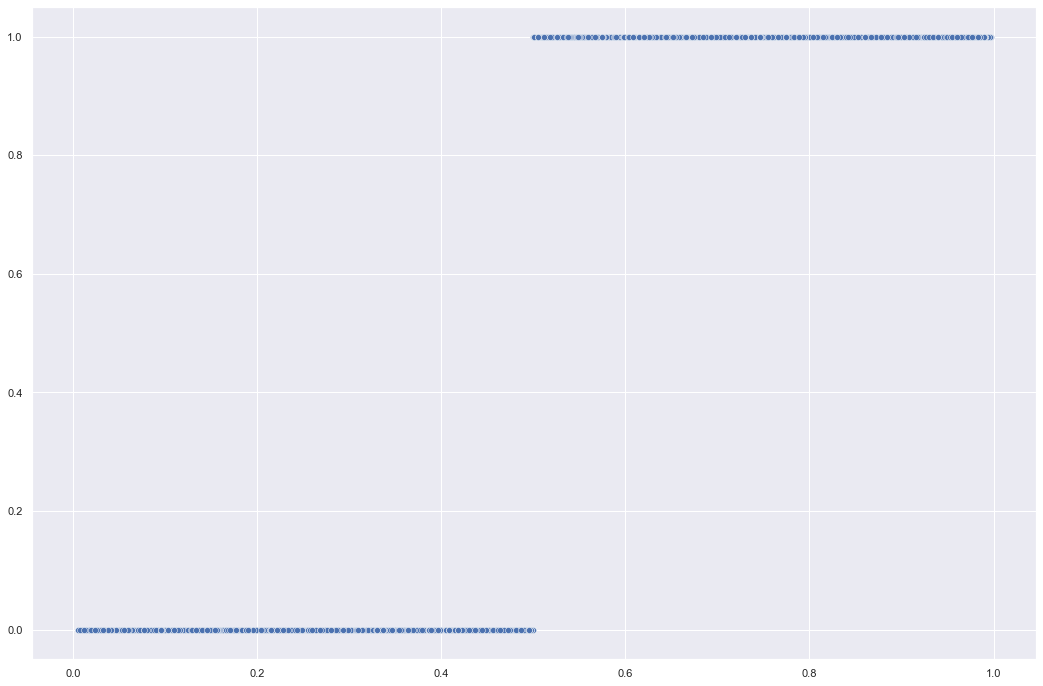

In [258]:
fig = plt.gcf()
fig.set_size_inches(18, 12)
sns.scatterplot(x=inal_pred[:,1], y=final_pred[:,0])

In [281]:
for i in range(4277):
    if subm.loc[i, 'Transported'] >= 0.47:
        subm.loc[i, 'Transported'] = 1
    else:
        subm.loc[i, 'Transported'] = 0

In [655]:
subm['Transported'] = subm['Transported'].astype(bool)

In [242]:
subm.to_csv('KaggleSpace_submission_1.csv', index=False) #катбуст

In [247]:
subm.to_csv('KaggleSpace_submission_2.csv', index=False) #лог рег

In [250]:
subm.to_csv('KaggleSpace_submission_3.csv', index=False) #лес

In [263]:
subm.to_csv('KaggleSpace_submission_4.csv', index=False) #катбуст с предикт_проба 0,47

In [283]:
subm.to_csv('KaggleSpace_submission_5.csv', index=False) #катбуст с предикт_проба 0,53

In [613]:
subm.to_csv('KaggleSpace_submission_6.csv', index=False) #микс из 4 моделей

In [656]:
subm.to_csv('KaggleSpace_submission_7.csv', index=False) #микс из 3 моделей